In [1]:
import sys
parentdir = ".."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 99.0.4844
[WDM] - Get LATEST driver version for 99.0.4844
[WDM] - Driver [/Users/gaignard-a/.wdm/drivers/chromedriver/mac64/99.0.4844.51/chromedriver] found in cache


# Retrieve a Bioschemas RDF dump

In [2]:
dump = "bioschemas-dump.ttl"
if not path.isfile(dump):
    r = requests.get("https://github.com/bio-tools/content/raw/master/datasets/bioschemas-dump.ttl")
    assert r.status_code == 200
    with open(dump, "wb") as f:
        f.write(r.content)

assert path.isfile(dump)

# Load the RDF dump

In [3]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

In [4]:
KG = ConjunctiveGraph()
KG.parse(dump, format="turtle")
print(f"{len(KG)} loaded triples")

483678 loaded triples


In [5]:
index = {}
for s, p, o in KG.triples((None, RDF.type, schema.SoftwareApplication)):
    index[str(s)] = None    
print(print(f"{len(index)} software applications"))

25048 software applications
None


In [6]:
def index_dump():
    for i in tqdm(index.keys()):
        sub_graph = ConjunctiveGraph()
        for s, p, o in KG.triples((URIRef(i), None, None)):
            sub_graph.add((s, p, o))
        index[i]=sub_graph


def get_RDF_sparql(bio_tools_Id):
    q = f"CONSTRUCT {{<{bio_tools_Id}> ?p ?o}} WHERE {{<{bio_tools_Id}> rdf:type schema:SoftwareApplication . <{bio_tools_Id}> ?p ?o .}}"
    res = KG.query(q)
    print(res.serialize(format="turtle"))

def get_RDF(bio_tools_Id):
    sub_graph = ConjunctiveGraph()
    for s, p, o in KG.triples((URIRef(bio_tools_Id), None, None)):
        sub_graph.add((s, p, o))
    print(sub_graph.serialize(format="turtle"))    
    
#get_RDF_sparql("https://bio.tools/bwa")
#get_RDF("https://bio.tools/bwa")

In [7]:
index_dump()

  0%|          | 0/25048 [00:00<?, ?it/s]

In [21]:
import random
#sample_tool = random.choice(index.keys())

random.seed(11)

samples = random.sample(list(index.items()), 500)
#print(samples)

In [22]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
#metrics_collection.append(FAIRMetricsFactory.get_F2B(None))
#metrics_collection.append(FAIRMetricsFactory.get_I1(None))
metrics_collection.append(FAIRMetricsFactory.get_I1A(None))
metrics_collection.append(FAIRMetricsFactory.get_I1B(None))
#metrics_collection.append(FAIRMetricsFactory.get_I2(None))
metrics_collection.append(FAIRMetricsFactory.get_I2A(None))
metrics_collection.append(FAIRMetricsFactory.get_I2B(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
#metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())
    

In [23]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_F2B(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_I1(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1B(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_I2(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in tqdm(metrics_collection):
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time

In [24]:
%%time

df = pd.DataFrame(columns=df_columns)
time_df = pd.DataFrame(columns=df_columns)

for sample in tqdm(samples):
    wr = WebResource(url=sample[0], rdf_graph=sample[1])
    row, row_time = eval_metrics(wr)
    df=df.append(row, ignore_index=True)
    time_df=time_df.append(row_time, ignore_index=True)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


'str' object has no attribute 'get_status_code'


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:3d44b2f9-1377-4fbc-9c68-100170232087:Strong evaluation:
INFO:3d44b2f9-1377-4fbc-9c68-100170232087:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:3d44b2f9-1377-4fbc-9c68-100170232087:None of those property were found in metadata
INFO:3d44b2f9-1377-4fbc-9c68-100170232087:Trying weaker evaluation
INFO:3d44b2f9-1377-4fbc-9c68-100170232087:Weak evaluation:
INFO:3d44b2f9-1377-4fbc-9c68-100170232087:Checking that at least one namespace from identifiers.org is in metadata
INFO:3d44b2f9-1377-4fbc-9c68-100170232087:No namespace from identifiers.org found
INFO:4e3de028-a8dc-41ca-8e2f-8e3e67821819:Checking if data is structured, looking for at least one RDF triple...
INFO:4e3de028-a8dc-41ca-8e2f-8e3e67821819:25 RDF triples were found, thus data is in a well structured graph format
INFO:4d41b2c7-bee9-4ef3-b138-f73870331182:Checking if data is structured, looking for at least one RDF triple...
INFO:4d41b2c7-bee9-4ef3-b138-f73870331182:25 RDF triples were found, thus data is in a well structured graph format
INFO:2f3fe6ee-e094-4548-b7d6-a31eb9a73c37:Checking if data is structured, looking for at least one RDF triple...
INFO:2f3fe6ee-e094

NO
25
STRONG
25
STRONG
25
STRONG
NO
25
STRONG
STRONG
STRONG


INFO:6b2387a8-07fe-48e3-9051-42fb31ef4fbe:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9944c881-5e6d-46a2-b7de-2e0e7e19453e:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:9944c881-5e6d-46a2-b7de-2e0e7e19453e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9944c881-5e6d-46a2-b7de-2e0e7e19453e:None of those property were found in metadata
INFO:9944c881-5e6d-46a2-b7de-2e0e7e19453e:Trying weaker evaluation
INFO:9944c881-5e6d-46a2-b7de-2e0e7e19453e:Weak evaluation:
INFO:9944c881-5e6d-46a2-b7de-2e0e7e19453e:Checking that at least one namespace from identifiers.org is in metadata
INFO:9944c881-5e6d-46a2-b7de-2e0e7e19453e:Found an Identifiers.org namespace for pubmed:26323718
INFO:fbb1cf32-0b92-4e0c-9a09-71c2cba0422f:Checking if data is structured, looking for at least one RDF triple...
INFO:fbb1cf32-0b92-4e0c-9a09-71c2cba0422f:15 RDF triples were found, thus data is in a well structured graph format
INFO:d2250a03-89d1-4471-b726-717cbe508b73:Checking if data is structured, looking for at least one RDF triple...
INFO:d2250a03-89d1-4471-b726-717cbe508b73:15 RDF triples were found, thus data is in a well structured gr

WEAK
15
STRONG
15
STRONG


INFO:66c61cd6-3458-4295-a944-afa014176bec:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:66c61cd6-3458-4295-a944-afa014176bec:None of the properties were found in the RDF metadata
INFO:1e81e1dd-e45e-4d34-aefa-3ca7e36f2367:Checking if data is structured, looking for at least one RDF triple...
INFO:1e81e1dd-e45e-4d34-aefa-3ca7e36f2367:15 RDF triples were found, thus data is in a well structured graph format
INFO:a1ec1bb4-2034-4c7c-a6ba-e21bae6b3ec1:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a1ec1bb4-2034-4c7c-a6ba-e21bae6b3ec1:At least 3 different domains were found in metadata (4)
INFO:163f289e-e18f-4904-b4b4-159112191e55:Checking that at least one of the following licence properties is found in m

15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0cd379e5-d059-48ed-8236-b03e5eca49cf:Strong evaluation:
INFO:0cd379e5-d059-48ed-8236-b03e5eca49cf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0cd379e5-d059-48ed-8236-b03e5eca49cf:None of those property were found in metadata
INFO:0cd379e5-d059-48ed-8236-b03e5eca49cf:Trying weaker evaluation
INFO:0cd379e5-d059-48ed-8236-b03e5eca49cf:Weak evaluation:
INFO:0cd379e5-d059-48ed-8236-b03e5eca49cf:Checking that at least one namespace from identifiers.org is in metadata
INFO:0cd379e5-d059-48ed-8236-b03e5eca49cf:Found an Identifiers.org namespace for pubmed:25619996
INFO:2fbe9870-df9f-4277-a01d-920eea7b1170:Checking if data is structured, looking for at least one RDF triple...
INFO:2fbe9870-df9f-4277-a01d-920eea7b1170:15 RDF triples were found, thus data is in a well structured graph format
INFO:fd986e85-c9e6-40de-b71f-92a84b9a0e3d:Checking if data is structured, looking for at least one RDF triple...
INFO:fd986e85-c9e6-40de-b71f-92a84b9a0e3d:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG


INFO:e42a9636-be92-4617-959b-aab345956dd3:Checking if data is structured, looking for at least one RDF triple...
INFO:e42a9636-be92-4617-959b-aab345956dd3:15 RDF triples were found, thus data is in a well structured graph format
INFO:1a1eea5a-80bd-4adc-9a5f-906ec7c1fd60:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:1a1eea5a-80bd-4adc-9a5f-906ec7c1fd60:None of the properties were found in the RDF metadata


15
STRONG
15
STRONG


INFO:0d0c731d-6bc5-487a-9c63-9e0e6f8ce211:Checking if data is structured, looking for at least one RDF triple...
INFO:0d0c731d-6bc5-487a-9c63-9e0e6f8ce211:15 RDF triples were found, thus data is in a well structured graph format
INFO:a443be8f-653c-444d-83d9-8199f05f3ee5:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a443be8f-653c-444d-83d9-8199f05f3ee5:At least 3 different domains were found in metadata (4)
INFO:6d9430fc-2044-4282-a188-89d10e73eae3:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:6d9430fc-2044-4282-a188-89d10e73eae3:None of the licence property were found in metadata
INFO:bfee203e-3068-4b62-925a-67d7b4aa3995:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo pro

NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:46f52a53-1ab0-48d9-84ff-e0e29c4104d4:Strong evaluation:
INFO:46f52a53-1ab0-48d9-84ff-e0e29c4104d4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:46f52a53-1ab0-48d9-84ff-e0e29c4104d4:None of those property were found in metadata
INFO:46f52a53-1ab0-48d9-84ff-e0e29c4104d4:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:46f52a53-1ab0-48d9-84ff-e0e29c4104d4:Weak evaluation:
INFO:46f52a53-1ab0-48d9-84ff-e0e29c4104d4:Checking that at least one namespace from identifiers.org is in metadata
INFO:46f52a53-1ab0-48d9-84ff-e0e29c4104d4:Found an Identifiers.org namespace for pubmed:20929872
INFO:876c1c91-6997-4b14-b160-41c69b712a7e:Checking if data is structured, looking for at least one RDF triple...
INFO:876c1c91-6997-4b14-b160-41c69b712a7e:22 RDF triples were found, thus data is in a well structured graph format
INFO:2428874b-98a7-4a42-8d75-1cbf6232a70f:Checking if data is structured, looking for at least one RDF triple...
INFO:2428874b-98a7-4a42-8d75-1cbf6232a70f:22 RDF triples were found, thus data is in a well structured graph format
INFO:d919be1d-f67a-4da4-8ab2-71f4db2b001b:Checking if data is structured, looking for at least one RDF triple...
INFO:d919be1d-f67a-4da4-8ab2-71f4db2b001b:22 RDF triples were found, thus data is in a well structured graph format
INFO:ab3f1ba7-207a-49ed-a43c-4f36c3982bb1:

WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG


INFO:be2b0664-547e-403a-9fa5-aacb3f3d289a:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:be2b0664-547e-403a-9fa5-aacb3f3d289a:None of the provenance property were found in metadata !


NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ac92c1b1-8040-4c5e-b7f7-da7056e8615d:Strong evaluation:
INFO:ac92c1b1-8040-4c5e-b7f7-da7056e8615d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ac92c1b1-8040-4c5e-b7f7-da7056e8615d:None of those property were found in metadata
INFO:ac92c1b1-8040-4c5e-b7f7-da7056e8615d:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:ac92c1b1-8040-4c5e-b7f7-da7056e8615d:Weak evaluation:
INFO:ac92c1b1-8040-4c5e-b7f7-da7056e8615d:Checking that at least one namespace from identifiers.org is in metadata
INFO:ac92c1b1-8040-4c5e-b7f7-da7056e8615d:Found an Identifiers.org namespace for pubmed:19134071
INFO:530920fd-f1a1-48a3-a140-a2706856f9f6:Checking if data is structured, looking for at least one RDF triple...
INFO:530920fd-f1a1-48a3-a140-a2706856f9f6:15 RDF triples were found, thus data is in a well structured graph format
INFO:aa0ca7ee-281e-4bdf-920b-b86d27ef0604:Checking if data is structured, looking for at least one RDF triple...
INFO:aa0ca7ee-281e-4bdf-920b-b86d27ef0604:15 RDF triples were found, thus data is in a well structured graph format
INFO:6f33129d-45b1-4d0b-bf32-5f918933d8cf:Checking if data is structured, looking for at least one RDF triple...
INFO:6f33129d-45b1-4d0b-bf32-5f918933d8cf:15 RDF triples were found, thus data is in a well structured graph format
INFO:db82ba0b-21cb-4d11-a003-5b8f6c650d60:

WEAK
15
STRONG
15
STRONG
15
STRONG


INFO:a07e7677-94e1-417c-ae78-7bf5618383fa:Checking if data is structured, looking for at least one RDF triple...
INFO:a07e7677-94e1-417c-ae78-7bf5618383fa:15 RDF triples were found, thus data is in a well structured graph format
INFO:3c27815c-2e75-46fa-a32a-41b9ab50ce95:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:3c27815c-2e75-46fa-a32a-41b9ab50ce95:At least 3 different domains were found in metadata (5)
INFO:1250753d-5ae4-423c-9b76-0e2fccde6ca9:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:1250753d-5ae4-423c-9b76-0e2fccde6ca9:At least one of the licence property was found in metadata !
INFO:ffb96027-9fde-420e-8e02-a56ae5a3988e:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttribu

NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f7f65a22-589e-4297-a571-f126cd1e0121:Strong evaluation:
INFO:f7f65a22-589e-4297-a571-f126cd1e0121:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:f7f65a22-589e-4297-a571-f126cd1e0121:None of those property were found in metadata
INFO:f7f65a22-589e-4297-a571-f126cd1e0121:Trying weaker evaluation
INFO:f7f65a22-589e-4297-a571-f126cd1e0121:Weak evaluation:
INFO:f7f65a22-589e-4297-a571-f126cd1e0121:Checking that at least one namespace from identifiers.org is in metadata
INFO:f7f65a22-589e-4297-a571-f126cd1e0121:Found an Identifiers.org namespace for pubmed:16285674
INFO:9025cec3-dfbf-4d4e-a1f9-be145dba273a:Checking if data is structured, looking for at least one RDF triple...
INFO:9025cec3-dfbf-4d4e-a1f9-be145dba273a:14 RDF triples were found, thus data is in a well structured graph format
INFO:6d839bcc-be34-4fd6-970e-3c8134bcbbb3:Checking if data is structured, looking for at least one RDF triple...
INFO:6d839bcc-be34-4fd6-970e-3c8134bcbbb3:14 RDF triples were found, thus data is in a well structured graph format
INFO:4eb5b4f7-ae96-45d6-9abb-7b13250339a0:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
14
STRONG
14
STRONG
14
STRONG


INFO:8c4a55e3-b6a3-4112-a6f8-cd16089eee69:None of the properties were found in the RDF metadata
INFO:ddc159a3-7fa7-4631-8b0f-9f74477706d0:Checking if data is structured, looking for at least one RDF triple...
INFO:ddc159a3-7fa7-4631-8b0f-9f74477706d0:14 RDF triples were found, thus data is in a well structured graph format
INFO:0d62739b-1214-4428-8e70-49b57014b480:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:0d62739b-1214-4428-8e70-49b57014b480:At least 3 different domains were found in metadata (4)
INFO:a4d80826-c165-4e12-b5f8-2ffe4f70ebb4:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        


NO
14
STRONG
STRONG


INFO:a4d80826-c165-4e12-b5f8-2ffe4f70ebb4:None of the licence property were found in metadata
INFO:0601fcda-6835-43a8-a4b6-ef0a5883b672:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:0601fcda-6835-43a8-a4b6-ef0a5883b672:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecate

NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:217a96ff-1b03-4248-a574-2bbd1ca93c38:Strong evaluation:
INFO:217a96ff-1b03-4248-a574-2bbd1ca93c38:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:217a96ff-1b03-4248-a574-2bbd1ca93c38:None of those property were found in metadata
INFO:217a96ff-1b03-4248-a574-2bbd1ca93c38:Trying weaker evaluation
INFO:217a96ff-1b03-4248-a574-2bbd1ca93c38:Weak evaluation:
INFO:217a96ff-1b03-4248-a574-2bbd1ca93c38:Checking that at least one namespace from identifiers.org is in metadata
INFO:217a96ff-1b03-4248-a574-2bbd1ca93c38:Found an Identifiers.org namespace for pubmed:19819296
INFO:28f73b6b-0b5f-42cc-88b1-6544e8ff06b8:Checking if data is structured, looking for at least one RDF triple...
INFO:28f73b6b-0b5f-42cc-88b1-6544e8ff06b8:18 RDF triples were found, thus data is in a well structured graph format
INFO:48c07f0f-730f-46a9-8c43-73f20bef8ee4:Checking if data is structured, looking for at least one RDF triple...
INFO:48c07f0f-730f-46a9-8c43-73f20bef8ee4:18 RDF triples were found, thus data is in a well structured graph format
INFO:03953e94-be82-4925-8d66-61bb1f205b6a:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
18
STRONG
18
STRONG
18
STRONG


INFO:dacb7675-6297-4a2c-aca0-52e3868951ad:None of the properties were found in the RDF metadata
INFO:869ba5a2-6c0c-483d-9918-b7560d2c2ddb:Checking if data is structured, looking for at least one RDF triple...
INFO:869ba5a2-6c0c-483d-9918-b7560d2c2ddb:18 RDF triples were found, thus data is in a well structured graph format
INFO:4dd22e47-05ce-4158-94de-bef8f7ae0631:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:4dd22e47-05ce-4158-94de-bef8f7ae0631:At least 3 different domains were found in metadata (4)
INFO:3fb45ab0-ab2b-492b-ba21-1e9f31b36162:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:3fb45ab0-ab2b-492b-ba21-1e9f31b36162:None of the licence property were found in metadata


NO
18
STRONG
STRONG


INFO:d8961ec1-f907-4604-802d-59f39d733e11:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:d8961ec1-f907-4604-802d-59f39d733e11:None of the provenance property were found in metadata !


NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a330f0d9-4b69-42cc-9d07-86b05365095a:Strong evaluation:
INFO:a330f0d9-4b69-42cc-9d07-86b05365095a:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:a330f0d9-4b69-42cc-9d07-86b05365095a:None of those property were found in metadata
INFO:a330f0d9-4b69-42cc-9d07-86b05365095a:Trying weaker evaluation
INFO:a330f0d9-4b69-42cc-9d07-86b05365095a:Weak evaluation:
INFO:a330f0d9-4b69-42cc-9d07-86b05365095a:Checking that at least one namespace from identifiers.org is in metadata
INFO:a330f0d9-4b69-42cc-9d07-86b05365095a:Found an Identifiers.org namespace for pubmed:21947200
INFO:0423609b-ada4-438b-a295-b351f943c371:Checking if data is structured, looking for at least one RDF triple...
INFO:0423609b-ada4-438b-a295-b351f943c371:15 RDF triples were found, thus data is in a well structured graph format
INFO:b13c7d70-3148-4468-8065-7752ddabc9d7:Checking if data is structured, looking for at least one RDF triple...
INFO:b13c7d70-3148-4468-8065-7752ddabc9d7:15 RDF triples were found, thus data is in a well structured graph format
INFO:51c559d2-2063-47a2-b9eb-73c5eabc8837:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
15
STRONG
15
STRONG
15
STRONG
NO


INFO:1e4a4dd8-55e6-46af-88ff-4a508a8b4b3b:15 RDF triples were found, thus data is in a well structured graph format
INFO:d25b09d3-1648-4f13-aad1-22ff6710de31:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:d25b09d3-1648-4f13-aad1-22ff6710de31:At least 3 different domains were found in metadata (4)
INFO:b3b58296-366b-48a6-87ca-59f9aea38381:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:b3b58296-366b-48a6-87ca-59f9aea38381:None of the licence property were found in metadata
INFO:527a2a94-ecc6-4915-896d-ed9ad39c426a:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:

15
STRONG
STRONG
NO


INFO:527a2a94-ecc6-4915-896d-ed9ad39c426a:None of the provenance property were found in metadata !


NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:092d00b8-4a01-4dfb-8ce6-318251ecd1ba:Strong evaluation:
INFO:092d00b8-4a01-4dfb-8ce6-318251ecd1ba:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:092d00b8-4a01-4dfb-8ce6-318251ecd1ba:None of those property were found in metadata
INFO:092d00b8-4a01-4dfb-8ce6-318251ecd1ba:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:092d00b8-4a01-4dfb-8ce6-318251ecd1ba:Weak evaluation:
INFO:092d00b8-4a01-4dfb-8ce6-318251ecd1ba:Checking that at least one namespace from identifiers.org is in metadata
INFO:092d00b8-4a01-4dfb-8ce6-318251ecd1ba:No namespace from identifiers.org found
INFO:5efe56d2-b38e-464f-a1aa-d1d0f98abac3:Checking if data is structured, looking for at least one RDF triple...
INFO:5efe56d2-b38e-464f-a1aa-d1d0f98abac3:17 RDF triples were found, thus data is in a well structured graph format
INFO:e8bd3d4f-59a2-439b-bba0-8a6fc3c079d2:Checking if data is structured, looking for at least one RDF triple...
INFO:e8bd3d4f-59a2-439b-bba0-8a6fc3c079d2:17 RDF triples were found, thus data is in a well structured graph format
INFO:5ddcd4d5-f859-4714-b2e3-fcec7cbac537:Checking if data is structured, looking for at least one RDF triple...
INFO:5ddcd4d5-f859-4714-b2e3-fcec7cbac537:17 RDF triples were found, thus data is in a well structured graph format
INFO:3b3a50a4-5862-42cb-89fd-e61e84686285:Checking that a

NO
17
STRONG
17
STRONG
17
STRONG
NO

INFO:ad86fc7e-6a48-4e35-a9ec-1cf50071e451:Checking if data is structured, looking for at least one RDF triple...
INFO:ad86fc7e-6a48-4e35-a9ec-1cf50071e451:17 RDF triples were found, thus data is in a well structured graph format
INFO:35934cca-f49d-44ee-be16-0a6fdca343ac:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:35934cca-f49d-44ee-be16-0a6fdca343ac:At least 3 different domains were found in metadata (5)
INFO:78b01797-4b50-4205-ac85-0765082a4683:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:78b01797-4b50-4205-ac85-0765082a4683:At least one of the licence property was found in metadata !
INFO:137bb653-902b-482d-961d-c7962690a39a:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttribu


17
STRONG
STRONG
STRONG


INFO:137bb653-902b-482d-961d-c7962690a39a:None of the provenance property were found in metadata !


NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:79ffc22e-b0e2-4986-9044-a5da3fed0749:Strong evaluation:
INFO:79ffc22e-b0e2-4986-9044-a5da3fed0749:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:79ffc22e-b0e2-4986-9044-a5da3fed0749:None of those property were found in metadata
INFO:79ffc22e-b0e2-4986-9044-a5da3fed0749:Trying weaker evaluation
INFO:79ffc22e-b0e2-4986-9044-a5da3fed0749:Weak evaluation:
INFO:79ffc22e-b0e2-4986-9044-a5da3fed0749:Checking that at least one namespace from identifiers.org is in metadata
INFO:79ffc22e-b0e2-4986-9044-a5da3fed0749:No namespace from identifiers.org found
INFO:2f56f699-51ab-4a2e-a584-9c41396558a5:Checking if data is structured, looking for at least one RDF triple...
INFO:2f56f699-51ab-4a2e-a584-9c41396558a5:15 RDF triples were found, thus data is in a well structured graph format
INFO:7df67b90-f5be-431d-b8a2-93d0c5dbc8e7:Checking if data is structured, looking for at least one RDF triple...
INFO:7df67b90-f5be-431d-b8a2-93d0c5dbc8e7:15 RDF triples were found, thus data is in a well structured graph format
INFO:69230e97-a2e9-451a-9361-315309e874f3:Checking if data is structured, looking for at least one RDF triple...
INFO:69230e97-a2e9

NO
15
STRONG
15
STRONG
15
STRONG


INFO:4d82c18c-2027-4c50-a2c8-bac33521899a:Checking if data is structured, looking for at least one RDF triple...
INFO:4d82c18c-2027-4c50-a2c8-bac33521899a:15 RDF triples were found, thus data is in a well structured graph format
INFO:829974ef-b4e2-4c19-ac7e-4624085c1512:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:829974ef-b4e2-4c19-ac7e-4624085c1512:At least 3 different domains were found in metadata (4)
INFO:a0251868-9475-4cd2-b173-2a8ee5fd3d01:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:a0251868-9475-4cd2-b173-2a8ee5fd3d01:None of the licence property were found in metadata


NO
15
STRONG
STRONG


INFO:68918b6f-1c14-48a5-a6dc-687b8f89a7dc:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:68918b6f-1c14-48a5-a6dc-687b8f89a7dc:None of the provenance property were found in metadata !


NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:76b699ac-4e7f-45c2-99c3-74e206708165:Strong evaluation:
INFO:76b699ac-4e7f-45c2-99c3-74e206708165:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:76b699ac-4e7f-45c2-99c3-74e206708165:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:76b699ac-4e7f-45c2-99c3-74e206708165:Trying weaker evaluation
INFO:76b699ac-4e7f-45c2-99c3-74e206708165:Weak evaluation:
INFO:76b699ac-4e7f-45c2-99c3-74e206708165:Checking that at least one namespace from identifiers.org is in metadata
INFO:76b699ac-4e7f-45c2-99c3-74e206708165:Found an Identifiers.org namespace for pubmed:31451723
INFO:5e044a5b-2b39-47d8-b3d5-07263781bc89:Checking if data is structured, looking for at least one RDF triple...
INFO:5e044a5b-2b39-47d8-b3d5-07263781bc89:27 RDF triples were found, thus data is in a well structured graph format
INFO:0f5d23e8-8dfe-4c81-af41-3efdfa9082a7:Checking if data is structured, looking for at least one RDF triple...
INFO:0f5d23e8-8dfe-4c81-af41-3efdfa9082a7:27 RDF triples were found, thus data is in a well structured graph format
INFO:a1a7f3cd-5194-497a-ae55-09c136134836:Checking if data is structured, looking for at least one RDF triple...
INFO:a1a7f3cd-5194-497a-ae55-09c136134836:27 RDF triples were found, thus data is in a well

WEAK
27
STRONG
27
STRONG
27
STRONG


INFO:6f443760-9ba7-4aaa-8947-650f4b201e46:Checking if data is structured, looking for at least one RDF triple...
INFO:6f443760-9ba7-4aaa-8947-650f4b201e46:27 RDF triples were found, thus data is in a well structured graph format
INFO:eb9c5c6c-cf43-4ac0-ae25-483a6f9cf7ce:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:eb9c5c6c-cf43-4ac0-ae25-483a6f9cf7ce:At least 3 different domains were found in metadata (5)
INFO:fc4fbfc4-0fa6-4629-8a5c-ec17e3ab32d3:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:fc4fbfc4-0fa6-4629-8a5c-ec17e3ab32d3:At least one of the licence property was found in metadata !
INFO:226a712c-2e8f-4ceb-838e-7c6727a1efdc:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttribu

NO
27
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b1e10ec6-eee7-4f22-a763-f3b2abe87c6d:Strong evaluation:
INFO:b1e10ec6-eee7-4f22-a763-f3b2abe87c6d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b1e10ec6-eee7-4f22-a763-f3b2abe87c6d:None of those property were found in metadata
INFO:b1e10ec6-eee7-4f22-a763-f3b2abe87c6d:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:b1e10ec6-eee7-4f22-a763-f3b2abe87c6d:Weak evaluation:
INFO:b1e10ec6-eee7-4f22-a763-f3b2abe87c6d:Checking that at least one namespace from identifiers.org is in metadata
INFO:b1e10ec6-eee7-4f22-a763-f3b2abe87c6d:Found an Identifiers.org namespace for pubmed:27000774
INFO:89c16334-38b8-450c-82ea-883a4510eb58:Checking if data is structured, looking for at least one RDF triple...
INFO:89c16334-38b8-450c-82ea-883a4510eb58:18 RDF triples were found, thus data is in a well structured graph format
INFO:e46c7264-0293-4383-9eee-55c752da0271:Checking if data is structured, looking for at least one RDF triple...
INFO:e46c7264-0293-4383-9eee-55c752da0271:18 RDF triples were found, thus data is in a well structured graph format
INFO:7b902128-66be-4955-be16-35fef5ee1974:Checking if data is structured, looking for at least one RDF triple...
INFO:7b902128-66be-4955-be16-35fef5ee1974:18 RDF triples were found, thus data is in a well structured graph format
INFO:2edd2afb-cb8b-4277-bfe8-9092c6492ccd:

WEAK
18
STRONG
18
STRONG
18
STRONG
NO


INFO:0fed434f-7322-4f50-84f9-867cc7b04765:18 RDF triples were found, thus data is in a well structured graph format
INFO:07edae53-3a4a-409a-a45b-40c824f19f39:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:07edae53-3a4a-409a-a45b-40c824f19f39:At least 3 different domains were found in metadata (5)


18
STRONG
STRONG


INFO:c95b32ba-7dc6-41a5-aa9f-81c4d59933b8:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:c95b32ba-7dc6-41a5-aa9f-81c4d59933b8:None of the licence property were found in metadata
INFO:7f9dc165-1e7f-4c19-ad11-696f7e597db9:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:7f9dc165-1e7f-4c19-ad11-696f7e597db9:None of the proven

NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a9908de9-9b56-494c-9a6f-24daf2f134bc:Strong evaluation:
INFO:a9908de9-9b56-494c-9a6f-24daf2f134bc:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:a9908de9-9b56-494c-9a6f-24daf2f134bc:None of those property were found in metadata
INFO:a9908de9-9b56-494c-9a6f-24daf2f134bc:Trying weaker evaluation
INFO:a9908de9-9b56-494c-9a6f-24daf2f134bc:Weak evaluation:
INFO:a9908de9-9b56-494c-9a6f-24daf2f134bc:Checking that at least one namespace from identifiers.org is in metadata
INFO:a9908de9-9b56-494c-9a6f-24daf2f134bc:No namespace from identifiers.org found
INFO:bc86eba5-bc02-4901-aa4d-4e980d157dcc:Checking if data is structured, looking for at least one RDF triple...
INFO:bc86eba5-bc02-4901-aa4d-4e980d157dcc:12 RDF triples were found, thus data is in a well structured graph format
INFO:4ffe6cff-f7d5-48d1-9b01-e1dd15d91b56:Checking if data is structured, looking for at least one RDF triple...
INFO:4ffe6cff-f7d5-48d1-9b01-e1dd15d91b56:12 RDF triples were found, thus data is in a well structured graph format
INFO:6263c64b-df55-4dd9-9bf8-b1a1b27b389f:Checking if data is structured, looking for at least one RDF triple...
INFO:6263c64b-df55

NO
12
STRONG
12
STRONG
12
STRONG


INFO:73ed91b7-3bf9-4778-8531-e26d499451a5:None of the properties were found in the RDF metadata
INFO:6f65a1ad-6f81-483e-9673-3b9f7c516c6a:Checking if data is structured, looking for at least one RDF triple...
INFO:6f65a1ad-6f81-483e-9673-3b9f7c516c6a:12 RDF triples were found, thus data is in a well structured graph format
INFO:faba30b3-3c9b-4f12-8cde-aaac8363963b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:faba30b3-3c9b-4f12-8cde-aaac8363963b:Less than 3 different domains were found in metadata (3)
INFO:a63f6b8a-72aa-43d7-9686-f8a346c3a28e:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:a63f6b8a-72aa-43d7-9686-f8a346c3a28e:None of the licence property were found in metadata


NO
12
STRONG
NO


INFO:52890186-7270-4230-b3dd-e6dc4368050e:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:52890186-7270-4230-b3dd-e6dc4368050e:None of the provenance property were found in metadata !


NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:af2d66c9-a5a0-4e11-b12d-510ba0e4e900:Strong evaluation:
INFO:af2d66c9-a5a0-4e11-b12d-510ba0e4e900:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:af2d66c9-a5a0-4e11-b12d-510ba0e4e900:None of those property were found in metadata
INFO:af2d66c9-a5a0-4e11-b12d-510ba0e4e900:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:af2d66c9-a5a0-4e11-b12d-510ba0e4e900:Weak evaluation:
INFO:af2d66c9-a5a0-4e11-b12d-510ba0e4e900:Checking that at least one namespace from identifiers.org is in metadata
INFO:af2d66c9-a5a0-4e11-b12d-510ba0e4e900:Found an Identifiers.org namespace for pubmed:32750857
INFO:c323370a-cc85-4b79-91a1-e9b75e517889:Checking if data is structured, looking for at least one RDF triple...
INFO:c323370a-cc85-4b79-91a1-e9b75e517889:15 RDF triples were found, thus data is in a well structured graph format
INFO:5999c224-128a-4840-acfe-1bae297e51ba:Checking if data is structured, looking for at least one RDF triple...
INFO:5999c224-128a-4840-acfe-1bae297e51ba:15 RDF triples were found, thus data is in a well structured graph format
INFO:3f655622-3cb1-4d5c-8c97-1362186bc778:Checking if data is structured, looking for at least one RDF triple...
INFO:3f655622-3cb1-4d5c-8c97-1362186bc778:15 RDF triples were found, thus data is in a well structured graph format
INFO:9b4f03f2-cefe-47bd-8c50-27820baa1701:

WEAK
15
STRONG
15
STRONG
15
STRONG


INFO:7a89b152-3571-4be0-8188-04e6737fecaf:Checking if data is structured, looking for at least one RDF triple...
INFO:7a89b152-3571-4be0-8188-04e6737fecaf:15 RDF triples were found, thus data is in a well structured graph format
INFO:17fc1892-1689-4e76-adb0-6f81186d26f2:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:17fc1892-1689-4e76-adb0-6f81186d26f2:At least 3 different domains were found in metadata (4)
INFO:a652162a-9f71-4de8-b0f1-a08bad48627f:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:a652162a-9f71-4de8-b0f1-a08bad48627f:None of the licence property were found in metadata


NO
15
STRONG
STRONG
NO

INFO:cbfab3a2-5a3d-4603-9371-d0d70e6e771e:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        


INFO:cbfab3a2-5a3d-4603-9371-d0d70e6e771e:None of the provenance property were found in metadata !


NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f317a0c0-1aba-457c-996f-365aacc225eb:Strong evaluation:
INFO:f317a0c0-1aba-457c-996f-365aacc225eb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f317a0c0-1aba-457c-996f-365aacc225eb:None of those property were found in metadata
INFO:f317a0c0-1aba-457c-996f-365aacc225eb:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:f317a0c0-1aba-457c-996f-365aacc225eb:Weak evaluation:
INFO:f317a0c0-1aba-457c-996f-365aacc225eb:Checking that at least one namespace from identifiers.org is in metadata
INFO:f317a0c0-1aba-457c-996f-365aacc225eb:Found an Identifiers.org namespace for pubmed:31860654
INFO:2e2a13fa-4e25-46a8-97d7-24d095d04693:Checking if data is structured, looking for at least one RDF triple...
INFO:2e2a13fa-4e25-46a8-97d7-24d095d04693:18 RDF triples were found, thus data is in a well structured graph format
INFO:869c838c-79aa-4058-a9ff-d3f10b86a8d3:Checking if data is structured, looking for at least one RDF triple...
INFO:869c838c-79aa-4058-a9ff-d3f10b86a8d3:18 RDF triples were found, thus data is in a well structured graph format
INFO:a5e5b0b6-5dd0-4a98-95ef-d3dcacbb5ef1:Checking if data is structured, looking for at least one RDF triple...
INFO:a5e5b0b6-5dd0-4a98-95ef-d3dcacbb5ef1:18 RDF triples were found, thus data is in a well structured graph format
INFO:11af36e0-9b1d-4d13-a007-1b822298b834:

WEAK
18
STRONG
18
STRONG
18
STRONG


INFO:f881d73a-c996-4ac0-9dae-9805a184e574:Checking if data is structured, looking for at least one RDF triple...
INFO:f881d73a-c996-4ac0-9dae-9805a184e574:18 RDF triples were found, thus data is in a well structured graph format
INFO:5f12ad79-d387-4274-8ba6-ca8134856d50:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:5f12ad79-d387-4274-8ba6-ca8134856d50:At least 3 different domains were found in metadata (4)
INFO:79aedce6-7dce-445b-bac6-97b9fbaf1040:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:79aedce6-7dce-445b-bac6-97b9fbaf1040:At least one of the licence property was found in metadata !
INFO:2a11b02e-1e52-4eac-8222-1dd282cd8a02:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttribu

NO
18
STRONG
STRONG
STRONG


INFO:2a11b02e-1e52-4eac-8222-1dd282cd8a02:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f6eca604-c921-4b08-b5c6-13e513feb430:Strong evaluation:
INFO:f6eca604-c921-4b08-b5c6-13e513feb430:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f6eca604-c921-4b08-b5c6-13e513feb430:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:f6eca604-c921-4b08-b5c6-13e513feb430:Trying weaker evaluation
INFO:f6eca604-c921-4b08-b5c6-13e513feb430:Weak evaluation:
INFO:f6eca604-c921-4b08-b5c6-13e513feb430:Checking that at least one namespace from identifiers.org is in metadata
INFO:f6eca604-c921-4b08-b5c6-13e513feb430:Found an Identifiers.org namespace for pubmed:14691953
INFO:4684c171-7efd-4933-9966-3cfad42df7bb:Checking if data is structured, looking for at least one RDF triple...
INFO:4684c171-7efd-4933-9966-3cfad42df7bb:17 RDF triples were found, thus data is in a well structured graph format
INFO:31436288-692d-49a2-b816-f168f4268272:Checking if data is structured, looking for at least one RDF triple...
INFO:31436288-692d-49a2-b816-f168f4268272:17 RDF triples were found, thus data is in a well structured graph format
INFO:63bc6a84-effc-4949-94b8-fa56a9a348a2:Checking if data is structured, looking for at least one RDF triple...
INFO:63bc6a84-effc-4949-94b8-fa56a9a348a2:17 RDF triples were found, thus data is in a well

WEAK
17
STRONG
17
STRONG
17
STRONG


INFO:36fe952c-f879-4b38-9d7d-ce0a9eb4370f:Checking if data is structured, looking for at least one RDF triple...
INFO:36fe952c-f879-4b38-9d7d-ce0a9eb4370f:17 RDF triples were found, thus data is in a well structured graph format
INFO:006998cc-9f19-488d-b8c3-9043b410576e:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:006998cc-9f19-488d-b8c3-9043b410576e:At least 3 different domains were found in metadata (4)
INFO:4a9eba80-73eb-4d6f-a551-32666a7d324e:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:4a9eba80-73eb-4d6f-a551-32666a7d324e:None of the licence property were found in metadata
INFO:38eaa06f-6d61-4e10-8656-e56ca3c10c94:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo pro

NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1174fbfe-83ed-48a2-8ee4-b71bb52a0d18:Strong evaluation:
INFO:1174fbfe-83ed-48a2-8ee4-b71bb52a0d18:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1174fbfe-83ed-48a2-8ee4-b71bb52a0d18:None of those property were found in metadata
INFO:1174fbfe-83ed-48a2-8ee4-b71bb52a0d18:Trying weaker evaluation
INFO:1174fbfe-83ed-48a2-8ee4-b71bb52a0d18:Weak evaluation:
INFO:1174fbfe-83ed-48a2-8ee4-b71bb52a0d18:Checking that at least one namespace from identifiers.org is in metadata
INFO:1174fbfe-83ed-48a2-8ee4-b71bb52a0d18:No namespace from identifiers.org found
INFO:f5a1b229-6b3d-4037-a7c7-c32b2048ce69:Checking if data is structured, looking for at least one RDF triple...
INFO:f5a1b229-6b3d-4037-a7c7-c32b2048ce69:14 RDF triples were found, thus data is in a well structured graph format
INFO:c877f343-fe5b-4edf-98f0-2c8e1cb63563:Checking if data is structured, looking for at least one RDF triple...
INFO:c877f343-fe5b-4edf-98f0-2c8e1cb63563:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b523bcf9-8019-4105-9f0a-555375688a60:Strong evaluation:
INFO:b523bcf9-8019-4105-9f0a-555375688a60:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b523bcf9-8019-4105-9f0a-555375688a60:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:b523bcf9-8019-4105-9f0a-555375688a60:Trying weaker evaluation
INFO:b523bcf9-8019-4105-9f0a-555375688a60:Weak evaluation:
INFO:b523bcf9-8019-4105-9f0a-555375688a60:Checking that at least one namespace from identifiers.org is in metadata
INFO:b523bcf9-8019-4105-9f0a-555375688a60:No namespace from identifiers.org found
INFO:363fee0f-e1ea-42a6-abc4-dd71a9cbb500:Checking if data is structured, looking for at least one RDF triple...
INFO:363fee0f-e1ea-42a6-abc4-dd71a9cbb500:17 RDF triples were found, thus data is in a well structured graph format
INFO:97a91d55-3035-4b71-856a-913d53a2664a:Checking if data is structured, looking for at least one RDF triple...
INFO:97a91d55-3035-4b71-856a-913d53a2664a:17 RDF triples were found, thus data is in a well structured graph format
INFO:d695dc78-9709-4181-97fe-64415d0add4c:Checking if data is structured, looking for at least one RDF triple...
INFO:d695dc78-9709-4181-97fe-64415d0add4c:17 RDF triples were found, thus data is in a well structured gra

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:21f63c61-6340-4454-9398-cfece0e070ea:Strong evaluation:
INFO:21f63c61-6340-4454-9398-cfece0e070ea:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:21f63c61-6340-4454-9398-cfece0e070ea:None of those property were found in metadata
INFO:21f63c61-6340-4454-9398-cfece0e070ea:Trying weaker evaluation
INFO:21f63c61-6340-4454-9398-cfece0e070ea:Weak evaluation:


'str' object has no attribute 'get_status_code'


INFO:21f63c61-6340-4454-9398-cfece0e070ea:Checking that at least one namespace from identifiers.org is in metadata
INFO:21f63c61-6340-4454-9398-cfece0e070ea:No namespace from identifiers.org found
INFO:73bcfae5-a148-4ae9-8f2d-3cbb013eb505:Checking if data is structured, looking for at least one RDF triple...
INFO:73bcfae5-a148-4ae9-8f2d-3cbb013eb505:17 RDF triples were found, thus data is in a well structured graph format
INFO:a8eda0bd-2b4e-40e0-b8e1-28c2e1183162:Checking if data is structured, looking for at least one RDF triple...
INFO:a8eda0bd-2b4e-40e0-b8e1-28c2e1183162:17 RDF triples were found, thus data is in a well structured graph format
INFO:10ca64df-11bd-4ebf-a08d-532a1659e072:Checking if data is structured, looking for at least one RDF triple...
INFO:10ca64df-11bd-4ebf-a08d-532a1659e072:17 RDF triples were found, thus data is in a well structured graph format
INFO:d4a66c94-ff38-48a7-9622-9d2c6968cab2:Checking that at least one of these properties is used:
dct:title dct:abst

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:32052773-4531-462e-bdb5-e7a84a271c23:Strong evaluation:
INFO:32052773-4531-462e-bdb5-e7a84a271c23:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:32052773-4531-462e-bdb5-e7a84a271c23:None of those property were found in metadata
INFO:32052773-4531-462e-bdb5-e7a84a271c23:Trying weaker evaluation
INFO:32052773-4531-462e-bdb5-e7a84a271c23:Weak evaluation:
INFO:32052773-4531-462e-bdb5-e7a84a271c23:Checking that at least one namespace from identifiers.org is in metadata
INFO:32052773-4531-462e-bdb5-e7a84a271c23:Found an Identifiers.org namespace for pubmed:33413088
INFO:58d1356f-62c9-4060-8ed6-5b0fbf69a440:Checking if data is structured, looking for at least one RDF triple...
INFO:58d1356f-62c9-4060-8ed6-5b0fbf69a440:14 RDF triples were found, thus data is in a well structured graph format
INFO:68e9a029-e53d-45bb-9760-ca13f8a62f98:Checking if data is structured, looking for at least one RDF triple...
INFO:68e9a029-e53d-45bb-9760-ca13f8a62f98:14 RDF triples were found, thus data is in a well structured graph format
INFO:8d51ad78-93b7-4d6c-abae-37e668ba5084:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
14
STRONG
14
STRONG
14
STRONG


INFO:d61cdef0-c4c5-4546-bbcb-f957a2f00546:None of the properties were found in the RDF metadata
INFO:fa7681f0-c0bd-4f6f-8689-0784b3ec35ef:Checking if data is structured, looking for at least one RDF triple...
INFO:fa7681f0-c0bd-4f6f-8689-0784b3ec35ef:14 RDF triples were found, thus data is in a well structured graph format
INFO:23ade4e1-edaa-4d71-8055-7f7f241ff6f9:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:23ade4e1-edaa-4d71-8055-7f7f241ff6f9:At least 3 different domains were found in metadata (4)
INFO:6368dfa5-ad24-40f9-b91d-be4bb3f23090:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:6368dfa5-ad24-40f9-b91d-be4bb3f23090:None of the licence property were found in metadata
INFO:4aae9732-520c-414f-ba64-2649afdbeff3:Checking that at least one of the following provenance p

NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6ffa2d64-16dc-4ac6-8bd3-d6f35e609f4f:Strong evaluation:
INFO:6ffa2d64-16dc-4ac6-8bd3-d6f35e609f4f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6ffa2d64-16dc-4ac6-8bd3-d6f35e609f4f:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:6ffa2d64-16dc-4ac6-8bd3-d6f35e609f4f:Trying weaker evaluation
INFO:6ffa2d64-16dc-4ac6-8bd3-d6f35e609f4f:Weak evaluation:
INFO:6ffa2d64-16dc-4ac6-8bd3-d6f35e609f4f:Checking that at least one namespace from identifiers.org is in metadata
INFO:6ffa2d64-16dc-4ac6-8bd3-d6f35e609f4f:No namespace from identifiers.org found
INFO:7c8359f8-4f59-48dd-907f-ea28cdcaf4be:Checking if data is structured, looking for at least one RDF triple...
INFO:7c8359f8-4f59-48dd-907f-ea28cdcaf4be:16 RDF triples were found, thus data is in a well structured graph format
INFO:2d77cfe8-aa44-45fb-9664-296ef133ee6f:Checking if data is structured, looking for at least one RDF triple...
INFO:2d77cfe8-aa44-45fb-9664-296ef133ee6f:16 RDF triples were found, thus data is in a well structured graph format
INFO:2f58bc7e-a610-40c0-aec8-30ef1f5cd19c:Checking if data is structured, looking for at least one RDF triple...
INFO:2f58bc7e-a610-40c0-aec8-30ef1f5cd19c:16 RDF triples were found, thus data is in a well structured gra

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dd711c93-212a-42a0-9bfc-6296ac4ad63f:Strong evaluation:
INFO:dd711c93-212a-42a0-9bfc-6296ac4ad63f:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:dd711c93-212a-42a0-9bfc-6296ac4ad63f:None of those property were found in metadata
INFO:dd711c93-212a-42a0-9bfc-6296ac4ad63f:Trying weaker evaluation
INFO:dd711c93-212a-42a0-9bfc-6296ac4ad63f:Weak evaluation:
INFO:dd711c93-212a-42a0-9bfc-6296ac4ad63f:Checking that at least one namespace from identifiers.org is in metadata
INFO:dd711c93-212a-42a0-9bfc-6296ac4ad63f:Found an Identifiers.org namespace for pubmed:26692900
INFO:9e69000f-c3e8-4743-ab83-1895fd39d464:Checking if data is structured, looking for at least one RDF triple...
INFO:9e69000f-c3e8-4743-ab83-1895fd39d464:15 RDF triples were found, thus data is in a well structured graph format
INFO:6600e76f-b406-4764-b03f-6161ca0a396b:Checking if data is structured, looking for at least one RDF triple...
INFO:6600e76f-b406-4764-b03f-6161ca0a396b:15 RDF triples were found, thus data is in a well structured graph format
INFO:fa24db8b-5470-417c-a65a-3820973ec355:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:37c803aa-f75a-423e-bf76-83c6f057b320:Strong evaluation:
INFO:37c803aa-f75a-423e-bf76-83c6f057b320:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:37c803aa-f75a-423e-bf76-83c6f057b320:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:37c803aa-f75a-423e-bf76-83c6f057b320:Trying weaker evaluation
INFO:37c803aa-f75a-423e-bf76-83c6f057b320:Weak evaluation:
INFO:37c803aa-f75a-423e-bf76-83c6f057b320:Checking that at least one namespace from identifiers.org is in metadata
INFO:37c803aa-f75a-423e-bf76-83c6f057b320:Found an Identifiers.org namespace for pubmed:33144979
INFO:8f9f6df5-b95c-4eaa-bd7f-c8dfcfda645a:Checking if data is structured, looking for at least one RDF triple...
INFO:8f9f6df5-b95c-4eaa-bd7f-c8dfcfda645a:15 RDF triples were found, thus data is in a well structured graph format
INFO:4bc39ed1-0e55-4aff-9384-5b3fabe8e123:Checking if data is structured, looking for at least one RDF triple...
INFO:4bc39ed1-0e55-4aff-9384-5b3fabe8e123:15 RDF triples were found, thus data is in a well structured graph format
INFO:7122292e-87b1-48ab-ae2c-2f16082096a4:Checking if data is structured, looking for at least one RDF triple...
INFO:7122292e-87b1-48ab-ae2c-2f16082096a4:15 RDF triples were found, thus data is in a well

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:467fdfb0-5c07-4589-ad2d-58b73044999e:Strong evaluation:
INFO:467fdfb0-5c07-4589-ad2d-58b73044999e:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:467fdfb0-5c07-4589-ad2d-58b73044999e:None of those property were found in metadata
INFO:467fdfb0-5c07-4589-ad2d-58b73044999e:Trying weaker evaluation
INFO:467fdfb0-5c07-4589-ad2d-58b73044999e:Weak evaluation:
INFO:467fdfb0-5c07-4589-ad2d-58b73044999e:Checking that at least one namespace from identifiers.org is in metadata
INFO:467fdfb0-5c07-4589-ad2d-58b73044999e:No namespace from identifiers.org found
INFO:24f2e606-12de-4297-983c-99e221104c03:Checking if data is structured, looking for at least one RDF triple...
INFO:24f2e606-12de-4297-983c-99e221104c03:20 RDF triples were found, thus data is in a well structured graph format
INFO:91b02687-0a92-4230-840f-8246c48bc67c:Checking if data is structured, looking for at least one RDF triple...
INFO:91b02687-0a92-4230-840f-8246c48bc67c:20 RDF triples were found, thus data is in a well structured graph format
INFO:dca78e1a-6340-44f0-b1c2-ce8bbb7d7b89:Checking if data is structured, looking for at least one RDF triple...
INFO:dca78e1a-6340

NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:23e5588b-daec-4a60-8a73-e682528166ef:Strong evaluation:
INFO:23e5588b-daec-4a60-8a73-e682528166ef:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:23e5588b-daec-4a60-8a73-e682528166ef:None of those property were found in metadata
INFO:23e5588b-daec-4a60-8a73-e682528166ef:Trying weaker evaluation
INFO:23e5588b-daec-4a60-8a73-e682528166ef:Weak evaluation:


'str' object has no attribute 'get_status_code'


INFO:23e5588b-daec-4a60-8a73-e682528166ef:Checking that at least one namespace from identifiers.org is in metadata
INFO:23e5588b-daec-4a60-8a73-e682528166ef:No namespace from identifiers.org found
INFO:b53e1648-d01e-4000-87a0-f482d61dcd74:Checking if data is structured, looking for at least one RDF triple...
INFO:b53e1648-d01e-4000-87a0-f482d61dcd74:20 RDF triples were found, thus data is in a well structured graph format
INFO:3292fe4e-2364-43c1-a425-a9d0df89e555:Checking if data is structured, looking for at least one RDF triple...
INFO:3292fe4e-2364-43c1-a425-a9d0df89e555:20 RDF triples were found, thus data is in a well structured graph format
INFO:47275734-120d-4275-a329-a8e183c1e36b:Checking if data is structured, looking for at least one RDF triple...
INFO:47275734-120d-4275-a329-a8e183c1e36b:20 RDF triples were found, thus data is in a well structured graph format
INFO:fffab1d5-6506-4ae7-9667-4aaa7dc3a08f:Checking that at least one of these properties is used:
dct:title dct:abst

NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:cd8579c7-7680-4a5a-b663-49160bc30a13:Strong evaluation:
INFO:cd8579c7-7680-4a5a-b663-49160bc30a13:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cd8579c7-7680-4a5a-b663-49160bc30a13:None of those property were found in metadata
INFO:cd8579c7-7680-4a5a-b663-49160bc30a13:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:cd8579c7-7680-4a5a-b663-49160bc30a13:Weak evaluation:
INFO:cd8579c7-7680-4a5a-b663-49160bc30a13:Checking that at least one namespace from identifiers.org is in metadata
INFO:cd8579c7-7680-4a5a-b663-49160bc30a13:Found an Identifiers.org namespace for pubmed:33983651
INFO:9c724f95-1ff3-4a49-96e5-3fa0d7d5dcdb:Checking if data is structured, looking for at least one RDF triple...
INFO:9c724f95-1ff3-4a49-96e5-3fa0d7d5dcdb:17 RDF triples were found, thus data is in a well structured graph format
INFO:08eb8410-8296-4da9-843f-c173b578a0e2:Checking if data is structured, looking for at least one RDF triple...
INFO:08eb8410-8296-4da9-843f-c173b578a0e2:17 RDF triples were found, thus data is in a well structured graph format
INFO:f92b2bb3-e1a0-42b2-b0b9-09607a437a16:Checking if data is structured, looking for at least one RDF triple...
INFO:f92b2bb3-e1a0-42b2-b0b9-09607a437a16:17 RDF triples were found, thus data is in a well structured graph format
INFO:f99c9106-fd33-4840-bafb-867e3dd12e00:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ff8de038-61ba-479a-93e0-09c1ae6fa0a0:Strong evaluation:
INFO:ff8de038-61ba-479a-93e0-09c1ae6fa0a0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ff8de038-61ba-479a-93e0-09c1ae6fa0a0:None of those property were found in metadata
INFO:ff8de038-61ba-479a-93e0-09c1ae6fa0a0:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:ff8de038-61ba-479a-93e0-09c1ae6fa0a0:Weak evaluation:
INFO:ff8de038-61ba-479a-93e0-09c1ae6fa0a0:Checking that at least one namespace from identifiers.org is in metadata
INFO:ff8de038-61ba-479a-93e0-09c1ae6fa0a0:No namespace from identifiers.org found
INFO:02c55cd4-ff41-4507-8a7f-4eaab2317531:Checking if data is structured, looking for at least one RDF triple...
INFO:02c55cd4-ff41-4507-8a7f-4eaab2317531:16 RDF triples were found, thus data is in a well structured graph format
INFO:7a0cd640-f995-496d-8b46-5b4f2a7bfd18:Checking if data is structured, looking for at least one RDF triple...
INFO:7a0cd640-f995-496d-8b46-5b4f2a7bfd18:16 RDF triples were found, thus data is in a well structured graph format
INFO:b92a70b3-c461-4170-8a1a-8bd8816f9459:Checking if data is structured, looking for at least one RDF triple...
INFO:b92a70b3-c461-4170-8a1a-8bd8816f9459:16 RDF triples were found, thus data is in a well structured graph format
INFO:afde09c9-8148-45c3-91ce-83b88fde4827:Checking that a

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6ebc790a-f4bf-4354-beee-d32ca40e7c6c:Strong evaluation:
INFO:6ebc790a-f4bf-4354-beee-d32ca40e7c6c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6ebc790a-f4bf-4354-beee-d32ca40e7c6c:None of those property were found in metadata
INFO:6ebc790a-f4bf-4354-beee-d32ca40e7c6c:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:6ebc790a-f4bf-4354-beee-d32ca40e7c6c:Weak evaluation:
INFO:6ebc790a-f4bf-4354-beee-d32ca40e7c6c:Checking that at least one namespace from identifiers.org is in metadata
INFO:6ebc790a-f4bf-4354-beee-d32ca40e7c6c:Found an Identifiers.org namespace for pubmed:34282646
INFO:e7645f10-5471-4f7c-bcf3-30894713337a:Checking if data is structured, looking for at least one RDF triple...
INFO:e7645f10-5471-4f7c-bcf3-30894713337a:19 RDF triples were found, thus data is in a well structured graph format
INFO:322d1994-04b3-431b-bc67-f3a079e3f8ef:Checking if data is structured, looking for at least one RDF triple...
INFO:322d1994-04b3-431b-bc67-f3a079e3f8ef:19 RDF triples were found, thus data is in a well structured graph format
INFO:586b0e05-d4a9-470c-945f-e640e9575efd:Checking if data is structured, looking for at least one RDF triple...
INFO:586b0e05-d4a9-470c-945f-e640e9575efd:19 RDF triples were found, thus data is in a well structured graph format
INFO:0f9844c1-d8ed-42c4-999c-16335fc741b1:

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:676dd1bc-c472-46d6-862e-43bc2d07c54e:Strong evaluation:
INFO:676dd1bc-c472-46d6-862e-43bc2d07c54e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:676dd1bc-c472-46d6-862e-43bc2d07c54e:None of those property were found in metadata
INFO:676dd1bc-c472-46d6-862e-43bc2d07c54e:Trying weaker evaluation
INFO:676dd1bc-c472-46d6-862e-43bc2d07c54e:Weak evaluation:


'str' object has no attribute 'get_status_code'


INFO:676dd1bc-c472-46d6-862e-43bc2d07c54e:Checking that at least one namespace from identifiers.org is in metadata
INFO:676dd1bc-c472-46d6-862e-43bc2d07c54e:No namespace from identifiers.org found
INFO:848a99a2-174b-44dc-98a5-c282422bf9ec:Checking if data is structured, looking for at least one RDF triple...
INFO:848a99a2-174b-44dc-98a5-c282422bf9ec:22 RDF triples were found, thus data is in a well structured graph format
INFO:8a6c8daf-549e-45a3-8860-997f285a0e27:Checking if data is structured, looking for at least one RDF triple...
INFO:8a6c8daf-549e-45a3-8860-997f285a0e27:22 RDF triples were found, thus data is in a well structured graph format
INFO:c7a44c3d-bce1-4987-9b33-c7332018615b:Checking if data is structured, looking for at least one RDF triple...
INFO:c7a44c3d-bce1-4987-9b33-c7332018615b:22 RDF triples were found, thus data is in a well structured graph format
INFO:44dde1e6-7013-4597-8de7-a415a9aabcd4:Checking that at least one of these properties is used:
dct:title dct:abst

NO
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5d79bf14-3c1d-41bb-acf9-07bfff0a578f:Strong evaluation:
INFO:5d79bf14-3c1d-41bb-acf9-07bfff0a578f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5d79bf14-3c1d-41bb-acf9-07bfff0a578f:None of those property were found in metadata
INFO:5d79bf14-3c1d-41bb-acf9-07bfff0a578f:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:5d79bf14-3c1d-41bb-acf9-07bfff0a578f:Weak evaluation:
INFO:5d79bf14-3c1d-41bb-acf9-07bfff0a578f:Checking that at least one namespace from identifiers.org is in metadata
INFO:5d79bf14-3c1d-41bb-acf9-07bfff0a578f:Found an Identifiers.org namespace for pubmed:31397839
INFO:2c425a85-d912-49e8-b436-edff8525d60d:Checking if data is structured, looking for at least one RDF triple...
INFO:2c425a85-d912-49e8-b436-edff8525d60d:13 RDF triples were found, thus data is in a well structured graph format
INFO:fa0c99a0-b8cd-4878-a384-5d5774bcdc6f:Checking if data is structured, looking for at least one RDF triple...
INFO:fa0c99a0-b8cd-4878-a384-5d5774bcdc6f:13 RDF triples were found, thus data is in a well structured graph format
INFO:fbbda3d7-4c54-487c-819d-d64ac693f619:Checking if data is structured, looking for at least one RDF triple...
INFO:fbbda3d7-4c54-487c-819d-d64ac693f619:13 RDF triples were found, thus data is in a well structured graph format
INFO:1bb9f1be-a5ca-47fd-91dd-b27b73c190c6:

WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:539d892b-7c93-41dc-b3db-4c1cbe9daafb:Strong evaluation:
INFO:539d892b-7c93-41dc-b3db-4c1cbe9daafb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:539d892b-7c93-41dc-b3db-4c1cbe9daafb:None of those property were found in metadata
INFO:539d892b-7c93-41dc-b3db-4c1cbe9daafb:Trying weaker evaluation
INFO:539d892b-7c93-41dc-b3db-4c1cbe9daafb:Weak evaluation:
INFO:539d892b-7c93-41dc-b3db-4c1cbe9daafb:Checking that at least one namespace from identifiers.org is in metadata
INFO:539d892b-7c93-41dc-b3db-4c1cbe9daafb:No namespace from identifiers.org found
INFO:a0499179-2ef8-47e8-8880-7e9f31f19bf6:Checking if data is structured, looking for at least one RDF triple...
INFO:a0499179-2ef8-47e8-8880-7e9f31f19bf6:9 RDF triples were found, thus data is in a well structured graph format
INFO:b369a5f2-2a57-4401-8b8e-4768d641c5d3:Checking if data is structured, looking for at least one RDF triple...
INFO:b369a5f2-2a57-4401-8b8e-4768d641c5d3:9 RDF triples were

NO
9
STRONG
9
STRONG
9
STRONG
NO
9
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1239fd3c-2968-4c7d-a772-d45f621f83d4:Strong evaluation:
INFO:1239fd3c-2968-4c7d-a772-d45f621f83d4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1239fd3c-2968-4c7d-a772-d45f621f83d4:None of those property were found in metadata
INFO:1239fd3c-2968-4c7d-a772-d45f621f83d4:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:1239fd3c-2968-4c7d-a772-d45f621f83d4:Weak evaluation:
INFO:1239fd3c-2968-4c7d-a772-d45f621f83d4:Checking that at least one namespace from identifiers.org is in metadata
INFO:1239fd3c-2968-4c7d-a772-d45f621f83d4:Found an Identifiers.org namespace for pubmed:31804670
INFO:7c1f5964-626e-4c0b-b2f9-5c20d4268d2a:Checking if data is structured, looking for at least one RDF triple...
INFO:7c1f5964-626e-4c0b-b2f9-5c20d4268d2a:18 RDF triples were found, thus data is in a well structured graph format
INFO:54361025-ca5d-4875-93d8-d416ae0d1613:Checking if data is structured, looking for at least one RDF triple...
INFO:54361025-ca5d-4875-93d8-d416ae0d1613:18 RDF triples were found, thus data is in a well structured graph format
INFO:1acc9221-dafd-4007-ab3b-f03ef7052086:Checking if data is structured, looking for at least one RDF triple...
INFO:1acc9221-dafd-4007-ab3b-f03ef7052086:18 RDF triples were found, thus data is in a well structured graph format
INFO:b9e66cc1-1c8b-4f4a-a2fd-84028cffe1dc:

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:134384b9-0769-4b04-962c-ec61f22a4ed7:Strong evaluation:
INFO:134384b9-0769-4b04-962c-ec61f22a4ed7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:134384b9-0769-4b04-962c-ec61f22a4ed7:None of those property were found in metadata
INFO:134384b9-0769-4b04-962c-ec61f22a4ed7:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:134384b9-0769-4b04-962c-ec61f22a4ed7:Weak evaluation:
INFO:134384b9-0769-4b04-962c-ec61f22a4ed7:Checking that at least one namespace from identifiers.org is in metadata
INFO:134384b9-0769-4b04-962c-ec61f22a4ed7:No namespace from identifiers.org found
INFO:eaa36dae-db19-4813-8c33-2630309db3be:Checking if data is structured, looking for at least one RDF triple...
INFO:eaa36dae-db19-4813-8c33-2630309db3be:18 RDF triples were found, thus data is in a well structured graph format
INFO:305c23b1-a4d3-49d1-93d9-1151f1fd9ea2:Checking if data is structured, looking for at least one RDF triple...
INFO:305c23b1-a4d3-49d1-93d9-1151f1fd9ea2:18 RDF triples were found, thus data is in a well structured graph format
INFO:555d0410-2b16-4c0f-ae43-80e05c723a53:Checking if data is structured, looking for at least one RDF triple...
INFO:555d0410-2b16-4c0f-ae43-80e05c723a53:18 RDF triples were found, thus data is in a well structured graph format
INFO:02cfc27b-2cf8-490b-a643-0112214ffd59:Checking that a

NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:367505e2-95e8-4da4-bbd0-76c6848be102:Strong evaluation:
INFO:367505e2-95e8-4da4-bbd0-76c6848be102:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:367505e2-95e8-4da4-bbd0-76c6848be102:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:367505e2-95e8-4da4-bbd0-76c6848be102:Trying weaker evaluation
INFO:367505e2-95e8-4da4-bbd0-76c6848be102:Weak evaluation:
INFO:367505e2-95e8-4da4-bbd0-76c6848be102:Checking that at least one namespace from identifiers.org is in metadata
INFO:367505e2-95e8-4da4-bbd0-76c6848be102:Found an Identifiers.org namespace for pubmed:33315565
INFO:771a0dbc-2bed-44d9-b2a3-33eef266c397:Checking if data is structured, looking for at least one RDF triple...
INFO:771a0dbc-2bed-44d9-b2a3-33eef266c397:11 RDF triples were found, thus data is in a well structured graph format
INFO:68abc0a8-b568-41c3-ac39-0155b9dcc134:Checking if data is structured, looking for at least one RDF triple...
INFO:68abc0a8-b568-41c3-ac39-0155b9dcc134:11 RDF triples were found, thus data is in a well structured graph format
INFO:06b30ffe-2751-4f96-bf0a-380a3d7e6c7a:Checking if data is structured, looking for at least one RDF triple...
INFO:06b30ffe-2751-4f96-bf0a-380a3d7e6c7a:11 RDF triples were found, thus data is in a well

WEAK
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f1495acb-ba72-4741-9fe3-f798fd65556d:Strong evaluation:
INFO:f1495acb-ba72-4741-9fe3-f798fd65556d:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:f1495acb-ba72-4741-9fe3-f798fd65556d:None of those property were found in metadata
INFO:f1495acb-ba72-4741-9fe3-f798fd65556d:Trying weaker evaluation
INFO:f1495acb-ba72-4741-9fe3-f798fd65556d:Weak evaluation:
INFO:f1495acb-ba72-4741-9fe3-f798fd65556d:Checking that at least one namespace from identifiers.org is in metadata
INFO:f1495acb-ba72-4741-9fe3-f798fd65556d:No namespace from identifiers.org found
INFO:b10dbb75-451b-4909-95bd-7f1141f662ce:Checking if data is structured, looking for at least one RDF triple...
INFO:b10dbb75-451b-4909-95bd-7f1141f662ce:15 RDF triples were found, thus data is in a well structured graph format
INFO:e0d238e8-23f6-4558-9738-7356de906155:Checking if data is structured, looking for at least one RDF triple...
INFO:e0d238e8-23f6-4558-9738-7356de906155:15 RDF triples were found, thus data is in a well structured graph format
INFO:cdb8193f-2ae9-459f-a979-d1396d2e66c3:Checking if data is structured, looking for at least one RDF triple...
INFO:cdb8193f-2ae9

NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8023684f-4612-4c2b-85e3-9ded6e34673a:Strong evaluation:
INFO:8023684f-4612-4c2b-85e3-9ded6e34673a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8023684f-4612-4c2b-85e3-9ded6e34673a:None of those property were found in metadata
INFO:8023684f-4612-4c2b-85e3-9ded6e34673a:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:8023684f-4612-4c2b-85e3-9ded6e34673a:Weak evaluation:
INFO:8023684f-4612-4c2b-85e3-9ded6e34673a:Checking that at least one namespace from identifiers.org is in metadata
INFO:8023684f-4612-4c2b-85e3-9ded6e34673a:No namespace from identifiers.org found
INFO:2dcf484c-98b0-42d4-83ae-1e26ee860fbc:Checking if data is structured, looking for at least one RDF triple...
INFO:2dcf484c-98b0-42d4-83ae-1e26ee860fbc:17 RDF triples were found, thus data is in a well structured graph format
INFO:85144175-7ccd-4a71-a13c-97828952a065:Checking if data is structured, looking for at least one RDF triple...
INFO:85144175-7ccd-4a71-a13c-97828952a065:17 RDF triples were found, thus data is in a well structured graph format
INFO:f12bf35e-b3c6-4fcb-a893-96038a6b6413:Checking if data is structured, looking for at least one RDF triple...
INFO:f12bf35e-b3c6-4fcb-a893-96038a6b6413:17 RDF triples were found, thus data is in a well structured graph format
INFO:8c5e81bf-6c70-42f6-bf39-6e63a44125eb:Checking that a

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7c2ebc4d-f015-4a1d-a8c4-bbcc8bae4d54:Strong evaluation:
INFO:7c2ebc4d-f015-4a1d-a8c4-bbcc8bae4d54:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7c2ebc4d-f015-4a1d-a8c4-bbcc8bae4d54:None of those property were found in metadata
INFO:7c2ebc4d-f015-4a1d-a8c4-bbcc8bae4d54:Trying weaker evaluation
INFO:7c2ebc4d-f015-4a1d-a8c4-bbcc8bae4d54:Weak evaluation:
INFO:7c2ebc4d-f015-4a1d-a8c4-bbcc8bae4d54:Checking that at least one namespace from identifiers.org is in metadata
INFO:7c2ebc4d-f015-4a1d-a8c4-bbcc8bae4d54:No namespace from identifiers.org found
INFO:52b93acf-5cfc-4833-b400-791582eceba1:Checking if data is structured, looking for at least one RDF triple...
INFO:52b93acf-5cfc-4833-b400-791582eceba1:20 RDF triples were found, thus data is in a well structured graph format
INFO:748918f9-d908-42b1-be85-d0488bb0bc72:Checking if data is structured, looking for at least one RDF triple...
INFO:748918f9-d908-42b1-be85-d0488bb0bc72:20 RDF triples we

'str' object has no attribute 'get_status_code'
NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:202be946-0727-4508-a651-c615b5e39ee1:Strong evaluation:
INFO:202be946-0727-4508-a651-c615b5e39ee1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:202be946-0727-4508-a651-c615b5e39ee1:None of those property were found in metadata
INFO:202be946-0727-4508-a651-c615b5e39ee1:Trying weaker evaluation
INFO:202be946-0727-4508-a651-c615b5e39ee1:Weak evaluation:
INFO:202be946-0727-4508-a651-c615b5e39ee1:Checking that at least one namespace from identifiers.org is in metadata
INFO:202be946-0727-4508-a651-c615b5e39ee1:No namespace from identifiers.org found
INFO:9a36fb24-1ac0-4a95-87e9-00c4f90c9552:Checking if data is structured, looking for at least one RDF triple...
INFO:9a36fb24-1ac0-4a95-87e9-00c4f90c9552:12 RDF triples were found, thus data is in a well structured graph format
INFO:0d29301e-3894-4f97-a1c0-9ca99b9d6a66:Checking if data is structured, looking for at least one RDF triple...
INFO:0d29301e-3894-4f97-a1c0-9ca99b9d6a66:12 RDF triples we

'str' object has no attribute 'get_status_code'
NO
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8801bd43-7c07-4021-8667-6bc788ff2695:Strong evaluation:
INFO:8801bd43-7c07-4021-8667-6bc788ff2695:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8801bd43-7c07-4021-8667-6bc788ff2695:None of those property were found in metadata
INFO:8801bd43-7c07-4021-8667-6bc788ff2695:Trying weaker evaluation
INFO:8801bd43-7c07-4021-8667-6bc788ff2695:Weak evaluation:
INFO:8801bd43-7c07-4021-8667-6bc788ff2695:Checking that at least one namespace from identifiers.org is in metadata
INFO:8801bd43-7c07-4021-8667-6bc788ff2695:Found an Identifiers.org namespace for pubmed:32058946
INFO:03d9a860-e023-4799-a2d0-9e387f73cf97:Checking if data is structured, looking for at least one RDF triple...
INFO:03d9a860-e023-4799-a2d0-9e387f73cf97:13 RDF triples were found, thus data is in a well structured graph format
INFO:573bb4ae-be43-4805-8648-4c9860dd1084:Checking if data is structured, looking for at least one RDF triple...
INFO:573bb4ae-be43-4805-8648-4c9860dd1084:13

'str' object has no attribute 'get_status_code'
WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d22deb91-1c1d-4904-84f4-01c89c279e92:Strong evaluation:
INFO:d22deb91-1c1d-4904-84f4-01c89c279e92:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d22deb91-1c1d-4904-84f4-01c89c279e92:None of those property were found in metadata
INFO:d22deb91-1c1d-4904-84f4-01c89c279e92:Trying weaker evaluation
INFO:d22deb91-1c1d-4904-84f4-01c89c279e92:Weak evaluation:
INFO:d22deb91-1c1d-4904-84f4-01c89c279e92:Checking that at least one namespace from identifiers.org is in metadata
INFO:d22deb91-1c1d-4904-84f4-01c89c279e92:Found an Identifiers.org namespace for pubmed:15700405
INFO:22aee62e-739a-4453-8e6f-9ae563ef784b:Checking if data is structured, looking for at least one RDF triple...
INFO:22aee62e-739a-4453-8e6f-9ae563ef784b:14 RDF triples were found, thus data is in a well structured graph format
INFO:f4a82b89-cee2-4096-bffb-718eb9279497:Checking if data is structured, looking for at least one RDF triple...
INFO:f4a82b89-cee2-4096-bffb-718eb9279497:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a23c7a5b-8f31-4637-bdeb-f7de5880e81a:Strong evaluation:
INFO:a23c7a5b-8f31-4637-bdeb-f7de5880e81a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a23c7a5b-8f31-4637-bdeb-f7de5880e81a:None of those property were found in metadata
INFO:a23c7a5b-8f31-4637-bdeb-f7de5880e81a:Trying weaker evaluation
INFO:a23c7a5b-8f31-4637-bdeb-f7de5880e81a:Weak evaluation:
INFO:a23c7a5b-8f31-4637-bdeb-f7de5880e81a:Checking that at least one namespace from identifiers.org is in metadata
INFO:a23c7a5b-8f31-4637-bdeb-f7de5880e81a:Found an Identifiers.org namespace for pubmed:32651189
INFO:d1ea202e-35eb-4cda-947b-6ab90ce40613:Checking if data is structured, looking for at least one RDF triple...
INFO:d1ea202e-35eb-4cda-947b-6ab90ce40613:16 RDF triples were found, thus data is in a well structured graph format
INFO:5f33f85e-fc79-4274-9022-601259207182:Checking if data is structured, looking for at least one RDF triple...
INFO:5f33f85e-fc79-4274-9022-601259207182:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:531ca238-3f98-41a6-8440-a5953ff03d3e:Strong evaluation:
INFO:531ca238-3f98-41a6-8440-a5953ff03d3e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:531ca238-3f98-41a6-8440-a5953ff03d3e:None of those property were found in metadata
INFO:531ca238-3f98-41a6-8440-a5953ff03d3e:Trying weaker evaluation
INFO:531ca238-3f98-41a6-8440-a5953ff03d3e:Weak evaluation:
INFO:531ca238-3f98-41a6-8440-a5953ff03d3e:Checking that at least one namespace from identifiers.org is in metadata
INFO:531ca238-3f98-41a6-8440-a5953ff03d3e:No namespace from identifiers.org found
INFO:e4c17882-107b-4264-9a60-de841de9d494:Checking if data is structured, looking for at least one RDF triple...
INFO:e4c17882-107b-4264-9a60-de841de9d494:18 RDF triples were found, thus data is in a well structured graph format
INFO:be6d3078-9fcf-4592-b7fb-37bd2f3a9d30:Checking if data is structured, looking for at least one RDF triple...
INFO:be6d3078-9fcf-4592-b7fb-37bd2f3a9d30:18 RDF triples we

'str' object has no attribute 'get_status_code'
NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:78f6929c-feec-4038-9273-34b0df1c7362:Strong evaluation:
INFO:78f6929c-feec-4038-9273-34b0df1c7362:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:78f6929c-feec-4038-9273-34b0df1c7362:None of those property were found in metadata
INFO:78f6929c-feec-4038-9273-34b0df1c7362:Trying weaker evaluation
INFO:78f6929c-feec-4038-9273-34b0df1c7362:Weak evaluation:
INFO:78f6929c-feec-4038-9273-34b0df1c7362:Checking that at least one namespace from identifiers.org is in metadata
INFO:78f6929c-feec-4038-9273-34b0df1c7362:No namespace from identifiers.org found
INFO:b3087a16-48b8-463a-8943-426858b76fd1:Checking if data is structured, looking for at least one RDF triple...
INFO:b3087a16-48b8-463a-8943-426858b76fd1:19 RDF triples were found, thus data is in a well structured graph format
INFO:faea0279-fbd3-43f2-8b03-78ed147bc1a6:Checking if data is structured, looking for at least one RDF triple...
INFO:faea0279-fbd3-43f2-8b03-78ed147bc1a6:19 RDF triples we

'str' object has no attribute 'get_status_code'
NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7e48c877-44d6-4a2d-8d8f-06dc7a106050:Strong evaluation:
INFO:7e48c877-44d6-4a2d-8d8f-06dc7a106050:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7e48c877-44d6-4a2d-8d8f-06dc7a106050:None of those property were found in metadata
INFO:7e48c877-44d6-4a2d-8d8f-06dc7a106050:Trying weaker evaluation
INFO:7e48c877-44d6-4a2d-8d8f-06dc7a106050:Weak evaluation:
INFO:7e48c877-44d6-4a2d-8d8f-06dc7a106050:Checking that at least one namespace from identifiers.org is in metadata
INFO:7e48c877-44d6-4a2d-8d8f-06dc7a106050:No namespace from identifiers.org found
INFO:c3242c0a-0e2c-4efa-ba80-08b729f95ce7:Checking if data is structured, looking for at least one RDF triple...
INFO:c3242c0a-0e2c-4efa-ba80-08b729f95ce7:14 RDF triples were found, thus data is in a well structured graph format
INFO:458a5cd7-88df-4b10-83a5-425d02a39584:Checking if data is structured, looking for at least one RDF triple...
INFO:458a5cd7-88df-4b10-83a5-425d02a39584:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:126f8aa0-4532-4af9-9eb2-1aad3b5a167e:Strong evaluation:
INFO:126f8aa0-4532-4af9-9eb2-1aad3b5a167e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:126f8aa0-4532-4af9-9eb2-1aad3b5a167e:None of those property were found in metadata
INFO:126f8aa0-4532-4af9-9eb2-1aad3b5a167e:Trying weaker evaluation
INFO:126f8aa0-4532-4af9-9eb2-1aad3b5a167e:Weak evaluation:
INFO:126f8aa0-4532-4af9-9eb2-1aad3b5a167e:Checking that at least one namespace from identifiers.org is in metadata
INFO:126f8aa0-4532-4af9-9eb2-1aad3b5a167e:Found an Identifiers.org namespace for pubmed:24812344
INFO:4331f342-ca24-43af-acfc-f1dae41c0251:Checking if data is structured, looking for at least one RDF triple...
INFO:4331f342-ca24-43af-acfc-f1dae41c0251:14 RDF triples were found, thus data is in a well structured graph format
INFO:673220e5-5902-43ac-9f52-cd7513f6b31f:Checking if data is structured, looking for at least one RDF triple...
INFO:673220e5-5902-43ac-9f52-cd7513f6b31f:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:53483612-824c-4fc4-b3fd-71228efaeebd:Strong evaluation:
INFO:53483612-824c-4fc4-b3fd-71228efaeebd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:53483612-824c-4fc4-b3fd-71228efaeebd:None of those property were found in metadata
INFO:53483612-824c-4fc4-b3fd-71228efaeebd:Trying weaker evaluation
INFO:53483612-824c-4fc4-b3fd-71228efaeebd:Weak evaluation:
INFO:53483612-824c-4fc4-b3fd-71228efaeebd:Checking that at least one namespace from identifiers.org is in metadata
INFO:53483612-824c-4fc4-b3fd-71228efaeebd:No namespace from identifiers.org found
INFO:4b5e88e9-4c23-4677-9197-1946e1cdf06d:Checking if data is structured, looking for at least one RDF triple...
INFO:4b5e88e9-4c23-4677-9197-1946e1cdf06d:15 RDF triples were found, thus data is in a well structured graph format
INFO:5fc846a0-4129-4f69-a110-acc03f2e9ea1:Checking if data is structured, looking for at least one RDF triple...
INFO:5fc846a0-4129-4f69-a110-acc03f2e9ea1:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6af02963-a469-4b5c-9c6c-9dfb70f3dd00:Strong evaluation:
INFO:6af02963-a469-4b5c-9c6c-9dfb70f3dd00:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6af02963-a469-4b5c-9c6c-9dfb70f3dd00:None of those property were found in metadata
INFO:6af02963-a469-4b5c-9c6c-9dfb70f3dd00:Trying weaker evaluation
INFO:6af02963-a469-4b5c-9c6c-9dfb70f3dd00:Weak evaluation:
INFO:6af02963-a469-4b5c-9c6c-9dfb70f3dd00:Checking that at least one namespace from identifiers.org is in metadata
INFO:6af02963-a469-4b5c-9c6c-9dfb70f3dd00:Found an Identifiers.org namespace for pubmed:24505344
INFO:bb2eaf10-b76e-476d-bdc4-b6e671b477fb:Checking if data is structured, looking for at least one RDF triple...
INFO:bb2eaf10-b76e-476d-bdc4-b6e671b477fb:23 RDF triples were found, thus data is in a well structured graph format
INFO:520b8b9a-5235-4d82-bc20-aea4ca7c36e1:Checking if data is structured, looking for at least one RDF triple...
INFO:520b8b9a-5235-4d82-bc20-aea4ca7c36e1:23

'str' object has no attribute 'get_status_code'
WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0e5fff40-4de0-492f-8199-a713ebce2d57:Strong evaluation:
INFO:0e5fff40-4de0-492f-8199-a713ebce2d57:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0e5fff40-4de0-492f-8199-a713ebce2d57:None of those property were found in metadata
INFO:0e5fff40-4de0-492f-8199-a713ebce2d57:Trying weaker evaluation
INFO:0e5fff40-4de0-492f-8199-a713ebce2d57:Weak evaluation:
INFO:0e5fff40-4de0-492f-8199-a713ebce2d57:Checking that at least one namespace from identifiers.org is in metadata
INFO:0e5fff40-4de0-492f-8199-a713ebce2d57:No namespace from identifiers.org found
INFO:78e057ba-95c6-4677-aed7-e7220046ee66:Checking if data is structured, looking for at least one RDF triple...
INFO:78e057ba-95c6-4677-aed7-e7220046ee66:17 RDF triples were found, thus data is in a well structured graph format
INFO:47ea4524-1afc-45e4-be9a-6caec35c019c:Checking if data is structured, looking for at least one RDF triple...
INFO:47ea4524-1afc-45e4-be9a-6caec35c019c:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:580be5bb-56b7-4aa7-9462-3af786d656c0:Strong evaluation:
INFO:580be5bb-56b7-4aa7-9462-3af786d656c0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:580be5bb-56b7-4aa7-9462-3af786d656c0:None of those property were found in metadata
INFO:580be5bb-56b7-4aa7-9462-3af786d656c0:Trying weaker evaluation
INFO:580be5bb-56b7-4aa7-9462-3af786d656c0:Weak evaluation:
INFO:580be5bb-56b7-4aa7-9462-3af786d656c0:Checking that at least one namespace from identifiers.org is in metadata
INFO:580be5bb-56b7-4aa7-9462-3af786d656c0:Found an Identifiers.org namespace for pubmed:12381853
INFO:2db8d3cf-ec65-4223-b00e-512abf9f32d7:Checking if data is structured, looking for at least one RDF triple...
INFO:2db8d3cf-ec65-4223-b00e-512abf9f32d7:25 RDF triples were found, thus data is in a well structured graph format
INFO:6dfa37f0-0233-498b-87cf-22b8dcb9b51d:Checking if data is structured, looking for at least one RDF triple...
INFO:6dfa37f0-0233-498b-87cf-22b8dcb9b51d:25

'str' object has no attribute 'get_status_code'
WEAK
25
STRONG
25
STRONG
25
STRONG
NO
25
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:895c616b-a7bc-4cf2-9440-a7c619ced51f:Strong evaluation:
INFO:895c616b-a7bc-4cf2-9440-a7c619ced51f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:895c616b-a7bc-4cf2-9440-a7c619ced51f:None of those property were found in metadata
INFO:895c616b-a7bc-4cf2-9440-a7c619ced51f:Trying weaker evaluation
INFO:895c616b-a7bc-4cf2-9440-a7c619ced51f:Weak evaluation:
INFO:895c616b-a7bc-4cf2-9440-a7c619ced51f:Checking that at least one namespace from identifiers.org is in metadata
INFO:895c616b-a7bc-4cf2-9440-a7c619ced51f:Found an Identifiers.org namespace for pubmed:30558539
INFO:d03fdf2c-4612-4867-9038-717978086532:Checking if data is structured, looking for at least one RDF triple...
INFO:d03fdf2c-4612-4867-9038-717978086532:20 RDF triples were found, thus data is in a well structured graph format
INFO:348b40b0-abdc-49af-bfe9-2d4f46f00831:Checking if data is structured, looking for at least one RDF triple...
INFO:348b40b0-abdc-49af-bfe9-2d4f46f00831:20

'str' object has no attribute 'get_status_code'
WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:de6a7d1d-e7da-4150-8efe-a0c89fca3a0e:Strong evaluation:
INFO:de6a7d1d-e7da-4150-8efe-a0c89fca3a0e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:de6a7d1d-e7da-4150-8efe-a0c89fca3a0e:None of those property were found in metadata
INFO:de6a7d1d-e7da-4150-8efe-a0c89fca3a0e:Trying weaker evaluation
INFO:de6a7d1d-e7da-4150-8efe-a0c89fca3a0e:Weak evaluation:
INFO:de6a7d1d-e7da-4150-8efe-a0c89fca3a0e:Checking that at least one namespace from identifiers.org is in metadata
INFO:de6a7d1d-e7da-4150-8efe-a0c89fca3a0e:Found an Identifiers.org namespace for pubmed:27827849
INFO:f24ac838-828b-44cf-8169-ce27f10afcd3:Checking if data is structured, looking for at least one RDF triple...
INFO:f24ac838-828b-44cf-8169-ce27f10afcd3:15 RDF triples were found, thus data is in a well structured graph format
INFO:322ce2cb-75d1-4232-a68e-b8db50ad4807:Checking if data is structured, looking for at least one RDF triple...
INFO:322ce2cb-75d1-4232-a68e-b8db50ad4807:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0a08e7c7-fc30-436a-8378-af3912d220b4:Strong evaluation:
INFO:0a08e7c7-fc30-436a-8378-af3912d220b4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0a08e7c7-fc30-436a-8378-af3912d220b4:None of those property were found in metadata
INFO:0a08e7c7-fc30-436a-8378-af3912d220b4:Trying weaker evaluation
INFO:0a08e7c7-fc30-436a-8378-af3912d220b4:Weak evaluation:
INFO:0a08e7c7-fc30-436a-8378-af3912d220b4:Checking that at least one namespace from identifiers.org is in metadata
INFO:0a08e7c7-fc30-436a-8378-af3912d220b4:No namespace from identifiers.org found
INFO:c537bfb4-d6f9-4627-9ece-da9f97102fc6:Checking if data is structured, looking for at least one RDF triple...
INFO:c537bfb4-d6f9-4627-9ece-da9f97102fc6:14 RDF triples were found, thus data is in a well structured graph format
INFO:3a9bb28b-5c00-463d-9e00-0c85e7697b5d:Checking if data is structured, looking for at least one RDF triple...
INFO:3a9bb28b-5c00-463d-9e00-0c85e7697b5d:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e3e82e87-a55c-42a6-9936-61b327f9d131:Strong evaluation:
INFO:e3e82e87-a55c-42a6-9936-61b327f9d131:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e3e82e87-a55c-42a6-9936-61b327f9d131:None of those property were found in metadata
INFO:e3e82e87-a55c-42a6-9936-61b327f9d131:Trying weaker evaluation
INFO:e3e82e87-a55c-42a6-9936-61b327f9d131:Weak evaluation:
INFO:e3e82e87-a55c-42a6-9936-61b327f9d131:Checking that at least one namespace from identifiers.org is in metadata
INFO:e3e82e87-a55c-42a6-9936-61b327f9d131:Found an Identifiers.org namespace for pubmed:24845653
INFO:3f317c8e-5490-467f-a1de-fe507a698f15:Checking if data is structured, looking for at least one RDF triple...
INFO:3f317c8e-5490-467f-a1de-fe507a698f15:15 RDF triples were found, thus data is in a well structured graph format
INFO:d43c4919-95ca-4c70-a4a3-12fc5ba8c39e:Checking if data is structured, looking for at least one RDF triple...
INFO:d43c4919-95ca-4c70-a4a3-12fc5ba8c39e:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b4afa0d2-5749-4b3d-a8c8-f0b5255187f5:Strong evaluation:
INFO:b4afa0d2-5749-4b3d-a8c8-f0b5255187f5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b4afa0d2-5749-4b3d-a8c8-f0b5255187f5:None of those property were found in metadata
INFO:b4afa0d2-5749-4b3d-a8c8-f0b5255187f5:Trying weaker evaluation
INFO:b4afa0d2-5749-4b3d-a8c8-f0b5255187f5:Weak evaluation:
INFO:b4afa0d2-5749-4b3d-a8c8-f0b5255187f5:Checking that at least one namespace from identifiers.org is in metadata
INFO:b4afa0d2-5749-4b3d-a8c8-f0b5255187f5:Found an Identifiers.org namespace for pubmed:34370400
INFO:c663d3e0-ff17-4ca6-bfcb-399e74bda7b5:Checking if data is structured, looking for at least one RDF triple...
INFO:c663d3e0-ff17-4ca6-bfcb-399e74bda7b5:23 RDF triples were found, thus data is in a well structured graph format
INFO:633653f2-9c86-4208-ba79-c59b66d23cf5:Checking if data is structured, looking for at least one RDF triple...
INFO:633653f2-9c86-4208-ba79-c59b66d23cf5:23

'str' object has no attribute 'get_status_code'
WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:73250e09-1591-49f1-b8c7-ca8f05654492:Strong evaluation:
INFO:73250e09-1591-49f1-b8c7-ca8f05654492:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:73250e09-1591-49f1-b8c7-ca8f05654492:None of those property were found in metadata
INFO:73250e09-1591-49f1-b8c7-ca8f05654492:Trying weaker evaluation
INFO:73250e09-1591-49f1-b8c7-ca8f05654492:Weak evaluation:
INFO:73250e09-1591-49f1-b8c7-ca8f05654492:Checking that at least one namespace from identifiers.org is in metadata
INFO:73250e09-1591-49f1-b8c7-ca8f05654492:Found an Identifiers.org namespace for pubmed:18300252
INFO:4c87e624-1884-42ab-8b63-e165a54e3268:Checking if data is structured, looking for at least one RDF triple...
INFO:4c87e624-1884-42ab-8b63-e165a54e3268:17 RDF triples were found, thus data is in a well structured graph format
INFO:8cf6fde0-365b-4965-a989-cd6321976d7e:Checking if data is structured, looking for at least one RDF triple...
INFO:8cf6fde0-365b-4965-a989-cd6321976d7e:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:455be36c-e1cb-4f89-a95d-4c36ddcb41ec:Strong evaluation:
INFO:455be36c-e1cb-4f89-a95d-4c36ddcb41ec:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:455be36c-e1cb-4f89-a95d-4c36ddcb41ec:None of those property were found in metadata
INFO:455be36c-e1cb-4f89-a95d-4c36ddcb41ec:Trying weaker evaluation
INFO:455be36c-e1cb-4f89-a95d-4c36ddcb41ec:Weak evaluation:
INFO:455be36c-e1cb-4f89-a95d-4c36ddcb41ec:Checking that at least one namespace from identifiers.org is in metadata
INFO:455be36c-e1cb-4f89-a95d-4c36ddcb41ec:Found an Identifiers.org namespace for pubmed:31699073
INFO:d91a5134-6a85-4ecb-8cd9-1c159feee878:Checking if data is structured, looking for at least one RDF triple...
INFO:d91a5134-6a85-4ecb-8cd9-1c159feee878:17 RDF triples were found, thus data is in a well structured graph format
INFO:07fb8bf4-2cce-4d84-85b3-631ad4c4e3b7:Checking if data is structured, looking for at least one RDF triple...
INFO:07fb8bf4-2cce-4d84-85b3-631ad4c4e3b7:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:33c0206d-014b-40ca-9f17-14dbd510d24a:Strong evaluation:
INFO:33c0206d-014b-40ca-9f17-14dbd510d24a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:33c0206d-014b-40ca-9f17-14dbd510d24a:None of those property were found in metadata
INFO:33c0206d-014b-40ca-9f17-14dbd510d24a:Trying weaker evaluation
INFO:33c0206d-014b-40ca-9f17-14dbd510d24a:Weak evaluation:
INFO:33c0206d-014b-40ca-9f17-14dbd510d24a:Checking that at least one namespace from identifiers.org is in metadata
INFO:33c0206d-014b-40ca-9f17-14dbd510d24a:No namespace from identifiers.org found
INFO:6e9f3055-56e0-4831-a8eb-1819d5d7d0c7:Checking if data is structured, looking for at least one RDF triple...
INFO:6e9f3055-56e0-4831-a8eb-1819d5d7d0c7:14 RDF triples were found, thus data is in a well structured graph format
INFO:a022d2f6-dd11-4de9-ae47-51727f1db514:Checking if data is structured, looking for at least one RDF triple...
INFO:a022d2f6-dd11-4de9-ae47-51727f1db514:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7546fe0e-16a1-4c4d-bb17-fe05cce64372:Strong evaluation:
INFO:7546fe0e-16a1-4c4d-bb17-fe05cce64372:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7546fe0e-16a1-4c4d-bb17-fe05cce64372:None of those property were found in metadata
INFO:7546fe0e-16a1-4c4d-bb17-fe05cce64372:Trying weaker evaluation
INFO:7546fe0e-16a1-4c4d-bb17-fe05cce64372:Weak evaluation:
INFO:7546fe0e-16a1-4c4d-bb17-fe05cce64372:Checking that at least one namespace from identifiers.org is in metadata
INFO:7546fe0e-16a1-4c4d-bb17-fe05cce64372:No namespace from identifiers.org found
INFO:8ba4d865-2bdd-4501-b610-9c6f5b0e0d53:Checking if data is structured, looking for at least one RDF triple...
INFO:8ba4d865-2bdd-4501-b610-9c6f5b0e0d53:15 RDF triples were found, thus data is in a well structured graph format
INFO:38d6e300-ef5d-4ab9-8301-cfa0fd1422d0:Checking if data is structured, looking for at least one RDF triple...
INFO:38d6e300-ef5d-4ab9-8301-cfa0fd1422d0:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:95347aff-60f0-4050-be25-5803e8516579:Strong evaluation:
INFO:95347aff-60f0-4050-be25-5803e8516579:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:95347aff-60f0-4050-be25-5803e8516579:None of those property were found in metadata
INFO:95347aff-60f0-4050-be25-5803e8516579:Trying weaker evaluation
INFO:95347aff-60f0-4050-be25-5803e8516579:Weak evaluation:
INFO:95347aff-60f0-4050-be25-5803e8516579:Checking that at least one namespace from identifiers.org is in metadata
INFO:95347aff-60f0-4050-be25-5803e8516579:Found an Identifiers.org namespace for pubmed:32087668
INFO:c625ba27-9a92-4660-827d-2588b0ad0fdc:Checking if data is structured, looking for at least one RDF triple...
INFO:c625ba27-9a92-4660-827d-2588b0ad0fdc:10 RDF triples were found, thus data is in a well structured graph format
INFO:a52f2332-9b06-4648-842c-c890531fa840:Checking if data is structured, looking for at least one RDF triple...
INFO:a52f2332-9b06-4648-842c-c890531fa840:10

'str' object has no attribute 'get_status_code'
WEAK
10
STRONG
10
STRONG
10
STRONG
NO
10
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:68bfcfd4-ec81-4810-86e0-0e875a4d1b04:Strong evaluation:
INFO:68bfcfd4-ec81-4810-86e0-0e875a4d1b04:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:68bfcfd4-ec81-4810-86e0-0e875a4d1b04:None of those property were found in metadata
INFO:68bfcfd4-ec81-4810-86e0-0e875a4d1b04:Trying weaker evaluation
INFO:68bfcfd4-ec81-4810-86e0-0e875a4d1b04:Weak evaluation:
INFO:68bfcfd4-ec81-4810-86e0-0e875a4d1b04:Checking that at least one namespace from identifiers.org is in metadata
INFO:68bfcfd4-ec81-4810-86e0-0e875a4d1b04:Found an Identifiers.org namespace for pubmed:23819482
INFO:1c1bb67d-a94b-43e6-b79b-a34654f5d05f:Checking if data is structured, looking for at least one RDF triple...
INFO:1c1bb67d-a94b-43e6-b79b-a34654f5d05f:31 RDF triples were found, thus data is in a well structured graph format
INFO:da00189d-ebf7-433a-b07d-d7b0c58cb1d4:Checking if data is structured, looking for at least one RDF triple...
INFO:da00189d-ebf7-433a-b07d-d7b0c58cb1d4:31

'str' object has no attribute 'get_status_code'
WEAK
31
STRONG
31
STRONG
31
STRONG
NO
31
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:50387d89-eb1d-4144-ad1d-b6639ce9481a:Strong evaluation:
INFO:50387d89-eb1d-4144-ad1d-b6639ce9481a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:50387d89-eb1d-4144-ad1d-b6639ce9481a:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:50387d89-eb1d-4144-ad1d-b6639ce9481a:Trying weaker evaluation
INFO:50387d89-eb1d-4144-ad1d-b6639ce9481a:Weak evaluation:
INFO:50387d89-eb1d-4144-ad1d-b6639ce9481a:Checking that at least one namespace from identifiers.org is in metadata
INFO:50387d89-eb1d-4144-ad1d-b6639ce9481a:No namespace from identifiers.org found
INFO:747fe828-ea81-4cf9-8acb-9eee08f19c19:Checking if data is structured, looking for at least one RDF triple...
INFO:747fe828-ea81-4cf9-8acb-9eee08f19c19:16 RDF triples were found, thus data is in a well structured graph format
INFO:bffbc1ec-748a-42f2-b4cc-571ac37681c3:Checking if data is structured, looking for at least one RDF triple...
INFO:bffbc1ec-748a-42f2-b4cc-571ac37681c3:16 RDF triples were found, thus data is in a well structured graph format
INFO:3da6af26-07f1-4301-9688-26ac22e30d2c:Checking if data is structured, looking for at least one RDF triple...
INFO:3da6af26-07f1-4301-9688-26ac22e30d2c:16 RDF triples were found, thus data is in a well structured gra

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b20a3b6e-ec07-4ff3-9931-6c2734dd9b71:Strong evaluation:
INFO:b20a3b6e-ec07-4ff3-9931-6c2734dd9b71:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:b20a3b6e-ec07-4ff3-9931-6c2734dd9b71:None of those property were found in metadata
INFO:b20a3b6e-ec07-4ff3-9931-6c2734dd9b71:Trying weaker evaluation
INFO:b20a3b6e-ec07-4ff3-9931-6c2734dd9b71:Weak evaluation:
INFO:b20a3b6e-ec07-4ff3-9931-6c2734dd9b71:Checking that at least one namespace from identifiers.org is in metadata
INFO:b20a3b6e-ec07-4ff3-9931-6c2734dd9b71:Found an Identifiers.org namespace for pubmed:16221976
INFO:d3925bfe-4293-4c51-a340-8540891dc2ac:Checking if data is structured, looking for at least one RDF triple...
INFO:d3925bfe-4293-4c51-a340-8540891dc2ac:24 RDF triples were found, thus data is in a well structured graph format
INFO:eb689850-187e-4cec-a399-2cd5b647d0fa:Checking if data is structured, looking for at least one RDF triple...
INFO:eb689850-187e-4cec-a399-2cd5b647d0fa:24 RDF triples were found, thus data is in a well structured graph format
INFO:49108974-a1e5-407d-a619-bcbca2d5ff6b:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
24
STRONG
24
STRONG
24
STRONG
NO
24
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0812d8b8-1c9b-49e9-82a2-deb6159a51d4:Strong evaluation:
INFO:0812d8b8-1c9b-49e9-82a2-deb6159a51d4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0812d8b8-1c9b-49e9-82a2-deb6159a51d4:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:0812d8b8-1c9b-49e9-82a2-deb6159a51d4:Trying weaker evaluation
INFO:0812d8b8-1c9b-49e9-82a2-deb6159a51d4:Weak evaluation:
INFO:0812d8b8-1c9b-49e9-82a2-deb6159a51d4:Checking that at least one namespace from identifiers.org is in metadata
INFO:0812d8b8-1c9b-49e9-82a2-deb6159a51d4:No namespace from identifiers.org found
INFO:813b96dd-2907-4205-b2f5-1d268d400cfd:Checking if data is structured, looking for at least one RDF triple...
INFO:813b96dd-2907-4205-b2f5-1d268d400cfd:15 RDF triples were found, thus data is in a well structured graph format
INFO:1a4c787d-7d23-45c2-9195-51259ecbdf98:Checking if data is structured, looking for at least one RDF triple...
INFO:1a4c787d-7d23-45c2-9195-51259ecbdf98:15 RDF triples were found, thus data is in a well structured graph format
INFO:622299ea-844b-4bee-983a-690e0944cafc:Checking if data is structured, looking for at least one RDF triple...
INFO:622299ea-844b-4bee-983a-690e0944cafc:15 RDF triples were found, thus data is in a well structured gra

NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7ed781c8-994d-4326-b9e1-021c3ee72104:Strong evaluation:
INFO:7ed781c8-994d-4326-b9e1-021c3ee72104:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7ed781c8-994d-4326-b9e1-021c3ee72104:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:7ed781c8-994d-4326-b9e1-021c3ee72104:Trying weaker evaluation
INFO:7ed781c8-994d-4326-b9e1-021c3ee72104:Weak evaluation:
INFO:7ed781c8-994d-4326-b9e1-021c3ee72104:Checking that at least one namespace from identifiers.org is in metadata
INFO:7ed781c8-994d-4326-b9e1-021c3ee72104:Found an Identifiers.org namespace for pubmed:32487212
INFO:b882f747-1954-48dd-9050-67b3c93840d7:Checking if data is structured, looking for at least one RDF triple...
INFO:b882f747-1954-48dd-9050-67b3c93840d7:18 RDF triples were found, thus data is in a well structured graph format
INFO:39619ada-a332-4c57-a044-5dcc2e11d5e1:Checking if data is structured, looking for at least one RDF triple...
INFO:39619ada-a332-4c57-a044-5dcc2e11d5e1:18 RDF triples were found, thus data is in a well structured graph format
INFO:c747e7af-ff5d-437a-8615-6946ce116189:Checking if data is structured, looking for at least one RDF triple...
INFO:c747e7af-ff5d-437a-8615-6946ce116189:18 RDF triples were found, thus data is in a well

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c546cb54-e355-479b-b25d-ed95ae0621a8:Strong evaluation:
INFO:c546cb54-e355-479b-b25d-ed95ae0621a8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c546cb54-e355-479b-b25d-ed95ae0621a8:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:c546cb54-e355-479b-b25d-ed95ae0621a8:Trying weaker evaluation
INFO:c546cb54-e355-479b-b25d-ed95ae0621a8:Weak evaluation:
INFO:c546cb54-e355-479b-b25d-ed95ae0621a8:Checking that at least one namespace from identifiers.org is in metadata
INFO:c546cb54-e355-479b-b25d-ed95ae0621a8:Found an Identifiers.org namespace for pubmed:31584171
INFO:c1e865f2-c6b2-49b4-bee5-6cd0c1e6e04f:Checking if data is structured, looking for at least one RDF triple...
INFO:c1e865f2-c6b2-49b4-bee5-6cd0c1e6e04f:14 RDF triples were found, thus data is in a well structured graph format
INFO:fb7c2387-5f1a-487e-a7a2-79d1ddc37fb0:Checking if data is structured, looking for at least one RDF triple...
INFO:fb7c2387-5f1a-487e-a7a2-79d1ddc37fb0:14 RDF triples were found, thus data is in a well structured graph format
INFO:2e50d4a8-dcf8-474b-8f82-7c676762f8ad:Checking if data is structured, looking for at least one RDF triple...
INFO:2e50d4a8-dcf8-474b-8f82-7c676762f8ad:14 RDF triples were found, thus data is in a well

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:56a91a83-38ac-4b88-9c5c-6683b1ae20ad:Strong evaluation:
INFO:56a91a83-38ac-4b88-9c5c-6683b1ae20ad:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:56a91a83-38ac-4b88-9c5c-6683b1ae20ad:None of those property were found in metadata
INFO:56a91a83-38ac-4b88-9c5c-6683b1ae20ad:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:56a91a83-38ac-4b88-9c5c-6683b1ae20ad:Weak evaluation:
INFO:56a91a83-38ac-4b88-9c5c-6683b1ae20ad:Checking that at least one namespace from identifiers.org is in metadata
INFO:56a91a83-38ac-4b88-9c5c-6683b1ae20ad:Found an Identifiers.org namespace for pubmed:32421769
INFO:c7bad859-757e-4570-a2db-127c6c1b9737:Checking if data is structured, looking for at least one RDF triple...
INFO:c7bad859-757e-4570-a2db-127c6c1b9737:17 RDF triples were found, thus data is in a well structured graph format
INFO:07721bb0-ae91-487d-87b3-88cc24fcc79a:Checking if data is structured, looking for at least one RDF triple...
INFO:07721bb0-ae91-487d-87b3-88cc24fcc79a:17 RDF triples were found, thus data is in a well structured graph format
INFO:9fc84372-e5cd-4529-97eb-546bf4fd8aab:Checking if data is structured, looking for at least one RDF triple...
INFO:9fc84372-e5cd-4529-97eb-546bf4fd8aab:17 RDF triples were found, thus data is in a well structured graph format
INFO:22a62139-d3de-43b1-9141-25705687a0bd:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c678588c-f96e-48bd-99bd-31175c9c6dfe:Strong evaluation:
INFO:c678588c-f96e-48bd-99bd-31175c9c6dfe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c678588c-f96e-48bd-99bd-31175c9c6dfe:None of those property were found in metadata
INFO:c678588c-f96e-48bd-99bd-31175c9c6dfe:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:c678588c-f96e-48bd-99bd-31175c9c6dfe:Weak evaluation:
INFO:c678588c-f96e-48bd-99bd-31175c9c6dfe:Checking that at least one namespace from identifiers.org is in metadata
INFO:c678588c-f96e-48bd-99bd-31175c9c6dfe:Found an Identifiers.org namespace for pubmed:17911793
INFO:60f6aa4c-5322-4eca-a41a-48339d7a34e2:Checking if data is structured, looking for at least one RDF triple...
INFO:60f6aa4c-5322-4eca-a41a-48339d7a34e2:18 RDF triples were found, thus data is in a well structured graph format
INFO:0618824b-e436-4ff9-a157-5ff0ab250f1a:Checking if data is structured, looking for at least one RDF triple...
INFO:0618824b-e436-4ff9-a157-5ff0ab250f1a:18 RDF triples were found, thus data is in a well structured graph format
INFO:d15314ea-f39f-4401-be48-60f9aa3420d3:Checking if data is structured, looking for at least one RDF triple...
INFO:d15314ea-f39f-4401-be48-60f9aa3420d3:18 RDF triples were found, thus data is in a well structured graph format
INFO:dd05e3b4-af1e-4542-8538-3f5fe11d64ad:

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:23de87cc-5f73-43f7-8f18-8c8c2acb2c41:Strong evaluation:
INFO:23de87cc-5f73-43f7-8f18-8c8c2acb2c41:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:23de87cc-5f73-43f7-8f18-8c8c2acb2c41:None of those property were found in metadata
INFO:23de87cc-5f73-43f7-8f18-8c8c2acb2c41:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:23de87cc-5f73-43f7-8f18-8c8c2acb2c41:Weak evaluation:
INFO:23de87cc-5f73-43f7-8f18-8c8c2acb2c41:Checking that at least one namespace from identifiers.org is in metadata
INFO:23de87cc-5f73-43f7-8f18-8c8c2acb2c41:No namespace from identifiers.org found
INFO:f9b91c0b-5bd4-411d-87b5-71bfa2c973b6:Checking if data is structured, looking for at least one RDF triple...
INFO:f9b91c0b-5bd4-411d-87b5-71bfa2c973b6:19 RDF triples were found, thus data is in a well structured graph format
INFO:ca5547c6-b153-4a00-b929-d1166d7ae2d3:Checking if data is structured, looking for at least one RDF triple...
INFO:ca5547c6-b153-4a00-b929-d1166d7ae2d3:19 RDF triples were found, thus data is in a well structured graph format
INFO:171a44d1-c70b-4d9f-8ebe-365a1db08047:Checking if data is structured, looking for at least one RDF triple...
INFO:171a44d1-c70b-4d9f-8ebe-365a1db08047:19 RDF triples were found, thus data is in a well structured graph format
INFO:8f38bfc2-2cf2-4b94-b8e0-b602daf9838d:Checking that a

NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:421d119c-69f7-46fc-8d8c-d49e4eda9527:Strong evaluation:
INFO:421d119c-69f7-46fc-8d8c-d49e4eda9527:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:421d119c-69f7-46fc-8d8c-d49e4eda9527:None of those property were found in metadata
INFO:421d119c-69f7-46fc-8d8c-d49e4eda9527:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:421d119c-69f7-46fc-8d8c-d49e4eda9527:Weak evaluation:
INFO:421d119c-69f7-46fc-8d8c-d49e4eda9527:Checking that at least one namespace from identifiers.org is in metadata
INFO:421d119c-69f7-46fc-8d8c-d49e4eda9527:Found an Identifiers.org namespace for pubmed:31570929
INFO:cb86b9a7-2921-465b-8765-c9d04494d04d:Checking if data is structured, looking for at least one RDF triple...
INFO:cb86b9a7-2921-465b-8765-c9d04494d04d:13 RDF triples were found, thus data is in a well structured graph format
INFO:1bc2502c-3270-414c-9bf1-8ef7bba2b2e3:Checking if data is structured, looking for at least one RDF triple...
INFO:1bc2502c-3270-414c-9bf1-8ef7bba2b2e3:13 RDF triples were found, thus data is in a well structured graph format
INFO:0e477e9c-72f6-4cb7-baf6-fd011d9ed0b4:Checking if data is structured, looking for at least one RDF triple...
INFO:0e477e9c-72f6-4cb7-baf6-fd011d9ed0b4:13 RDF triples were found, thus data is in a well structured graph format
INFO:c6a539df-fca1-4d01-a867-0b5e87ee2439:

WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:454d4a45-702d-424f-b2d0-d1210c9a604c:Strong evaluation:
INFO:454d4a45-702d-424f-b2d0-d1210c9a604c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:454d4a45-702d-424f-b2d0-d1210c9a604c:None of those property were found in metadata
INFO:454d4a45-702d-424f-b2d0-d1210c9a604c:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:454d4a45-702d-424f-b2d0-d1210c9a604c:Weak evaluation:
INFO:454d4a45-702d-424f-b2d0-d1210c9a604c:Checking that at least one namespace from identifiers.org is in metadata
INFO:454d4a45-702d-424f-b2d0-d1210c9a604c:Found an Identifiers.org namespace for pubmed:12824359
INFO:052c93c3-d2a0-4164-b755-1354ab76ae07:Checking if data is structured, looking for at least one RDF triple...
INFO:052c93c3-d2a0-4164-b755-1354ab76ae07:20 RDF triples were found, thus data is in a well structured graph format
INFO:0d7f945b-173b-4561-84b4-90fc64cf9490:Checking if data is structured, looking for at least one RDF triple...
INFO:0d7f945b-173b-4561-84b4-90fc64cf9490:20 RDF triples were found, thus data is in a well structured graph format
INFO:db7d673e-4eec-4725-a27a-6a40e6186374:Checking if data is structured, looking for at least one RDF triple...
INFO:db7d673e-4eec-4725-a27a-6a40e6186374:20 RDF triples were found, thus data is in a well structured graph format
INFO:33556c38-a609-4960-ba0c-0db4c1130c22:

WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:374497c3-6f5e-41ee-8c6d-957e838dd378:Strong evaluation:
INFO:374497c3-6f5e-41ee-8c6d-957e838dd378:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:374497c3-6f5e-41ee-8c6d-957e838dd378:None of those property were found in metadata
INFO:374497c3-6f5e-41ee-8c6d-957e838dd378:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:374497c3-6f5e-41ee-8c6d-957e838dd378:Weak evaluation:
INFO:374497c3-6f5e-41ee-8c6d-957e838dd378:Checking that at least one namespace from identifiers.org is in metadata
INFO:374497c3-6f5e-41ee-8c6d-957e838dd378:No namespace from identifiers.org found
INFO:6f2288c5-7efc-4c00-acf1-617902a3dc12:Checking if data is structured, looking for at least one RDF triple...
INFO:6f2288c5-7efc-4c00-acf1-617902a3dc12:18 RDF triples were found, thus data is in a well structured graph format
INFO:65e5b53a-07cb-415f-a4fa-52c0c9a2a4bd:Checking if data is structured, looking for at least one RDF triple...
INFO:65e5b53a-07cb-415f-a4fa-52c0c9a2a4bd:18 RDF triples were found, thus data is in a well structured graph format
INFO:dd35970a-84f4-41f5-ac5c-cb3c4721fcd4:Checking if data is structured, looking for at least one RDF triple...
INFO:dd35970a-84f4-41f5-ac5c-cb3c4721fcd4:18 RDF triples were found, thus data is in a well structured graph format
INFO:25c3fee0-34f9-41df-8b10-a951399f293b:Checking that a

NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:63681dee-647c-43dd-ba6d-b55c68da1b85:Strong evaluation:
INFO:63681dee-647c-43dd-ba6d-b55c68da1b85:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:63681dee-647c-43dd-ba6d-b55c68da1b85:None of those property were found in metadata
INFO:63681dee-647c-43dd-ba6d-b55c68da1b85:Trying weaker evaluation
INFO:63681dee-647c-43dd-ba6d-b55c68da1b85:Weak evaluation:
INFO:63681dee-647c-43dd-ba6d-b55c68da1b85:Checking that at least one namespace from identifiers.org is in metadata
INFO:63681dee-647c-43dd-ba6d-b55c68da1b85:No namespace from identifiers.org found


'str' object has no attribute 'get_status_code'


INFO:0cbb726d-abff-4afe-8714-bf79914d9c96:Checking if data is structured, looking for at least one RDF triple...
INFO:0cbb726d-abff-4afe-8714-bf79914d9c96:16 RDF triples were found, thus data is in a well structured graph format
INFO:cf50e914-d3b8-4a83-8c01-bd62c637b2dc:Checking if data is structured, looking for at least one RDF triple...
INFO:cf50e914-d3b8-4a83-8c01-bd62c637b2dc:16 RDF triples were found, thus data is in a well structured graph format
INFO:0ff5e2a9-ee5e-4db8-9317-888565a96d5e:Checking if data is structured, looking for at least one RDF triple...
INFO:0ff5e2a9-ee5e-4db8-9317-888565a96d5e:16 RDF triples were found, thus data is in a well structured graph format
INFO:24004c7e-dabc-4baf-9e32-9bc37a972b34:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c315d486-77c8-4542-afd6-f89eea33bdeb:Strong evaluation:
INFO:c315d486-77c8-4542-afd6-f89eea33bdeb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c315d486-77c8-4542-afd6-f89eea33bdeb:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:c315d486-77c8-4542-afd6-f89eea33bdeb:Trying weaker evaluation
INFO:c315d486-77c8-4542-afd6-f89eea33bdeb:Weak evaluation:
INFO:c315d486-77c8-4542-afd6-f89eea33bdeb:Checking that at least one namespace from identifiers.org is in metadata
INFO:c315d486-77c8-4542-afd6-f89eea33bdeb:Found an Identifiers.org namespace for pubmed:31365149
INFO:13a6a831-94da-409c-89f6-6023d021b13e:Checking if data is structured, looking for at least one RDF triple...
INFO:13a6a831-94da-409c-89f6-6023d021b13e:14 RDF triples were found, thus data is in a well structured graph format
INFO:01fb8754-5acc-4e61-8f6c-da6b2d4ab835:Checking if data is structured, looking for at least one RDF triple...
INFO:01fb8754-5acc-4e61-8f6c-da6b2d4ab835:14 RDF triples were found, thus data is in a well structured graph format
INFO:1f6a0126-ac06-49f2-83a3-3f932fc01030:Checking if data is structured, looking for at least one RDF triple...
INFO:1f6a0126-ac06-49f2-83a3-3f932fc01030:14 RDF triples were found, thus data is in a well

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:aee86388-4af0-43c4-82c9-c08e8ca66698:Strong evaluation:
INFO:aee86388-4af0-43c4-82c9-c08e8ca66698:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:aee86388-4af0-43c4-82c9-c08e8ca66698:None of those property were found in metadata
INFO:aee86388-4af0-43c4-82c9-c08e8ca66698:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:aee86388-4af0-43c4-82c9-c08e8ca66698:Weak evaluation:
INFO:aee86388-4af0-43c4-82c9-c08e8ca66698:Checking that at least one namespace from identifiers.org is in metadata
INFO:aee86388-4af0-43c4-82c9-c08e8ca66698:Found an Identifiers.org namespace for pubmed:26615214
INFO:40bc7686-ae44-4e7d-9266-06d9ee325e16:Checking if data is structured, looking for at least one RDF triple...
INFO:40bc7686-ae44-4e7d-9266-06d9ee325e16:13 RDF triples were found, thus data is in a well structured graph format
INFO:4f5fb16d-c39e-49de-8107-a6a162e4735c:Checking if data is structured, looking for at least one RDF triple...
INFO:4f5fb16d-c39e-49de-8107-a6a162e4735c:13 RDF triples were found, thus data is in a well structured graph format
INFO:acaf88ac-5ed2-4d9c-a5a2-a7557ba438b9:Checking if data is structured, looking for at least one RDF triple...
INFO:acaf88ac-5ed2-4d9c-a5a2-a7557ba438b9:13 RDF triples were found, thus data is in a well structured graph format
INFO:91e4d1c6-2643-4dff-8c46-f7114d5b84f9:

WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d84dbf68-6398-4982-a3e3-ea851415c29d:Strong evaluation:
INFO:d84dbf68-6398-4982-a3e3-ea851415c29d:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:d84dbf68-6398-4982-a3e3-ea851415c29d:None of those property were found in metadata
INFO:d84dbf68-6398-4982-a3e3-ea851415c29d:Trying weaker evaluation
INFO:d84dbf68-6398-4982-a3e3-ea851415c29d:Weak evaluation:
INFO:d84dbf68-6398-4982-a3e3-ea851415c29d:Checking that at least one namespace from identifiers.org is in metadata
INFO:d84dbf68-6398-4982-a3e3-ea851415c29d:No namespace from identifiers.org found
INFO:1b3d5021-e4e1-49fd-8c40-246852124842:Checking if data is structured, looking for at least one RDF triple...
INFO:1b3d5021-e4e1-49fd-8c40-246852124842:9 RDF triples were found, thus data is in a well structured graph format
INFO:00426001-c34d-4e3b-b1dd-c6e4cc0308ec:Checking if data is structured, looking for at least one RDF triple...
INFO:00426001-c34d-4e3b-b1dd-c6e4cc0308ec:9 RDF triples were found, thus data is in a well structured graph format
INFO:580fec5e-0fff-4677-bda6-b2286409427d:Checking if data is structured, looking for at least one RDF triple...
INFO:580fec5e-0fff-4

NO
9
STRONG
9
STRONG
9
STRONG
NO
9
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:54264250-e15b-44b6-86f6-199cb02ade79:Strong evaluation:
INFO:54264250-e15b-44b6-86f6-199cb02ade79:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:54264250-e15b-44b6-86f6-199cb02ade79:None of those property were found in metadata
INFO:54264250-e15b-44b6-86f6-199cb02ade79:Trying weaker evaluation
INFO:54264250-e15b-44b6-86f6-199cb02ade79:Weak evaluation:
INFO:54264250-e15b-44b6-86f6-199cb02ade79:Checking that at least one namespace from identifiers.org is in metadata
INFO:54264250-e15b-44b6-86f6-199cb02ade79:Found an Identifiers.org namespace for pubmed:31570194
INFO:4a5886b8-96e0-40cc-9688-54e6a5a068a7:Checking if data is structured, looking for at least one RDF triple...
INFO:4a5886b8-96e0-40cc-9688-54e6a5a068a7:14 RDF triples were found, thus data is in a well structured graph format
INFO:dfbbc574-6083-44a8-b926-b6f1080f286b:Checking if data is structured, looking for at least one RDF triple...
INFO:dfbbc574-6083-44a8-b926-b6f1080f286b:14 RDF triples were found, thus data is in a well structured graph format
INFO:75f0d1ec-1dad-4509-8171-60f63ad4ea75:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:92a1512d-6815-492a-abb6-68301ddf73cc:Strong evaluation:
INFO:92a1512d-6815-492a-abb6-68301ddf73cc:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:92a1512d-6815-492a-abb6-68301ddf73cc:None of those property were found in metadata
INFO:92a1512d-6815-492a-abb6-68301ddf73cc:Trying weaker evaluation
INFO:92a1512d-6815-492a-abb6-68301ddf73cc:Weak evaluation:
INFO:92a1512d-6815-492a-abb6-68301ddf73cc:Checking that at least one namespace from identifiers.org is in metadata
INFO:92a1512d-6815-492a-abb6-68301ddf73cc:Found an Identifiers.org namespace for pubmed:32117445
INFO:5bb410d7-b91a-41a0-b4ac-f89bc5aa50db:Checking if data is structured, looking for at least one RDF triple...
INFO:5bb410d7-b91a-41a0-b4ac-f89bc5aa50db:17 RDF triples were found, thus data is in a well structured graph format
INFO:5185fecf-921c-40c7-9532-20dab680ceb9:Checking if data is structured, looking for at least one RDF triple...
INFO:5185fecf-921c-40c7-9532-20dab680ceb9:17 RDF triples were found, thus data is in a well structured graph format
INFO:2fd90a04-dc2c-4f3e-938b-2dbc8e304fed:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:12cbaefb-88ca-46a7-8766-d30d4373a6bb:Strong evaluation:
INFO:12cbaefb-88ca-46a7-8766-d30d4373a6bb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:12cbaefb-88ca-46a7-8766-d30d4373a6bb:None of those property were found in metadata
INFO:12cbaefb-88ca-46a7-8766-d30d4373a6bb:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:12cbaefb-88ca-46a7-8766-d30d4373a6bb:Weak evaluation:
INFO:12cbaefb-88ca-46a7-8766-d30d4373a6bb:Checking that at least one namespace from identifiers.org is in metadata
INFO:12cbaefb-88ca-46a7-8766-d30d4373a6bb:Found an Identifiers.org namespace for pubmed:31384044
INFO:62c25a87-b18c-40e2-b65a-41c7a225409a:Checking if data is structured, looking for at least one RDF triple...
INFO:62c25a87-b18c-40e2-b65a-41c7a225409a:14 RDF triples were found, thus data is in a well structured graph format
INFO:3b0f9e67-0cb5-4307-b7d8-7e9dde0e2b44:Checking if data is structured, looking for at least one RDF triple...
INFO:3b0f9e67-0cb5-4307-b7d8-7e9dde0e2b44:14 RDF triples were found, thus data is in a well structured graph format
INFO:69d6129c-593d-472c-829c-0f861b995618:Checking if data is structured, looking for at least one RDF triple...
INFO:69d6129c-593d-472c-829c-0f861b995618:14 RDF triples were found, thus data is in a well structured graph format
INFO:66905864-19df-4e16-90db-c8c887b1c1c2:

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:60fee4e4-938a-4e77-b511-8d0bd7618daa:Strong evaluation:
INFO:60fee4e4-938a-4e77-b511-8d0bd7618daa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:60fee4e4-938a-4e77-b511-8d0bd7618daa:None of those property were found in metadata
INFO:60fee4e4-938a-4e77-b511-8d0bd7618daa:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:60fee4e4-938a-4e77-b511-8d0bd7618daa:Weak evaluation:
INFO:60fee4e4-938a-4e77-b511-8d0bd7618daa:Checking that at least one namespace from identifiers.org is in metadata
INFO:60fee4e4-938a-4e77-b511-8d0bd7618daa:Found an Identifiers.org namespace for pubmed:33083756
INFO:d421df62-b95c-4252-b457-1badaa349960:Checking if data is structured, looking for at least one RDF triple...
INFO:d421df62-b95c-4252-b457-1badaa349960:17 RDF triples were found, thus data is in a well structured graph format
INFO:e4f3e869-b7d9-4cb3-844e-fa64ebea186a:Checking if data is structured, looking for at least one RDF triple...
INFO:e4f3e869-b7d9-4cb3-844e-fa64ebea186a:17 RDF triples were found, thus data is in a well structured graph format
INFO:7d947468-22b6-497a-a12f-65cf7b4afd5f:Checking if data is structured, looking for at least one RDF triple...
INFO:7d947468-22b6-497a-a12f-65cf7b4afd5f:17 RDF triples were found, thus data is in a well structured graph format
INFO:0b743abe-7634-4d9a-af20-7947ef782918:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9b1fb520-63b2-4c58-b961-262b17ee74ab:Strong evaluation:
INFO:9b1fb520-63b2-4c58-b961-262b17ee74ab:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9b1fb520-63b2-4c58-b961-262b17ee74ab:None of those property were found in metadata
INFO:9b1fb520-63b2-4c58-b961-262b17ee74ab:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:9b1fb520-63b2-4c58-b961-262b17ee74ab:Weak evaluation:
INFO:9b1fb520-63b2-4c58-b961-262b17ee74ab:Checking that at least one namespace from identifiers.org is in metadata
INFO:9b1fb520-63b2-4c58-b961-262b17ee74ab:Found an Identifiers.org namespace for pubmed:33515030
INFO:ec5d436f-4b6e-44f6-a9a2-90dac000baab:Checking if data is structured, looking for at least one RDF triple...
INFO:ec5d436f-4b6e-44f6-a9a2-90dac000baab:17 RDF triples were found, thus data is in a well structured graph format
INFO:ff30bd8a-4277-4b72-a4d8-e1bec0de4045:Checking if data is structured, looking for at least one RDF triple...
INFO:ff30bd8a-4277-4b72-a4d8-e1bec0de4045:17 RDF triples were found, thus data is in a well structured graph format
INFO:e11562cd-3a4a-4e4b-98af-d94e88393fae:Checking if data is structured, looking for at least one RDF triple...
INFO:e11562cd-3a4a-4e4b-98af-d94e88393fae:17 RDF triples were found, thus data is in a well structured graph format
INFO:e2799499-5620-428b-93eb-0312d5f49a4a:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5844a501-ac33-4981-ab90-19bd1694afe5:Strong evaluation:
INFO:5844a501-ac33-4981-ab90-19bd1694afe5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5844a501-ac33-4981-ab90-19bd1694afe5:None of those property were found in metadata
INFO:5844a501-ac33-4981-ab90-19bd1694afe5:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:5844a501-ac33-4981-ab90-19bd1694afe5:Weak evaluation:
INFO:5844a501-ac33-4981-ab90-19bd1694afe5:Checking that at least one namespace from identifiers.org is in metadata
INFO:5844a501-ac33-4981-ab90-19bd1694afe5:No namespace from identifiers.org found
INFO:27efc729-677d-4700-868d-ecf702b77f83:Checking if data is structured, looking for at least one RDF triple...
INFO:27efc729-677d-4700-868d-ecf702b77f83:17 RDF triples were found, thus data is in a well structured graph format
INFO:7912f8a0-9c49-49a5-af5c-2129c18c4347:Checking if data is structured, looking for at least one RDF triple...
INFO:7912f8a0-9c49-49a5-af5c-2129c18c4347:17 RDF triples were found, thus data is in a well structured graph format
INFO:d52a22c0-6547-410d-b301-e05bd6c8c923:Checking if data is structured, looking for at least one RDF triple...
INFO:d52a22c0-6547-410d-b301-e05bd6c8c923:17 RDF triples were found, thus data is in a well structured graph format
INFO:045eafdc-ce1c-419f-8271-ef4a090171cd:Checking that a

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:95694874-053f-46fb-ad44-0e8ac777ef5e:Strong evaluation:
INFO:95694874-053f-46fb-ad44-0e8ac777ef5e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:95694874-053f-46fb-ad44-0e8ac777ef5e:None of those property were found in metadata
INFO:95694874-053f-46fb-ad44-0e8ac777ef5e:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:95694874-053f-46fb-ad44-0e8ac777ef5e:Weak evaluation:
INFO:95694874-053f-46fb-ad44-0e8ac777ef5e:Checking that at least one namespace from identifiers.org is in metadata
INFO:95694874-053f-46fb-ad44-0e8ac777ef5e:Found an Identifiers.org namespace for pubmed:31888464
INFO:957c3087-7124-4fe0-ae4a-31575cd4ce20:Checking if data is structured, looking for at least one RDF triple...
INFO:957c3087-7124-4fe0-ae4a-31575cd4ce20:14 RDF triples were found, thus data is in a well structured graph format
INFO:bc56808c-ae1c-42ce-9fd8-b26b3c2831a6:Checking if data is structured, looking for at least one RDF triple...
INFO:bc56808c-ae1c-42ce-9fd8-b26b3c2831a6:14 RDF triples were found, thus data is in a well structured graph format
INFO:b5ace53c-b7ed-4462-9cec-592f09a486c5:Checking if data is structured, looking for at least one RDF triple...
INFO:b5ace53c-b7ed-4462-9cec-592f09a486c5:14 RDF triples were found, thus data is in a well structured graph format
INFO:67f43888-0905-4eec-8d9a-865a29850146:

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:43830829-47ea-49fd-8637-7e1ccfbecd7c:Strong evaluation:
INFO:43830829-47ea-49fd-8637-7e1ccfbecd7c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:43830829-47ea-49fd-8637-7e1ccfbecd7c:None of those property were found in metadata
INFO:43830829-47ea-49fd-8637-7e1ccfbecd7c:Trying weaker evaluation
INFO:43830829-47ea-49fd-8637-7e1ccfbecd7c:Weak evaluation:
INFO:43830829-47ea-49fd-8637-7e1ccfbecd7c:Checking that at least one namespace from identifiers.org is in metadata
INFO:43830829-47ea-49fd-8637-7e1ccfbecd7c:Found an Identifiers.org namespace for pubmed:34270685


'str' object has no attribute 'get_status_code'


INFO:5ef4011c-99fa-4fc6-b0ce-58cc787bc7f7:Checking if data is structured, looking for at least one RDF triple...
INFO:5ef4011c-99fa-4fc6-b0ce-58cc787bc7f7:16 RDF triples were found, thus data is in a well structured graph format
INFO:69ae7000-4963-4cd8-9298-5240dd540db3:Checking if data is structured, looking for at least one RDF triple...
INFO:69ae7000-4963-4cd8-9298-5240dd540db3:16 RDF triples were found, thus data is in a well structured graph format
INFO:df0d2115-1d9b-4ea4-bb8b-c77e4a68d6b0:Checking if data is structured, looking for at least one RDF triple...
INFO:df0d2115-1d9b-4ea4-bb8b-c77e4a68d6b0:16 RDF triples were found, thus data is in a well structured graph format
INFO:135fbae5-4bb5-4d56-9cf0-e93820a6adef:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b38b466b-7d69-479b-87c5-cb4b71854756:Strong evaluation:
INFO:b38b466b-7d69-479b-87c5-cb4b71854756:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b38b466b-7d69-479b-87c5-cb4b71854756:None of those property were found in metadata
INFO:b38b466b-7d69-479b-87c5-cb4b71854756:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:b38b466b-7d69-479b-87c5-cb4b71854756:Weak evaluation:
INFO:b38b466b-7d69-479b-87c5-cb4b71854756:Checking that at least one namespace from identifiers.org is in metadata
INFO:b38b466b-7d69-479b-87c5-cb4b71854756:Found an Identifiers.org namespace for pubmed:31564100
INFO:e4c5b1bf-5e85-4251-818d-2f8302370f59:Checking if data is structured, looking for at least one RDF triple...
INFO:e4c5b1bf-5e85-4251-818d-2f8302370f59:12 RDF triples were found, thus data is in a well structured graph format
INFO:c8e2371e-9e4d-49bf-b0b3-46f69554d4fb:Checking if data is structured, looking for at least one RDF triple...
INFO:c8e2371e-9e4d-49bf-b0b3-46f69554d4fb:12 RDF triples were found, thus data is in a well structured graph format
INFO:1d558977-0cad-4f55-86a6-78723d2d23f5:Checking if data is structured, looking for at least one RDF triple...
INFO:1d558977-0cad-4f55-86a6-78723d2d23f5:12 RDF triples were found, thus data is in a well structured graph format
INFO:b489f0e2-e101-4e0e-8816-bf2b548ab341:

WEAK
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e5d5a36d-1018-411e-b4e4-6f169028551a:Strong evaluation:
INFO:e5d5a36d-1018-411e-b4e4-6f169028551a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e5d5a36d-1018-411e-b4e4-6f169028551a:None of those property were found in metadata
INFO:e5d5a36d-1018-411e-b4e4-6f169028551a:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:e5d5a36d-1018-411e-b4e4-6f169028551a:Weak evaluation:
INFO:e5d5a36d-1018-411e-b4e4-6f169028551a:Checking that at least one namespace from identifiers.org is in metadata
INFO:e5d5a36d-1018-411e-b4e4-6f169028551a:No namespace from identifiers.org found
INFO:9043cb2d-0260-4c85-b041-b6ed7c7def2f:Checking if data is structured, looking for at least one RDF triple...
INFO:9043cb2d-0260-4c85-b041-b6ed7c7def2f:20 RDF triples were found, thus data is in a well structured graph format
INFO:d52819c0-a7c2-4ff2-9b1f-32235f4da9b4:Checking if data is structured, looking for at least one RDF triple...
INFO:d52819c0-a7c2-4ff2-9b1f-32235f4da9b4:20 RDF triples were found, thus data is in a well structured graph format
INFO:eff22aa6-e9c8-4470-bc60-2db87b9837d5:Checking if data is structured, looking for at least one RDF triple...
INFO:eff22aa6-e9c8-4470-bc60-2db87b9837d5:20 RDF triples were found, thus data is in a well structured graph format
INFO:a7bcc436-61cf-4381-b21f-6d71380ae35e:Checking that a

NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:117f9426-eed2-4d00-92c7-f8d0ff23c63d:Strong evaluation:
INFO:117f9426-eed2-4d00-92c7-f8d0ff23c63d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:117f9426-eed2-4d00-92c7-f8d0ff23c63d:None of those property were found in metadata
INFO:117f9426-eed2-4d00-92c7-f8d0ff23c63d:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:117f9426-eed2-4d00-92c7-f8d0ff23c63d:Weak evaluation:
INFO:117f9426-eed2-4d00-92c7-f8d0ff23c63d:Checking that at least one namespace from identifiers.org is in metadata
INFO:117f9426-eed2-4d00-92c7-f8d0ff23c63d:Found an Identifiers.org namespace for pubmed:24812338
INFO:71aeda60-ca34-4526-a4dc-a2a2c632aa48:Checking if data is structured, looking for at least one RDF triple...
INFO:71aeda60-ca34-4526-a4dc-a2a2c632aa48:16 RDF triples were found, thus data is in a well structured graph format
INFO:dfecff7e-c257-46d6-b98a-9b3d39fc8184:Checking if data is structured, looking for at least one RDF triple...
INFO:dfecff7e-c257-46d6-b98a-9b3d39fc8184:16 RDF triples were found, thus data is in a well structured graph format
INFO:36454bf9-9bb1-463e-ad06-a5632ef93b73:Checking if data is structured, looking for at least one RDF triple...
INFO:36454bf9-9bb1-463e-ad06-a5632ef93b73:16 RDF triples were found, thus data is in a well structured graph format
INFO:127c18a5-e2c7-4df3-bf95-964c2fd97d71:

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b75b2b5a-90f0-4092-a934-6a7e0952df2d:Strong evaluation:
INFO:b75b2b5a-90f0-4092-a934-6a7e0952df2d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b75b2b5a-90f0-4092-a934-6a7e0952df2d:None of those property were found in metadata
INFO:b75b2b5a-90f0-4092-a934-6a7e0952df2d:Trying weaker evaluation
INFO:b75b2b5a-90f0-4092-a934-6a7e0952df2d:Weak evaluation:
INFO:b75b2b5a-90f0-4092-a934-6a7e0952df2d:Checking that at least one namespace from identifiers.org is in metadata
INFO:b75b2b5a-90f0-4092-a934-6a7e0952df2d:Found an Identifiers.org namespace for pubmed:26656005


'str' object has no attribute 'get_status_code'


INFO:d86426d5-1e53-40a5-bf8d-cbec96c4a346:Checking if data is structured, looking for at least one RDF triple...
INFO:d86426d5-1e53-40a5-bf8d-cbec96c4a346:15 RDF triples were found, thus data is in a well structured graph format
INFO:a1faae03-4d8d-4fce-96bd-455f5b53314b:Checking if data is structured, looking for at least one RDF triple...
INFO:a1faae03-4d8d-4fce-96bd-455f5b53314b:15 RDF triples were found, thus data is in a well structured graph format
INFO:f44a5caa-0f9b-421f-86ab-49951931a923:Checking if data is structured, looking for at least one RDF triple...
INFO:f44a5caa-0f9b-421f-86ab-49951931a923:15 RDF triples were found, thus data is in a well structured graph format
INFO:cdcac1eb-2f90-42b4-8ab6-4c698bccd239:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c1507e2a-137d-4c3f-bb9c-ba0986ff9848:Strong evaluation:
INFO:c1507e2a-137d-4c3f-bb9c-ba0986ff9848:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c1507e2a-137d-4c3f-bb9c-ba0986ff9848:None of those property were found in metadata
INFO:c1507e2a-137d-4c3f-bb9c-ba0986ff9848:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:c1507e2a-137d-4c3f-bb9c-ba0986ff9848:Weak evaluation:
INFO:c1507e2a-137d-4c3f-bb9c-ba0986ff9848:Checking that at least one namespace from identifiers.org is in metadata
INFO:c1507e2a-137d-4c3f-bb9c-ba0986ff9848:Found an Identifiers.org namespace for pubmed:31856716
INFO:80b363db-fede-494a-8012-d160a9e9a403:Checking if data is structured, looking for at least one RDF triple...
INFO:80b363db-fede-494a-8012-d160a9e9a403:12 RDF triples were found, thus data is in a well structured graph format
INFO:a1858793-9ce3-4ca4-b31d-d4d471b2a976:Checking if data is structured, looking for at least one RDF triple...
INFO:a1858793-9ce3-4ca4-b31d-d4d471b2a976:12 RDF triples were found, thus data is in a well structured graph format
INFO:8e4af392-4fca-47bc-9815-6cc4a5faace4:Checking if data is structured, looking for at least one RDF triple...
INFO:8e4af392-4fca-47bc-9815-6cc4a5faace4:12 RDF triples were found, thus data is in a well structured graph format
INFO:92e1e5a3-f175-4a70-a019-3a0c4d761072:

WEAK
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:730716ab-4319-4c84-9894-4ad72bfd4cbe:Strong evaluation:
INFO:730716ab-4319-4c84-9894-4ad72bfd4cbe:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:730716ab-4319-4c84-9894-4ad72bfd4cbe:None of those property were found in metadata
INFO:730716ab-4319-4c84-9894-4ad72bfd4cbe:Trying weaker evaluation
INFO:730716ab-4319-4c84-9894-4ad72bfd4cbe:Weak evaluation:
INFO:730716ab-4319-4c84-9894-4ad72bfd4cbe:Checking that at least one namespace from identifiers.org is in metadata
INFO:730716ab-4319-4c84-9894-4ad72bfd4cbe:No namespace from identifiers.org found
INFO:5eaf02ae-3dc7-4f40-9148-46343dc1f6e2:Checking if data is structured, looking for at least one RDF triple...
INFO:5eaf02ae-3dc7-4f40-9148-46343dc1f6e2:13 RDF triples were found, thus data is in a well structured graph format
INFO:971563e5-2628-4bdc-9d6f-172c9083f1ba:Checking if data is structured, looking for at least one RDF triple...
INFO:971563e5-2628-4bdc-9d6f-172c9083f1ba:13 RDF triples were found, thus data is in a well structured graph format
INFO:e8d5a355-ac18-41e3-be07-6eeb2ad9ba8d:Checking if data is structured, looking for at least one RDF triple...
INFO:e8d5a355-ac18

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:db935112-2a81-455a-8fb0-9e32117bd1fc:Strong evaluation:
INFO:db935112-2a81-455a-8fb0-9e32117bd1fc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:db935112-2a81-455a-8fb0-9e32117bd1fc:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:db935112-2a81-455a-8fb0-9e32117bd1fc:Trying weaker evaluation
INFO:db935112-2a81-455a-8fb0-9e32117bd1fc:Weak evaluation:
INFO:db935112-2a81-455a-8fb0-9e32117bd1fc:Checking that at least one namespace from identifiers.org is in metadata
INFO:db935112-2a81-455a-8fb0-9e32117bd1fc:No namespace from identifiers.org found
INFO:17912610-3354-4f45-83aa-e3f1beda450f:Checking if data is structured, looking for at least one RDF triple...
INFO:17912610-3354-4f45-83aa-e3f1beda450f:12 RDF triples were found, thus data is in a well structured graph format
INFO:a7ba3c81-a8c3-4466-b6de-ff6a2522c8a2:Checking if data is structured, looking for at least one RDF triple...
INFO:a7ba3c81-a8c3-4466-b6de-ff6a2522c8a2:12 RDF triples were found, thus data is in a well structured graph format
INFO:cbd6559b-184f-4f31-9db8-994327ff6fac:Checking if data is structured, looking for at least one RDF triple...
INFO:cbd6559b-184f-4f31-9db8-994327ff6fac:12 RDF triples were found, thus data is in a well structured gra

NO
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1adc29d9-1561-4229-aadd-5f41714dc0ec:Strong evaluation:
INFO:1adc29d9-1561-4229-aadd-5f41714dc0ec:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1adc29d9-1561-4229-aadd-5f41714dc0ec:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:1adc29d9-1561-4229-aadd-5f41714dc0ec:Trying weaker evaluation
INFO:1adc29d9-1561-4229-aadd-5f41714dc0ec:Weak evaluation:
INFO:1adc29d9-1561-4229-aadd-5f41714dc0ec:Checking that at least one namespace from identifiers.org is in metadata
INFO:1adc29d9-1561-4229-aadd-5f41714dc0ec:Found an Identifiers.org namespace for pubmed:31114890
INFO:8cf6e796-8323-4934-8f2b-35863d12e785:Checking if data is structured, looking for at least one RDF triple...
INFO:8cf6e796-8323-4934-8f2b-35863d12e785:23 RDF triples were found, thus data is in a well structured graph format
INFO:90305f07-718c-4e75-81d6-3a8b8fa22e4a:Checking if data is structured, looking for at least one RDF triple...
INFO:90305f07-718c-4e75-81d6-3a8b8fa22e4a:23 RDF triples were found, thus data is in a well structured graph format
INFO:bb76acff-9e67-41f0-a505-864057baf7ec:Checking if data is structured, looking for at least one RDF triple...
INFO:bb76acff-9e67-41f0-a505-864057baf7ec:23 RDF triples were found, thus data is in a well

WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7e56d332-e71d-4b48-b128-0b5e6bbc284e:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:7e56d332-e71d-4b48-b128-0b5e6bbc284e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7e56d332-e71d-4b48-b128-0b5e6bbc284e:None of those property were found in metadata
INFO:7e56d332-e71d-4b48-b128-0b5e6bbc284e:Trying weaker evaluation
INFO:7e56d332-e71d-4b48-b128-0b5e6bbc284e:Weak evaluation:
INFO:7e56d332-e71d-4b48-b128-0b5e6bbc284e:Checking that at least one namespace from identifiers.org is in metadata
INFO:7e56d332-e71d-4b48-b128-0b5e6bbc284e:No namespace from identifiers.org found
INFO:5762ce98-67ae-45dd-95cb-5cc5689324c6:Checking if data is structured, looking for at least one RDF triple...
INFO:5762ce98-67ae-45dd-95cb-5cc5689324c6:17 RDF triples were found, thus data is in a well structured graph format
INFO:03cb93d0-5acf-4c47-991c-3cc27e68a728:Checking if data is structured, looking for at least one RDF triple...
INFO:03cb93d0-5acf-4c47-991c-3cc27e68a728:17 RDF triples were found, thus data is in a well structured graph format
INFO

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
NO
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9b1f5bd2-6bbe-443c-abda-50cb8c0e1688:Strong evaluation:
INFO:9b1f5bd2-6bbe-443c-abda-50cb8c0e1688:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9b1f5bd2-6bbe-443c-abda-50cb8c0e1688:None of those property were found in metadata
INFO:9b1f5bd2-6bbe-443c-abda-50cb8c0e1688:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:9b1f5bd2-6bbe-443c-abda-50cb8c0e1688:Weak evaluation:
INFO:9b1f5bd2-6bbe-443c-abda-50cb8c0e1688:Checking that at least one namespace from identifiers.org is in metadata
INFO:9b1f5bd2-6bbe-443c-abda-50cb8c0e1688:Found an Identifiers.org namespace for pubmed:12618382
INFO:fc91206f-bc93-47e1-a0e7-e62fb8e67620:Checking if data is structured, looking for at least one RDF triple...
INFO:fc91206f-bc93-47e1-a0e7-e62fb8e67620:20 RDF triples were found, thus data is in a well structured graph format
INFO:96c46d45-5cea-4847-bc9b-de20223f6c8b:Checking if data is structured, looking for at least one RDF triple...
INFO:96c46d45-5cea-4847-bc9b-de20223f6c8b:20 RDF triples were found, thus data is in a well structured graph format
INFO:f505287c-5a61-4669-b0ab-ba5ca3f9d0be:Checking if data is structured, looking for at least one RDF triple...
INFO:f505287c-5a61-4669-b0ab-ba5ca3f9d0be:20 RDF triples were found, thus data is in a well structured graph format
INFO:f3847f44-bf27-4fab-bd1a-6bf4b1763b4d:

WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2b9a7138-2c7e-4619-a209-a3585215fef2:Strong evaluation:
INFO:2b9a7138-2c7e-4619-a209-a3585215fef2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2b9a7138-2c7e-4619-a209-a3585215fef2:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:2b9a7138-2c7e-4619-a209-a3585215fef2:Trying weaker evaluation
INFO:2b9a7138-2c7e-4619-a209-a3585215fef2:Weak evaluation:
INFO:2b9a7138-2c7e-4619-a209-a3585215fef2:Checking that at least one namespace from identifiers.org is in metadata
INFO:2b9a7138-2c7e-4619-a209-a3585215fef2:Found an Identifiers.org namespace for pubmed:31760932
INFO:bc713a92-38e7-413b-8ade-2095dd53340b:Checking if data is structured, looking for at least one RDF triple...
INFO:bc713a92-38e7-413b-8ade-2095dd53340b:15 RDF triples were found, thus data is in a well structured graph format
INFO:c6130b9c-309d-4dc8-af18-57924556eb9a:Checking if data is structured, looking for at least one RDF triple...
INFO:c6130b9c-309d-4dc8-af18-57924556eb9a:15 RDF triples were found, thus data is in a well structured graph format
INFO:f8f9cd3c-2b91-4845-ba6f-e5895d7c46b3:Checking if data is structured, looking for at least one RDF triple...
INFO:f8f9cd3c-2b91-4845-ba6f-e5895d7c46b3:15 RDF triples were found, thus data is in a well

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1ee99217-0593-448d-907c-e004796262d8:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:1ee99217-0593-448d-907c-e004796262d8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1ee99217-0593-448d-907c-e004796262d8:None of those property were found in metadata
INFO:1ee99217-0593-448d-907c-e004796262d8:Trying weaker evaluation
INFO:1ee99217-0593-448d-907c-e004796262d8:Weak evaluation:
INFO:1ee99217-0593-448d-907c-e004796262d8:Checking that at least one namespace from identifiers.org is in metadata
INFO:1ee99217-0593-448d-907c-e004796262d8:Found an Identifiers.org namespace for pubmed:15980546
INFO:c9f0e6d2-a965-4b34-a609-7eee38c0f757:Checking if data is structured, looking for at least one RDF triple...
INFO:c9f0e6d2-a965-4b34-a609-7eee38c0f757:19 RDF triples were found, thus data is in a well structured graph format
INFO:e80aa6f3-643b-4591-81ce-0794ad7adc40:Checking if data is structured, looking for at least one RDF triple...
INFO:e80aa6f3-643b-4591-81ce-0794ad7adc40:19 RDF triples were found, thus data is in a well structured gr

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:42f3a91a-ee33-4fb4-a756-b8b0dabdfb9e:Strong evaluation:
INFO:42f3a91a-ee33-4fb4-a756-b8b0dabdfb9e:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:42f3a91a-ee33-4fb4-a756-b8b0dabdfb9e:None of those property were found in metadata
INFO:42f3a91a-ee33-4fb4-a756-b8b0dabdfb9e:Trying weaker evaluation
INFO:42f3a91a-ee33-4fb4-a756-b8b0dabdfb9e:Weak evaluation:
INFO:42f3a91a-ee33-4fb4-a756-b8b0dabdfb9e:Checking that at least one namespace from identifiers.org is in metadata
INFO:42f3a91a-ee33-4fb4-a756-b8b0dabdfb9e:No namespace from identifiers.org found
INFO:9ab4d65e-ebe0-40ae-8a2b-210907d802e9:Checking if data is structured, looking for at least one RDF triple...
INFO:9ab4d65e-ebe0-40ae-8a2b-210907d802e9:13 RDF triples were found, thus data is in a well structured graph format
INFO:34dd1217-db60-47d1-bed6-be4ff2366c1a:Checking if data is structured, looking for at least one RDF triple...
INFO:34dd1217-db60-47d1-bed6-be4ff2366c1a:13 RDF triples were found, thus data is in a well structured graph format
INFO:810eb307-f71e-40e7-8be0-e4425b56c519:Checking if data is structured, looking for at least one RDF triple...
INFO:810eb307-f71e

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:adde454e-e371-44c0-9011-d197b50c8c8f:Strong evaluation:
INFO:adde454e-e371-44c0-9011-d197b50c8c8f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:adde454e-e371-44c0-9011-d197b50c8c8f:None of those property were found in metadata
INFO:adde454e-e371-44c0-9011-d197b50c8c8f:Trying weaker evaluation
INFO:adde454e-e371-44c0-9011-d197b50c8c8f:Weak evaluation:
INFO:adde454e-e371-44c0-9011-d197b50c8c8f:Checking that at least one namespace from identifiers.org is in metadata
INFO:adde454e-e371-44c0-9011-d197b50c8c8f:Found an Identifiers.org namespace for pubmed:31831861
INFO:63253937-6dd9-45ae-a5ed-605d4cb89633:Checking if data is structured, looking for at least one RDF triple...
INFO:63253937-6dd9-45ae-a5ed-605d4cb89633:16 RDF triples were found, thus data is in a well structured graph format
INFO:88a301a4-8e88-43fe-b97d-2e2e439f50d8:Checking if data is structured, looking for at least one RDF triple...
INFO:88a301a4-8e88-43fe-b97d-2e2e439f50d8:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:31213f62-cf77-4d14-b4c6-48ecf188d6ad:Strong evaluation:
INFO:31213f62-cf77-4d14-b4c6-48ecf188d6ad:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:31213f62-cf77-4d14-b4c6-48ecf188d6ad:None of those property were found in metadata
INFO:31213f62-cf77-4d14-b4c6-48ecf188d6ad:Trying weaker evaluation
INFO:31213f62-cf77-4d14-b4c6-48ecf188d6ad:Weak evaluation:
INFO:31213f62-cf77-4d14-b4c6-48ecf188d6ad:Checking that at least one namespace from identifiers.org is in metadata
INFO:31213f62-cf77-4d14-b4c6-48ecf188d6ad:Found an Identifiers.org namespace for pubmed:25028724
INFO:4d8a1dd9-ced0-4ff0-81b4-c12b3bb03667:Checking if data is structured, looking for at least one RDF triple...
INFO:4d8a1dd9-ced0-4ff0-81b4-c12b3bb03667:16 RDF triples were found, thus data is in a well structured graph format
INFO:0b90d3b7-2e61-4883-840b-df0ba78b6aed:Checking if data is structured, looking for at least one RDF triple...
INFO:0b90d3b7-2e61-4883-840b-df0ba78b6aed:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6ee10a3c-e518-4595-bd60-81ffc90b1dfe:Strong evaluation:
INFO:6ee10a3c-e518-4595-bd60-81ffc90b1dfe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6ee10a3c-e518-4595-bd60-81ffc90b1dfe:None of those property were found in metadata
INFO:6ee10a3c-e518-4595-bd60-81ffc90b1dfe:Trying weaker evaluation
INFO:6ee10a3c-e518-4595-bd60-81ffc90b1dfe:Weak evaluation:
INFO:6ee10a3c-e518-4595-bd60-81ffc90b1dfe:Checking that at least one namespace from identifiers.org is in metadata
INFO:6ee10a3c-e518-4595-bd60-81ffc90b1dfe:No namespace from identifiers.org found
INFO:60dd8d9a-cda7-41af-965d-4225ad74acb9:Checking if data is structured, looking for at least one RDF triple...
INFO:60dd8d9a-cda7-41af-965d-4225ad74acb9:6 RDF triples were found, thus data is in a well structured graph format
INFO:76f3b1cd-2d41-42e0-8d49-16e9d10e7623:Checking if data is structured, looking for at least one RDF triple...
INFO:76f3b1cd-2d41-42e0-8d49-16e9d10e7623:6 RDF triples were

'str' object has no attribute 'get_status_code'
NO
6
STRONG
6
STRONG
6
STRONG
NO
6
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:617d647c-ec6d-42d5-8108-c5eb5af26f79:Strong evaluation:
INFO:617d647c-ec6d-42d5-8108-c5eb5af26f79:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:617d647c-ec6d-42d5-8108-c5eb5af26f79:None of those property were found in metadata
INFO:617d647c-ec6d-42d5-8108-c5eb5af26f79:Trying weaker evaluation
INFO:617d647c-ec6d-42d5-8108-c5eb5af26f79:Weak evaluation:
INFO:617d647c-ec6d-42d5-8108-c5eb5af26f79:Checking that at least one namespace from identifiers.org is in metadata
INFO:617d647c-ec6d-42d5-8108-c5eb5af26f79:Found an Identifiers.org namespace for pubmed:24053737
INFO:7abc0681-bfd6-4e03-83cd-3160509e6913:Checking if data is structured, looking for at least one RDF triple...
INFO:7abc0681-bfd6-4e03-83cd-3160509e6913:25 RDF triples were found, thus data is in a well structured graph format
INFO:cc68ec39-3c36-4a39-aabe-eb4bb530973e:Checking if data is structured, looking for at least one RDF triple...
INFO:cc68ec39-3c36-4a39-aabe-eb4bb530973e:25

'str' object has no attribute 'get_status_code'
WEAK
25
STRONG
25
STRONG
25
STRONG
NO
25
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ff7cf0d3-fc55-44e7-91ee-4a1c2ff48563:Strong evaluation:
INFO:ff7cf0d3-fc55-44e7-91ee-4a1c2ff48563:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ff7cf0d3-fc55-44e7-91ee-4a1c2ff48563:None of those property were found in metadata
INFO:ff7cf0d3-fc55-44e7-91ee-4a1c2ff48563:Trying weaker evaluation
INFO:ff7cf0d3-fc55-44e7-91ee-4a1c2ff48563:Weak evaluation:
INFO:ff7cf0d3-fc55-44e7-91ee-4a1c2ff48563:Checking that at least one namespace from identifiers.org is in metadata
INFO:ff7cf0d3-fc55-44e7-91ee-4a1c2ff48563:Found an Identifiers.org namespace for pubmed:31114909
INFO:329e25d5-2e46-4e9b-9955-e56b1fd4bae9:Checking if data is structured, looking for at least one RDF triple...
INFO:329e25d5-2e46-4e9b-9955-e56b1fd4bae9:23 RDF triples were found, thus data is in a well structured graph format
INFO:87946323-f92d-4479-acb6-a7f08206e21a:Checking if data is structured, looking for at least one RDF triple...
INFO:87946323-f92d-4479-acb6-a7f08206e21a:23

'str' object has no attribute 'get_status_code'
WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ae6826c8-0cd1-4e20-aaab-9f5b6ab75f7f:Strong evaluation:
INFO:ae6826c8-0cd1-4e20-aaab-9f5b6ab75f7f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ae6826c8-0cd1-4e20-aaab-9f5b6ab75f7f:None of those property were found in metadata
INFO:ae6826c8-0cd1-4e20-aaab-9f5b6ab75f7f:Trying weaker evaluation
INFO:ae6826c8-0cd1-4e20-aaab-9f5b6ab75f7f:Weak evaluation:
INFO:ae6826c8-0cd1-4e20-aaab-9f5b6ab75f7f:Checking that at least one namespace from identifiers.org is in metadata
INFO:ae6826c8-0cd1-4e20-aaab-9f5b6ab75f7f:Found an Identifiers.org namespace for pubmed:31608375
INFO:1329e4d9-02ae-418f-b05c-6221d7721448:Checking if data is structured, looking for at least one RDF triple...
INFO:1329e4d9-02ae-418f-b05c-6221d7721448:15 RDF triples were found, thus data is in a well structured graph format
INFO:f2fa5e60-ea95-45c8-bb49-063d6cf12c43:Checking if data is structured, looking for at least one RDF triple...
INFO:f2fa5e60-ea95-45c8-bb49-063d6cf12c43:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:21fc85a2-c397-4f06-a6b1-9ac1cc259758:Strong evaluation:
INFO:21fc85a2-c397-4f06-a6b1-9ac1cc259758:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:21fc85a2-c397-4f06-a6b1-9ac1cc259758:None of those property were found in metadata
INFO:21fc85a2-c397-4f06-a6b1-9ac1cc259758:Trying weaker evaluation
INFO:21fc85a2-c397-4f06-a6b1-9ac1cc259758:Weak evaluation:
INFO:21fc85a2-c397-4f06-a6b1-9ac1cc259758:Checking that at least one namespace from identifiers.org is in metadata
INFO:21fc85a2-c397-4f06-a6b1-9ac1cc259758:Found an Identifiers.org namespace for pubmed:31114925
INFO:9cab6a11-2f19-4e77-9c29-85059c5926c0:Checking if data is structured, looking for at least one RDF triple...
INFO:9cab6a11-2f19-4e77-9c29-85059c5926c0:23 RDF triples were found, thus data is in a well structured graph format
INFO:29b1bba4-e548-4bbc-9ed8-8ec0aad4adc4:Checking if data is structured, looking for at least one RDF triple...
INFO:29b1bba4-e548-4bbc-9ed8-8ec0aad4adc4:23

'str' object has no attribute 'get_status_code'
WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ef2a5734-f92d-4f0a-a367-8807a386719f:Strong evaluation:
INFO:ef2a5734-f92d-4f0a-a367-8807a386719f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ef2a5734-f92d-4f0a-a367-8807a386719f:None of those property were found in metadata
INFO:ef2a5734-f92d-4f0a-a367-8807a386719f:Trying weaker evaluation
INFO:ef2a5734-f92d-4f0a-a367-8807a386719f:Weak evaluation:
INFO:ef2a5734-f92d-4f0a-a367-8807a386719f:Checking that at least one namespace from identifiers.org is in metadata
INFO:ef2a5734-f92d-4f0a-a367-8807a386719f:No namespace from identifiers.org found
INFO:8243523f-b23d-401a-bae4-404458d6019a:Checking if data is structured, looking for at least one RDF triple...
INFO:8243523f-b23d-401a-bae4-404458d6019a:10 RDF triples were found, thus data is in a well structured graph format
INFO:bde812d0-e8e6-4dd0-9a1c-4196537fa057:Checking if data is structured, looking for at least one RDF triple...
INFO:bde812d0-e8e6-4dd0-9a1c-4196537fa057:10 RDF triples we

'str' object has no attribute 'get_status_code'
NO
10
STRONG
10
STRONG
10
STRONG
NO
10
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b054289f-a8eb-4a37-8187-8f40a47f447e:Strong evaluation:
INFO:b054289f-a8eb-4a37-8187-8f40a47f447e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b054289f-a8eb-4a37-8187-8f40a47f447e:None of those property were found in metadata
INFO:b054289f-a8eb-4a37-8187-8f40a47f447e:Trying weaker evaluation
INFO:b054289f-a8eb-4a37-8187-8f40a47f447e:Weak evaluation:
INFO:b054289f-a8eb-4a37-8187-8f40a47f447e:Checking that at least one namespace from identifiers.org is in metadata
INFO:b054289f-a8eb-4a37-8187-8f40a47f447e:Found an Identifiers.org namespace for pubmed:31918677
INFO:db34cf49-3270-46b2-8001-2c65ca2ee7e2:Checking if data is structured, looking for at least one RDF triple...
INFO:db34cf49-3270-46b2-8001-2c65ca2ee7e2:17 RDF triples were found, thus data is in a well structured graph format
INFO:eda1223b-118a-4969-9d12-8995d6b26492:Checking if data is structured, looking for at least one RDF triple...
INFO:eda1223b-118a-4969-9d12-8995d6b26492:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1b71ff6b-0e5a-4160-876e-323a228d71fc:Strong evaluation:
INFO:1b71ff6b-0e5a-4160-876e-323a228d71fc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1b71ff6b-0e5a-4160-876e-323a228d71fc:None of those property were found in metadata
INFO:1b71ff6b-0e5a-4160-876e-323a228d71fc:Trying weaker evaluation
INFO:1b71ff6b-0e5a-4160-876e-323a228d71fc:Weak evaluation:
INFO:1b71ff6b-0e5a-4160-876e-323a228d71fc:Checking that at least one namespace from identifiers.org is in metadata
INFO:1b71ff6b-0e5a-4160-876e-323a228d71fc:Found an Identifiers.org namespace for pubmed:16845051
INFO:910515e1-84ab-406c-b5ed-36b30a457db4:Checking if data is structured, looking for at least one RDF triple...
INFO:910515e1-84ab-406c-b5ed-36b30a457db4:17 RDF triples were found, thus data is in a well structured graph format
INFO:f2ad32bc-c22d-4e23-9622-5a78e37dade8:Checking if data is structured, looking for at least one RDF triple...
INFO:f2ad32bc-c22d-4e23-9622-5a78e37dade8:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:bd117bed-81fd-48ac-bbef-86ef920637eb:Strong evaluation:
INFO:bd117bed-81fd-48ac-bbef-86ef920637eb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bd117bed-81fd-48ac-bbef-86ef920637eb:None of those property were found in metadata
INFO:bd117bed-81fd-48ac-bbef-86ef920637eb:Trying weaker evaluation
INFO:bd117bed-81fd-48ac-bbef-86ef920637eb:Weak evaluation:
INFO:bd117bed-81fd-48ac-bbef-86ef920637eb:Checking that at least one namespace from identifiers.org is in metadata
INFO:bd117bed-81fd-48ac-bbef-86ef920637eb:Found an Identifiers.org namespace for pubmed:20935049
INFO:c140ac79-5a7d-4122-b245-057f9f9e65d5:Checking if data is structured, looking for at least one RDF triple...
INFO:c140ac79-5a7d-4122-b245-057f9f9e65d5:21 RDF triples were found, thus data is in a well structured graph format
INFO:e6f452f5-3914-45ed-8453-b93227383ae3:Checking if data is structured, looking for at least one RDF triple...
INFO:e6f452f5-3914-45ed-8453-b93227383ae3:21

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a6d0ae9b-c849-429d-965c-935b239633bc:Strong evaluation:
INFO:a6d0ae9b-c849-429d-965c-935b239633bc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a6d0ae9b-c849-429d-965c-935b239633bc:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:a6d0ae9b-c849-429d-965c-935b239633bc:Trying weaker evaluation
INFO:a6d0ae9b-c849-429d-965c-935b239633bc:Weak evaluation:
INFO:a6d0ae9b-c849-429d-965c-935b239633bc:Checking that at least one namespace from identifiers.org is in metadata
INFO:a6d0ae9b-c849-429d-965c-935b239633bc:Found an Identifiers.org namespace for pubmed:34235432
INFO:074266c2-e9c7-41dd-bd4c-2dd4e650e585:Checking if data is structured, looking for at least one RDF triple...
INFO:074266c2-e9c7-41dd-bd4c-2dd4e650e585:23 RDF triples were found, thus data is in a well structured graph format
INFO:e6978c7b-c8d4-40fe-bafd-6fb103fcd8ed:Checking if data is structured, looking for at least one RDF triple...
INFO:e6978c7b-c8d4-40fe-bafd-6fb103fcd8ed:23 RDF triples were found, thus data is in a well structured graph format
INFO:34549b4c-3ddc-4d3a-820d-2a1c93271869:Checking if data is structured, looking for at least one RDF triple...
INFO:34549b4c-3ddc-4d3a-820d-2a1c93271869:23 RDF triples were found, thus data is in a well

WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ad981211-678b-4909-97c6-cf1fd823c667:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:ad981211-678b-4909-97c6-cf1fd823c667:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ad981211-678b-4909-97c6-cf1fd823c667:None of those property were found in metadata
INFO:ad981211-678b-4909-97c6-cf1fd823c667:Trying weaker evaluation
INFO:ad981211-678b-4909-97c6-cf1fd823c667:Weak evaluation:
INFO:ad981211-678b-4909-97c6-cf1fd823c667:Checking that at least one namespace from identifiers.org is in metadata
INFO:ad981211-678b-4909-97c6-cf1fd823c667:No namespace from identifiers.org found
INFO:14715dbc-0ffc-4039-8776-ec522299d093:Checking if data is structured, looking for at least one RDF triple...
INFO:14715dbc-0ffc-4039-8776-ec522299d093:17 RDF triples were found, thus data is in a well structured graph format
INFO:ff2ad839-7ace-45cb-a85d-7df484278f3c:Checking if data is structured, looking for at least one RDF triple...
INFO:ff2ad839-7ace-45cb-a85d-7df484278f3c:17 RDF triples were found, thus data is in a well structured graph format
INFO

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:25829bdb-e610-4c51-83f5-ada2e0ad3e9d:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:25829bdb-e610-4c51-83f5-ada2e0ad3e9d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:25829bdb-e610-4c51-83f5-ada2e0ad3e9d:None of those property were found in metadata
INFO:25829bdb-e610-4c51-83f5-ada2e0ad3e9d:Trying weaker evaluation
INFO:25829bdb-e610-4c51-83f5-ada2e0ad3e9d:Weak evaluation:
INFO:25829bdb-e610-4c51-83f5-ada2e0ad3e9d:Checking that at least one namespace from identifiers.org is in metadata
INFO:25829bdb-e610-4c51-83f5-ada2e0ad3e9d:Found an Identifiers.org namespace for pubmed:28398548
INFO:5e738c85-24d4-4247-8458-aff36c60a0cd:Checking if data is structured, looking for at least one RDF triple...
INFO:5e738c85-24d4-4247-8458-aff36c60a0cd:18 RDF triples were found, thus data is in a well structured graph format
INFO:857a4fcd-e633-4ad2-ba99-f0ce5c61cb38:Checking if data is structured, looking for at least one RDF triple...
INFO:857a4fcd-e633-4ad2-ba99-f0ce5c61cb38:18 RDF triples were found, thus data is in a well structured gr

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:84e9ed0d-b0f9-43b6-baee-d9544dbbf91e:Strong evaluation:
INFO:84e9ed0d-b0f9-43b6-baee-d9544dbbf91e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:84e9ed0d-b0f9-43b6-baee-d9544dbbf91e:None of those property were found in metadata
INFO:84e9ed0d-b0f9-43b6-baee-d9544dbbf91e:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:84e9ed0d-b0f9-43b6-baee-d9544dbbf91e:Weak evaluation:
INFO:84e9ed0d-b0f9-43b6-baee-d9544dbbf91e:Checking that at least one namespace from identifiers.org is in metadata
INFO:84e9ed0d-b0f9-43b6-baee-d9544dbbf91e:Found an Identifiers.org namespace for pubmed:33048704
INFO:d91025cd-a4d3-4bcb-827b-70cc262029fc:Checking if data is structured, looking for at least one RDF triple...
INFO:d91025cd-a4d3-4bcb-827b-70cc262029fc:15 RDF triples were found, thus data is in a well structured graph format
INFO:edb3de25-92b2-42d4-afb1-4e7e3330a16b:Checking if data is structured, looking for at least one RDF triple...
INFO:edb3de25-92b2-42d4-afb1-4e7e3330a16b:15 RDF triples were found, thus data is in a well structured graph format
INFO:c78e788d-c4a8-4ab1-89ee-558d8f8df311:Checking if data is structured, looking for at least one RDF triple...
INFO:c78e788d-c4a8-4ab1-89ee-558d8f8df311:15 RDF triples were found, thus data is in a well structured graph format
INFO:f90fd692-4c57-40c8-8c29-595b13c6e301:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2ffcfae0-a27f-4f52-98a6-107185d1c4e2:Strong evaluation:
INFO:2ffcfae0-a27f-4f52-98a6-107185d1c4e2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2ffcfae0-a27f-4f52-98a6-107185d1c4e2:None of those property were found in metadata
INFO:2ffcfae0-a27f-4f52-98a6-107185d1c4e2:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:2ffcfae0-a27f-4f52-98a6-107185d1c4e2:Weak evaluation:
INFO:2ffcfae0-a27f-4f52-98a6-107185d1c4e2:Checking that at least one namespace from identifiers.org is in metadata
INFO:2ffcfae0-a27f-4f52-98a6-107185d1c4e2:Found an Identifiers.org namespace for pubmed:33051471
INFO:8a2667e9-35d9-48f8-9b7f-0e3d74790fb8:Checking if data is structured, looking for at least one RDF triple...
INFO:8a2667e9-35d9-48f8-9b7f-0e3d74790fb8:17 RDF triples were found, thus data is in a well structured graph format
INFO:efd86898-1197-44b8-a9db-18481646641e:Checking if data is structured, looking for at least one RDF triple...
INFO:efd86898-1197-44b8-a9db-18481646641e:17 RDF triples were found, thus data is in a well structured graph format
INFO:4f02f2e4-e278-4541-b0e6-6abf2dca0eb2:Checking if data is structured, looking for at least one RDF triple...
INFO:4f02f2e4-e278-4541-b0e6-6abf2dca0eb2:17 RDF triples were found, thus data is in a well structured graph format
INFO:ef7a8969-1093-4fed-b42c-1f974838a5a1:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:56e6cda9-6e0e-4b02-acc3-69d7cfaa0bab:Strong evaluation:
INFO:56e6cda9-6e0e-4b02-acc3-69d7cfaa0bab:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:56e6cda9-6e0e-4b02-acc3-69d7cfaa0bab:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:56e6cda9-6e0e-4b02-acc3-69d7cfaa0bab:Trying weaker evaluation
INFO:56e6cda9-6e0e-4b02-acc3-69d7cfaa0bab:Weak evaluation:
INFO:56e6cda9-6e0e-4b02-acc3-69d7cfaa0bab:Checking that at least one namespace from identifiers.org is in metadata
INFO:56e6cda9-6e0e-4b02-acc3-69d7cfaa0bab:Found an Identifiers.org namespace for pubmed:32366212
INFO:5c3c3e77-a7f2-4a8c-89a7-5dc7169e768f:Checking if data is structured, looking for at least one RDF triple...
INFO:5c3c3e77-a7f2-4a8c-89a7-5dc7169e768f:16 RDF triples were found, thus data is in a well structured graph format
INFO:0f21e8da-0f42-4f66-a3a0-769fdfa0d1e7:Checking if data is structured, looking for at least one RDF triple...
INFO:0f21e8da-0f42-4f66-a3a0-769fdfa0d1e7:16 RDF triples were found, thus data is in a well structured graph format
INFO:9839abbe-4e5f-4755-bb12-e390cc4d47f7:Checking if data is structured, looking for at least one RDF triple...
INFO:9839abbe-4e5f-4755-bb12-e390cc4d47f7:16 RDF triples were found, thus data is in a well

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1669b636-fcec-42c7-bab3-bc3bc1225fac:Strong evaluation:
INFO:1669b636-fcec-42c7-bab3-bc3bc1225fac:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1669b636-fcec-42c7-bab3-bc3bc1225fac:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:1669b636-fcec-42c7-bab3-bc3bc1225fac:Trying weaker evaluation
INFO:1669b636-fcec-42c7-bab3-bc3bc1225fac:Weak evaluation:
INFO:1669b636-fcec-42c7-bab3-bc3bc1225fac:Checking that at least one namespace from identifiers.org is in metadata
INFO:1669b636-fcec-42c7-bab3-bc3bc1225fac:Found an Identifiers.org namespace for pubmed:32859150
INFO:8ffaeee4-ef8e-4cab-b927-db998bfeb9ba:Checking if data is structured, looking for at least one RDF triple...
INFO:8ffaeee4-ef8e-4cab-b927-db998bfeb9ba:19 RDF triples were found, thus data is in a well structured graph format
INFO:f240e44c-d604-4500-9fc2-6bc4fae8e59c:Checking if data is structured, looking for at least one RDF triple...
INFO:f240e44c-d604-4500-9fc2-6bc4fae8e59c:19 RDF triples were found, thus data is in a well structured graph format
INFO:95d618a5-0675-4e24-958f-daef2bbb7126:Checking if data is structured, looking for at least one RDF triple...
INFO:95d618a5-0675-4e24-958f-daef2bbb7126:19 RDF triples were found, thus data is in a well

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:36564770-12ae-4d37-8dfd-59c6d249eabc:Strong evaluation:
INFO:36564770-12ae-4d37-8dfd-59c6d249eabc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:36564770-12ae-4d37-8dfd-59c6d249eabc:None of those property were found in metadata
INFO:36564770-12ae-4d37-8dfd-59c6d249eabc:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:36564770-12ae-4d37-8dfd-59c6d249eabc:Weak evaluation:
INFO:36564770-12ae-4d37-8dfd-59c6d249eabc:Checking that at least one namespace from identifiers.org is in metadata
INFO:36564770-12ae-4d37-8dfd-59c6d249eabc:Found an Identifiers.org namespace for pubmed:31863748
INFO:47f7143d-957c-474c-8e29-2a0bc9042ed8:Checking if data is structured, looking for at least one RDF triple...
INFO:47f7143d-957c-474c-8e29-2a0bc9042ed8:15 RDF triples were found, thus data is in a well structured graph format
INFO:1ef6f18c-8287-4d9c-aa13-f7dc1d62242d:Checking if data is structured, looking for at least one RDF triple...
INFO:1ef6f18c-8287-4d9c-aa13-f7dc1d62242d:15 RDF triples were found, thus data is in a well structured graph format
INFO:abfd0d1b-fcc0-45c1-8411-1f7a5ce105dd:Checking if data is structured, looking for at least one RDF triple...
INFO:abfd0d1b-fcc0-45c1-8411-1f7a5ce105dd:15 RDF triples were found, thus data is in a well structured graph format
INFO:8fb0545e-80c6-4671-a48e-4c963aed9ac6:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b3d59cce-ca3c-482c-879b-b770e4d0d997:Strong evaluation:
INFO:b3d59cce-ca3c-482c-879b-b770e4d0d997:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b3d59cce-ca3c-482c-879b-b770e4d0d997:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:b3d59cce-ca3c-482c-879b-b770e4d0d997:Trying weaker evaluation
INFO:b3d59cce-ca3c-482c-879b-b770e4d0d997:Weak evaluation:
INFO:b3d59cce-ca3c-482c-879b-b770e4d0d997:Checking that at least one namespace from identifiers.org is in metadata
INFO:b3d59cce-ca3c-482c-879b-b770e4d0d997:Found an Identifiers.org namespace for pubmed:28646877
INFO:dda6ced7-4710-4bb2-9d9a-4495f856d5c4:Checking if data is structured, looking for at least one RDF triple...
INFO:dda6ced7-4710-4bb2-9d9a-4495f856d5c4:17 RDF triples were found, thus data is in a well structured graph format
INFO:74de0246-3110-4514-ac00-83729f5430d2:Checking if data is structured, looking for at least one RDF triple...
INFO:74de0246-3110-4514-ac00-83729f5430d2:17 RDF triples were found, thus data is in a well structured graph format
INFO:f6697995-2e49-4b2a-9821-555ca21b04ad:Checking if data is structured, looking for at least one RDF triple...
INFO:f6697995-2e49-4b2a-9821-555ca21b04ad:17 RDF triples were found, thus data is in a well

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7d082b7a-79b4-405b-86b5-300eed248d27:Strong evaluation:
INFO:7d082b7a-79b4-405b-86b5-300eed248d27:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:7d082b7a-79b4-405b-86b5-300eed248d27:None of those property were found in metadata
INFO:7d082b7a-79b4-405b-86b5-300eed248d27:Trying weaker evaluation
INFO:7d082b7a-79b4-405b-86b5-300eed248d27:Weak evaluation:
INFO:7d082b7a-79b4-405b-86b5-300eed248d27:Checking that at least one namespace from identifiers.org is in metadata
INFO:7d082b7a-79b4-405b-86b5-300eed248d27:Found an Identifiers.org namespace for pubmed:32667925
INFO:d433f9f6-f416-4c59-bda1-e0a577356057:Checking if data is structured, looking for at least one RDF triple...
INFO:d433f9f6-f416-4c59-bda1-e0a577356057:17 RDF triples were found, thus data is in a well structured graph format
INFO:e94b1480-9a39-422d-a45f-d2317ae701fd:Checking if data is structured, looking for at least one RDF triple...
INFO:e94b1480-9a39-422d-a45f-d2317ae701fd:17 RDF triples were found, thus data is in a well structured graph format
INFO:50eb9e30-e348-46b9-9e33-2265b5df6cf6:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'

INFO:403c2893-d00d-4f72-94d2-d728d6ad30bf:Strong evaluation:
INFO:403c2893-d00d-4f72-94d2-d728d6ad30bf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:403c2893-d00d-4f72-94d2-d728d6ad30bf:None of those property were found in metadata
INFO:403c2893-d00d-4f72-94d2-d728d6ad30bf:Trying weaker evaluation


INFO:403c2893-d00d-4f72-94d2-d728d6ad30bf:Weak evaluation:
INFO:403c2893-d00d-4f72-94d2-d728d6ad30bf:Checking that at least one namespace from identifiers.org is in metadata
INFO:403c2893-d00d-4f72-94d2-d728d6ad30bf:Found an Identifiers.org namespace for pubmed:31410373
INFO:b927d1cb-21b3-49df-a15b-e31543d3f6a9:Checking if data is structured, looking for at least one RDF triple...
INFO:b927d1cb-21b3-49df-a15b-e31543d3f6a9:13 RDF triples were found, thus data is in a well structured graph format
INFO:511a67d7-7326-4f62-984b-b497f91e59d6:Checking if data is structured, looking for at least one RDF triple...
INFO:511a67d7-7326-4f62-984b-b497f91e59d6:13 RDF triples were found, thus data is in a well structured graph format
INFO:5a398a94-15ec-4768-b407-fbc73a01b52b:Checking if data is structured, looking for at least one RDF triple...
INFO:5a398a94-15ec-4768-b407-fbc73a01b52b:13 RDF triples were found, thus data is in a well structured graph format
INFO:8caedead-1cce-409b-b9b2-d26cecb62850:

WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:bdb3cdb0-a049-4aa3-ad4b-0d2fd08aef3b:Strong evaluation:
INFO:bdb3cdb0-a049-4aa3-ad4b-0d2fd08aef3b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bdb3cdb0-a049-4aa3-ad4b-0d2fd08aef3b:None of those property were found in metadata
INFO:bdb3cdb0-a049-4aa3-ad4b-0d2fd08aef3b:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:bdb3cdb0-a049-4aa3-ad4b-0d2fd08aef3b:Weak evaluation:
INFO:bdb3cdb0-a049-4aa3-ad4b-0d2fd08aef3b:Checking that at least one namespace from identifiers.org is in metadata
INFO:bdb3cdb0-a049-4aa3-ad4b-0d2fd08aef3b:No namespace from identifiers.org found
INFO:72d14067-1bbc-496e-a066-37c8b5c6c814:Checking if data is structured, looking for at least one RDF triple...
INFO:72d14067-1bbc-496e-a066-37c8b5c6c814:18 RDF triples were found, thus data is in a well structured graph format
INFO:d1a3b8da-4c1a-417e-b6a1-ba9fc073ded4:Checking if data is structured, looking for at least one RDF triple...
INFO:d1a3b8da-4c1a-417e-b6a1-ba9fc073ded4:18 RDF triples were found, thus data is in a well structured graph format
INFO:57d17870-0e33-4904-b899-7729b3195b1d:Checking if data is structured, looking for at least one RDF triple...
INFO:57d17870-0e33-4904-b899-7729b3195b1d:18 RDF triples were found, thus data is in a well structured graph format
INFO:911e83fb-3b7d-49d9-85b1-a07eb5f70326:Checking that a

NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:541b4f0e-0616-45ac-a31c-228572169d57:Strong evaluation:
INFO:541b4f0e-0616-45ac-a31c-228572169d57:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:541b4f0e-0616-45ac-a31c-228572169d57:None of those property were found in metadata
INFO:541b4f0e-0616-45ac-a31c-228572169d57:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:541b4f0e-0616-45ac-a31c-228572169d57:Weak evaluation:
INFO:541b4f0e-0616-45ac-a31c-228572169d57:Checking that at least one namespace from identifiers.org is in metadata
INFO:541b4f0e-0616-45ac-a31c-228572169d57:No namespace from identifiers.org found
INFO:ba46c3f3-ab4a-4b45-a573-30e21481106f:Checking if data is structured, looking for at least one RDF triple...
INFO:ba46c3f3-ab4a-4b45-a573-30e21481106f:18 RDF triples were found, thus data is in a well structured graph format
INFO:662ca16f-fc09-4363-b564-85d3c26e628a:Checking if data is structured, looking for at least one RDF triple...
INFO:662ca16f-fc09-4363-b564-85d3c26e628a:18 RDF triples were found, thus data is in a well structured graph format
INFO:dad207d2-a2c4-4c8c-9c8d-7a58cb17f35b:Checking if data is structured, looking for at least one RDF triple...
INFO:dad207d2-a2c4-4c8c-9c8d-7a58cb17f35b:18 RDF triples were found, thus data is in a well structured graph format
INFO:7167317d-dc8b-4566-9293-e5748d664e4a:Checking that a

NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1c8eb7bb-cdce-4ee8-9eee-d5dc238eda0c:Strong evaluation:
INFO:1c8eb7bb-cdce-4ee8-9eee-d5dc238eda0c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1c8eb7bb-cdce-4ee8-9eee-d5dc238eda0c:None of those property were found in metadata
INFO:1c8eb7bb-cdce-4ee8-9eee-d5dc238eda0c:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:1c8eb7bb-cdce-4ee8-9eee-d5dc238eda0c:Weak evaluation:
INFO:1c8eb7bb-cdce-4ee8-9eee-d5dc238eda0c:Checking that at least one namespace from identifiers.org is in metadata
INFO:1c8eb7bb-cdce-4ee8-9eee-d5dc238eda0c:Found an Identifiers.org namespace for pubmed:26831908
INFO:2f36d9b8-d81e-4c7d-abd5-b2774570eccd:Checking if data is structured, looking for at least one RDF triple...
INFO:2f36d9b8-d81e-4c7d-abd5-b2774570eccd:21 RDF triples were found, thus data is in a well structured graph format
INFO:89a95284-e189-47fd-bf64-1cff510bfb63:Checking if data is structured, looking for at least one RDF triple...
INFO:89a95284-e189-47fd-bf64-1cff510bfb63:21 RDF triples were found, thus data is in a well structured graph format
INFO:d53c9b06-7311-453e-9860-8b2283a49dee:Checking if data is structured, looking for at least one RDF triple...
INFO:d53c9b06-7311-453e-9860-8b2283a49dee:21 RDF triples were found, thus data is in a well structured graph format
INFO:7490efce-db20-44db-9aff-98021038e983:

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
STRONG
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:28465cd9-8591-4da8-9e9c-ee2dbbab04a1:Strong evaluation:
INFO:28465cd9-8591-4da8-9e9c-ee2dbbab04a1:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:28465cd9-8591-4da8-9e9c-ee2dbbab04a1:None of those property were found in metadata
INFO:28465cd9-8591-4da8-9e9c-ee2dbbab04a1:Trying weaker evaluation
INFO:28465cd9-8591-4da8-9e9c-ee2dbbab04a1:Weak evaluation:
INFO:28465cd9-8591-4da8-9e9c-ee2dbbab04a1:Checking that at least one namespace from identifiers.org is in metadata
INFO:28465cd9-8591-4da8-9e9c-ee2dbbab04a1:No namespace from identifiers.org found
INFO:ca9a2123-5164-49a4-9f9d-8b0fb60086d3:Checking if data is structured, looking for at least one RDF triple...
INFO:ca9a2123-5164-49a4-9f9d-8b0fb60086d3:6 RDF triples were found, thus data is in a well structured graph format
INFO:fde7b91a-95ab-4a50-b930-195d7bb36777:Checking if data is structured, looking for at least one RDF triple...


NO
6
STRONG


INFO:fde7b91a-95ab-4a50-b930-195d7bb36777:6 RDF triples were found, thus data is in a well structured graph format
INFO:d7c2beaa-ea6f-4907-9f0d-98efc2924554:Checking if data is structured, looking for at least one RDF triple...
INFO:d7c2beaa-ea6f-4907-9f0d-98efc2924554:6 RDF triples were found, thus data is in a well structured graph format
INFO:8add5b85-bfd4-4697-9f89-8753b60f2202:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:8add5b85-bfd4-4697-9f89-8753b60f2202:None of the properties were found in the RDF metadata
INFO:25f9afd6-9fd9-4425-be0f-17a571d5f292:Checking if data is structured, looking for at least one RDF triple...
INFO:25f9afd6-9fd9-4425-be0f-17a571d5f292:6 RDF triples were found, thus data is in a well structured graph format
INFO

6
STRONG
6
STRONG
NO
6
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'

INFO:d2556d0b-c35c-45f3-b243-0e50cc733277:Strong evaluation:
INFO:d2556d0b-c35c-45f3-b243-0e50cc733277:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d2556d0b-c35c-45f3-b243-0e50cc733277:None of those property were found in metadata
INFO:d2556d0b-c35c-45f3-b243-0e50cc733277:Trying weaker evaluation
INFO:d2556d0b-c35c-45f3-b243-0e50cc733277:Weak evaluation:
INFO:d2556d0b-c35c-45f3-b243-0e50cc733277:Checking that at least one namespace from identifiers.org is in metadata
INFO:d2556d0b-c35c-45f3-b243-0e50cc733277:Found an Identifiers.org namespace for pubmed:11326270
INFO:5a0f7640-5a91-4ee9-8292-249fdaf08a46:Checking if data is structured, looking for at least one RDF triple...
INFO:5a0f7640-5a91-4ee9-8292-249fdaf08a46:17 RDF triples were found, thus data is in a well structured graph format
INFO:07573ef5-fe2d-4965-9253-dc0fee4eabae:Checking if data is structured, looking for at least one RDF triple...
INFO:07573ef5-fe2d-4965-9253-dc0fee4eabae:17


WEAK
17
STRONG
17
STRONG


INFO:018059e4-d241-4794-8b6d-70cbf660dc5e:17 RDF triples were found, thus data is in a well structured graph format
INFO:f7dd5a45-c627-4180-9f0a-818347925214:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note


17
STRONG


INFO:f7dd5a45-c627-4180-9f0a-818347925214:None of the properties were found in the RDF metadata
INFO:6e624f58-f8f6-4bd9-9f64-bb0a45c8899e:Checking if data is structured, looking for at least one RDF triple...
INFO:6e624f58-f8f6-4bd9-9f64-bb0a45c8899e:17 RDF triples were found, thus data is in a well structured graph format
INFO:6780ad18-6f6a-4c21-a5eb-848f9c366c48:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6780ad18-6f6a-4c21-a5eb-848f9c366c48:Less than 3 different domains were found in metadata (3)
INFO:635c2c5e-912b-4e6d-b4ff-3b1d561e03a9:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:635c2c5e-912b-4e6d-b4ff-3b1d561e03a9:None of the licence property were found in metadata
INFO:c7d54a5f-1b23-4afc-af68-e926dd17a887:Checking that at least one of the following provenance 

NO
17
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:656c3afb-3ed8-4e40-bc55-2dd7b5625de2:Strong evaluation:
INFO:656c3afb-3ed8-4e40-bc55-2dd7b5625de2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:656c3afb-3ed8-4e40-bc55-2dd7b5625de2:None of those property were found in metadata
INFO:656c3afb-3ed8-4e40-bc55-2dd7b5625de2:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:656c3afb-3ed8-4e40-bc55-2dd7b5625de2:Weak evaluation:
INFO:656c3afb-3ed8-4e40-bc55-2dd7b5625de2:Checking that at least one namespace from identifiers.org is in metadata
INFO:656c3afb-3ed8-4e40-bc55-2dd7b5625de2:Found an Identifiers.org namespace for pubmed:22661579
INFO:e42dbb62-c735-4fa6-9379-b2f37d9c5aaa:Checking if data is structured, looking for at least one RDF triple...
INFO:e42dbb62-c735-4fa6-9379-b2f37d9c5aaa:22 RDF triples were found, thus data is in a well structured graph format


WEAK


INFO:32adf3aa-75f9-4e9f-ab84-fc0e32bbf444:Checking if data is structured, looking for at least one RDF triple...
INFO:32adf3aa-75f9-4e9f-ab84-fc0e32bbf444:22 RDF triples were found, thus data is in a well structured graph format
INFO:f646735f-379f-4931-a2b7-bd347c71a461:Checking if data is structured, looking for at least one RDF triple...
INFO:f646735f-379f-4931-a2b7-bd347c71a461:22 RDF triples were found, thus data is in a well structured graph format
INFO:5afac3d1-a0d7-4a3c-b1fc-2ade71a973c8:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:5afac3d1-a0d7-4a3c-b1fc-2ade71a973c8:None of the properties were found in the RDF metadata


22
STRONG
22
STRONG
22
STRONG


INFO:6e3f4d98-d6cc-4df3-b73c-e87e329a57d4:Checking if data is structured, looking for at least one RDF triple...
INFO:6e3f4d98-d6cc-4df3-b73c-e87e329a57d4:22 RDF triples were found, thus data is in a well structured graph format
INFO:51470b36-0d92-4356-911d-f7952964b0ed:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:51470b36-0d92-4356-911d-f7952964b0ed:At least 3 different domains were found in metadata (4)
INFO:81e5386b-c2c9-4ee3-8944-f0c5684a4460:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:81e5386b-c2c9-4ee3-8944-f0c5684a4460:None of the licence property were found in metadata
INFO:46ffaa95-0ad1-43a9-b0f4-4ecef5e7e077:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo pro

NO
22
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c04a8ad3-96ba-47d0-92a0-e1bcf6122de4:Strong evaluation:
INFO:c04a8ad3-96ba-47d0-92a0-e1bcf6122de4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c04a8ad3-96ba-47d0-92a0-e1bcf6122de4:None of those property were found in metadata
INFO:c04a8ad3-96ba-47d0-92a0-e1bcf6122de4:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:c04a8ad3-96ba-47d0-92a0-e1bcf6122de4:Weak evaluation:
INFO:c04a8ad3-96ba-47d0-92a0-e1bcf6122de4:Checking that at least one namespace from identifiers.org is in metadata
INFO:c04a8ad3-96ba-47d0-92a0-e1bcf6122de4:Found an Identifiers.org namespace for pubmed:30660194
INFO:89b080d7-a7a5-4b01-a439-3cdab9f3c317:Checking if data is structured, looking for at least one RDF triple...
INFO:89b080d7-a7a5-4b01-a439-3cdab9f3c317:22 RDF triples were found, thus data is in a well structured graph format


WEAK
22
STRONG


INFO:839db296-df9a-48ad-a57d-6ee463ae5602:Checking if data is structured, looking for at least one RDF triple...
INFO:839db296-df9a-48ad-a57d-6ee463ae5602:22 RDF triples were found, thus data is in a well structured graph format
INFO:ae842655-3985-47b6-a90a-fefc8962ac32:Checking if data is structured, looking for at least one RDF triple...
INFO:ae842655-3985-47b6-a90a-fefc8962ac32:22 RDF triples were found, thus data is in a well structured graph format
INFO:7522316f-34a7-4d37-bb38-6bbbf8fc854b:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:7522316f-34a7-4d37-bb38-6bbbf8fc854b:None of the properties were found in the RDF metadata
INFO:6ac74aae-5ba0-45d0-862e-0ac727b5a144:Checking if data is structured, looking for at least one RDF triple...
INFO

22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:cf931ad7-de88-46fa-9e69-3eb5d6c9af65:Strong evaluation:
INFO:cf931ad7-de88-46fa-9e69-3eb5d6c9af65:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:cf931ad7-de88-46fa-9e69-3eb5d6c9af65:None of those property were found in metadata
INFO:cf931ad7-de88-46fa-9e69-3eb5d6c9af65:Trying weaker evaluation
INFO:cf931ad7-de88-46fa-9e69-3eb5d6c9af65:Weak evaluation:
INFO:cf931ad7-de88-46fa-9e69-3eb5d6c9af65:Checking that at least one namespace from identifiers.org is in metadata
INFO:cf931ad7-de88-46fa-9e69-3eb5d6c9af65:Found an Identifiers.org namespace for pubmed:34404353
INFO:bca273e0-2af4-4976-83a3-9917ad024ea8:Checking if data is structured, looking for at least one RDF triple...
INFO:bca273e0-2af4-4976-83a3-9917ad024ea8:22 RDF triples were found, thus data is in a well structured graph format
INFO:2f43a541-639b-4198-9e90-defb055d175e:Checking if data is structured, looking for at least one RDF triple...
INFO:2f43a541-639b-4198-9e90-defb055d175e:22 RDF triples were found, thus data is in a well structured graph format
INFO:7b3f09cc-a487-40c4-9eed-225be0f7ce6f:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4b12ce89-52ab-4227-a312-120d493b5ecf:Strong evaluation:
INFO:4b12ce89-52ab-4227-a312-120d493b5ecf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4b12ce89-52ab-4227-a312-120d493b5ecf:None of those property were found in metadata
INFO:4b12ce89-52ab-4227-a312-120d493b5ecf:Trying weaker evaluation
INFO:4b12ce89-52ab-4227-a312-120d493b5ecf:Weak evaluation:
INFO:4b12ce89-52ab-4227-a312-120d493b5ecf:Checking that at least one namespace from identifiers.org is in metadata
INFO:4b12ce89-52ab-4227-a312-120d493b5ecf:No namespace from identifiers.org found
INFO:f074f197-0c38-4d41-945c-6dbd607228b4:Checking if data is structured, looking for at least one RDF triple...
INFO:f074f197-0c38-4d41-945c-6dbd607228b4:19 RDF triples were found, thus data is in a well structured graph format
INFO:c8a27b2f-a958-4688-b5a4-0a0e17bb1bdf:Checking if data is structured, looking for at least one RDF triple...
INFO:c8a27b2f-a958-4688-b5a4-0a0e17bb1bdf:19 RDF triples we

'str' object has no attribute 'get_status_code'
NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9711322c-8c2e-4312-8501-d66288728e81:Strong evaluation:
INFO:9711322c-8c2e-4312-8501-d66288728e81:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9711322c-8c2e-4312-8501-d66288728e81:None of those property were found in metadata
INFO:9711322c-8c2e-4312-8501-d66288728e81:Trying weaker evaluation
INFO:9711322c-8c2e-4312-8501-d66288728e81:Weak evaluation:
INFO:9711322c-8c2e-4312-8501-d66288728e81:Checking that at least one namespace from identifiers.org is in metadata
INFO:9711322c-8c2e-4312-8501-d66288728e81:No namespace from identifiers.org found
INFO:511de6c0-64e0-438f-84e1-21788cea4e0a:Checking if data is structured, looking for at least one RDF triple...
INFO:511de6c0-64e0-438f-84e1-21788cea4e0a:15 RDF triples were found, thus data is in a well structured graph format
INFO:74891857-f55e-4890-9d46-205ead1ce12e:Checking if data is structured, looking for at least one RDF triple...
INFO:74891857-f55e-4890-9d46-205ead1ce12e:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5c818693-31ce-4caa-bcfd-95324074752c:Strong evaluation:
INFO:5c818693-31ce-4caa-bcfd-95324074752c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5c818693-31ce-4caa-bcfd-95324074752c:None of those property were found in metadata
INFO:5c818693-31ce-4caa-bcfd-95324074752c:Trying weaker evaluation
INFO:5c818693-31ce-4caa-bcfd-95324074752c:Weak evaluation:
INFO:5c818693-31ce-4caa-bcfd-95324074752c:Checking that at least one namespace from identifiers.org is in metadata
INFO:5c818693-31ce-4caa-bcfd-95324074752c:Found an Identifiers.org namespace for pubmed:32663244
INFO:6392ec30-af77-4812-913d-dfcebfe009d9:Checking if data is structured, looking for at least one RDF triple...
INFO:6392ec30-af77-4812-913d-dfcebfe009d9:11 RDF triples were found, thus data is in a well structured graph format
INFO:69ada178-94b8-41d5-8613-fdf432079539:Checking if data is structured, looking for at least one RDF triple...
INFO:69ada178-94b8-41d5-8613-fdf432079539:11

'str' object has no attribute 'get_status_code'
WEAK
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:cc3051cf-14ed-4c92-a068-e1ed9c5e99d1:Strong evaluation:
INFO:cc3051cf-14ed-4c92-a068-e1ed9c5e99d1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cc3051cf-14ed-4c92-a068-e1ed9c5e99d1:None of those property were found in metadata
INFO:cc3051cf-14ed-4c92-a068-e1ed9c5e99d1:Trying weaker evaluation
INFO:cc3051cf-14ed-4c92-a068-e1ed9c5e99d1:Weak evaluation:
INFO:cc3051cf-14ed-4c92-a068-e1ed9c5e99d1:Checking that at least one namespace from identifiers.org is in metadata
INFO:cc3051cf-14ed-4c92-a068-e1ed9c5e99d1:Found an Identifiers.org namespace for pubmed:33173130
INFO:7794d2ae-6814-4254-8d34-07c7b893ecd5:Checking if data is structured, looking for at least one RDF triple...
INFO:7794d2ae-6814-4254-8d34-07c7b893ecd5:16 RDF triples were found, thus data is in a well structured graph format
INFO:970b79f8-5448-42d3-a985-da937bd395cf:Checking if data is structured, looking for at least one RDF triple...
INFO:970b79f8-5448-42d3-a985-da937bd395cf:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:423756eb-8f0d-43ec-ab0f-f9fe42410766:Strong evaluation:
INFO:423756eb-8f0d-43ec-ab0f-f9fe42410766:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:423756eb-8f0d-43ec-ab0f-f9fe42410766:None of those property were found in metadata
INFO:423756eb-8f0d-43ec-ab0f-f9fe42410766:Trying weaker evaluation
INFO:423756eb-8f0d-43ec-ab0f-f9fe42410766:Weak evaluation:
INFO:423756eb-8f0d-43ec-ab0f-f9fe42410766:Checking that at least one namespace from identifiers.org is in metadata
INFO:423756eb-8f0d-43ec-ab0f-f9fe42410766:Found an Identifiers.org namespace for pubmed:34521442
INFO:dad649ff-c0f7-43e2-b48d-8573e4ff92e4:Checking if data is structured, looking for at least one RDF triple...
INFO:dad649ff-c0f7-43e2-b48d-8573e4ff92e4:25 RDF triples were found, thus data is in a well structured graph format
INFO:51bebe1d-4bc5-480b-b571-92e8d9774f58:Checking if data is structured, looking for at least one RDF triple...
INFO:51bebe1d-4bc5-480b-b571-92e8d9774f58:25

'str' object has no attribute 'get_status_code'
WEAK
25
STRONG
25
STRONG
25
STRONG
NO
25
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1ab0f8d1-f3c5-438a-b7e1-5edabbf23c55:Strong evaluation:
INFO:1ab0f8d1-f3c5-438a-b7e1-5edabbf23c55:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1ab0f8d1-f3c5-438a-b7e1-5edabbf23c55:None of those property were found in metadata
INFO:1ab0f8d1-f3c5-438a-b7e1-5edabbf23c55:Trying weaker evaluation
INFO:1ab0f8d1-f3c5-438a-b7e1-5edabbf23c55:Weak evaluation:
INFO:1ab0f8d1-f3c5-438a-b7e1-5edabbf23c55:Checking that at least one namespace from identifiers.org is in metadata
INFO:1ab0f8d1-f3c5-438a-b7e1-5edabbf23c55:Found an Identifiers.org namespace for pubmed:31769676
INFO:097ce8e4-88e8-470e-bf43-ffc921927b8d:Checking if data is structured, looking for at least one RDF triple...
INFO:097ce8e4-88e8-470e-bf43-ffc921927b8d:10 RDF triples were found, thus data is in a well structured graph format
INFO:dda3291f-41bf-4b3d-a5e7-9f0f9bef1c58:Checking if data is structured, looking for at least one RDF triple...
INFO:dda3291f-41bf-4b3d-a5e7-9f0f9bef1c58:10

'str' object has no attribute 'get_status_code'
WEAK
10
STRONG
10
STRONG
10
STRONG
NO
10
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0568dc58-ee28-477f-bfd2-435d5c4095d3:Strong evaluation:
INFO:0568dc58-ee28-477f-bfd2-435d5c4095d3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0568dc58-ee28-477f-bfd2-435d5c4095d3:None of those property were found in metadata
INFO:0568dc58-ee28-477f-bfd2-435d5c4095d3:Trying weaker evaluation
INFO:0568dc58-ee28-477f-bfd2-435d5c4095d3:Weak evaluation:
INFO:0568dc58-ee28-477f-bfd2-435d5c4095d3:Checking that at least one namespace from identifiers.org is in metadata
INFO:0568dc58-ee28-477f-bfd2-435d5c4095d3:No namespace from identifiers.org found
INFO:5fe95182-5aac-4f00-98db-6eb1b3b1e624:Checking if data is structured, looking for at least one RDF triple...
INFO:5fe95182-5aac-4f00-98db-6eb1b3b1e624:18 RDF triples were found, thus data is in a well structured graph format
INFO:7535898a-6801-4e4b-8b43-ceb7257ba304:Checking if data is structured, looking for at least one RDF triple...
INFO:7535898a-6801-4e4b-8b43-ceb7257ba304:18 RDF triples we

'str' object has no attribute 'get_status_code'
NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2dca897c-38c1-47a6-bb75-59236fb80ffe:Strong evaluation:
INFO:2dca897c-38c1-47a6-bb75-59236fb80ffe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2dca897c-38c1-47a6-bb75-59236fb80ffe:None of those property were found in metadata
INFO:2dca897c-38c1-47a6-bb75-59236fb80ffe:Trying weaker evaluation
INFO:2dca897c-38c1-47a6-bb75-59236fb80ffe:Weak evaluation:
INFO:2dca897c-38c1-47a6-bb75-59236fb80ffe:Checking that at least one namespace from identifiers.org is in metadata
INFO:2dca897c-38c1-47a6-bb75-59236fb80ffe:No namespace from identifiers.org found
INFO:12466856-cbb6-42b7-95ec-a3cf87a354b7:Checking if data is structured, looking for at least one RDF triple...
INFO:12466856-cbb6-42b7-95ec-a3cf87a354b7:12 RDF triples were found, thus data is in a well structured graph format
INFO:0f5eee9a-f175-44bb-80f6-505af2344adf:Checking if data is structured, looking for at least one RDF triple...
INFO:0f5eee9a-f175-44bb-80f6-505af2344adf:12 RDF triples we

'str' object has no attribute 'get_status_code'
NO
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e2e61aa9-c38b-4afa-9252-40abce4cb72d:Strong evaluation:
INFO:e2e61aa9-c38b-4afa-9252-40abce4cb72d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e2e61aa9-c38b-4afa-9252-40abce4cb72d:None of those property were found in metadata
INFO:e2e61aa9-c38b-4afa-9252-40abce4cb72d:Trying weaker evaluation
INFO:e2e61aa9-c38b-4afa-9252-40abce4cb72d:Weak evaluation:
INFO:e2e61aa9-c38b-4afa-9252-40abce4cb72d:Checking that at least one namespace from identifiers.org is in metadata
INFO:e2e61aa9-c38b-4afa-9252-40abce4cb72d:Found an Identifiers.org namespace for pubmed:32809944
INFO:84a07875-ad6b-4efc-8617-4f08834563ca:Checking if data is structured, looking for at least one RDF triple...
INFO:84a07875-ad6b-4efc-8617-4f08834563ca:10 RDF triples were found, thus data is in a well structured graph format
INFO:e8e87409-5799-4368-9e5d-1d374ef4019c:Checking if data is structured, looking for at least one RDF triple...
INFO:e8e87409-5799-4368-9e5d-1d374ef4019c:10

'str' object has no attribute 'get_status_code'
WEAK
10
STRONG
10
STRONG
10
STRONG
NO
10
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:3475bd73-a481-479e-8beb-828b0bb67faa:Strong evaluation:
INFO:3475bd73-a481-479e-8beb-828b0bb67faa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3475bd73-a481-479e-8beb-828b0bb67faa:None of those property were found in metadata
INFO:3475bd73-a481-479e-8beb-828b0bb67faa:Trying weaker evaluation
INFO:3475bd73-a481-479e-8beb-828b0bb67faa:Weak evaluation:
INFO:3475bd73-a481-479e-8beb-828b0bb67faa:Checking that at least one namespace from identifiers.org is in metadata
INFO:3475bd73-a481-479e-8beb-828b0bb67faa:Found an Identifiers.org namespace for pubmed:19480708
INFO:27cd9cb2-6897-41a8-ac79-e8cd1223b4bc:Checking if data is structured, looking for at least one RDF triple...
INFO:27cd9cb2-6897-41a8-ac79-e8cd1223b4bc:16 RDF triples were found, thus data is in a well structured graph format
INFO:ac74e2a7-3d74-4c56-858e-963b937d2b32:Checking if data is structured, looking for at least one RDF triple...
INFO:ac74e2a7-3d74-4c56-858e-963b937d2b32:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6e26bfa7-9564-4c97-84c9-f9832bb2e7fd:Strong evaluation:
INFO:6e26bfa7-9564-4c97-84c9-f9832bb2e7fd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6e26bfa7-9564-4c97-84c9-f9832bb2e7fd:None of those property were found in metadata
INFO:6e26bfa7-9564-4c97-84c9-f9832bb2e7fd:Trying weaker evaluation
INFO:6e26bfa7-9564-4c97-84c9-f9832bb2e7fd:Weak evaluation:
INFO:6e26bfa7-9564-4c97-84c9-f9832bb2e7fd:Checking that at least one namespace from identifiers.org is in metadata
INFO:6e26bfa7-9564-4c97-84c9-f9832bb2e7fd:No namespace from identifiers.org found
INFO:3723217d-7541-4b49-b3e2-43085ca29b18:Checking if data is structured, looking for at least one RDF triple...
INFO:3723217d-7541-4b49-b3e2-43085ca29b18:15 RDF triples were found, thus data is in a well structured graph format
INFO:2aabf4eb-09e1-4285-ba1f-9387c7a456a1:Checking if data is structured, looking for at least one RDF triple...
INFO:2aabf4eb-09e1-4285-ba1f-9387c7a456a1:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b9fa976a-dd92-4299-a738-bfd3c3cb8f99:Strong evaluation:
INFO:b9fa976a-dd92-4299-a738-bfd3c3cb8f99:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b9fa976a-dd92-4299-a738-bfd3c3cb8f99:None of those property were found in metadata
INFO:b9fa976a-dd92-4299-a738-bfd3c3cb8f99:Trying weaker evaluation
INFO:b9fa976a-dd92-4299-a738-bfd3c3cb8f99:Weak evaluation:
INFO:b9fa976a-dd92-4299-a738-bfd3c3cb8f99:Checking that at least one namespace from identifiers.org is in metadata
INFO:b9fa976a-dd92-4299-a738-bfd3c3cb8f99:Found an Identifiers.org namespace for pubmed:30910089
INFO:5be2e177-b62b-414e-baed-cbdbbb3fe0e2:Checking if data is structured, looking for at least one RDF triple...
INFO:5be2e177-b62b-414e-baed-cbdbbb3fe0e2:20 RDF triples were found, thus data is in a well structured graph format
INFO:07ed2ac4-0759-4ead-aead-546769fd9003:Checking if data is structured, looking for at least one RDF triple...
INFO:07ed2ac4-0759-4ead-aead-546769fd9003:20

'str' object has no attribute 'get_status_code'
WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2462a200-b797-4399-b136-97b2516ac5d7:Strong evaluation:
INFO:2462a200-b797-4399-b136-97b2516ac5d7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2462a200-b797-4399-b136-97b2516ac5d7:None of those property were found in metadata
INFO:2462a200-b797-4399-b136-97b2516ac5d7:Trying weaker evaluation
INFO:2462a200-b797-4399-b136-97b2516ac5d7:Weak evaluation:
INFO:2462a200-b797-4399-b136-97b2516ac5d7:Checking that at least one namespace from identifiers.org is in metadata
INFO:2462a200-b797-4399-b136-97b2516ac5d7:Found an Identifiers.org namespace for pubmed:29340253
INFO:3dfbfa25-1eb2-41a5-a320-2bc31efb194d:Checking if data is structured, looking for at least one RDF triple...
INFO:3dfbfa25-1eb2-41a5-a320-2bc31efb194d:16 RDF triples were found, thus data is in a well structured graph format
INFO:927e6fc7-3b4e-43ce-94c9-1509c53982b9:Checking if data is structured, looking for at least one RDF triple...
INFO:927e6fc7-3b4e-43ce-94c9-1509c53982b9:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c75661e6-32a0-4972-9dac-f93a845e58d5:Strong evaluation:
INFO:c75661e6-32a0-4972-9dac-f93a845e58d5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c75661e6-32a0-4972-9dac-f93a845e58d5:None of those property were found in metadata
INFO:c75661e6-32a0-4972-9dac-f93a845e58d5:Trying weaker evaluation
INFO:c75661e6-32a0-4972-9dac-f93a845e58d5:Weak evaluation:
INFO:c75661e6-32a0-4972-9dac-f93a845e58d5:Checking that at least one namespace from identifiers.org is in metadata
INFO:c75661e6-32a0-4972-9dac-f93a845e58d5:Found an Identifiers.org namespace for pubmed:26260162
INFO:32ee97f1-3ce4-4c75-8920-05fb26a5c77b:Checking if data is structured, looking for at least one RDF triple...
INFO:32ee97f1-3ce4-4c75-8920-05fb26a5c77b:22 RDF triples were found, thus data is in a well structured graph format
INFO:26637ca2-41ef-4972-8f8a-f07ae6d7360e:Checking if data is structured, looking for at least one RDF triple...
INFO:26637ca2-41ef-4972-8f8a-f07ae6d7360e:22

'str' object has no attribute 'get_status_code'
WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2495e2db-b361-46c0-a52b-a0631a3c73d2:Strong evaluation:
INFO:2495e2db-b361-46c0-a52b-a0631a3c73d2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2495e2db-b361-46c0-a52b-a0631a3c73d2:None of those property were found in metadata
INFO:2495e2db-b361-46c0-a52b-a0631a3c73d2:Trying weaker evaluation
INFO:2495e2db-b361-46c0-a52b-a0631a3c73d2:Weak evaluation:
INFO:2495e2db-b361-46c0-a52b-a0631a3c73d2:Checking that at least one namespace from identifiers.org is in metadata
INFO:2495e2db-b361-46c0-a52b-a0631a3c73d2:No namespace from identifiers.org found
INFO:9f7d17b7-ddb7-4d1b-a49e-57dc79b55c19:Checking if data is structured, looking for at least one RDF triple...
INFO:9f7d17b7-ddb7-4d1b-a49e-57dc79b55c19:17 RDF triples were found, thus data is in a well structured graph format
INFO:66c2b7b9-7506-45ff-9abd-e1e231c0e04f:Checking if data is structured, looking for at least one RDF triple...
INFO:66c2b7b9-7506-45ff-9abd-e1e231c0e04f:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d4cffe99-2270-468a-b241-288b910f51a1:Strong evaluation:
INFO:d4cffe99-2270-468a-b241-288b910f51a1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d4cffe99-2270-468a-b241-288b910f51a1:None of those property were found in metadata
INFO:d4cffe99-2270-468a-b241-288b910f51a1:Trying weaker evaluation
INFO:d4cffe99-2270-468a-b241-288b910f51a1:Weak evaluation:
INFO:d4cffe99-2270-468a-b241-288b910f51a1:Checking that at least one namespace from identifiers.org is in metadata
INFO:d4cffe99-2270-468a-b241-288b910f51a1:Found an Identifiers.org namespace for pubmed:31905146
INFO:bd9d31a8-8972-4d38-9298-067a73bd2182:Checking if data is structured, looking for at least one RDF triple...
INFO:bd9d31a8-8972-4d38-9298-067a73bd2182:13 RDF triples were found, thus data is in a well structured graph format
INFO:c5507819-9517-41ef-8b60-d5032dd90f26:Checking if data is structured, looking for at least one RDF triple...
INFO:c5507819-9517-41ef-8b60-d5032dd90f26:13

'str' object has no attribute 'get_status_code'
WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c5722a09-f757-48f8-a8dc-895706cde1ba:Strong evaluation:
INFO:c5722a09-f757-48f8-a8dc-895706cde1ba:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c5722a09-f757-48f8-a8dc-895706cde1ba:None of those property were found in metadata
INFO:c5722a09-f757-48f8-a8dc-895706cde1ba:Trying weaker evaluation
INFO:c5722a09-f757-48f8-a8dc-895706cde1ba:Weak evaluation:
INFO:c5722a09-f757-48f8-a8dc-895706cde1ba:Checking that at least one namespace from identifiers.org is in metadata
INFO:c5722a09-f757-48f8-a8dc-895706cde1ba:Found an Identifiers.org namespace for pubmed:31451112
INFO:3838f681-e1cb-4c4a-9710-8eec6862ec5d:Checking if data is structured, looking for at least one RDF triple...
INFO:3838f681-e1cb-4c4a-9710-8eec6862ec5d:16 RDF triples were found, thus data is in a well structured graph format
INFO:13eb325d-7f57-4d68-836b-fb1ee1811afd:Checking if data is structured, looking for at least one RDF triple...
INFO:13eb325d-7f57-4d68-836b-fb1ee1811afd:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:635e949b-ec02-4c37-a0af-f778019151c7:Strong evaluation:
INFO:635e949b-ec02-4c37-a0af-f778019151c7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:635e949b-ec02-4c37-a0af-f778019151c7:None of those property were found in metadata
INFO:635e949b-ec02-4c37-a0af-f778019151c7:Trying weaker evaluation
INFO:635e949b-ec02-4c37-a0af-f778019151c7:Weak evaluation:
INFO:635e949b-ec02-4c37-a0af-f778019151c7:Checking that at least one namespace from identifiers.org is in metadata
INFO:635e949b-ec02-4c37-a0af-f778019151c7:Found an Identifiers.org namespace for pubmed:30944313
INFO:585ce0eb-536f-4cfc-bdf3-512b1a29c000:Checking if data is structured, looking for at least one RDF triple...
INFO:585ce0eb-536f-4cfc-bdf3-512b1a29c000:22 RDF triples were found, thus data is in a well structured graph format
INFO:6e517f69-bd69-4520-a9b0-700999ab6989:Checking if data is structured, looking for at least one RDF triple...
INFO:6e517f69-bd69-4520-a9b0-700999ab6989:22

'str' object has no attribute 'get_status_code'
WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6c5bd969-e456-41b5-aeaf-5881392edc17:Strong evaluation:
INFO:6c5bd969-e456-41b5-aeaf-5881392edc17:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6c5bd969-e456-41b5-aeaf-5881392edc17:None of those property were found in metadata
INFO:6c5bd969-e456-41b5-aeaf-5881392edc17:Trying weaker evaluation
INFO:6c5bd969-e456-41b5-aeaf-5881392edc17:Weak evaluation:
INFO:6c5bd969-e456-41b5-aeaf-5881392edc17:Checking that at least one namespace from identifiers.org is in metadata
INFO:6c5bd969-e456-41b5-aeaf-5881392edc17:Found an Identifiers.org namespace for pubmed:31583640
INFO:03afbe9f-01d0-4a04-a1e9-7b7080be33d4:Checking if data is structured, looking for at least one RDF triple...
INFO:03afbe9f-01d0-4a04-a1e9-7b7080be33d4:15 RDF triples were found, thus data is in a well structured graph format
INFO:e67519c2-00ce-4acf-8cfa-5bd8781a4c97:Checking if data is structured, looking for at least one RDF triple...
INFO:e67519c2-00ce-4acf-8cfa-5bd8781a4c97:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ad6517ba-cb4d-46ac-9c11-51baa568112e:Strong evaluation:
INFO:ad6517ba-cb4d-46ac-9c11-51baa568112e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ad6517ba-cb4d-46ac-9c11-51baa568112e:None of those property were found in metadata
INFO:ad6517ba-cb4d-46ac-9c11-51baa568112e:Trying weaker evaluation
INFO:ad6517ba-cb4d-46ac-9c11-51baa568112e:Weak evaluation:
INFO:ad6517ba-cb4d-46ac-9c11-51baa568112e:Checking that at least one namespace from identifiers.org is in metadata
INFO:ad6517ba-cb4d-46ac-9c11-51baa568112e:No namespace from identifiers.org found
INFO:6a36fc17-4df6-4185-80b8-d0d639ab0065:Checking if data is structured, looking for at least one RDF triple...
INFO:6a36fc17-4df6-4185-80b8-d0d639ab0065:12 RDF triples were found, thus data is in a well structured graph format
INFO:747d3d57-d615-4c7c-8b4d-3b6c1d197097:Checking if data is structured, looking for at least one RDF triple...
INFO:747d3d57-d615-4c7c-8b4d-3b6c1d197097:12 RDF triples we

'str' object has no attribute 'get_status_code'
NO
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:afab5c26-84d1-430e-8038-0725d19bb9f7:Strong evaluation:
INFO:afab5c26-84d1-430e-8038-0725d19bb9f7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:afab5c26-84d1-430e-8038-0725d19bb9f7:None of those property were found in metadata
INFO:afab5c26-84d1-430e-8038-0725d19bb9f7:Trying weaker evaluation
INFO:afab5c26-84d1-430e-8038-0725d19bb9f7:Weak evaluation:
INFO:afab5c26-84d1-430e-8038-0725d19bb9f7:Checking that at least one namespace from identifiers.org is in metadata
INFO:afab5c26-84d1-430e-8038-0725d19bb9f7:Found an Identifiers.org namespace for pubmed:22102581
INFO:7719104f-17ec-42da-8aeb-e197b9b824ff:Checking if data is structured, looking for at least one RDF triple...
INFO:7719104f-17ec-42da-8aeb-e197b9b824ff:20 RDF triples were found, thus data is in a well structured graph format
INFO:d8c70f65-1be6-4521-8e64-457d74ddd6c0:Checking if data is structured, looking for at least one RDF triple...
INFO:d8c70f65-1be6-4521-8e64-457d74ddd6c0:20

'str' object has no attribute 'get_status_code'
WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:db9ab8ad-48a4-4345-88d9-113f59d9e108:Strong evaluation:
INFO:db9ab8ad-48a4-4345-88d9-113f59d9e108:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:db9ab8ad-48a4-4345-88d9-113f59d9e108:None of those property were found in metadata
INFO:db9ab8ad-48a4-4345-88d9-113f59d9e108:Trying weaker evaluation
INFO:db9ab8ad-48a4-4345-88d9-113f59d9e108:Weak evaluation:
INFO:db9ab8ad-48a4-4345-88d9-113f59d9e108:Checking that at least one namespace from identifiers.org is in metadata
INFO:db9ab8ad-48a4-4345-88d9-113f59d9e108:Found an Identifiers.org namespace for pubmed:22607382
INFO:668945fb-4b4d-4561-b835-0b2cb66c8bd1:Checking if data is structured, looking for at least one RDF triple...
INFO:668945fb-4b4d-4561-b835-0b2cb66c8bd1:16 RDF triples were found, thus data is in a well structured graph format
INFO:5cfe5235-54bd-4fe5-a191-a567d474e8a3:Checking if data is structured, looking for at least one RDF triple...
INFO:5cfe5235-54bd-4fe5-a191-a567d474e8a3:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:440c4971-2ebc-4d31-8893-4bb6a4296507:Strong evaluation:
INFO:440c4971-2ebc-4d31-8893-4bb6a4296507:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:440c4971-2ebc-4d31-8893-4bb6a4296507:None of those property were found in metadata
INFO:440c4971-2ebc-4d31-8893-4bb6a4296507:Trying weaker evaluation
INFO:440c4971-2ebc-4d31-8893-4bb6a4296507:Weak evaluation:
INFO:440c4971-2ebc-4d31-8893-4bb6a4296507:Checking that at least one namespace from identifiers.org is in metadata
INFO:440c4971-2ebc-4d31-8893-4bb6a4296507:No namespace from identifiers.org found
INFO:eab53448-7c05-41f7-8965-e0906803fd58:Checking if data is structured, looking for at least one RDF triple...
INFO:eab53448-7c05-41f7-8965-e0906803fd58:18 RDF triples were found, thus data is in a well structured graph format
INFO:9ccf822a-02ca-492a-95a0-e998a5bc68eb:Checking if data is structured, looking for at least one RDF triple...
INFO:9ccf822a-02ca-492a-95a0-e998a5bc68eb:18 RDF triples we

'str' object has no attribute 'get_status_code'
NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a323eae6-96aa-4d94-a3de-46e8a2f2badc:Strong evaluation:
INFO:a323eae6-96aa-4d94-a3de-46e8a2f2badc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a323eae6-96aa-4d94-a3de-46e8a2f2badc:None of those property were found in metadata
INFO:a323eae6-96aa-4d94-a3de-46e8a2f2badc:Trying weaker evaluation
INFO:a323eae6-96aa-4d94-a3de-46e8a2f2badc:Weak evaluation:
INFO:a323eae6-96aa-4d94-a3de-46e8a2f2badc:Checking that at least one namespace from identifiers.org is in metadata
INFO:a323eae6-96aa-4d94-a3de-46e8a2f2badc:No namespace from identifiers.org found
INFO:a96ecb22-7e8f-4e34-b3b6-174a3fd55101:Checking if data is structured, looking for at least one RDF triple...
INFO:a96ecb22-7e8f-4e34-b3b6-174a3fd55101:13 RDF triples were found, thus data is in a well structured graph format
INFO:e623178d-6d12-479b-b2ce-04b114d75713:Checking if data is structured, looking for at least one RDF triple...
INFO:e623178d-6d12-479b-b2ce-04b114d75713:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dbc600c6-f277-42a7-ad78-3af396b9a0c3:Strong evaluation:
INFO:dbc600c6-f277-42a7-ad78-3af396b9a0c3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dbc600c6-f277-42a7-ad78-3af396b9a0c3:None of those property were found in metadata
INFO:dbc600c6-f277-42a7-ad78-3af396b9a0c3:Trying weaker evaluation
INFO:dbc600c6-f277-42a7-ad78-3af396b9a0c3:Weak evaluation:
INFO:dbc600c6-f277-42a7-ad78-3af396b9a0c3:Checking that at least one namespace from identifiers.org is in metadata
INFO:dbc600c6-f277-42a7-ad78-3af396b9a0c3:No namespace from identifiers.org found
INFO:2ea19327-f133-4c33-8a4a-4a82d1bba652:Checking if data is structured, looking for at least one RDF triple...
INFO:2ea19327-f133-4c33-8a4a-4a82d1bba652:15 RDF triples were found, thus data is in a well structured graph format
INFO:0fcc459d-2668-4c83-bc0f-0492015b9848:Checking if data is structured, looking for at least one RDF triple...
INFO:0fcc459d-2668-4c83-bc0f-0492015b9848:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7e6feed9-c8ef-4c95-82f4-17f0bd24552d:Strong evaluation:
INFO:7e6feed9-c8ef-4c95-82f4-17f0bd24552d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7e6feed9-c8ef-4c95-82f4-17f0bd24552d:None of those property were found in metadata
INFO:7e6feed9-c8ef-4c95-82f4-17f0bd24552d:Trying weaker evaluation
INFO:7e6feed9-c8ef-4c95-82f4-17f0bd24552d:Weak evaluation:
INFO:7e6feed9-c8ef-4c95-82f4-17f0bd24552d:Checking that at least one namespace from identifiers.org is in metadata
INFO:7e6feed9-c8ef-4c95-82f4-17f0bd24552d:Found an Identifiers.org namespace for pubmed:28042959
INFO:a385e3e6-19a1-49b6-8f76-11fbf57cdc84:Checking if data is structured, looking for at least one RDF triple...
INFO:a385e3e6-19a1-49b6-8f76-11fbf57cdc84:21 RDF triples were found, thus data is in a well structured graph format
INFO:fa253501-a6b0-4c07-8a0c-8fed5b6c72e9:Checking if data is structured, looking for at least one RDF triple...
INFO:fa253501-a6b0-4c07-8a0c-8fed5b6c72e9:21

'str' object has no attribute 'get_status_code'
WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8d430034-7597-482e-9281-456a3e6dfb16:Strong evaluation:
INFO:8d430034-7597-482e-9281-456a3e6dfb16:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8d430034-7597-482e-9281-456a3e6dfb16:None of those property were found in metadata
INFO:8d430034-7597-482e-9281-456a3e6dfb16:Trying weaker evaluation
INFO:8d430034-7597-482e-9281-456a3e6dfb16:Weak evaluation:
INFO:8d430034-7597-482e-9281-456a3e6dfb16:Checking that at least one namespace from identifiers.org is in metadata
INFO:8d430034-7597-482e-9281-456a3e6dfb16:Found an Identifiers.org namespace for pubmed:24564644
INFO:2d37ef20-f6cb-40fa-915a-f6521669001d:Checking if data is structured, looking for at least one RDF triple...
INFO:2d37ef20-f6cb-40fa-915a-f6521669001d:17 RDF triples were found, thus data is in a well structured graph format
INFO:cde74f9f-8726-427e-af28-cc2f98886a3a:Checking if data is structured, looking for at least one RDF triple...
INFO:cde74f9f-8726-427e-af28-cc2f98886a3a:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8292bcfd-91e3-4829-917a-1251e77aab6c:Strong evaluation:
INFO:8292bcfd-91e3-4829-917a-1251e77aab6c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8292bcfd-91e3-4829-917a-1251e77aab6c:None of those property were found in metadata
INFO:8292bcfd-91e3-4829-917a-1251e77aab6c:Trying weaker evaluation
INFO:8292bcfd-91e3-4829-917a-1251e77aab6c:Weak evaluation:
INFO:8292bcfd-91e3-4829-917a-1251e77aab6c:Checking that at least one namespace from identifiers.org is in metadata
INFO:8292bcfd-91e3-4829-917a-1251e77aab6c:No namespace from identifiers.org found
INFO:1a1bb50b-9354-4567-bb39-c9171eb0f4b1:Checking if data is structured, looking for at least one RDF triple...
INFO:1a1bb50b-9354-4567-bb39-c9171eb0f4b1:20 RDF triples were found, thus data is in a well structured graph format
INFO:1f4ae03f-a91b-415a-919c-216e4079a20d:Checking if data is structured, looking for at least one RDF triple...
INFO:1f4ae03f-a91b-415a-919c-216e4079a20d:20 RDF triples we

'str' object has no attribute 'get_status_code'
NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b8007546-fe10-44fa-9b5a-0d33dae44e31:Strong evaluation:
INFO:b8007546-fe10-44fa-9b5a-0d33dae44e31:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b8007546-fe10-44fa-9b5a-0d33dae44e31:None of those property were found in metadata
INFO:b8007546-fe10-44fa-9b5a-0d33dae44e31:Trying weaker evaluation
INFO:b8007546-fe10-44fa-9b5a-0d33dae44e31:Weak evaluation:
INFO:b8007546-fe10-44fa-9b5a-0d33dae44e31:Checking that at least one namespace from identifiers.org is in metadata
INFO:b8007546-fe10-44fa-9b5a-0d33dae44e31:No namespace from identifiers.org found
INFO:36b0ca27-48fe-4df5-9ee9-f13336ed3fa4:Checking if data is structured, looking for at least one RDF triple...
INFO:36b0ca27-48fe-4df5-9ee9-f13336ed3fa4:13 RDF triples were found, thus data is in a well structured graph format
INFO:640a9d2c-4009-4d6e-96dc-2d53d7bef8db:Checking if data is structured, looking for at least one RDF triple...
INFO:640a9d2c-4009-4d6e-96dc-2d53d7bef8db:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dd0819cf-f718-4420-b6e1-931982ab85da:Strong evaluation:
INFO:dd0819cf-f718-4420-b6e1-931982ab85da:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dd0819cf-f718-4420-b6e1-931982ab85da:None of those property were found in metadata
INFO:dd0819cf-f718-4420-b6e1-931982ab85da:Trying weaker evaluation
INFO:dd0819cf-f718-4420-b6e1-931982ab85da:Weak evaluation:
INFO:dd0819cf-f718-4420-b6e1-931982ab85da:Checking that at least one namespace from identifiers.org is in metadata
INFO:dd0819cf-f718-4420-b6e1-931982ab85da:No namespace from identifiers.org found
INFO:56c02dc6-edac-4e49-957d-c69c412a9d60:Checking if data is structured, looking for at least one RDF triple...
INFO:56c02dc6-edac-4e49-957d-c69c412a9d60:28 RDF triples were found, thus data is in a well structured graph format
INFO:e23a0df5-52f8-434b-961b-96752166b896:Checking if data is structured, looking for at least one RDF triple...
INFO:e23a0df5-52f8-434b-961b-96752166b896:28 RDF triples we

'str' object has no attribute 'get_status_code'
NO
28
STRONG
28
STRONG
28
STRONG
NO
28
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1b4dfd40-ca14-4480-85b7-7d84695b3355:Strong evaluation:
INFO:1b4dfd40-ca14-4480-85b7-7d84695b3355:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1b4dfd40-ca14-4480-85b7-7d84695b3355:None of those property were found in metadata
INFO:1b4dfd40-ca14-4480-85b7-7d84695b3355:Trying weaker evaluation
INFO:1b4dfd40-ca14-4480-85b7-7d84695b3355:Weak evaluation:
INFO:1b4dfd40-ca14-4480-85b7-7d84695b3355:Checking that at least one namespace from identifiers.org is in metadata
INFO:1b4dfd40-ca14-4480-85b7-7d84695b3355:Found an Identifiers.org namespace for pubmed:24838562
INFO:5d98972f-3c77-4d71-9314-486d5e6083ff:Checking if data is structured, looking for at least one RDF triple...
INFO:5d98972f-3c77-4d71-9314-486d5e6083ff:22 RDF triples were found, thus data is in a well structured graph format
INFO:f1a0088c-ec76-48ad-8f4f-eeeaf545eaa0:Checking if data is structured, looking for at least one RDF triple...
INFO:f1a0088c-ec76-48ad-8f4f-eeeaf545eaa0:22

'str' object has no attribute 'get_status_code'
WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7f06a5d1-a531-4ba5-b280-8c6dfbac2ff2:Strong evaluation:
INFO:7f06a5d1-a531-4ba5-b280-8c6dfbac2ff2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7f06a5d1-a531-4ba5-b280-8c6dfbac2ff2:None of those property were found in metadata
INFO:7f06a5d1-a531-4ba5-b280-8c6dfbac2ff2:Trying weaker evaluation
INFO:7f06a5d1-a531-4ba5-b280-8c6dfbac2ff2:Weak evaluation:
INFO:7f06a5d1-a531-4ba5-b280-8c6dfbac2ff2:Checking that at least one namespace from identifiers.org is in metadata
INFO:7f06a5d1-a531-4ba5-b280-8c6dfbac2ff2:Found an Identifiers.org namespace for pubmed:24810850
INFO:7bae873d-a9bc-4002-9604-72589152a47e:Checking if data is structured, looking for at least one RDF triple...
INFO:7bae873d-a9bc-4002-9604-72589152a47e:15 RDF triples were found, thus data is in a well structured graph format
INFO:3c175b71-c92d-4968-a33c-c298532c9b92:Checking if data is structured, looking for at least one RDF triple...
INFO:3c175b71-c92d-4968-a33c-c298532c9b92:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c541f407-2f40-4422-98e6-b029fce2e2c3:Strong evaluation:
INFO:c541f407-2f40-4422-98e6-b029fce2e2c3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c541f407-2f40-4422-98e6-b029fce2e2c3:None of those property were found in metadata
INFO:c541f407-2f40-4422-98e6-b029fce2e2c3:Trying weaker evaluation
INFO:c541f407-2f40-4422-98e6-b029fce2e2c3:Weak evaluation:
INFO:c541f407-2f40-4422-98e6-b029fce2e2c3:Checking that at least one namespace from identifiers.org is in metadata
INFO:c541f407-2f40-4422-98e6-b029fce2e2c3:Found an Identifiers.org namespace for pubmed:22096236
INFO:2f7f9f68-9e2e-4304-9b1a-d78caf8e1a2b:Checking if data is structured, looking for at least one RDF triple...
INFO:2f7f9f68-9e2e-4304-9b1a-d78caf8e1a2b:22 RDF triples were found, thus data is in a well structured graph format
INFO:972bc8fe-f93f-4a46-bbda-1cab955d9443:Checking if data is structured, looking for at least one RDF triple...
INFO:972bc8fe-f93f-4a46-bbda-1cab955d9443:22

'str' object has no attribute 'get_status_code'
WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4fd6f5d0-2602-4b43-9c62-6af81aa838ba:Strong evaluation:
INFO:4fd6f5d0-2602-4b43-9c62-6af81aa838ba:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4fd6f5d0-2602-4b43-9c62-6af81aa838ba:None of those property were found in metadata
INFO:4fd6f5d0-2602-4b43-9c62-6af81aa838ba:Trying weaker evaluation
INFO:4fd6f5d0-2602-4b43-9c62-6af81aa838ba:Weak evaluation:
INFO:4fd6f5d0-2602-4b43-9c62-6af81aa838ba:Checking that at least one namespace from identifiers.org is in metadata
INFO:4fd6f5d0-2602-4b43-9c62-6af81aa838ba:Found an Identifiers.org namespace for pubmed:33119753
INFO:bdd335a7-505c-485b-9289-19cc652741c4:Checking if data is structured, looking for at least one RDF triple...
INFO:bdd335a7-505c-485b-9289-19cc652741c4:16 RDF triples were found, thus data is in a well structured graph format
INFO:2e9db800-63ac-4458-b73c-49580339a8b1:Checking if data is structured, looking for at least one RDF triple...
INFO:2e9db800-63ac-4458-b73c-49580339a8b1:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:440e369c-605b-472c-bcc2-8595fb450b89:Strong evaluation:
INFO:440e369c-605b-472c-bcc2-8595fb450b89:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:440e369c-605b-472c-bcc2-8595fb450b89:None of those property were found in metadata
INFO:440e369c-605b-472c-bcc2-8595fb450b89:Trying weaker evaluation
INFO:440e369c-605b-472c-bcc2-8595fb450b89:Weak evaluation:
INFO:440e369c-605b-472c-bcc2-8595fb450b89:Checking that at least one namespace from identifiers.org is in metadata
INFO:440e369c-605b-472c-bcc2-8595fb450b89:No namespace from identifiers.org found
INFO:975246ba-d3e3-45c3-834a-c01c00c14ffb:Checking if data is structured, looking for at least one RDF triple...
INFO:975246ba-d3e3-45c3-834a-c01c00c14ffb:12 RDF triples were found, thus data is in a well structured graph format
INFO:231aa970-1969-4d07-be9b-cf96a89066f0:Checking if data is structured, looking for at least one RDF triple...
INFO:231aa970-1969-4d07-be9b-cf96a89066f0:12 RDF triples we

NO
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b9def60a-070a-4b83-8d91-a7dc9deb6459:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:b9def60a-070a-4b83-8d91-a7dc9deb6459:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b9def60a-070a-4b83-8d91-a7dc9deb6459:None of those property were found in metadata
INFO:b9def60a-070a-4b83-8d91-a7dc9deb6459:Trying weaker evaluation
INFO:b9def60a-070a-4b83-8d91-a7dc9deb6459:Weak evaluation:
INFO:b9def60a-070a-4b83-8d91-a7dc9deb6459:Checking that at least one namespace from identifiers.org is in metadata
INFO:b9def60a-070a-4b83-8d91-a7dc9deb6459:Found an Identifiers.org namespace for pubmed:22563066
INFO:99f7a1fa-cf78-4115-a6fc-194ba5fcc06d:Checking if data is structured, looking for at least one RDF triple...
INFO:99f7a1fa-cf78-4115-a6fc-194ba5fcc06d:24 RDF triples were found, thus data is in a well structured graph format
INFO:24699525-6377-4d1b-9882-721e5d55c75f:Checking if data is structured, looking for at least one RDF triple...
INFO:24699525-6377-4d1b-9882-721e5d55c75f:24 RDF triples were found, thus data is in a well structured gr

WEAK
24
STRONG
24
STRONG
24
STRONG
NO
24
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:67b61a96-d898-44fb-a73b-bbac5c144b29:Strong evaluation:
INFO:67b61a96-d898-44fb-a73b-bbac5c144b29:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:67b61a96-d898-44fb-a73b-bbac5c144b29:None of those property were found in metadata
INFO:67b61a96-d898-44fb-a73b-bbac5c144b29:Trying weaker evaluation
INFO:67b61a96-d898-44fb-a73b-bbac5c144b29:Weak evaluation:
INFO:67b61a96-d898-44fb-a73b-bbac5c144b29:Checking that at least one namespace from identifiers.org is in metadata
INFO:67b61a96-d898-44fb-a73b-bbac5c144b29:Found an Identifiers.org namespace for pubmed:16790841
INFO:a93dd67a-28f1-4af7-a4c8-55430ab7cd75:Checking if data is structured, looking for at least one RDF triple...
INFO:a93dd67a-28f1-4af7-a4c8-55430ab7cd75:22 RDF triples were found, thus data is in a well structured graph format
INFO:75719195-43dc-4302-8465-4e8ecfd0df7d:Checking if data is structured, looking for at least one RDF triple...
INFO:75719195-43dc-4302-8465-4e8ecfd0df7d:22 RDF triples were found, thus data is in a well structured graph format
INFO:066af78f-7008-4b87-8882-827fabc19c02:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
22
STRONG
22
STRONG
22
STRONG


INFO:146ae2d8-edc7-422a-981f-7eb82166b5a3:None of the properties were found in the RDF metadata
INFO:2bc67fbc-f79c-45b5-af55-ec6187f35054:Checking if data is structured, looking for at least one RDF triple...
INFO:2bc67fbc-f79c-45b5-af55-ec6187f35054:22 RDF triples were found, thus data is in a well structured graph format
INFO:fabcd64e-7438-428f-b1d3-a9e6bd1945c9:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:fabcd64e-7438-428f-b1d3-a9e6bd1945c9:At least 3 different domains were found in metadata (4)
INFO:31b712cc-4ebb-4477-a2bc-c260d7cb5477:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:31b712cc-4ebb-4477-a2bc-c260d7cb5477:None of the licence property were found in metadata
INFO:c0cd8727-d80d-4c97-83c6-e18d432c1e77:Checking that at least one of the following provenance p

NO
22
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:bb1fe22f-15dd-4fca-b6eb-d72e6cd1f388:Strong evaluation:
INFO:bb1fe22f-15dd-4fca-b6eb-d72e6cd1f388:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bb1fe22f-15dd-4fca-b6eb-d72e6cd1f388:None of those property were found in metadata
INFO:bb1fe22f-15dd-4fca-b6eb-d72e6cd1f388:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:bb1fe22f-15dd-4fca-b6eb-d72e6cd1f388:Weak evaluation:
INFO:bb1fe22f-15dd-4fca-b6eb-d72e6cd1f388:Checking that at least one namespace from identifiers.org is in metadata
INFO:bb1fe22f-15dd-4fca-b6eb-d72e6cd1f388:No namespace from identifiers.org found
INFO:f88ebc55-61ba-474f-948c-e67f773c2063:Checking if data is structured, looking for at least one RDF triple...
INFO:f88ebc55-61ba-474f-948c-e67f773c2063:19 RDF triples were found, thus data is in a well structured graph format
INFO:787507ba-bd52-4ece-b6a5-f0a69758f903:Checking if data is structured, looking for at least one RDF triple...
INFO:787507ba-bd52-4ece-b6a5-f0a69758f903:19 RDF triples were found, thus data is in a well structured graph format
INFO:d34a655f-8fbe-4d88-9e9b-8e430e14503f:Checking if data is structured, looking for at least one RDF triple...
INFO:d34a655f-8fbe-4d88-9e9b-8e430e14503f:19 RDF triples were found, thus data is in a well structured graph format
INFO:96dc21bc-c5e9-4ae7-8267-f71f59a7bf26:Checking that a

NO
19
STRONG
19
STRONG
19
STRONG


INFO:20012d90-a068-4e41-9af2-1965a0e2f92a:Checking if data is structured, looking for at least one RDF triple...
INFO:20012d90-a068-4e41-9af2-1965a0e2f92a:19 RDF triples were found, thus data is in a well structured graph format
INFO:dcb63688-821f-4138-adf1-8c52acd6696e:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:dcb63688-821f-4138-adf1-8c52acd6696e:At least 3 different domains were found in metadata (5)
INFO:cf2e6b4c-7624-4f01-9234-c45a559ca66b:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:cf2e6b4c-7624-4f01-9234-c45a559ca66b:None of the licence property were found in metadata
INFO:0348ceb1-82ab-42d2-8012-a2d1bed16676:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo pro

NO
19
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d8bf007f-7799-4ee1-bcc2-2728930eb52f:Strong evaluation:
INFO:d8bf007f-7799-4ee1-bcc2-2728930eb52f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d8bf007f-7799-4ee1-bcc2-2728930eb52f:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:d8bf007f-7799-4ee1-bcc2-2728930eb52f:Trying weaker evaluation
INFO:d8bf007f-7799-4ee1-bcc2-2728930eb52f:Weak evaluation:
INFO:d8bf007f-7799-4ee1-bcc2-2728930eb52f:Checking that at least one namespace from identifiers.org is in metadata
INFO:d8bf007f-7799-4ee1-bcc2-2728930eb52f:Found an Identifiers.org namespace for pubmed:24603409
INFO:3c3f4402-1fdd-4b98-8086-f96c09b257ef:Checking if data is structured, looking for at least one RDF triple...
INFO:3c3f4402-1fdd-4b98-8086-f96c09b257ef:16 RDF triples were found, thus data is in a well structured graph format
INFO:32fa1824-d6c8-46b1-b3fa-713a95078cf3:Checking if data is structured, looking for at least one RDF triple...
INFO:32fa1824-d6c8-46b1-b3fa-713a95078cf3:16 RDF triples were found, thus data is in a well structured graph format


WEAK
16
STRONG
16

INFO:52db30fb-cf2c-4494-a56b-0c9806b77c28:Checking if data is structured, looking for at least one RDF triple...
INFO:52db30fb-cf2c-4494-a56b-0c9806b77c28:16 RDF triples were found, thus data is in a well structured graph format
INFO:dc849af2-8bea-46f0-ae7b-05b5ea26fbcb:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:dc849af2-8bea-46f0-ae7b-05b5ea26fbcb:None of the properties were found in the RDF metadata
INFO:95627e44-9248-452b-b16d-3b77fa3300d7:Checking if data is structured, looking for at least one RDF triple...
INFO:95627e44-9248-452b-b16d-3b77fa3300d7:16 RDF triples were found, thus data is in a well structured graph format
INFO:56707435-f545-4a23-9b40-fe010f2278b1:Checking that at least 3 different URL authorities are used in the URIs of 


STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c0db9de8-9b8c-4224-b037-69cb213471f0:Strong evaluation:
INFO:c0db9de8-9b8c-4224-b037-69cb213471f0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c0db9de8-9b8c-4224-b037-69cb213471f0:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:c0db9de8-9b8c-4224-b037-69cb213471f0:Trying weaker evaluation
INFO:c0db9de8-9b8c-4224-b037-69cb213471f0:Weak evaluation:
INFO:c0db9de8-9b8c-4224-b037-69cb213471f0:Checking that at least one namespace from identifiers.org is in metadata
INFO:c0db9de8-9b8c-4224-b037-69cb213471f0:Found an Identifiers.org namespace for pubmed:24884724
INFO:81ac91f1-8a47-4997-9d33-8f2f2a591835:Checking if data is structured, looking for at least one RDF triple...
INFO:81ac91f1-8a47-4997-9d33-8f2f2a591835:21 RDF triples were found, thus data is in a well structured graph format
INFO:2910bdf0-ad03-4e0a-941a-938a8b859d61:Checking if data is structured, looking for at least one RDF triple...
INFO:2910bdf0-ad03-4e0a-941a-938a8b859d61:21 RDF triples were found, thus data is in a well structured graph format
INFO:3c7b81b2-961e-47d5-aa6d-e7685047e213:Checking if data is structured, looking for at least one RDF triple...
INFO:3c7b81b2-961e-47d5-aa6d-e7685047e213:21 RDF triples were found, thus data is in a well

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:168fe559-0d13-479b-8258-3221c71ec3ce:Strong evaluation:
INFO:168fe559-0d13-479b-8258-3221c71ec3ce:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:168fe559-0d13-479b-8258-3221c71ec3ce:None of those property were found in metadata
INFO:168fe559-0d13-479b-8258-3221c71ec3ce:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:168fe559-0d13-479b-8258-3221c71ec3ce:Weak evaluation:
INFO:168fe559-0d13-479b-8258-3221c71ec3ce:Checking that at least one namespace from identifiers.org is in metadata
INFO:168fe559-0d13-479b-8258-3221c71ec3ce:Found an Identifiers.org namespace for pubmed:33523120
INFO:c67e2076-372e-4d4a-a835-a8f863dad68f:Checking if data is structured, looking for at least one RDF triple...
INFO:c67e2076-372e-4d4a-a835-a8f863dad68f:24 RDF triples were found, thus data is in a well structured graph format
INFO:2f58c425-6ce5-4a4e-9661-89a4f445e30a:Checking if data is structured, looking for at least one RDF triple...
INFO:2f58c425-6ce5-4a4e-9661-89a4f445e30a:24 RDF triples were found, thus data is in a well structured graph format
INFO:1babec23-42cd-4259-809c-e256808522ef:Checking if data is structured, looking for at least one RDF triple...
INFO:1babec23-42cd-4259-809c-e256808522ef:24 RDF triples were found, thus data is in a well structured graph format
INFO:cb4b5415-420b-4741-bc90-a7dec5c80ff0:

WEAK
24
STRONG
24
STRONG
24
STRONG
NO
24
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:09307bd2-02f7-4a30-a40b-148f2b99a326:Strong evaluation:
INFO:09307bd2-02f7-4a30-a40b-148f2b99a326:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:09307bd2-02f7-4a30-a40b-148f2b99a326:None of those property were found in metadata
INFO:09307bd2-02f7-4a30-a40b-148f2b99a326:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:09307bd2-02f7-4a30-a40b-148f2b99a326:Weak evaluation:
INFO:09307bd2-02f7-4a30-a40b-148f2b99a326:Checking that at least one namespace from identifiers.org is in metadata
INFO:09307bd2-02f7-4a30-a40b-148f2b99a326:No namespace from identifiers.org found
INFO:fd9d4f12-d5b7-4df8-ba91-cc3046fb94be:Checking if data is structured, looking for at least one RDF triple...
INFO:fd9d4f12-d5b7-4df8-ba91-cc3046fb94be:12 RDF triples were found, thus data is in a well structured graph format
INFO:9e7dbdce-a801-4f5b-8024-8153d60bfe6f:Checking if data is structured, looking for at least one RDF triple...
INFO:9e7dbdce-a801-4f5b-8024-8153d60bfe6f:12 RDF triples were found, thus data is in a well structured graph format
INFO:23b2ffeb-a7c2-494d-9c0b-6dc667971d9d:Checking if data is structured, looking for at least one RDF triple...
INFO:23b2ffeb-a7c2-494d-9c0b-6dc667971d9d:12 RDF triples were found, thus data is in a well structured graph format
INFO:9731725f-160e-4e51-8c0d-00a5143bbac7:Checking that a

NO
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:50e33e4b-ae60-4e00-803a-4c4c06f9b73b:Strong evaluation:
INFO:50e33e4b-ae60-4e00-803a-4c4c06f9b73b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:50e33e4b-ae60-4e00-803a-4c4c06f9b73b:None of those property were found in metadata
INFO:50e33e4b-ae60-4e00-803a-4c4c06f9b73b:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:50e33e4b-ae60-4e00-803a-4c4c06f9b73b:Weak evaluation:
INFO:50e33e4b-ae60-4e00-803a-4c4c06f9b73b:Checking that at least one namespace from identifiers.org is in metadata
INFO:50e33e4b-ae60-4e00-803a-4c4c06f9b73b:No namespace from identifiers.org found
INFO:e6c6141c-c727-47e5-94d4-4f5c209d1ab7:Checking if data is structured, looking for at least one RDF triple...
INFO:e6c6141c-c727-47e5-94d4-4f5c209d1ab7:13 RDF triples were found, thus data is in a well structured graph format
INFO:3c2d1930-f190-4d13-b788-29f9b2543f2e:Checking if data is structured, looking for at least one RDF triple...
INFO:3c2d1930-f190-4d13-b788-29f9b2543f2e:13 RDF triples were found, thus data is in a well structured graph format
INFO:09671f84-2ef5-40ab-b496-a20147c16f37:Checking if data is structured, looking for at least one RDF triple...
INFO:09671f84-2ef5-40ab-b496-a20147c16f37:13 RDF triples were found, thus data is in a well structured graph format
INFO:21417cb1-e382-4cff-9236-0d603dd8e6eb:Checking that a

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2cc7ad89-c04c-4eb6-9bba-41a07bc05c23:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:2cc7ad89-c04c-4eb6-9bba-41a07bc05c23:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2cc7ad89-c04c-4eb6-9bba-41a07bc05c23:None of those property were found in metadata
INFO:2cc7ad89-c04c-4eb6-9bba-41a07bc05c23:Trying weaker evaluation
INFO:2cc7ad89-c04c-4eb6-9bba-41a07bc05c23:Weak evaluation:
INFO:2cc7ad89-c04c-4eb6-9bba-41a07bc05c23:Checking that at least one namespace from identifiers.org is in metadata
INFO:2cc7ad89-c04c-4eb6-9bba-41a07bc05c23:Found an Identifiers.org namespace for pubmed:20416082
INFO:f9a84725-3ff7-4071-a69a-c33c6207cff4:Checking if data is structured, looking for at least one RDF triple...
INFO:f9a84725-3ff7-4071-a69a-c33c6207cff4:13 RDF triples were found, thus data is in a well structured graph format
INFO:6c0f6ddc-2364-4d87-8cfc-29082b4dfa68:Checking if data is structured, looking for at least one RDF triple...


WEAK
13
STRONG


INFO:6c0f6ddc-2364-4d87-8cfc-29082b4dfa68:13 RDF triples were found, thus data is in a well structured graph format
INFO:115b3756-0794-4e74-a2e1-c32875a1f0ef:Checking if data is structured, looking for at least one RDF triple...
INFO:115b3756-0794-4e74-a2e1-c32875a1f0ef:13 RDF triples were found, thus data is in a well structured graph format
INFO:3f4f1b9a-373e-459a-9074-d2d8f5502fe0:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:3f4f1b9a-373e-459a-9074-d2d8f5502fe0:None of the properties were found in the RDF metadata
INFO:b1bb3924-3865-433d-b0b8-89dd320e8a4b:Checking if data is structured, looking for at least one RDF triple...
INFO:b1bb3924-3865-433d-b0b8-89dd320e8a4b:13 RDF triples were found, thus data is in a well structured graph format
I

13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fc46c05b-46c1-4e68-b506-ba224bad43c0:Strong evaluation:
INFO:fc46c05b-46c1-4e68-b506-ba224bad43c0:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:fc46c05b-46c1-4e68-b506-ba224bad43c0:None of those property were found in metadata
INFO:fc46c05b-46c1-4e68-b506-ba224bad43c0:Trying weaker evaluation
INFO:fc46c05b-46c1-4e68-b506-ba224bad43c0:Weak evaluation:
INFO:fc46c05b-46c1-4e68-b506-ba224bad43c0:Checking that at least one namespace from identifiers.org is in metadata
INFO:fc46c05b-46c1-4e68-b506-ba224bad43c0:No namespace from identifiers.org found
INFO:972bd424-8909-4672-bed7-12a50873f618:Checking if data is structured, looking for at least one RDF triple...
INFO:972bd424-8909-4672-bed7-12a50873f618:14 RDF triples were found, thus data is in a well structured graph format
INFO:65d68df7-ea73-46f1-888b-3b65a4e1f56c:Checking if data is structured, looking for at least one RDF triple...
INFO:65d68df7-ea73-46f1-888b-3b65a4e1f56c:14 RDF triples were found, thus data is in a well structured graph format


NO
14
STRONG
14

INFO:58236995-1058-4374-87c1-2608a4168b71:Checking if data is structured, looking for at least one RDF triple...
INFO:58236995-1058-4374-87c1-2608a4168b71:14 RDF triples were found, thus data is in a well structured graph format
INFO:d0545218-2736-436d-b5e6-a3aad303707b:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note



STRONG
14
STRONG


INFO:d0545218-2736-436d-b5e6-a3aad303707b:None of the properties were found in the RDF metadata
INFO:878a3d09-1ad3-4591-b425-ce63ff0636bd:Checking if data is structured, looking for at least one RDF triple...
INFO:878a3d09-1ad3-4591-b425-ce63ff0636bd:14 RDF triples were found, thus data is in a well structured graph format
INFO:714bd71d-073c-4469-80e9-7050621959fb:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:714bd71d-073c-4469-80e9-7050621959fb:At least 3 different domains were found in metadata (4)
INFO:0124b2f6-2160-47c7-bf6d-8a2978c8bac8:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:0124b2f6-2160-47c7-bf6d-8a2978c8bac8:At least one of the licence property was found in metadata !
INFO:1367c704-0842-4291-b446-c18d0bc589fa:Checking that at least one of the following pro

NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:94fc8748-4e08-4f85-91d3-ad5a8bd11af2:Strong evaluation:
INFO:94fc8748-4e08-4f85-91d3-ad5a8bd11af2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:94fc8748-4e08-4f85-91d3-ad5a8bd11af2:None of those property were found in metadata
INFO:94fc8748-4e08-4f85-91d3-ad5a8bd11af2:Trying weaker evaluation
INFO:94fc8748-4e08-4f85-91d3-ad5a8bd11af2:Weak evaluation:
INFO:94fc8748-4e08-4f85-91d3-ad5a8bd11af2:Checking that at least one namespace from identifiers.org is in metadata
INFO:94fc8748-4e08-4f85-91d3-ad5a8bd11af2:Found an Identifiers.org namespace for pubmed:31061483


'str' object has no attribute 'get_status_code'
WEAK


INFO:32bb3400-8a27-4ce0-82c9-37a01b6a8fc1:Checking if data is structured, looking for at least one RDF triple...
INFO:32bb3400-8a27-4ce0-82c9-37a01b6a8fc1:19 RDF triples were found, thus data is in a well structured graph format
INFO:9cd03d26-a232-46e4-b316-1d55240d9d91:Checking if data is structured, looking for at least one RDF triple...
INFO:9cd03d26-a232-46e4-b316-1d55240d9d91:19 RDF triples were found, thus data is in a well structured graph format


19
STRONG
19
STRONG


INFO:c3f24644-e782-4711-bc5d-fc36a9f50618:Checking if data is structured, looking for at least one RDF triple...
INFO:c3f24644-e782-4711-bc5d-fc36a9f50618:19 RDF triples were found, thus data is in a well structured graph format
INFO:3a7513a7-1026-439b-beba-295eec88a663:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:3a7513a7-1026-439b-beba-295eec88a663:None of the properties were found in the RDF metadata
INFO:526e596d-e2fb-4a16-a954-d5b811a68f95:Checking if data is structured, looking for at least one RDF triple...
INFO:526e596d-e2fb-4a16-a954-d5b811a68f95:19 RDF triples were found, thus data is in a well structured graph format


19
STRONG
NO


INFO:ec0b8a4e-9ef5-4d46-a872-15c1df08c5b4:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:ec0b8a4e-9ef5-4d46-a872-15c1df08c5b4:At least 3 different domains were found in metadata (5)
INFO:c8e1da73-285f-4ce3-b488-4e54a9ffbe12:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:c8e1da73-285f-4ce3-b488-4e54a9ffbe12:At least one of the licence property was found in metadata !
INFO:cf92a091-2ba6-421a-8dba-c8d5e46e91f1:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:

19
STRONG
STRONG
STRONG
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7ab6c9ca-8e12-4ffa-b0a5-42430b472e36:Strong evaluation:
INFO:7ab6c9ca-8e12-4ffa-b0a5-42430b472e36:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7ab6c9ca-8e12-4ffa-b0a5-42430b472e36:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:7ab6c9ca-8e12-4ffa-b0a5-42430b472e36:Trying weaker evaluation
INFO:7ab6c9ca-8e12-4ffa-b0a5-42430b472e36:Weak evaluation:
INFO:7ab6c9ca-8e12-4ffa-b0a5-42430b472e36:Checking that at least one namespace from identifiers.org is in metadata
INFO:7ab6c9ca-8e12-4ffa-b0a5-42430b472e36:Found an Identifiers.org namespace for pubmed:20677174


WEAK


INFO:dfa578eb-c6c5-416c-8349-bb95b5c8b3a2:Checking if data is structured, looking for at least one RDF triple...
INFO:dfa578eb-c6c5-416c-8349-bb95b5c8b3a2:17 RDF triples were found, thus data is in a well structured graph format


17
STRONG


INFO:49911a02-973d-474f-82bc-aee70d7c85d4:Checking if data is structured, looking for at least one RDF triple...
INFO:49911a02-973d-474f-82bc-aee70d7c85d4:17 RDF triples were found, thus data is in a well structured graph format
INFO:c2b34381-183b-4564-a1ae-57b1459d4c47:Checking if data is structured, looking for at least one RDF triple...


17
STRONG


INFO:c2b34381-183b-4564-a1ae-57b1459d4c47:17 RDF triples were found, thus data is in a well structured graph format
INFO:8932a7b3-cc23-4872-ab36-79139eef81f9:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:8932a7b3-cc23-4872-ab36-79139eef81f9:None of the properties were found in the RDF metadata
INFO:bc5284b9-192e-4d08-91eb-276190c8b329:Checking if data is structured, looking for at least one RDF triple...
INFO:bc5284b9-192e-4d08-91eb-276190c8b329:17 RDF triples were found, thus data is in a well structured graph format
INFO:dff798f3-e190-4c6f-87b1-105f85cd01cf:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:dff798f3-e190-4c6f-87b1-105f85cd01cf:At least 3 different domains were found in metadata (4)
IN

17
STRONG
NO
17
STRONG
STRONG


INFO:349d51d1-48fb-4d01-bd88-cabf84842504:None of the licence property were found in metadata
INFO:ee23b0b9-8012-4b63-be99-5cf3f9ef7a67:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:ee23b0b9-8012-4b63-be99-5cf3f9ef7a67:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0cdb0e73-d250-4954-b764-ad9ca9496e7a:Strong evaluation:
INFO:0cdb0e73-d250-4954-b764-ad9ca9496e7a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0cdb0e73-d250-4954-b764-ad9ca9496e7a:None of those property were found in metadata
INFO:0cdb0e73-d250-4954-b764-ad9ca9496e7a:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:0cdb0e73-d250-4954-b764-ad9ca9496e7a:Weak evaluation:
INFO:0cdb0e73-d250-4954-b764-ad9ca9496e7a:Checking that at least one namespace from identifiers.org is in metadata
INFO:0cdb0e73-d250-4954-b764-ad9ca9496e7a:Found an Identifiers.org namespace for pubmed:27905871
INFO:07396c5b-fb46-4ab4-ab76-4531eb541c80:Checking if data is structured, looking for at least one RDF triple...
INFO:07396c5b-fb46-4ab4-ab76-4531eb541c80:19 RDF triples were found, thus data is in a well structured graph format
INFO:d9d310c7-1db6-4433-954d-5418eea72703:Checking if data is structured, looking for at least one RDF triple...
INFO:d9d310c7-1db6-4433-954d-5418eea72703:19 RDF triples were found, thus data is in a well structured graph format
INFO:06dfa2d6-1831-417e-ac3e-ed37c7646e84:Checking if data is structured, looking for at least one RDF triple...
INFO:06dfa2d6-1831-417e-ac3e-ed37c7646e84:19 RDF triples were found, thus data is in a well structured graph format
INFO:d8bcb6a6-4d81-40db-9e36-0eb34d5e6ee7:

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG


INFO:d92fdb82-4fd1-4165-b286-27ecfaa16b63:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:d92fdb82-4fd1-4165-b286-27ecfaa16b63:None of the licence property were found in metadata
INFO:3db5da86-3a3e-4cdf-9413-ed6ccddf3d55:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:3db5da86-3a3e-4cdf-9413-ed6ccddf3d55:None of the proven

NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:3d161f2e-c955-471a-b17b-15e5228a4911:Strong evaluation:
INFO:3d161f2e-c955-471a-b17b-15e5228a4911:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3d161f2e-c955-471a-b17b-15e5228a4911:None of those property were found in metadata
INFO:3d161f2e-c955-471a-b17b-15e5228a4911:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:3d161f2e-c955-471a-b17b-15e5228a4911:Weak evaluation:
INFO:3d161f2e-c955-471a-b17b-15e5228a4911:Checking that at least one namespace from identifiers.org is in metadata
INFO:3d161f2e-c955-471a-b17b-15e5228a4911:Found an Identifiers.org namespace for pubmed:17476945
INFO:0d281e91-b7df-4c55-bfb3-05e8efaeac7a:Checking if data is structured, looking for at least one RDF triple...
INFO:0d281e91-b7df-4c55-bfb3-05e8efaeac7a:15 RDF triples were found, thus data is in a well structured graph format
INFO:95df615f-6073-4765-8560-22dcab9cd00f:Checking if data is structured, looking for at least one RDF triple...
INFO:95df615f-6073-4765-8560-22dcab9cd00f:15 RDF triples were found, thus data is in a well structured graph format
INFO:479ca085-fbf9-4f67-a455-6cf050ad9a85:Checking if data is structured, looking for at least one RDF triple...
INFO:479ca085-fbf9-4f67-a455-6cf050ad9a85:15 RDF triples were found, thus data is in a well structured graph format
INFO:7e55a064-f794-417e-9a17-5c368e5cc607:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO


INFO:ac55290b-158e-409d-81ca-415d8d0e9c71:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:595d3177-4b72-4b1f-acf5-37455a2ac5ab:Strong evaluation:
INFO:595d3177-4b72-4b1f-acf5-37455a2ac5ab:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:595d3177-4b72-4b1f-acf5-37455a2ac5ab:None of those property were found in metadata
INFO:595d3177-4b72-4b1f-acf5-37455a2ac5ab:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:595d3177-4b72-4b1f-acf5-37455a2ac5ab:Weak evaluation:
INFO:595d3177-4b72-4b1f-acf5-37455a2ac5ab:Checking that at least one namespace from identifiers.org is in metadata
INFO:595d3177-4b72-4b1f-acf5-37455a2ac5ab:Found an Identifiers.org namespace for pubmed:32256240
INFO:a2458095-9703-4fcb-a515-b749b2fef1a0:Checking if data is structured, looking for at least one RDF triple...
INFO:a2458095-9703-4fcb-a515-b749b2fef1a0:14 RDF triples were found, thus data is in a well structured graph format
INFO:aaae9445-27dc-4ebb-a00f-70c2d22ac5fb:Checking if data is structured, looking for at least one RDF triple...
INFO:aaae9445-27dc-4ebb-a00f-70c2d22ac5fb:14 RDF triples were found, thus data is in a well structured graph format
INFO:67a2ce3b-afa4-4d62-8529-36b6a04eed3c:Checking if data is structured, looking for at least one RDF triple...
INFO:67a2ce3b-afa4-4d62-8529-36b6a04eed3c:14 RDF triples were found, thus data is in a well structured graph format
INFO:d1b62175-d764-47ed-a2bc-cf4adb27b84c:

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0ff91ae0-1af0-43e6-9d6f-c808f937d191:Strong evaluation:
INFO:0ff91ae0-1af0-43e6-9d6f-c808f937d191:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:0ff91ae0-1af0-43e6-9d6f-c808f937d191:None of those property were found in metadata
INFO:0ff91ae0-1af0-43e6-9d6f-c808f937d191:Trying weaker evaluation
INFO:0ff91ae0-1af0-43e6-9d6f-c808f937d191:Weak evaluation:
INFO:0ff91ae0-1af0-43e6-9d6f-c808f937d191:Checking that at least one namespace from identifiers.org is in metadata
INFO:0ff91ae0-1af0-43e6-9d6f-c808f937d191:No namespace from identifiers.org found


NO


INFO:0b95a028-1ef3-44ae-aaf5-f11561d841b7:Checking if data is structured, looking for at least one RDF triple...
INFO:0b95a028-1ef3-44ae-aaf5-f11561d841b7:15 RDF triples were found, thus data is in a well structured graph format
INFO:ab93623e-cd06-4ff0-b2de-dcd369852349:Checking if data is structured, looking for at least one RDF triple...
INFO:ab93623e-cd06-4ff0-b2de-dcd369852349:15 RDF triples were found, thus data is in a well structured graph format
INFO:2984cd9b-ac0e-4a87-bf8f-38dfe8504b05:Checking if data is structured, looking for at least one RDF triple...
INFO:2984cd9b-ac0e-4a87-bf8f-38dfe8504b05:15 RDF triples were found, thus data is in a well structured graph format
INFO:f4eb6b04-b285-427b-87ef-d7e01df7f01d:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4be315af-c675-48de-9001-80ead3d6e8fc:Strong evaluation:
INFO:4be315af-c675-48de-9001-80ead3d6e8fc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4be315af-c675-48de-9001-80ead3d6e8fc:None of those property were found in metadata
INFO:4be315af-c675-48de-9001-80ead3d6e8fc:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:4be315af-c675-48de-9001-80ead3d6e8fc:Weak evaluation:
INFO:4be315af-c675-48de-9001-80ead3d6e8fc:Checking that at least one namespace from identifiers.org is in metadata
INFO:4be315af-c675-48de-9001-80ead3d6e8fc:No namespace from identifiers.org found
INFO:c9379845-901f-46c4-a0ee-e28aadaf56eb:Checking if data is structured, looking for at least one RDF triple...
INFO:c9379845-901f-46c4-a0ee-e28aadaf56eb:15 RDF triples were found, thus data is in a well structured graph format
INFO:f538abac-bc5c-4548-a275-fc83e45fd8c4:Checking if data is structured, looking for at least one RDF triple...
INFO:f538abac-bc5c-4548-a275-fc83e45fd8c4:15 RDF triples were found, thus data is in a well structured graph format
INFO:3c7c1d60-08b3-443f-be35-504a6419701c:Checking if data is structured, looking for at least one RDF triple...
INFO:3c7c1d60-08b3-443f-be35-504a6419701c:15 RDF triples were found, thus data is in a well structured graph format
INFO:62bf7a07-a118-45b6-aea5-bb7596972b10:Checking that a

NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c5bceafe-55d3-4d7d-8444-f83f998c2cbf:Strong evaluation:
INFO:c5bceafe-55d3-4d7d-8444-f83f998c2cbf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c5bceafe-55d3-4d7d-8444-f83f998c2cbf:None of those property were found in metadata
INFO:c5bceafe-55d3-4d7d-8444-f83f998c2cbf:Trying weaker evaluation
INFO:c5bceafe-55d3-4d7d-8444-f83f998c2cbf:Weak evaluation:
INFO:c5bceafe-55d3-4d7d-8444-f83f998c2cbf:Checking that at least one namespace from identifiers.org is in metadata
INFO:c5bceafe-55d3-4d7d-8444-f83f998c2cbf:Found an Identifiers.org namespace for pubmed:34025946
INFO:75ff684e-773b-4bf3-a2c6-faa1e3d0e2ba:Checking if data is structured, looking for at least one RDF triple...
INFO:75ff684e-773b-4bf3-a2c6-faa1e3d0e2ba:16 RDF triples were found, thus data is in a well structured graph format
INFO:aa1a8c40-633b-4e37-bb32-77a8a7989ca3:Checking if data is structured, looking for at least one RDF triple...
INFO:aa1a8c40-633b-4e37-bb32-77a8a7989ca3:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2723e87a-7191-4e80-9ab8-466a24aef5c2:Strong evaluation:
INFO:2723e87a-7191-4e80-9ab8-466a24aef5c2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2723e87a-7191-4e80-9ab8-466a24aef5c2:None of those property were found in metadata
INFO:2723e87a-7191-4e80-9ab8-466a24aef5c2:Trying weaker evaluation
INFO:2723e87a-7191-4e80-9ab8-466a24aef5c2:Weak evaluation:
INFO:2723e87a-7191-4e80-9ab8-466a24aef5c2:Checking that at least one namespace from identifiers.org is in metadata
INFO:2723e87a-7191-4e80-9ab8-466a24aef5c2:Found an Identifiers.org namespace for pubmed:31406180
INFO:47513984-34d6-4f3d-9b3a-718b807ef076:Checking if data is structured, looking for at least one RDF triple...
INFO:47513984-34d6-4f3d-9b3a-718b807ef076:15 RDF triples were found, thus data is in a well structured graph format
INFO:0fb7c4c4-9d09-4607-a11d-4520d26192db:Checking if data is structured, looking for at least one RDF triple...
INFO:0fb7c4c4-9d09-4607-a11d-4520d26192db:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ef800767-c83a-4e74-81ca-6cf0c3d88c10:Strong evaluation:
INFO:ef800767-c83a-4e74-81ca-6cf0c3d88c10:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ef800767-c83a-4e74-81ca-6cf0c3d88c10:None of those property were found in metadata
INFO:ef800767-c83a-4e74-81ca-6cf0c3d88c10:Trying weaker evaluation
INFO:ef800767-c83a-4e74-81ca-6cf0c3d88c10:Weak evaluation:
INFO:ef800767-c83a-4e74-81ca-6cf0c3d88c10:Checking that at least one namespace from identifiers.org is in metadata
INFO:ef800767-c83a-4e74-81ca-6cf0c3d88c10:Found an Identifiers.org namespace for pubmed:15608283
INFO:6c56e216-1fe5-48f5-94a2-b6745359f812:Checking if data is structured, looking for at least one RDF triple...
INFO:6c56e216-1fe5-48f5-94a2-b6745359f812:19 RDF triples were found, thus data is in a well structured graph format
INFO:fa0cd027-bc98-4a99-822b-b6d7265f6873:Checking if data is structured, looking for at least one RDF triple...
INFO:fa0cd027-bc98-4a99-822b-b6d7265f6873:19

'str' object has no attribute 'get_status_code'
WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:392fb463-3237-4f7f-9e53-117de22b227c:Strong evaluation:
INFO:392fb463-3237-4f7f-9e53-117de22b227c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:392fb463-3237-4f7f-9e53-117de22b227c:None of those property were found in metadata
INFO:392fb463-3237-4f7f-9e53-117de22b227c:Trying weaker evaluation
INFO:392fb463-3237-4f7f-9e53-117de22b227c:Weak evaluation:
INFO:392fb463-3237-4f7f-9e53-117de22b227c:Checking that at least one namespace from identifiers.org is in metadata
INFO:392fb463-3237-4f7f-9e53-117de22b227c:Found an Identifiers.org namespace for pubmed:31535658
INFO:0c10fa1e-0235-4611-9095-e406207ef11a:Checking if data is structured, looking for at least one RDF triple...
INFO:0c10fa1e-0235-4611-9095-e406207ef11a:17 RDF triples were found, thus data is in a well structured graph format
INFO:f302c812-9af6-439e-ac5e-06b1e1ea70c1:Checking if data is structured, looking for at least one RDF triple...
INFO:f302c812-9af6-439e-ac5e-06b1e1ea70c1:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:91c373fe-4485-4929-bd5c-e60e9a04e89e:Strong evaluation:
INFO:91c373fe-4485-4929-bd5c-e60e9a04e89e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:91c373fe-4485-4929-bd5c-e60e9a04e89e:None of those property were found in metadata
INFO:91c373fe-4485-4929-bd5c-e60e9a04e89e:Trying weaker evaluation
INFO:91c373fe-4485-4929-bd5c-e60e9a04e89e:Weak evaluation:
INFO:91c373fe-4485-4929-bd5c-e60e9a04e89e:Checking that at least one namespace from identifiers.org is in metadata
INFO:91c373fe-4485-4929-bd5c-e60e9a04e89e:No namespace from identifiers.org found
INFO:32087cae-0a37-40fc-853c-a87736d5d2b6:Checking if data is structured, looking for at least one RDF triple...
INFO:32087cae-0a37-40fc-853c-a87736d5d2b6:14 RDF triples were found, thus data is in a well structured graph format
INFO:37f05ff6-e00e-423b-b2d1-2f31afa6bdc5:Checking if data is structured, looking for at least one RDF triple...
INFO:37f05ff6-e00e-423b-b2d1-2f31afa6bdc5:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:49437505-92fa-4719-91d9-e31c90ef99ed:Strong evaluation:
INFO:49437505-92fa-4719-91d9-e31c90ef99ed:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:49437505-92fa-4719-91d9-e31c90ef99ed:None of those property were found in metadata
INFO:49437505-92fa-4719-91d9-e31c90ef99ed:Trying weaker evaluation
INFO:49437505-92fa-4719-91d9-e31c90ef99ed:Weak evaluation:
INFO:49437505-92fa-4719-91d9-e31c90ef99ed:Checking that at least one namespace from identifiers.org is in metadata
INFO:49437505-92fa-4719-91d9-e31c90ef99ed:Found an Identifiers.org namespace for pubmed:30010780
INFO:e7d625d5-fac6-4064-b2ae-efa36acdc47a:Checking if data is structured, looking for at least one RDF triple...
INFO:e7d625d5-fac6-4064-b2ae-efa36acdc47a:18 RDF triples were found, thus data is in a well structured graph format
INFO:98eb1845-db6e-45ac-bd1b-4edd32a5a920:Checking if data is structured, looking for at least one RDF triple...
INFO:98eb1845-db6e-45ac-bd1b-4edd32a5a920:18

'str' object has no attribute 'get_status_code'
WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ad859ca1-b443-46bc-b554-c6972f7f09d1:Strong evaluation:
INFO:ad859ca1-b443-46bc-b554-c6972f7f09d1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ad859ca1-b443-46bc-b554-c6972f7f09d1:None of those property were found in metadata
INFO:ad859ca1-b443-46bc-b554-c6972f7f09d1:Trying weaker evaluation
INFO:ad859ca1-b443-46bc-b554-c6972f7f09d1:Weak evaluation:
INFO:ad859ca1-b443-46bc-b554-c6972f7f09d1:Checking that at least one namespace from identifiers.org is in metadata
INFO:ad859ca1-b443-46bc-b554-c6972f7f09d1:Found an Identifiers.org namespace for pubmed:31975601
INFO:1584aa41-576f-4e31-baf8-3db77577504b:Checking if data is structured, looking for at least one RDF triple...
INFO:1584aa41-576f-4e31-baf8-3db77577504b:19 RDF triples were found, thus data is in a well structured graph format
INFO:094e2929-c8bc-4e60-ac6c-c7f175e330a7:Checking if data is structured, looking for at least one RDF triple...
INFO:094e2929-c8bc-4e60-ac6c-c7f175e330a7:19

'str' object has no attribute 'get_status_code'
WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1a9118d0-0f12-408e-9970-8cdd519da54e:Strong evaluation:
INFO:1a9118d0-0f12-408e-9970-8cdd519da54e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1a9118d0-0f12-408e-9970-8cdd519da54e:None of those property were found in metadata
INFO:1a9118d0-0f12-408e-9970-8cdd519da54e:Trying weaker evaluation
INFO:1a9118d0-0f12-408e-9970-8cdd519da54e:Weak evaluation:
INFO:1a9118d0-0f12-408e-9970-8cdd519da54e:Checking that at least one namespace from identifiers.org is in metadata
INFO:1a9118d0-0f12-408e-9970-8cdd519da54e:Found an Identifiers.org namespace for pubmed:25928861
INFO:3f6f6833-3579-4a1a-9639-abbc553b0d16:Checking if data is structured, looking for at least one RDF triple...
INFO:3f6f6833-3579-4a1a-9639-abbc553b0d16:20 RDF triples were found, thus data is in a well structured graph format
INFO:a68a7706-46cd-4757-a107-213f9d8a9122:Checking if data is structured, looking for at least one RDF triple...
INFO:a68a7706-46cd-4757-a107-213f9d8a9122:20

'str' object has no attribute 'get_status_code'
WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0cbf8055-d0cb-4349-82d8-914991e08e72:Strong evaluation:
INFO:0cbf8055-d0cb-4349-82d8-914991e08e72:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0cbf8055-d0cb-4349-82d8-914991e08e72:None of those property were found in metadata
INFO:0cbf8055-d0cb-4349-82d8-914991e08e72:Trying weaker evaluation
INFO:0cbf8055-d0cb-4349-82d8-914991e08e72:Weak evaluation:
INFO:0cbf8055-d0cb-4349-82d8-914991e08e72:Checking that at least one namespace from identifiers.org is in metadata
INFO:0cbf8055-d0cb-4349-82d8-914991e08e72:No namespace from identifiers.org found
INFO:d876b298-f3df-4d4a-8164-e05ae43ba05d:Checking if data is structured, looking for at least one RDF triple...
INFO:d876b298-f3df-4d4a-8164-e05ae43ba05d:7 RDF triples were found, thus data is in a well structured graph format
INFO:03460883-5f89-4be2-981d-ff887fe3e0a0:Checking if data is structured, looking for at least one RDF triple...
INFO:03460883-5f89-4be2-981d-ff887fe3e0a0:7 RDF triples were

'str' object has no attribute 'get_status_code'
NO
7
STRONG
7
STRONG
7
STRONG
NO
7
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a69fd89e-f76f-42f0-9deb-151429b41cc6:Strong evaluation:
INFO:a69fd89e-f76f-42f0-9deb-151429b41cc6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a69fd89e-f76f-42f0-9deb-151429b41cc6:None of those property were found in metadata
INFO:a69fd89e-f76f-42f0-9deb-151429b41cc6:Trying weaker evaluation
INFO:a69fd89e-f76f-42f0-9deb-151429b41cc6:Weak evaluation:
INFO:a69fd89e-f76f-42f0-9deb-151429b41cc6:Checking that at least one namespace from identifiers.org is in metadata
INFO:a69fd89e-f76f-42f0-9deb-151429b41cc6:Found an Identifiers.org namespace for pubmed:23256920
INFO:744a11ea-871e-4655-be23-685ca8bcbb7c:Checking if data is structured, looking for at least one RDF triple...
INFO:744a11ea-871e-4655-be23-685ca8bcbb7c:17 RDF triples were found, thus data is in a well structured graph format
INFO:abf56f60-2d46-41e9-bee9-05070135f029:Checking if data is structured, looking for at least one RDF triple...
INFO:abf56f60-2d46-41e9-bee9-05070135f029:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ccab8f1f-d493-414d-8464-0a87ab45dd15:Strong evaluation:
INFO:ccab8f1f-d493-414d-8464-0a87ab45dd15:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ccab8f1f-d493-414d-8464-0a87ab45dd15:None of those property were found in metadata
INFO:ccab8f1f-d493-414d-8464-0a87ab45dd15:Trying weaker evaluation
INFO:ccab8f1f-d493-414d-8464-0a87ab45dd15:Weak evaluation:
INFO:ccab8f1f-d493-414d-8464-0a87ab45dd15:Checking that at least one namespace from identifiers.org is in metadata
INFO:ccab8f1f-d493-414d-8464-0a87ab45dd15:No namespace from identifiers.org found
INFO:c84d2e8d-b10c-4e57-934a-d16cc1e411df:Checking if data is structured, looking for at least one RDF triple...
INFO:c84d2e8d-b10c-4e57-934a-d16cc1e411df:13 RDF triples were found, thus data is in a well structured graph format
INFO:96948d1a-3f7f-47eb-8c26-7045c8601c59:Checking if data is structured, looking for at least one RDF triple...
INFO:96948d1a-3f7f-47eb-8c26-7045c8601c59:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f2d034dd-1b63-48e1-a17b-b2057f69b900:Strong evaluation:
INFO:f2d034dd-1b63-48e1-a17b-b2057f69b900:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f2d034dd-1b63-48e1-a17b-b2057f69b900:None of those property were found in metadata
INFO:f2d034dd-1b63-48e1-a17b-b2057f69b900:Trying weaker evaluation
INFO:f2d034dd-1b63-48e1-a17b-b2057f69b900:Weak evaluation:
INFO:f2d034dd-1b63-48e1-a17b-b2057f69b900:Checking that at least one namespace from identifiers.org is in metadata
INFO:f2d034dd-1b63-48e1-a17b-b2057f69b900:No namespace from identifiers.org found
INFO:f1c37850-67aa-4262-bc41-0278934f11c6:Checking if data is structured, looking for at least one RDF triple...
INFO:f1c37850-67aa-4262-bc41-0278934f11c6:15 RDF triples were found, thus data is in a well structured graph format
INFO:e4d344e9-86cd-4dc9-857e-bbbc90f75190:Checking if data is structured, looking for at least one RDF triple...
INFO:e4d344e9-86cd-4dc9-857e-bbbc90f75190:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2479859f-e00d-409d-a6da-a5bd987202b4:Strong evaluation:
INFO:2479859f-e00d-409d-a6da-a5bd987202b4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2479859f-e00d-409d-a6da-a5bd987202b4:None of those property were found in metadata
INFO:2479859f-e00d-409d-a6da-a5bd987202b4:Trying weaker evaluation
INFO:2479859f-e00d-409d-a6da-a5bd987202b4:Weak evaluation:
INFO:2479859f-e00d-409d-a6da-a5bd987202b4:Checking that at least one namespace from identifiers.org is in metadata
INFO:2479859f-e00d-409d-a6da-a5bd987202b4:No namespace from identifiers.org found
INFO:27871f59-0509-40ff-b9bc-60f0aaed164e:Checking if data is structured, looking for at least one RDF triple...
INFO:27871f59-0509-40ff-b9bc-60f0aaed164e:17 RDF triples were found, thus data is in a well structured graph format
INFO:61267f1f-879a-423c-aeaa-3a8e44e4c854:Checking if data is structured, looking for at least one RDF triple...
INFO:61267f1f-879a-423c-aeaa-3a8e44e4c854:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:18bb6e14-8fb2-41f6-99ce-dec8393c6344:Strong evaluation:
INFO:18bb6e14-8fb2-41f6-99ce-dec8393c6344:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:18bb6e14-8fb2-41f6-99ce-dec8393c6344:None of those property were found in metadata
INFO:18bb6e14-8fb2-41f6-99ce-dec8393c6344:Trying weaker evaluation
INFO:18bb6e14-8fb2-41f6-99ce-dec8393c6344:Weak evaluation:
INFO:18bb6e14-8fb2-41f6-99ce-dec8393c6344:Checking that at least one namespace from identifiers.org is in metadata
INFO:18bb6e14-8fb2-41f6-99ce-dec8393c6344:Found an Identifiers.org namespace for pubmed:32462178
INFO:14fee0d5-7a4a-47ca-9183-7ccb61fa5de0:Checking if data is structured, looking for at least one RDF triple...
INFO:14fee0d5-7a4a-47ca-9183-7ccb61fa5de0:14 RDF triples were found, thus data is in a well structured graph format
INFO:0cc163b3-6a6b-4d0b-abd5-3b9208db2d49:Checking if data is structured, looking for at least one RDF triple...
INFO:0cc163b3-6a6b-4d0b-abd5-3b9208db2d49:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:da5bebf8-5975-4edc-b4fa-daec7a8c589a:Strong evaluation:
INFO:da5bebf8-5975-4edc-b4fa-daec7a8c589a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:da5bebf8-5975-4edc-b4fa-daec7a8c589a:None of those property were found in metadata
INFO:da5bebf8-5975-4edc-b4fa-daec7a8c589a:Trying weaker evaluation
INFO:da5bebf8-5975-4edc-b4fa-daec7a8c589a:Weak evaluation:
INFO:da5bebf8-5975-4edc-b4fa-daec7a8c589a:Checking that at least one namespace from identifiers.org is in metadata
INFO:da5bebf8-5975-4edc-b4fa-daec7a8c589a:No namespace from identifiers.org found
INFO:315e6363-04c9-406f-8d77-4f51c3226f3a:Checking if data is structured, looking for at least one RDF triple...
INFO:315e6363-04c9-406f-8d77-4f51c3226f3a:16 RDF triples were found, thus data is in a well structured graph format
INFO:d272e67b-bd7a-4622-b7af-19cffb917fc9:Checking if data is structured, looking for at least one RDF triple...
INFO:d272e67b-bd7a-4622-b7af-19cffb917fc9:16 RDF triples we

'str' object has no attribute 'get_status_code'
NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:153b24b4-fe2d-4b64-8cf2-524fa04e8bb0:Strong evaluation:
INFO:153b24b4-fe2d-4b64-8cf2-524fa04e8bb0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:153b24b4-fe2d-4b64-8cf2-524fa04e8bb0:None of those property were found in metadata
INFO:153b24b4-fe2d-4b64-8cf2-524fa04e8bb0:Trying weaker evaluation
INFO:153b24b4-fe2d-4b64-8cf2-524fa04e8bb0:Weak evaluation:
INFO:153b24b4-fe2d-4b64-8cf2-524fa04e8bb0:Checking that at least one namespace from identifiers.org is in metadata
INFO:153b24b4-fe2d-4b64-8cf2-524fa04e8bb0:Found an Identifiers.org namespace for pubmed:28166716
INFO:910211d8-0feb-47ba-ac22-8313426b0e09:Checking if data is structured, looking for at least one RDF triple...
INFO:910211d8-0feb-47ba-ac22-8313426b0e09:20 RDF triples were found, thus data is in a well structured graph format
INFO:a2ec52f0-cb35-4840-88a6-257906ff0400:Checking if data is structured, looking for at least one RDF triple...
INFO:a2ec52f0-cb35-4840-88a6-257906ff0400:20

'str' object has no attribute 'get_status_code'
WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0758ca66-c2f1-4cfa-8ea4-79383d3e0f08:Strong evaluation:
INFO:0758ca66-c2f1-4cfa-8ea4-79383d3e0f08:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0758ca66-c2f1-4cfa-8ea4-79383d3e0f08:None of those property were found in metadata
INFO:0758ca66-c2f1-4cfa-8ea4-79383d3e0f08:Trying weaker evaluation
INFO:0758ca66-c2f1-4cfa-8ea4-79383d3e0f08:Weak evaluation:
INFO:0758ca66-c2f1-4cfa-8ea4-79383d3e0f08:Checking that at least one namespace from identifiers.org is in metadata
INFO:0758ca66-c2f1-4cfa-8ea4-79383d3e0f08:No namespace from identifiers.org found
INFO:ab7abe94-f9ac-4e0d-b6cd-15b52b1b9be8:Checking if data is structured, looking for at least one RDF triple...
INFO:ab7abe94-f9ac-4e0d-b6cd-15b52b1b9be8:19 RDF triples were found, thus data is in a well structured graph format
INFO:fd16761a-a86b-44ea-818e-d2b770eaf79a:Checking if data is structured, looking for at least one RDF triple...
INFO:fd16761a-a86b-44ea-818e-d2b770eaf79a:19 RDF triples we

'str' object has no attribute 'get_status_code'
NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c38d872b-8bf5-460c-955e-133393fa7812:Strong evaluation:
INFO:c38d872b-8bf5-460c-955e-133393fa7812:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c38d872b-8bf5-460c-955e-133393fa7812:None of those property were found in metadata
INFO:c38d872b-8bf5-460c-955e-133393fa7812:Trying weaker evaluation
INFO:c38d872b-8bf5-460c-955e-133393fa7812:Weak evaluation:
INFO:c38d872b-8bf5-460c-955e-133393fa7812:Checking that at least one namespace from identifiers.org is in metadata
INFO:c38d872b-8bf5-460c-955e-133393fa7812:No namespace from identifiers.org found
INFO:16999710-1305-4038-903a-d71e2cede7a1:Checking if data is structured, looking for at least one RDF triple...
INFO:16999710-1305-4038-903a-d71e2cede7a1:17 RDF triples were found, thus data is in a well structured graph format
INFO:82b758af-07e1-4b67-8a66-4330fdfe65e9:Checking if data is structured, looking for at least one RDF triple...
INFO:82b758af-07e1-4b67-8a66-4330fdfe65e9:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:51c2f1e5-b559-419c-a067-fa37a334754f:Strong evaluation:
INFO:51c2f1e5-b559-419c-a067-fa37a334754f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:51c2f1e5-b559-419c-a067-fa37a334754f:None of those property were found in metadata
INFO:51c2f1e5-b559-419c-a067-fa37a334754f:Trying weaker evaluation
INFO:51c2f1e5-b559-419c-a067-fa37a334754f:Weak evaluation:
INFO:51c2f1e5-b559-419c-a067-fa37a334754f:Checking that at least one namespace from identifiers.org is in metadata
INFO:51c2f1e5-b559-419c-a067-fa37a334754f:No namespace from identifiers.org found
INFO:cda7a27c-8260-41cd-ae69-d7184ddbfdae:Checking if data is structured, looking for at least one RDF triple...
INFO:cda7a27c-8260-41cd-ae69-d7184ddbfdae:16 RDF triples were found, thus data is in a well structured graph format
INFO:de8661e9-4646-4257-b7d0-409704984c31:Checking if data is structured, looking for at least one RDF triple...
INFO:de8661e9-4646-4257-b7d0-409704984c31:16 RDF triples we

'str' object has no attribute 'get_status_code'
NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:063b54fb-ce48-4b99-a2d5-78f87875251c:Strong evaluation:
INFO:063b54fb-ce48-4b99-a2d5-78f87875251c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:063b54fb-ce48-4b99-a2d5-78f87875251c:None of those property were found in metadata
INFO:063b54fb-ce48-4b99-a2d5-78f87875251c:Trying weaker evaluation
INFO:063b54fb-ce48-4b99-a2d5-78f87875251c:Weak evaluation:
INFO:063b54fb-ce48-4b99-a2d5-78f87875251c:Checking that at least one namespace from identifiers.org is in metadata
INFO:063b54fb-ce48-4b99-a2d5-78f87875251c:Found an Identifiers.org namespace for pubmed:31506435
INFO:83fa8eea-604b-4ad7-8bfe-adf91c3a0b54:Checking if data is structured, looking for at least one RDF triple...
INFO:83fa8eea-604b-4ad7-8bfe-adf91c3a0b54:28 RDF triples were found, thus data is in a well structured graph format
INFO:a1435720-81b1-4252-9e77-7f7be374ac2c:Checking if data is structured, looking for at least one RDF triple...
INFO:a1435720-81b1-4252-9e77-7f7be374ac2c:28

'str' object has no attribute 'get_status_code'
WEAK
28
STRONG
28
STRONG
28
STRONG
NO
28
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6725847d-40b8-4540-8e98-bd10f82bd6fd:Strong evaluation:
INFO:6725847d-40b8-4540-8e98-bd10f82bd6fd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6725847d-40b8-4540-8e98-bd10f82bd6fd:None of those property were found in metadata
INFO:6725847d-40b8-4540-8e98-bd10f82bd6fd:Trying weaker evaluation
INFO:6725847d-40b8-4540-8e98-bd10f82bd6fd:Weak evaluation:
INFO:6725847d-40b8-4540-8e98-bd10f82bd6fd:Checking that at least one namespace from identifiers.org is in metadata
INFO:6725847d-40b8-4540-8e98-bd10f82bd6fd:Found an Identifiers.org namespace for pubmed:33901274
INFO:89e2d8f0-ed47-48b0-9215-f8cb7ce97479:Checking if data is structured, looking for at least one RDF triple...
INFO:89e2d8f0-ed47-48b0-9215-f8cb7ce97479:19 RDF triples were found, thus data is in a well structured graph format
INFO:2494bd69-fe42-4ff6-a0d0-b97d37d68daa:Checking if data is structured, looking for at least one RDF triple...
INFO:2494bd69-fe42-4ff6-a0d0-b97d37d68daa:19

'str' object has no attribute 'get_status_code'
WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9f89098b-9d7a-4134-a0ac-395f4aa3134f:Strong evaluation:
INFO:9f89098b-9d7a-4134-a0ac-395f4aa3134f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9f89098b-9d7a-4134-a0ac-395f4aa3134f:None of those property were found in metadata
INFO:9f89098b-9d7a-4134-a0ac-395f4aa3134f:Trying weaker evaluation
INFO:9f89098b-9d7a-4134-a0ac-395f4aa3134f:Weak evaluation:
INFO:9f89098b-9d7a-4134-a0ac-395f4aa3134f:Checking that at least one namespace from identifiers.org is in metadata
INFO:9f89098b-9d7a-4134-a0ac-395f4aa3134f:Found an Identifiers.org namespace for pubmed:31589052
INFO:479517d9-8178-49b2-8f99-53c2bf7e1088:Checking if data is structured, looking for at least one RDF triple...
INFO:479517d9-8178-49b2-8f99-53c2bf7e1088:16 RDF triples were found, thus data is in a well structured graph format
INFO:e981303b-1c93-485c-8751-0ef179a83ecc:Checking if data is structured, looking for at least one RDF triple...
INFO:e981303b-1c93-485c-8751-0ef179a83ecc:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9397db62-bde9-4d57-9e4b-3c8d90f5ae2f:Strong evaluation:
INFO:9397db62-bde9-4d57-9e4b-3c8d90f5ae2f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9397db62-bde9-4d57-9e4b-3c8d90f5ae2f:None of those property were found in metadata
INFO:9397db62-bde9-4d57-9e4b-3c8d90f5ae2f:Trying weaker evaluation
INFO:9397db62-bde9-4d57-9e4b-3c8d90f5ae2f:Weak evaluation:
INFO:9397db62-bde9-4d57-9e4b-3c8d90f5ae2f:Checking that at least one namespace from identifiers.org is in metadata
INFO:9397db62-bde9-4d57-9e4b-3c8d90f5ae2f:No namespace from identifiers.org found
INFO:a91f4075-29e5-485b-8b86-80d64f0fe923:Checking if data is structured, looking for at least one RDF triple...
INFO:a91f4075-29e5-485b-8b86-80d64f0fe923:13 RDF triples were found, thus data is in a well structured graph format
INFO:a967889b-440f-4469-adc2-6081f81c4076:Checking if data is structured, looking for at least one RDF triple...
INFO:a967889b-440f-4469-adc2-6081f81c4076:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:629bc933-6e7f-4f0d-8b02-032420cf93e3:Strong evaluation:
INFO:629bc933-6e7f-4f0d-8b02-032420cf93e3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:629bc933-6e7f-4f0d-8b02-032420cf93e3:None of those property were found in metadata
INFO:629bc933-6e7f-4f0d-8b02-032420cf93e3:Trying weaker evaluation
INFO:629bc933-6e7f-4f0d-8b02-032420cf93e3:Weak evaluation:
INFO:629bc933-6e7f-4f0d-8b02-032420cf93e3:Checking that at least one namespace from identifiers.org is in metadata
INFO:629bc933-6e7f-4f0d-8b02-032420cf93e3:Found an Identifiers.org namespace for pubmed:27504081
INFO:62240d22-1e17-4b56-a52b-e1dabeb1967c:Checking if data is structured, looking for at least one RDF triple...
INFO:62240d22-1e17-4b56-a52b-e1dabeb1967c:20 RDF triples were found, thus data is in a well structured graph format
INFO:2254abad-05d4-4cda-8bdf-2fb2a08339cd:Checking if data is structured, looking for at least one RDF triple...
INFO:2254abad-05d4-4cda-8bdf-2fb2a08339cd:20

'str' object has no attribute 'get_status_code'
WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:19cca298-edac-48a1-ac47-b91264c5e49d:Strong evaluation:
INFO:19cca298-edac-48a1-ac47-b91264c5e49d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:19cca298-edac-48a1-ac47-b91264c5e49d:None of those property were found in metadata
INFO:19cca298-edac-48a1-ac47-b91264c5e49d:Trying weaker evaluation
INFO:19cca298-edac-48a1-ac47-b91264c5e49d:Weak evaluation:
INFO:19cca298-edac-48a1-ac47-b91264c5e49d:Checking that at least one namespace from identifiers.org is in metadata
INFO:19cca298-edac-48a1-ac47-b91264c5e49d:No namespace from identifiers.org found
INFO:065e706f-7e3b-4958-be09-2b348556ccaf:Checking if data is structured, looking for at least one RDF triple...
INFO:065e706f-7e3b-4958-be09-2b348556ccaf:17 RDF triples were found, thus data is in a well structured graph format
INFO:b9a72eae-bbfe-4de2-b8ec-3a015fc0f215:Checking if data is structured, looking for at least one RDF triple...
INFO:b9a72eae-bbfe-4de2-b8ec-3a015fc0f215:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:74288bca-8faa-4128-b868-3cef170961f8:Strong evaluation:
INFO:74288bca-8faa-4128-b868-3cef170961f8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:74288bca-8faa-4128-b868-3cef170961f8:None of those property were found in metadata
INFO:74288bca-8faa-4128-b868-3cef170961f8:Trying weaker evaluation
INFO:74288bca-8faa-4128-b868-3cef170961f8:Weak evaluation:
INFO:74288bca-8faa-4128-b868-3cef170961f8:Checking that at least one namespace from identifiers.org is in metadata
INFO:74288bca-8faa-4128-b868-3cef170961f8:No namespace from identifiers.org found
INFO:6976bd0f-5101-49d6-ad93-4baa514f9fea:Checking if data is structured, looking for at least one RDF triple...
INFO:6976bd0f-5101-49d6-ad93-4baa514f9fea:14 RDF triples were found, thus data is in a well structured graph format
INFO:75cbaf90-1887-4195-9a8c-7c2f9671c1f1:Checking if data is structured, looking for at least one RDF triple...
INFO:75cbaf90-1887-4195-9a8c-7c2f9671c1f1:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:cdcb1919-6afb-42b9-b320-ce401035730b:Strong evaluation:
INFO:cdcb1919-6afb-42b9-b320-ce401035730b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cdcb1919-6afb-42b9-b320-ce401035730b:None of those property were found in metadata
INFO:cdcb1919-6afb-42b9-b320-ce401035730b:Trying weaker evaluation
INFO:cdcb1919-6afb-42b9-b320-ce401035730b:Weak evaluation:
INFO:cdcb1919-6afb-42b9-b320-ce401035730b:Checking that at least one namespace from identifiers.org is in metadata
INFO:cdcb1919-6afb-42b9-b320-ce401035730b:No namespace from identifiers.org found
INFO:55a64f5c-136a-4866-ac05-5f0b4036b2ed:Checking if data is structured, looking for at least one RDF triple...
INFO:55a64f5c-136a-4866-ac05-5f0b4036b2ed:15 RDF triples were found, thus data is in a well structured graph format
INFO:90f78fbe-41c0-4a03-a892-7da616ae7b9c:Checking if data is structured, looking for at least one RDF triple...
INFO:90f78fbe-41c0-4a03-a892-7da616ae7b9c:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9279f7df-f3ce-4e7d-8edd-29e0a9267172:Strong evaluation:
INFO:9279f7df-f3ce-4e7d-8edd-29e0a9267172:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9279f7df-f3ce-4e7d-8edd-29e0a9267172:None of those property were found in metadata
INFO:9279f7df-f3ce-4e7d-8edd-29e0a9267172:Trying weaker evaluation
INFO:9279f7df-f3ce-4e7d-8edd-29e0a9267172:Weak evaluation:
INFO:9279f7df-f3ce-4e7d-8edd-29e0a9267172:Checking that at least one namespace from identifiers.org is in metadata
INFO:9279f7df-f3ce-4e7d-8edd-29e0a9267172:No namespace from identifiers.org found
INFO:43a5b491-4190-4b1f-b783-f93e6d7077c5:Checking if data is structured, looking for at least one RDF triple...
INFO:43a5b491-4190-4b1f-b783-f93e6d7077c5:17 RDF triples were found, thus data is in a well structured graph format
INFO:aeea7de6-2a41-41fd-8060-7f345d09ffb8:Checking if data is structured, looking for at least one RDF triple...
INFO:aeea7de6-2a41-41fd-8060-7f345d09ffb8:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:185cba8b-9b2b-44b4-9a6b-b5e72a9919d8:Strong evaluation:
INFO:185cba8b-9b2b-44b4-9a6b-b5e72a9919d8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:185cba8b-9b2b-44b4-9a6b-b5e72a9919d8:None of those property were found in metadata
INFO:185cba8b-9b2b-44b4-9a6b-b5e72a9919d8:Trying weaker evaluation
INFO:185cba8b-9b2b-44b4-9a6b-b5e72a9919d8:Weak evaluation:
INFO:185cba8b-9b2b-44b4-9a6b-b5e72a9919d8:Checking that at least one namespace from identifiers.org is in metadata
INFO:185cba8b-9b2b-44b4-9a6b-b5e72a9919d8:Found an Identifiers.org namespace for pubmed:32011279
INFO:53157d72-3156-4b57-87de-68ca3b795e3f:Checking if data is structured, looking for at least one RDF triple...
INFO:53157d72-3156-4b57-87de-68ca3b795e3f:9 RDF triples were found, thus data is in a well structured graph format
INFO:1a16bc35-b3e2-4f9b-bf58-f20bbe7c959f:Checking if data is structured, looking for at least one RDF triple...
INFO:1a16bc35-b3e2-4f9b-bf58-f20bbe7c959f:9 R

'str' object has no attribute 'get_status_code'
WEAK
9
STRONG
9
STRONG
9
STRONG
NO
9
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:3fb2cf91-bddd-4386-bb1d-8d88ee8d3746:Strong evaluation:
INFO:3fb2cf91-bddd-4386-bb1d-8d88ee8d3746:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3fb2cf91-bddd-4386-bb1d-8d88ee8d3746:None of those property were found in metadata
INFO:3fb2cf91-bddd-4386-bb1d-8d88ee8d3746:Trying weaker evaluation
INFO:3fb2cf91-bddd-4386-bb1d-8d88ee8d3746:Weak evaluation:
INFO:3fb2cf91-bddd-4386-bb1d-8d88ee8d3746:Checking that at least one namespace from identifiers.org is in metadata
INFO:3fb2cf91-bddd-4386-bb1d-8d88ee8d3746:No namespace from identifiers.org found
INFO:72d12ccf-2182-46aa-8424-0d9ee0cc4f4a:Checking if data is structured, looking for at least one RDF triple...
INFO:72d12ccf-2182-46aa-8424-0d9ee0cc4f4a:9 RDF triples were found, thus data is in a well structured graph format
INFO:7d23fb00-1910-481a-9db4-c8c4beba4743:Checking if data is structured, looking for at least one RDF triple...
INFO:7d23fb00-1910-481a-9db4-c8c4beba4743:9 RDF triples were

'str' object has no attribute 'get_status_code'
NO
9
STRONG
9
STRONG
9
STRONG
NO
9
STRONG
NO
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:289803d3-9c68-4674-9bf7-40304883a0d2:Strong evaluation:
INFO:289803d3-9c68-4674-9bf7-40304883a0d2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:289803d3-9c68-4674-9bf7-40304883a0d2:None of those property were found in metadata
INFO:289803d3-9c68-4674-9bf7-40304883a0d2:Trying weaker evaluation
INFO:289803d3-9c68-4674-9bf7-40304883a0d2:Weak evaluation:
INFO:289803d3-9c68-4674-9bf7-40304883a0d2:Checking that at least one namespace from identifiers.org is in metadata
INFO:289803d3-9c68-4674-9bf7-40304883a0d2:No namespace from identifiers.org found
INFO:8ad62d77-76bd-4d4f-b681-28968708aa9b:Checking if data is structured, looking for at least one RDF triple...
INFO:8ad62d77-76bd-4d4f-b681-28968708aa9b:19 RDF triples were found, thus data is in a well structured graph format
INFO:dffe8448-2e1e-40e7-bb83-438b072721b6:Checking if data is structured, looking for at least one RDF triple...
INFO:dffe8448-2e1e-40e7-bb83-438b072721b6:19 RDF triples we

'str' object has no attribute 'get_status_code'
NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:dfb2619c-3e72-4952-818c-6a85c9ae1135:Strong evaluation:
INFO:dfb2619c-3e72-4952-818c-6a85c9ae1135:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dfb2619c-3e72-4952-818c-6a85c9ae1135:None of those property were found in metadata
INFO:dfb2619c-3e72-4952-818c-6a85c9ae1135:Trying weaker evaluation
INFO:dfb2619c-3e72-4952-818c-6a85c9ae1135:Weak evaluation:
INFO:dfb2619c-3e72-4952-818c-6a85c9ae1135:Checking that at least one namespace from identifiers.org is in metadata
INFO:dfb2619c-3e72-4952-818c-6a85c9ae1135:No namespace from identifiers.org found
INFO:8276a0c7-dfff-4e4c-b127-35dcca9c2de5:Checking if data is structured, looking for at least one RDF triple...
INFO:8276a0c7-dfff-4e4c-b127-35dcca9c2de5:16 RDF triples were found, thus data is in a well structured graph format
INFO:fb7930bb-dc36-4d38-83af-672ab89c2aa6:Checking if data is structured, looking for at least one RDF triple...
INFO:fb7930bb-dc36-4d38-83af-672ab89c2aa6:16 RDF triples we

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:edf990dc-e270-4e59-a332-9cc732cd2ca1:Strong evaluation:
INFO:edf990dc-e270-4e59-a332-9cc732cd2ca1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:edf990dc-e270-4e59-a332-9cc732cd2ca1:None of those property were found in metadata
INFO:edf990dc-e270-4e59-a332-9cc732cd2ca1:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:edf990dc-e270-4e59-a332-9cc732cd2ca1:Weak evaluation:
INFO:edf990dc-e270-4e59-a332-9cc732cd2ca1:Checking that at least one namespace from identifiers.org is in metadata
INFO:edf990dc-e270-4e59-a332-9cc732cd2ca1:No namespace from identifiers.org found
INFO:d0d440ff-17c5-44f2-a95a-716b33c3c31e:Checking if data is structured, looking for at least one RDF triple...
INFO:d0d440ff-17c5-44f2-a95a-716b33c3c31e:17 RDF triples were found, thus data is in a well structured graph format
INFO:098f134d-be02-470d-8c24-05e9fb72c93c:Checking if data is structured, looking for at least one RDF triple...
INFO:098f134d-be02-470d-8c24-05e9fb72c93c:17 RDF triples were found, thus data is in a well structured graph format
INFO:b23b0209-daad-4dac-b1fb-b9bba3bedc4b:Checking if data is structured, looking for at least one RDF triple...
INFO:b23b0209-daad-4dac-b1fb-b9bba3bedc4b:17 RDF triples were found, thus data is in a well structured graph format
INFO:831267b6-bca4-47ce-b3b1-343cafdc6a01:Checking that a

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c9406179-14e5-492e-8e75-d9bc91c127af:Strong evaluation:
INFO:c9406179-14e5-492e-8e75-d9bc91c127af:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c9406179-14e5-492e-8e75-d9bc91c127af:None of those property were found in metadata
INFO:c9406179-14e5-492e-8e75-d9bc91c127af:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:c9406179-14e5-492e-8e75-d9bc91c127af:Weak evaluation:
INFO:c9406179-14e5-492e-8e75-d9bc91c127af:Checking that at least one namespace from identifiers.org is in metadata
INFO:c9406179-14e5-492e-8e75-d9bc91c127af:No namespace from identifiers.org found
INFO:2eb77a11-5bac-41e8-95f7-f755505c7423:Checking if data is structured, looking for at least one RDF triple...
INFO:2eb77a11-5bac-41e8-95f7-f755505c7423:10 RDF triples were found, thus data is in a well structured graph format
INFO:239fdced-2c31-4ae3-b584-bb42fd9d6f9e:Checking if data is structured, looking for at least one RDF triple...
INFO:239fdced-2c31-4ae3-b584-bb42fd9d6f9e:10 RDF triples were found, thus data is in a well structured graph format
INFO:3fa86bf6-87ec-410d-b50a-ffac0c2ba6a1:Checking if data is structured, looking for at least one RDF triple...
INFO:3fa86bf6-87ec-410d-b50a-ffac0c2ba6a1:10 RDF triples were found, thus data is in a well structured graph format
INFO:3b107243-9d26-4b88-ba7f-c1ba38492962:Checking that a

NO
10
STRONG
10
STRONG
10
STRONG
NO
10
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:81080196-05c3-4b54-bc13-4a0865e39f42:Strong evaluation:
INFO:81080196-05c3-4b54-bc13-4a0865e39f42:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:81080196-05c3-4b54-bc13-4a0865e39f42:None of those property were found in metadata
INFO:81080196-05c3-4b54-bc13-4a0865e39f42:Trying weaker evaluation
INFO:81080196-05c3-4b54-bc13-4a0865e39f42:Weak evaluation:
INFO:81080196-05c3-4b54-bc13-4a0865e39f42:Checking that at least one namespace from identifiers.org is in metadata


'str' object has no attribute 'get_status_code'


INFO:81080196-05c3-4b54-bc13-4a0865e39f42:No namespace from identifiers.org found
INFO:9c39058a-2055-491f-8045-a7614007f2c6:Checking if data is structured, looking for at least one RDF triple...
INFO:9c39058a-2055-491f-8045-a7614007f2c6:28 RDF triples were found, thus data is in a well structured graph format
INFO:19dca08c-beb5-43c4-bb4a-204e63fabb30:Checking if data is structured, looking for at least one RDF triple...
INFO:19dca08c-beb5-43c4-bb4a-204e63fabb30:28 RDF triples were found, thus data is in a well structured graph format
INFO:8f2a4746-4574-46ff-91da-eaf7be9167e0:Checking if data is structured, looking for at least one RDF triple...
INFO:8f2a4746-4574-46ff-91da-eaf7be9167e0:28 RDF triples were found, thus data is in a well structured graph format
INFO:60f48863-0976-4e1f-b3cb-70cbd8972cfd:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:alt

NO
28
STRONG
28
STRONG
28
STRONG
NO
28
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:24217335-76c4-489c-b2fc-28acf5e21f63:Strong evaluation:
INFO:24217335-76c4-489c-b2fc-28acf5e21f63:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:24217335-76c4-489c-b2fc-28acf5e21f63:None of those property were found in metadata
INFO:24217335-76c4-489c-b2fc-28acf5e21f63:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:24217335-76c4-489c-b2fc-28acf5e21f63:Weak evaluation:
INFO:24217335-76c4-489c-b2fc-28acf5e21f63:Checking that at least one namespace from identifiers.org is in metadata
INFO:24217335-76c4-489c-b2fc-28acf5e21f63:Found an Identifiers.org namespace for pubmed:31624092
INFO:6fd0d299-a6f8-4ce7-a103-56106a9e095d:Checking if data is structured, looking for at least one RDF triple...
INFO:6fd0d299-a6f8-4ce7-a103-56106a9e095d:17 RDF triples were found, thus data is in a well structured graph format
INFO:b5e14d6c-b921-4c64-a512-718b7dee45e2:Checking if data is structured, looking for at least one RDF triple...
INFO:b5e14d6c-b921-4c64-a512-718b7dee45e2:17 RDF triples were found, thus data is in a well structured graph format
INFO:e433c5cd-a1f8-42d0-8a43-c0d26b657af3:Checking if data is structured, looking for at least one RDF triple...
INFO:e433c5cd-a1f8-42d0-8a43-c0d26b657af3:17 RDF triples were found, thus data is in a well structured graph format
INFO:926bdeab-56b3-4675-9b4a-2ae8ed22302e:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8d10fe4a-c64f-4130-ba3c-5c7803886ce0:Strong evaluation:
INFO:8d10fe4a-c64f-4130-ba3c-5c7803886ce0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8d10fe4a-c64f-4130-ba3c-5c7803886ce0:None of those property were found in metadata
INFO:8d10fe4a-c64f-4130-ba3c-5c7803886ce0:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:8d10fe4a-c64f-4130-ba3c-5c7803886ce0:Weak evaluation:
INFO:8d10fe4a-c64f-4130-ba3c-5c7803886ce0:Checking that at least one namespace from identifiers.org is in metadata
INFO:8d10fe4a-c64f-4130-ba3c-5c7803886ce0:Found an Identifiers.org namespace for pubmed:24895436
INFO:c592b16f-c3be-4d92-86dd-153329061e70:Checking if data is structured, looking for at least one RDF triple...
INFO:c592b16f-c3be-4d92-86dd-153329061e70:25 RDF triples were found, thus data is in a well structured graph format
INFO:02437188-0c70-43cb-822c-528fb2f07601:Checking if data is structured, looking for at least one RDF triple...
INFO:02437188-0c70-43cb-822c-528fb2f07601:25 RDF triples were found, thus data is in a well structured graph format
INFO:2624c1bb-caab-4c59-a2e1-416f96d018e6:Checking if data is structured, looking for at least one RDF triple...
INFO:2624c1bb-caab-4c59-a2e1-416f96d018e6:25 RDF triples were found, thus data is in a well structured graph format
INFO:35f116c0-b07f-4e52-ae21-f97606344c91:

WEAK
25
STRONG
25
STRONG
25
STRONG
NO
25
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e7048445-67e3-4ecf-a39b-9edb9ab35445:Strong evaluation:
INFO:e7048445-67e3-4ecf-a39b-9edb9ab35445:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e7048445-67e3-4ecf-a39b-9edb9ab35445:None of those property were found in metadata
INFO:e7048445-67e3-4ecf-a39b-9edb9ab35445:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:e7048445-67e3-4ecf-a39b-9edb9ab35445:Weak evaluation:
INFO:e7048445-67e3-4ecf-a39b-9edb9ab35445:Checking that at least one namespace from identifiers.org is in metadata
INFO:e7048445-67e3-4ecf-a39b-9edb9ab35445:Found an Identifiers.org namespace for pubmed:25355787
INFO:9bd0bb8e-950b-42c8-be80-c7e7e185b350:Checking if data is structured, looking for at least one RDF triple...
INFO:9bd0bb8e-950b-42c8-be80-c7e7e185b350:15 RDF triples were found, thus data is in a well structured graph format
INFO:59730068-c21a-4b7d-a147-4fe6c199b9bc:Checking if data is structured, looking for at least one RDF triple...
INFO:59730068-c21a-4b7d-a147-4fe6c199b9bc:15 RDF triples were found, thus data is in a well structured graph format
INFO:74f6a23e-ab0a-4cd2-97cf-f1ad73669a93:Checking if data is structured, looking for at least one RDF triple...
INFO:74f6a23e-ab0a-4cd2-97cf-f1ad73669a93:15 RDF triples were found, thus data is in a well structured graph format
INFO:b292661d-7bcf-4ec2-8afe-33f2232d334d:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f6075ce7-723b-42ad-8c3d-966734dc0fbe:Strong evaluation:
INFO:f6075ce7-723b-42ad-8c3d-966734dc0fbe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f6075ce7-723b-42ad-8c3d-966734dc0fbe:None of those property were found in metadata
INFO:f6075ce7-723b-42ad-8c3d-966734dc0fbe:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:f6075ce7-723b-42ad-8c3d-966734dc0fbe:Weak evaluation:
INFO:f6075ce7-723b-42ad-8c3d-966734dc0fbe:Checking that at least one namespace from identifiers.org is in metadata
INFO:f6075ce7-723b-42ad-8c3d-966734dc0fbe:No namespace from identifiers.org found
INFO:6b5259ca-e17e-4693-a8c7-12b79dbe9939:Checking if data is structured, looking for at least one RDF triple...
INFO:6b5259ca-e17e-4693-a8c7-12b79dbe9939:16 RDF triples were found, thus data is in a well structured graph format
INFO:30131a63-fa0f-479c-b222-b18cf58834b4:Checking if data is structured, looking for at least one RDF triple...
INFO:30131a63-fa0f-479c-b222-b18cf58834b4:16 RDF triples were found, thus data is in a well structured graph format
INFO:531c8850-7831-4624-8b49-47cc0fa32c6d:Checking if data is structured, looking for at least one RDF triple...
INFO:531c8850-7831-4624-8b49-47cc0fa32c6d:16 RDF triples were found, thus data is in a well structured graph format
INFO:84a8ea1c-4798-40dd-9130-82d575f969aa:Checking that a

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d97646ed-3e3e-493e-921f-e0d127bcd543:Strong evaluation:
INFO:d97646ed-3e3e-493e-921f-e0d127bcd543:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d97646ed-3e3e-493e-921f-e0d127bcd543:None of those property were found in metadata
INFO:d97646ed-3e3e-493e-921f-e0d127bcd543:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:d97646ed-3e3e-493e-921f-e0d127bcd543:Weak evaluation:
INFO:d97646ed-3e3e-493e-921f-e0d127bcd543:Checking that at least one namespace from identifiers.org is in metadata
INFO:d97646ed-3e3e-493e-921f-e0d127bcd543:Found an Identifiers.org namespace for pubmed:33592130
INFO:0404ab7f-3941-439b-b846-c273cf577e1f:Checking if data is structured, looking for at least one RDF triple...
INFO:0404ab7f-3941-439b-b846-c273cf577e1f:15 RDF triples were found, thus data is in a well structured graph format
INFO:397b32b7-6e4a-4464-a37a-0d109d7ff41a:Checking if data is structured, looking for at least one RDF triple...
INFO:397b32b7-6e4a-4464-a37a-0d109d7ff41a:15 RDF triples were found, thus data is in a well structured graph format
INFO:e555ba95-21a6-444d-8315-7fdbd8f19c5a:Checking if data is structured, looking for at least one RDF triple...
INFO:e555ba95-21a6-444d-8315-7fdbd8f19c5a:15 RDF triples were found, thus data is in a well structured graph format
INFO:c3813274-e87b-42f1-be48-463e5bd082a2:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:881a73cc-1578-4785-8a46-a7232ee127d9:Strong evaluation:
INFO:881a73cc-1578-4785-8a46-a7232ee127d9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:881a73cc-1578-4785-8a46-a7232ee127d9:None of those property were found in metadata
INFO:881a73cc-1578-4785-8a46-a7232ee127d9:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:881a73cc-1578-4785-8a46-a7232ee127d9:Weak evaluation:
INFO:881a73cc-1578-4785-8a46-a7232ee127d9:Checking that at least one namespace from identifiers.org is in metadata
INFO:881a73cc-1578-4785-8a46-a7232ee127d9:No namespace from identifiers.org found
INFO:513f6e5c-dcf9-446d-ab7a-fb721f64e451:Checking if data is structured, looking for at least one RDF triple...
INFO:513f6e5c-dcf9-446d-ab7a-fb721f64e451:19 RDF triples were found, thus data is in a well structured graph format
INFO:50d2e086-f43a-4875-8ecc-babff11d3033:Checking if data is structured, looking for at least one RDF triple...
INFO:50d2e086-f43a-4875-8ecc-babff11d3033:19 RDF triples were found, thus data is in a well structured graph format
INFO:8082f043-0c98-4668-b140-8c3198ac474a:Checking if data is structured, looking for at least one RDF triple...
INFO:8082f043-0c98-4668-b140-8c3198ac474a:19 RDF triples were found, thus data is in a well structured graph format
INFO:f2a49c74-3c2f-4cb7-94c4-b191ea08dddb:Checking that a

NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:16260ce1-6357-45ec-a2e1-ca708854ea1d:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:16260ce1-6357-45ec-a2e1-ca708854ea1d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:16260ce1-6357-45ec-a2e1-ca708854ea1d:None of those property were found in metadata
INFO:16260ce1-6357-45ec-a2e1-ca708854ea1d:Trying weaker evaluation
INFO:16260ce1-6357-45ec-a2e1-ca708854ea1d:Weak evaluation:
INFO:16260ce1-6357-45ec-a2e1-ca708854ea1d:Checking that at least one namespace from identifiers.org is in metadata
INFO:16260ce1-6357-45ec-a2e1-ca708854ea1d:Found an Identifiers.org namespace for pubmed:31586211
INFO:9067a279-c672-41e0-8bef-01e707036a37:Checking if data is structured, looking for at least one RDF triple...
INFO:9067a279-c672-41e0-8bef-01e707036a37:13 RDF triples were found, thus data is in a well structured graph format
INFO:9a37176c-5c43-46e5-81b1-b3fa4d0805c6:Checking if data is structured, looking for at least one RDF triple...
INFO:9a37176c-5c43-46e5-81b1-b3fa4d0805c6:13 RDF triples were found, thus data is in a well structured gr

WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a70889c1-2d4a-40a9-a4ac-47e34733c328:Strong evaluation:
INFO:a70889c1-2d4a-40a9-a4ac-47e34733c328:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a70889c1-2d4a-40a9-a4ac-47e34733c328:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:a70889c1-2d4a-40a9-a4ac-47e34733c328:Trying weaker evaluation
INFO:a70889c1-2d4a-40a9-a4ac-47e34733c328:Weak evaluation:
INFO:a70889c1-2d4a-40a9-a4ac-47e34733c328:Checking that at least one namespace from identifiers.org is in metadata
INFO:a70889c1-2d4a-40a9-a4ac-47e34733c328:No namespace from identifiers.org found
INFO:46bd435c-a6a8-4320-9dd6-2e77ac8c1caa:Checking if data is structured, looking for at least one RDF triple...
INFO:46bd435c-a6a8-4320-9dd6-2e77ac8c1caa:16 RDF triples were found, thus data is in a well structured graph format
INFO:1c1d85e8-d55f-4365-abbf-170ada5c0e40:Checking if data is structured, looking for at least one RDF triple...
INFO:1c1d85e8-d55f-4365-abbf-170ada5c0e40:16 RDF triples were found, thus data is in a well structured graph format
INFO:01706308-70d2-45bf-b1f3-9360f04daf2f:Checking if data is structured, looking for at least one RDF triple...
INFO:01706308-70d2-45bf-b1f3-9360f04daf2f:16 RDF triples were found, thus data is in a well structured gra

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7c132f3e-c8e7-4bf7-a5e7-20038ecb4f17:Strong evaluation:
INFO:7c132f3e-c8e7-4bf7-a5e7-20038ecb4f17:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7c132f3e-c8e7-4bf7-a5e7-20038ecb4f17:None of those property were found in metadata
INFO:7c132f3e-c8e7-4bf7-a5e7-20038ecb4f17:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:7c132f3e-c8e7-4bf7-a5e7-20038ecb4f17:Weak evaluation:
INFO:7c132f3e-c8e7-4bf7-a5e7-20038ecb4f17:Checking that at least one namespace from identifiers.org is in metadata
INFO:7c132f3e-c8e7-4bf7-a5e7-20038ecb4f17:Found an Identifiers.org namespace for pubmed:22847932
INFO:13e53c7e-0c10-4bdc-8186-38d80dc6cccf:Checking if data is structured, looking for at least one RDF triple...
INFO:13e53c7e-0c10-4bdc-8186-38d80dc6cccf:20 RDF triples were found, thus data is in a well structured graph format
INFO:5e9ed8a8-9618-4a1e-8350-b96766cab18f:Checking if data is structured, looking for at least one RDF triple...
INFO:5e9ed8a8-9618-4a1e-8350-b96766cab18f:20 RDF triples were found, thus data is in a well structured graph format
INFO:1867882b-8772-4f88-be85-52ddc662618a:Checking if data is structured, looking for at least one RDF triple...
INFO:1867882b-8772-4f88-be85-52ddc662618a:20 RDF triples were found, thus data is in a well structured graph format
INFO:d1d9208f-17f1-4bb2-a0bf-2bd0435bd133:

WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:448bae52-abbf-4792-b5a5-37603e52185d:Strong evaluation:
INFO:448bae52-abbf-4792-b5a5-37603e52185d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:448bae52-abbf-4792-b5a5-37603e52185d:None of those property were found in metadata
INFO:448bae52-abbf-4792-b5a5-37603e52185d:Trying weaker evaluation
INFO:448bae52-abbf-4792-b5a5-37603e52185d:Weak evaluation:
INFO:448bae52-abbf-4792-b5a5-37603e52185d:Checking that at least one namespace from identifiers.org is in metadata
INFO:448bae52-abbf-4792-b5a5-37603e52185d:Found an Identifiers.org namespace for pubmed:29315405
INFO:8d052880-07d4-4df1-83a8-ebe392e6031c:Checking if data is structured, looking for at least one RDF triple...


'str' object has no attribute 'get_status_code'
WEAK


INFO:8d052880-07d4-4df1-83a8-ebe392e6031c:13 RDF triples were found, thus data is in a well structured graph format
INFO:ff683db3-4737-4e5c-be0d-f60b393803d8:Checking if data is structured, looking for at least one RDF triple...
INFO:ff683db3-4737-4e5c-be0d-f60b393803d8:13 RDF triples were found, thus data is in a well structured graph format
INFO:5e3fa707-688a-4e7b-aa3c-976f7b97bfef:Checking if data is structured, looking for at least one RDF triple...
INFO:5e3fa707-688a-4e7b-aa3c-976f7b97bfef:13 RDF triples were found, thus data is in a well structured graph format
INFO:55ad0d07-c43c-4188-80e3-a8c4b48199be:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:55ad0d07-c43c-4188-80e3-a8c4b48199be:None of the properties were found in the RDF metadata
I

13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
NO
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:76d35691-30cf-4cf6-a5bf-8b63e9a1b858:Strong evaluation:
INFO:76d35691-30cf-4cf6-a5bf-8b63e9a1b858:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:76d35691-30cf-4cf6-a5bf-8b63e9a1b858:None of those property were found in metadata
INFO:76d35691-30cf-4cf6-a5bf-8b63e9a1b858:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:76d35691-30cf-4cf6-a5bf-8b63e9a1b858:Weak evaluation:
INFO:76d35691-30cf-4cf6-a5bf-8b63e9a1b858:Checking that at least one namespace from identifiers.org is in metadata
INFO:76d35691-30cf-4cf6-a5bf-8b63e9a1b858:Found an Identifiers.org namespace for pubmed:26089389
INFO:087eb7ee-c693-40fe-b2a0-b28651ce3609:Checking if data is structured, looking for at least one RDF triple...
INFO:087eb7ee-c693-40fe-b2a0-b28651ce3609:16 RDF triples were found, thus data is in a well structured graph format
INFO:115e7e57-48b5-4264-8922-0e4006b01f97:Checking if data is structured, looking for at least one RDF triple...
INFO:115e7e57-48b5-4264-8922-0e4006b01f97:16 RDF triples were found, thus data is in a well structured graph format
INFO:729870a2-4234-4556-8c93-785dd6af2afc:Checking if data is structured, looking for at least one RDF triple...
INFO:729870a2-4234-4556-8c93-785dd6af2afc:16 RDF triples were found, thus data is in a well structured graph format
INFO:6f11b8f4-23f8-40c3-b50c-ba36c8f908b2:

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5813e948-7f98-48ac-9577-9bba8cb65fd7:Strong evaluation:
INFO:5813e948-7f98-48ac-9577-9bba8cb65fd7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5813e948-7f98-48ac-9577-9bba8cb65fd7:None of those property were found in metadata
INFO:5813e948-7f98-48ac-9577-9bba8cb65fd7:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:5813e948-7f98-48ac-9577-9bba8cb65fd7:Weak evaluation:
INFO:5813e948-7f98-48ac-9577-9bba8cb65fd7:Checking that at least one namespace from identifiers.org is in metadata
INFO:5813e948-7f98-48ac-9577-9bba8cb65fd7:Found an Identifiers.org namespace for pubmed:31941435
INFO:15f165fe-fbf9-4f7c-acde-635c470f8398:Checking if data is structured, looking for at least one RDF triple...
INFO:15f165fe-fbf9-4f7c-acde-635c470f8398:17 RDF triples were found, thus data is in a well structured graph format
INFO:10568e3b-82c3-4488-b0e7-3eda62cbebc4:Checking if data is structured, looking for at least one RDF triple...
INFO:10568e3b-82c3-4488-b0e7-3eda62cbebc4:17 RDF triples were found, thus data is in a well structured graph format
INFO:cb360735-4ed8-47ac-bbd6-81cfdc26d710:Checking if data is structured, looking for at least one RDF triple...
INFO:cb360735-4ed8-47ac-bbd6-81cfdc26d710:17 RDF triples were found, thus data is in a well structured graph format
INFO:28ca2c7d-f361-4bf8-af10-793819d1df7d:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7c9b3f7e-6a7f-4cee-b46d-7affb99ad207:Strong evaluation:
INFO:7c9b3f7e-6a7f-4cee-b46d-7affb99ad207:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7c9b3f7e-6a7f-4cee-b46d-7affb99ad207:None of those property were found in metadata
INFO:7c9b3f7e-6a7f-4cee-b46d-7affb99ad207:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:7c9b3f7e-6a7f-4cee-b46d-7affb99ad207:Weak evaluation:
INFO:7c9b3f7e-6a7f-4cee-b46d-7affb99ad207:Checking that at least one namespace from identifiers.org is in metadata
INFO:7c9b3f7e-6a7f-4cee-b46d-7affb99ad207:Found an Identifiers.org namespace for pubmed:32995502
INFO:2d023a9b-3f5a-4119-9545-e6d6dce1dc11:Checking if data is structured, looking for at least one RDF triple...
INFO:2d023a9b-3f5a-4119-9545-e6d6dce1dc11:15 RDF triples were found, thus data is in a well structured graph format
INFO:36a4a51d-2f5a-43dd-9089-2e21cb7455f2:Checking if data is structured, looking for at least one RDF triple...
INFO:36a4a51d-2f5a-43dd-9089-2e21cb7455f2:15 RDF triples were found, thus data is in a well structured graph format
INFO:7e7b9888-a26b-4c63-bea7-f26ba8629075:Checking if data is structured, looking for at least one RDF triple...
INFO:7e7b9888-a26b-4c63-bea7-f26ba8629075:15 RDF triples were found, thus data is in a well structured graph format
INFO:832e464d-d794-4594-806d-0a4fe5ff2cc0:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fcedaf5c-5f4e-4a78-a42a-2bc23ad64e6b:Strong evaluation:
INFO:fcedaf5c-5f4e-4a78-a42a-2bc23ad64e6b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fcedaf5c-5f4e-4a78-a42a-2bc23ad64e6b:None of those property were found in metadata
INFO:fcedaf5c-5f4e-4a78-a42a-2bc23ad64e6b:Trying weaker evaluation
INFO:fcedaf5c-5f4e-4a78-a42a-2bc23ad64e6b:Weak evaluation:
INFO:fcedaf5c-5f4e-4a78-a42a-2bc23ad64e6b:Checking that at least one namespace from identifiers.org is in metadata


'str' object has no attribute 'get_status_code'


INFO:fcedaf5c-5f4e-4a78-a42a-2bc23ad64e6b:Found an Identifiers.org namespace for pubmed:31791235
INFO:2e965818-8033-4016-a891-5b07764f12de:Checking if data is structured, looking for at least one RDF triple...
INFO:2e965818-8033-4016-a891-5b07764f12de:18 RDF triples were found, thus data is in a well structured graph format
INFO:b5d53438-46ea-4b0a-b364-181e095618a8:Checking if data is structured, looking for at least one RDF triple...
INFO:b5d53438-46ea-4b0a-b364-181e095618a8:18 RDF triples were found, thus data is in a well structured graph format
INFO:e468137a-d903-4d2d-a7a1-49dcca06e12e:Checking if data is structured, looking for at least one RDF triple...
INFO:e468137a-d903-4d2d-a7a1-49dcca06e12e:18 RDF triples were found, thus data is in a well structured graph format
INFO:730b824a-e316-4bbf-a5d0-cae1dcd32bc4:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:pre

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ef6dcc3c-fe81-45d4-8860-f9d7f5c35013:Strong evaluation:
INFO:ef6dcc3c-fe81-45d4-8860-f9d7f5c35013:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ef6dcc3c-fe81-45d4-8860-f9d7f5c35013:None of those property were found in metadata
INFO:ef6dcc3c-fe81-45d4-8860-f9d7f5c35013:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:ef6dcc3c-fe81-45d4-8860-f9d7f5c35013:Weak evaluation:
INFO:ef6dcc3c-fe81-45d4-8860-f9d7f5c35013:Checking that at least one namespace from identifiers.org is in metadata
INFO:ef6dcc3c-fe81-45d4-8860-f9d7f5c35013:Found an Identifiers.org namespace for pubmed:21855840
INFO:2edf2786-72dd-4e45-8647-385e620d8785:Checking if data is structured, looking for at least one RDF triple...
INFO:2edf2786-72dd-4e45-8647-385e620d8785:16 RDF triples were found, thus data is in a well structured graph format
INFO:bb21f4ef-e4a5-4fba-9ca9-dc820240ea8b:Checking if data is structured, looking for at least one RDF triple...
INFO:bb21f4ef-e4a5-4fba-9ca9-dc820240ea8b:16 RDF triples were found, thus data is in a well structured graph format
INFO:441ee1ca-78c5-4072-8bf7-bb705cedf925:Checking if data is structured, looking for at least one RDF triple...
INFO:441ee1ca-78c5-4072-8bf7-bb705cedf925:16 RDF triples were found, thus data is in a well structured graph format
INFO:56afa340-ef61-4241-8879-581a15d60f72:

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a62b3a2a-f85d-41c1-8807-4989e341e8fc:Strong evaluation:
INFO:a62b3a2a-f85d-41c1-8807-4989e341e8fc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a62b3a2a-f85d-41c1-8807-4989e341e8fc:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:a62b3a2a-f85d-41c1-8807-4989e341e8fc:Trying weaker evaluation
INFO:a62b3a2a-f85d-41c1-8807-4989e341e8fc:Weak evaluation:
INFO:a62b3a2a-f85d-41c1-8807-4989e341e8fc:Checking that at least one namespace from identifiers.org is in metadata
INFO:a62b3a2a-f85d-41c1-8807-4989e341e8fc:Found an Identifiers.org namespace for pubmed:33203353
INFO:b2a8e0ac-05ce-4242-b165-9fafd11e9ff5:Checking if data is structured, looking for at least one RDF triple...
INFO:b2a8e0ac-05ce-4242-b165-9fafd11e9ff5:17 RDF triples were found, thus data is in a well structured graph format
INFO:4c135fc7-706d-469b-a441-8adcf57b4173:Checking if data is structured, looking for at least one RDF triple...
INFO:4c135fc7-706d-469b-a441-8adcf57b4173:17 RDF triples were found, thus data is in a well structured graph format
INFO:4bd67941-e6ac-416e-bd10-e8e7545e11b8:Checking if data is structured, looking for at least one RDF triple...
INFO:4bd67941-e6ac-416e-bd10-e8e7545e11b8:17 RDF triples were found, thus data is in a well

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d7cedc58-21b0-4852-bd07-0d1638a5f064:Strong evaluation:
INFO:d7cedc58-21b0-4852-bd07-0d1638a5f064:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d7cedc58-21b0-4852-bd07-0d1638a5f064:None of those property were found in metadata
INFO:d7cedc58-21b0-4852-bd07-0d1638a5f064:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:d7cedc58-21b0-4852-bd07-0d1638a5f064:Weak evaluation:
INFO:d7cedc58-21b0-4852-bd07-0d1638a5f064:Checking that at least one namespace from identifiers.org is in metadata
INFO:d7cedc58-21b0-4852-bd07-0d1638a5f064:No namespace from identifiers.org found
INFO:5ef307b4-4fb1-4978-a88a-a66cf26933ae:Checking if data is structured, looking for at least one RDF triple...
INFO:5ef307b4-4fb1-4978-a88a-a66cf26933ae:13 RDF triples were found, thus data is in a well structured graph format
INFO:4d983347-41bd-4c00-b62d-919e8e6c8725:Checking if data is structured, looking for at least one RDF triple...
INFO:4d983347-41bd-4c00-b62d-919e8e6c8725:13 RDF triples were found, thus data is in a well structured graph format
INFO:752ca60d-205a-4c20-a9ad-b5d3c9d1863a:Checking if data is structured, looking for at least one RDF triple...
INFO:752ca60d-205a-4c20-a9ad-b5d3c9d1863a:13 RDF triples were found, thus data is in a well structured graph format
INFO:57705d76-b92c-4dae-94b3-253344e1e69d:Checking that a

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2489561f-1e11-43be-a874-d52793e5da2a:Strong evaluation:
INFO:2489561f-1e11-43be-a874-d52793e5da2a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2489561f-1e11-43be-a874-d52793e5da2a:None of those property were found in metadata
INFO:2489561f-1e11-43be-a874-d52793e5da2a:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:2489561f-1e11-43be-a874-d52793e5da2a:Weak evaluation:
INFO:2489561f-1e11-43be-a874-d52793e5da2a:Checking that at least one namespace from identifiers.org is in metadata
INFO:2489561f-1e11-43be-a874-d52793e5da2a:Found an Identifiers.org namespace for pubmed:24764463
INFO:bf8a4e3b-6c5f-4518-ad46-feb44f5dfad8:Checking if data is structured, looking for at least one RDF triple...
INFO:bf8a4e3b-6c5f-4518-ad46-feb44f5dfad8:15 RDF triples were found, thus data is in a well structured graph format
INFO:f167c94d-39f3-4c93-98ab-1831aa7ee09f:Checking if data is structured, looking for at least one RDF triple...
INFO:f167c94d-39f3-4c93-98ab-1831aa7ee09f:15 RDF triples were found, thus data is in a well structured graph format
INFO:a9314a54-7772-4706-90ac-49081e9c9e74:Checking if data is structured, looking for at least one RDF triple...
INFO:a9314a54-7772-4706-90ac-49081e9c9e74:15 RDF triples were found, thus data is in a well structured graph format
INFO:b48c7041-3473-4dbf-9619-f007127ae836:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:57ff0045-231c-4dd4-8c56-04e8d4b322d2:Strong evaluation:
INFO:57ff0045-231c-4dd4-8c56-04e8d4b322d2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:57ff0045-231c-4dd4-8c56-04e8d4b322d2:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:57ff0045-231c-4dd4-8c56-04e8d4b322d2:Trying weaker evaluation
INFO:57ff0045-231c-4dd4-8c56-04e8d4b322d2:Weak evaluation:
INFO:57ff0045-231c-4dd4-8c56-04e8d4b322d2:Checking that at least one namespace from identifiers.org is in metadata
INFO:57ff0045-231c-4dd4-8c56-04e8d4b322d2:Found an Identifiers.org namespace for pubmed:24361938
INFO:040cb527-50f7-4c32-b1e8-7c81d0ed2e90:Checking if data is structured, looking for at least one RDF triple...
INFO:040cb527-50f7-4c32-b1e8-7c81d0ed2e90:15 RDF triples were found, thus data is in a well structured graph format
INFO:d39c0ae8-1359-4c6e-baff-49b94428ea04:Checking if data is structured, looking for at least one RDF triple...
INFO:d39c0ae8-1359-4c6e-baff-49b94428ea04:15 RDF triples were found, thus data is in a well structured graph format
INFO:265a78c3-ab1f-4f55-a5b1-6038106e92ef:Checking if data is structured, looking for at least one RDF triple...
INFO:265a78c3-ab1f-4f55-a5b1-6038106e92ef:15 RDF triples were found, thus data is in a well

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7b6f3161-f8a2-4be0-a618-2144d8a5f211:Strong evaluation:
INFO:7b6f3161-f8a2-4be0-a618-2144d8a5f211:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7b6f3161-f8a2-4be0-a618-2144d8a5f211:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:7b6f3161-f8a2-4be0-a618-2144d8a5f211:Trying weaker evaluation
INFO:7b6f3161-f8a2-4be0-a618-2144d8a5f211:Weak evaluation:
INFO:7b6f3161-f8a2-4be0-a618-2144d8a5f211:Checking that at least one namespace from identifiers.org is in metadata
INFO:7b6f3161-f8a2-4be0-a618-2144d8a5f211:Found an Identifiers.org namespace for pubmed:31691823
INFO:b0a2840f-a8d3-451e-bd61-0ff53150ead1:Checking if data is structured, looking for at least one RDF triple...
INFO:b0a2840f-a8d3-451e-bd61-0ff53150ead1:15 RDF triples were found, thus data is in a well structured graph format
INFO:fe60f020-640d-42b6-8e26-5f69cfd19e0c:Checking if data is structured, looking for at least one RDF triple...
INFO:fe60f020-640d-42b6-8e26-5f69cfd19e0c:15 RDF triples were found, thus data is in a well structured graph format
INFO:63119285-ac74-41c0-9166-373b690803d6:Checking if data is structured, looking for at least one RDF triple...
INFO:63119285-ac74-41c0-9166-373b690803d6:15 RDF triples were found, thus data is in a well

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fedbacff-4204-47c4-a0a4-b35a59b12eb9:Strong evaluation:
INFO:fedbacff-4204-47c4-a0a4-b35a59b12eb9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fedbacff-4204-47c4-a0a4-b35a59b12eb9:None of those property were found in metadata
INFO:fedbacff-4204-47c4-a0a4-b35a59b12eb9:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:fedbacff-4204-47c4-a0a4-b35a59b12eb9:Weak evaluation:
INFO:fedbacff-4204-47c4-a0a4-b35a59b12eb9:Checking that at least one namespace from identifiers.org is in metadata
INFO:fedbacff-4204-47c4-a0a4-b35a59b12eb9:Found an Identifiers.org namespace for pubmed:33170690
INFO:20ad22f4-e387-4736-b78d-fd95f524129a:Checking if data is structured, looking for at least one RDF triple...
INFO:20ad22f4-e387-4736-b78d-fd95f524129a:14 RDF triples were found, thus data is in a well structured graph format
INFO:14d16cbe-bc92-40f7-8ff0-80ca58d26161:Checking if data is structured, looking for at least one RDF triple...
INFO:14d16cbe-bc92-40f7-8ff0-80ca58d26161:14 RDF triples were found, thus data is in a well structured graph format
INFO:26371673-e408-48d1-ab54-45eed5927612:Checking if data is structured, looking for at least one RDF triple...
INFO:26371673-e408-48d1-ab54-45eed5927612:14 RDF triples were found, thus data is in a well structured graph format
INFO:e1418f33-eb72-4702-b396-19e6b074d32f:

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:44ca66f4-1e71-441d-b659-3b74b785c551:Strong evaluation:
INFO:44ca66f4-1e71-441d-b659-3b74b785c551:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:44ca66f4-1e71-441d-b659-3b74b785c551:None of those property were found in metadata
INFO:44ca66f4-1e71-441d-b659-3b74b785c551:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:44ca66f4-1e71-441d-b659-3b74b785c551:Weak evaluation:
INFO:44ca66f4-1e71-441d-b659-3b74b785c551:Checking that at least one namespace from identifiers.org is in metadata
INFO:44ca66f4-1e71-441d-b659-3b74b785c551:Found an Identifiers.org namespace for pubmed:25167361
INFO:4b933f5b-8bf7-4b8c-a5d4-66e767ceaa7c:Checking if data is structured, looking for at least one RDF triple...
INFO:4b933f5b-8bf7-4b8c-a5d4-66e767ceaa7c:20 RDF triples were found, thus data is in a well structured graph format
INFO:b80f98a1-ba47-4f84-b4b1-9f29ca2b73be:Checking if data is structured, looking for at least one RDF triple...
INFO:b80f98a1-ba47-4f84-b4b1-9f29ca2b73be:20 RDF triples were found, thus data is in a well structured graph format
INFO:dc47caee-267d-43c7-947d-43dcfd491524:Checking if data is structured, looking for at least one RDF triple...
INFO:dc47caee-267d-43c7-947d-43dcfd491524:20 RDF triples were found, thus data is in a well structured graph format
INFO:f0de954a-2e5e-4406-8d77-beb61d19cd8c:

WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:caf5463d-35a0-4869-ac39-c82c2cf733a9:Strong evaluation:
INFO:caf5463d-35a0-4869-ac39-c82c2cf733a9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:caf5463d-35a0-4869-ac39-c82c2cf733a9:None of those property were found in metadata
INFO:caf5463d-35a0-4869-ac39-c82c2cf733a9:Trying weaker evaluation
INFO:caf5463d-35a0-4869-ac39-c82c2cf733a9:Weak evaluation:
INFO:caf5463d-35a0-4869-ac39-c82c2cf733a9:Checking that at least one namespace from identifiers.org is in metadata
INFO:caf5463d-35a0-4869-ac39-c82c2cf733a9:Found an Identifiers.org namespace for pubmed:31930403
INFO:c573206e-3913-4fd3-a44b-33f23a6e6155:Checking if data is structured, looking for at least one RDF triple...
INFO:c573206e-3913-4fd3-a44b-33f23a6e6155:11 RDF triples were found, thus data is in a well structured graph format
INFO:7389f3f5-f58a-43fb-9dfd-9c090d3df8c2:Checking if data is structured, looking for at least one RDF triple...
INFO:7389f3f5-f58a-43fb-9dfd-9c090d3df8c2:11

WEAK
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:8bd63472-34d9-4fa8-becc-359886d28d54:Strong evaluation:
INFO:8bd63472-34d9-4fa8-becc-359886d28d54:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8bd63472-34d9-4fa8-becc-359886d28d54:None of those property were found in metadata
INFO:8bd63472-34d9-4fa8-becc-359886d28d54:Trying weaker evaluation
INFO:8bd63472-34d9-4fa8-becc-359886d28d54:Weak evaluation:
INFO:8bd63472-34d9-4fa8-becc-359886d28d54:Checking that at least one namespace from identifiers.org is in metadata
INFO:8bd63472-34d9-4fa8-becc-359886d28d54:Found an Identifiers.org namespace for pubmed:31930381


WEAK


INFO:4255a1f9-269b-486a-97d1-63688d124ee3:Checking if data is structured, looking for at least one RDF triple...
INFO:4255a1f9-269b-486a-97d1-63688d124ee3:18 RDF triples were found, thus data is in a well structured graph format
INFO:f54faefa-2b43-45e6-8b1a-bce77622b8f9:Checking if data is structured, looking for at least one RDF triple...
INFO:f54faefa-2b43-45e6-8b1a-bce77622b8f9:18 RDF triples were found, thus data is in a well structured graph format
INFO:a52ddb82-fc03-4974-9097-c6031c95c578:Checking if data is structured, looking for at least one RDF triple...
INFO:a52ddb82-fc03-4974-9097-c6031c95c578:18 RDF triples were found, thus data is in a well structured graph format
INFO:01bc72b0-5de1-45ef-896e-70964dd16393:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dabce039-53c0-4a63-9133-799bb3f1d56a:Strong evaluation:
INFO:dabce039-53c0-4a63-9133-799bb3f1d56a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dabce039-53c0-4a63-9133-799bb3f1d56a:None of those property were found in metadata
INFO:dabce039-53c0-4a63-9133-799bb3f1d56a:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:dabce039-53c0-4a63-9133-799bb3f1d56a:Weak evaluation:
INFO:dabce039-53c0-4a63-9133-799bb3f1d56a:Checking that at least one namespace from identifiers.org is in metadata
INFO:dabce039-53c0-4a63-9133-799bb3f1d56a:Found an Identifiers.org namespace for pubmed:27044036
INFO:06e60d34-c38b-4be3-86a8-417cb5fb1c23:Checking if data is structured, looking for at least one RDF triple...
INFO:06e60d34-c38b-4be3-86a8-417cb5fb1c23:19 RDF triples were found, thus data is in a well structured graph format
INFO:192acd53-466a-4f77-a4e7-d9df02bddf16:Checking if data is structured, looking for at least one RDF triple...
INFO:192acd53-466a-4f77-a4e7-d9df02bddf16:19 RDF triples were found, thus data is in a well structured graph format
INFO:17be0c26-cf60-45ef-a370-22bed015e5e3:Checking if data is structured, looking for at least one RDF triple...
INFO:17be0c26-cf60-45ef-a370-22bed015e5e3:19 RDF triples were found, thus data is in a well structured graph format
INFO:7150e362-3509-4e2a-a317-a2a6a4cea870:

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4d80ca2e-8970-44bf-922a-be056bdf0307:Strong evaluation:
INFO:4d80ca2e-8970-44bf-922a-be056bdf0307:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4d80ca2e-8970-44bf-922a-be056bdf0307:None of those property were found in metadata
INFO:4d80ca2e-8970-44bf-922a-be056bdf0307:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:4d80ca2e-8970-44bf-922a-be056bdf0307:Weak evaluation:
INFO:4d80ca2e-8970-44bf-922a-be056bdf0307:Checking that at least one namespace from identifiers.org is in metadata
INFO:4d80ca2e-8970-44bf-922a-be056bdf0307:Found an Identifiers.org namespace for pubmed:30591034
INFO:1c0f1ebb-104e-4a79-a9a1-2e9f820895d6:Checking if data is structured, looking for at least one RDF triple...
INFO:1c0f1ebb-104e-4a79-a9a1-2e9f820895d6:21 RDF triples were found, thus data is in a well structured graph format
INFO:e01a0695-f762-4e98-8c92-24946c582ccf:Checking if data is structured, looking for at least one RDF triple...
INFO:e01a0695-f762-4e98-8c92-24946c582ccf:21 RDF triples were found, thus data is in a well structured graph format
INFO:498129a1-18b8-49e3-920b-29bb1923dce0:Checking if data is structured, looking for at least one RDF triple...
INFO:498129a1-18b8-49e3-920b-29bb1923dce0:21 RDF triples were found, thus data is in a well structured graph format
INFO:c9d6a8b2-21cb-4f1d-bb82-4e4499f2fa6f:

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8c28ac16-fe7a-42ef-a6b8-7e00cbb0d587:Strong evaluation:
INFO:8c28ac16-fe7a-42ef-a6b8-7e00cbb0d587:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8c28ac16-fe7a-42ef-a6b8-7e00cbb0d587:None of those property were found in metadata
INFO:8c28ac16-fe7a-42ef-a6b8-7e00cbb0d587:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:8c28ac16-fe7a-42ef-a6b8-7e00cbb0d587:Weak evaluation:
INFO:8c28ac16-fe7a-42ef-a6b8-7e00cbb0d587:Checking that at least one namespace from identifiers.org is in metadata
INFO:8c28ac16-fe7a-42ef-a6b8-7e00cbb0d587:Found an Identifiers.org namespace for pubmed:31790141
INFO:3d75ec06-7abb-4e25-8b54-753320019034:Checking if data is structured, looking for at least one RDF triple...
INFO:3d75ec06-7abb-4e25-8b54-753320019034:13 RDF triples were found, thus data is in a well structured graph format
INFO:d64c7d10-0c4d-4cef-a027-cbf15e59cf9d:Checking if data is structured, looking for at least one RDF triple...
INFO:d64c7d10-0c4d-4cef-a027-cbf15e59cf9d:13 RDF triples were found, thus data is in a well structured graph format
INFO:4c24bb03-8f12-4fd0-807f-5020d7bda462:Checking if data is structured, looking for at least one RDF triple...
INFO:4c24bb03-8f12-4fd0-807f-5020d7bda462:13 RDF triples were found, thus data is in a well structured graph format
INFO:81134b22-5d00-48c2-96fa-cde95d2b762c:

WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f891267d-1d9b-484e-b5f9-e6890c2771ec:Strong evaluation:
INFO:f891267d-1d9b-484e-b5f9-e6890c2771ec:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f891267d-1d9b-484e-b5f9-e6890c2771ec:None of those property were found in metadata
INFO:f891267d-1d9b-484e-b5f9-e6890c2771ec:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:f891267d-1d9b-484e-b5f9-e6890c2771ec:Weak evaluation:
INFO:f891267d-1d9b-484e-b5f9-e6890c2771ec:Checking that at least one namespace from identifiers.org is in metadata
INFO:f891267d-1d9b-484e-b5f9-e6890c2771ec:Found an Identifiers.org namespace for pubmed:22216865
INFO:2036c038-3fe6-4d0b-ba06-34e36fb9ecc6:Checking if data is structured, looking for at least one RDF triple...
INFO:2036c038-3fe6-4d0b-ba06-34e36fb9ecc6:15 RDF triples were found, thus data is in a well structured graph format
INFO:329d5807-96f7-489d-9c24-6603ec07dd0e:Checking if data is structured, looking for at least one RDF triple...
INFO:329d5807-96f7-489d-9c24-6603ec07dd0e:15 RDF triples were found, thus data is in a well structured graph format
INFO:bf9c5839-9780-4cea-b802-78a9532edbce:Checking if data is structured, looking for at least one RDF triple...
INFO:bf9c5839-9780-4cea-b802-78a9532edbce:15 RDF triples were found, thus data is in a well structured graph format
INFO:a0dcf510-64da-4566-a9bf-0f2b22be9e65:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:52efeb93-3ef6-4c32-beb9-dcd91e837926:Strong evaluation:
INFO:52efeb93-3ef6-4c32-beb9-dcd91e837926:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:52efeb93-3ef6-4c32-beb9-dcd91e837926:None of those property were found in metadata
INFO:52efeb93-3ef6-4c32-beb9-dcd91e837926:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:52efeb93-3ef6-4c32-beb9-dcd91e837926:Weak evaluation:
INFO:52efeb93-3ef6-4c32-beb9-dcd91e837926:Checking that at least one namespace from identifiers.org is in metadata
INFO:52efeb93-3ef6-4c32-beb9-dcd91e837926:Found an Identifiers.org namespace for pubmed:25883146
INFO:b731193a-5b4b-46b5-9fc9-ecda19f937d7:Checking if data is structured, looking for at least one RDF triple...
INFO:b731193a-5b4b-46b5-9fc9-ecda19f937d7:18 RDF triples were found, thus data is in a well structured graph format
INFO:ea3156d1-341b-4b85-97b7-f3694b854196:Checking if data is structured, looking for at least one RDF triple...
INFO:ea3156d1-341b-4b85-97b7-f3694b854196:18 RDF triples were found, thus data is in a well structured graph format
INFO:1cdd67f8-2fe9-4c8f-85ef-ae551accbd6a:Checking if data is structured, looking for at least one RDF triple...
INFO:1cdd67f8-2fe9-4c8f-85ef-ae551accbd6a:18 RDF triples were found, thus data is in a well structured graph format
INFO:e69472b2-613a-457a-8571-fc8324ec7470:

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:248afa77-d481-4c95-bd1f-b9eee232e385:Strong evaluation:
INFO:248afa77-d481-4c95-bd1f-b9eee232e385:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:248afa77-d481-4c95-bd1f-b9eee232e385:None of those property were found in metadata
INFO:248afa77-d481-4c95-bd1f-b9eee232e385:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:248afa77-d481-4c95-bd1f-b9eee232e385:Weak evaluation:
INFO:248afa77-d481-4c95-bd1f-b9eee232e385:Checking that at least one namespace from identifiers.org is in metadata
INFO:248afa77-d481-4c95-bd1f-b9eee232e385:Found an Identifiers.org namespace for pubmed:24309102
INFO:dc87590a-fdbb-4bfb-8c7a-a37103b4c63e:Checking if data is structured, looking for at least one RDF triple...
INFO:dc87590a-fdbb-4bfb-8c7a-a37103b4c63e:22 RDF triples were found, thus data is in a well structured graph format
INFO:431c5549-6b81-4d0d-bd76-0901fb1da9b8:Checking if data is structured, looking for at least one RDF triple...
INFO:431c5549-6b81-4d0d-bd76-0901fb1da9b8:22 RDF triples were found, thus data is in a well structured graph format
INFO:9b41972f-bafc-4971-91b8-f31eb65cc456:Checking if data is structured, looking for at least one RDF triple...
INFO:9b41972f-bafc-4971-91b8-f31eb65cc456:22 RDF triples were found, thus data is in a well structured graph format
INFO:fa324083-4036-4c1c-a43a-8ff861cbd175:

WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:69d1ed52-dd35-4417-b6d8-ba347dfd452d:Strong evaluation:
INFO:69d1ed52-dd35-4417-b6d8-ba347dfd452d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:69d1ed52-dd35-4417-b6d8-ba347dfd452d:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:69d1ed52-dd35-4417-b6d8-ba347dfd452d:Trying weaker evaluation
INFO:69d1ed52-dd35-4417-b6d8-ba347dfd452d:Weak evaluation:
INFO:69d1ed52-dd35-4417-b6d8-ba347dfd452d:Checking that at least one namespace from identifiers.org is in metadata
INFO:69d1ed52-dd35-4417-b6d8-ba347dfd452d:No namespace from identifiers.org found
INFO:b912ebb7-336d-44ae-8158-9ebce1879095:Checking if data is structured, looking for at least one RDF triple...
INFO:b912ebb7-336d-44ae-8158-9ebce1879095:13 RDF triples were found, thus data is in a well structured graph format
INFO:a3070c84-ae2b-4ed1-ab4d-abb4b631881e:Checking if data is structured, looking for at least one RDF triple...
INFO:a3070c84-ae2b-4ed1-ab4d-abb4b631881e:13 RDF triples were found, thus data is in a well structured graph format
INFO:4bd543ce-55e4-43ae-87ec-238ca9cce2fa:Checking if data is structured, looking for at least one RDF triple...
INFO:4bd543ce-55e4-43ae-87ec-238ca9cce2fa:13 RDF triples were found, thus data is in a well structured gra

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:89767a50-744b-4633-af98-9b380683a8f6:Strong evaluation:
INFO:89767a50-744b-4633-af98-9b380683a8f6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:89767a50-744b-4633-af98-9b380683a8f6:None of those property were found in metadata
INFO:89767a50-744b-4633-af98-9b380683a8f6:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:89767a50-744b-4633-af98-9b380683a8f6:Weak evaluation:
INFO:89767a50-744b-4633-af98-9b380683a8f6:Checking that at least one namespace from identifiers.org is in metadata
INFO:89767a50-744b-4633-af98-9b380683a8f6:Found an Identifiers.org namespace for pubmed:31436405
INFO:b2287f24-6eb0-4c55-9855-c2be91ee2c8a:Checking if data is structured, looking for at least one RDF triple...
INFO:b2287f24-6eb0-4c55-9855-c2be91ee2c8a:14 RDF triples were found, thus data is in a well structured graph format
INFO:56ce8194-3d89-49e0-aaee-c53e9c4830ae:Checking if data is structured, looking for at least one RDF triple...
INFO:56ce8194-3d89-49e0-aaee-c53e9c4830ae:14 RDF triples were found, thus data is in a well structured graph format
INFO:59c6cd86-bb02-4363-a434-f3d43e56d3a5:Checking if data is structured, looking for at least one RDF triple...
INFO:59c6cd86-bb02-4363-a434-f3d43e56d3a5:14 RDF triples were found, thus data is in a well structured graph format
INFO:8b77092c-f916-451a-aa26-de9c7aa307a0:

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fd7f7642-e677-4149-8796-31f6e3c1efbc:Strong evaluation:
INFO:fd7f7642-e677-4149-8796-31f6e3c1efbc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fd7f7642-e677-4149-8796-31f6e3c1efbc:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:fd7f7642-e677-4149-8796-31f6e3c1efbc:Trying weaker evaluation
INFO:fd7f7642-e677-4149-8796-31f6e3c1efbc:Weak evaluation:
INFO:fd7f7642-e677-4149-8796-31f6e3c1efbc:Checking that at least one namespace from identifiers.org is in metadata
INFO:fd7f7642-e677-4149-8796-31f6e3c1efbc:Found an Identifiers.org namespace for pubmed:30991962
INFO:aaaed9c2-f90e-4be8-beb4-d943df700422:Checking if data is structured, looking for at least one RDF triple...
INFO:aaaed9c2-f90e-4be8-beb4-d943df700422:19 RDF triples were found, thus data is in a well structured graph format
INFO:19a1493d-126f-48fd-9737-10cc7281f8e8:Checking if data is structured, looking for at least one RDF triple...
INFO:19a1493d-126f-48fd-9737-10cc7281f8e8:19 RDF triples were found, thus data is in a well structured graph format
INFO:0d79e6d5-8f39-4704-8e7e-c06ad0a67177:Checking if data is structured, looking for at least one RDF triple...
INFO:0d79e6d5-8f39-4704-8e7e-c06ad0a67177:19 RDF triples were found, thus data is in a well

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f54a6957-e8ec-494b-8871-72a0e45c0774:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:f54a6957-e8ec-494b-8871-72a0e45c0774:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f54a6957-e8ec-494b-8871-72a0e45c0774:None of those property were found in metadata
INFO:f54a6957-e8ec-494b-8871-72a0e45c0774:Trying weaker evaluation
INFO:f54a6957-e8ec-494b-8871-72a0e45c0774:Weak evaluation:
INFO:f54a6957-e8ec-494b-8871-72a0e45c0774:Checking that at least one namespace from identifiers.org is in metadata
INFO:f54a6957-e8ec-494b-8871-72a0e45c0774:No namespace from identifiers.org found
INFO:dd272ff3-83c8-497b-9d1e-3408306d14df:Checking if data is structured, looking for at least one RDF triple...
INFO:dd272ff3-83c8-497b-9d1e-3408306d14df:20 RDF triples were found, thus data is in a well structured graph format
INFO:5e351e9f-e5e1-4b48-a0a0-67fda48ae0f5:Checking if data is structured, looking for at least one RDF triple...
INFO:5e351e9f-e5e1-4b48-a0a0-67fda48ae0f5:20 RDF triples were found, thus data is in a well structured graph format
INFO

NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1c4fd50d-b523-4d56-931e-a866936e5ea3:Strong evaluation:
INFO:1c4fd50d-b523-4d56-931e-a866936e5ea3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1c4fd50d-b523-4d56-931e-a866936e5ea3:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:1c4fd50d-b523-4d56-931e-a866936e5ea3:Trying weaker evaluation
INFO:1c4fd50d-b523-4d56-931e-a866936e5ea3:Weak evaluation:
INFO:1c4fd50d-b523-4d56-931e-a866936e5ea3:Checking that at least one namespace from identifiers.org is in metadata
INFO:1c4fd50d-b523-4d56-931e-a866936e5ea3:Found an Identifiers.org namespace for pubmed:32749457
INFO:d496c50b-4fb8-42cb-9591-2654eac906d0:Checking if data is structured, looking for at least one RDF triple...
INFO:d496c50b-4fb8-42cb-9591-2654eac906d0:17 RDF triples were found, thus data is in a well structured graph format
INFO:c6983c1d-6c04-4f41-9646-56bf42ed3129:Checking if data is structured, looking for at least one RDF triple...
INFO:c6983c1d-6c04-4f41-9646-56bf42ed3129:17 RDF triples were found, thus data is in a well structured graph format
INFO:62f5e982-2421-420e-9c6b-585280598fd9:Checking if data is structured, looking for at least one RDF triple...
INFO:62f5e982-2421-420e-9c6b-585280598fd9:17 RDF triples were found, thus data is in a well

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:64595c4f-e0aa-432f-b95c-e17bd46f64a1:Strong evaluation:
INFO:64595c4f-e0aa-432f-b95c-e17bd46f64a1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:64595c4f-e0aa-432f-b95c-e17bd46f64a1:None of those property were found in metadata
INFO:64595c4f-e0aa-432f-b95c-e17bd46f64a1:Trying weaker evaluation
INFO:64595c4f-e0aa-432f-b95c-e17bd46f64a1:Weak evaluation:


'str' object has no attribute 'get_status_code'


INFO:64595c4f-e0aa-432f-b95c-e17bd46f64a1:Checking that at least one namespace from identifiers.org is in metadata
INFO:64595c4f-e0aa-432f-b95c-e17bd46f64a1:Found an Identifiers.org namespace for pubmed:28968784
INFO:9787e5bc-0747-42c9-83b2-5e223317e467:Checking if data is structured, looking for at least one RDF triple...
INFO:9787e5bc-0747-42c9-83b2-5e223317e467:68 RDF triples were found, thus data is in a well structured graph format
INFO:1a5577d9-f69f-44ef-805e-c998069a16cd:Checking if data is structured, looking for at least one RDF triple...
INFO:1a5577d9-f69f-44ef-805e-c998069a16cd:68 RDF triples were found, thus data is in a well structured graph format
INFO:517fba7d-1dbc-4e32-ba42-79734770f149:Checking if data is structured, looking for at least one RDF triple...
INFO:517fba7d-1dbc-4e32-ba42-79734770f149:68 RDF triples were found, thus data is in a well structured graph format
INFO:9be81a2c-e8ca-4272-8e5b-73285a6aa80f:Checking that at least one of these properties is used:
dct

WEAK
68
STRONG
68
STRONG
68
STRONG
NO
68
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b604da76-e85e-4705-9a7b-259c2f36ddc8:Strong evaluation:
INFO:b604da76-e85e-4705-9a7b-259c2f36ddc8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b604da76-e85e-4705-9a7b-259c2f36ddc8:None of those property were found in metadata
INFO:b604da76-e85e-4705-9a7b-259c2f36ddc8:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:b604da76-e85e-4705-9a7b-259c2f36ddc8:Weak evaluation:
INFO:b604da76-e85e-4705-9a7b-259c2f36ddc8:Checking that at least one namespace from identifiers.org is in metadata
INFO:b604da76-e85e-4705-9a7b-259c2f36ddc8:No namespace from identifiers.org found
INFO:5e293170-fe7a-49e2-bfa4-77ef92f00bb0:Checking if data is structured, looking for at least one RDF triple...
INFO:5e293170-fe7a-49e2-bfa4-77ef92f00bb0:13 RDF triples were found, thus data is in a well structured graph format
INFO:c181449c-7c70-4661-91e5-c5c3c03eeea8:Checking if data is structured, looking for at least one RDF triple...
INFO:c181449c-7c70-4661-91e5-c5c3c03eeea8:13 RDF triples were found, thus data is in a well structured graph format
INFO:295e4fee-aa27-40fb-9d75-962f54372d30:Checking if data is structured, looking for at least one RDF triple...
INFO:295e4fee-aa27-40fb-9d75-962f54372d30:13 RDF triples were found, thus data is in a well structured graph format
INFO:416367f8-d344-491d-b99a-7b61f6ccb2cc:Checking that a

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f9d39887-f38d-436b-aaea-56a856a72aa9:Strong evaluation:
INFO:f9d39887-f38d-436b-aaea-56a856a72aa9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f9d39887-f38d-436b-aaea-56a856a72aa9:None of those property were found in metadata
INFO:f9d39887-f38d-436b-aaea-56a856a72aa9:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:f9d39887-f38d-436b-aaea-56a856a72aa9:Weak evaluation:
INFO:f9d39887-f38d-436b-aaea-56a856a72aa9:Checking that at least one namespace from identifiers.org is in metadata
INFO:f9d39887-f38d-436b-aaea-56a856a72aa9:Found an Identifiers.org namespace for pubmed:31611695
INFO:f1653a67-6a5c-46ec-a7ca-4c4faeaf1b31:Checking if data is structured, looking for at least one RDF triple...
INFO:f1653a67-6a5c-46ec-a7ca-4c4faeaf1b31:17 RDF triples were found, thus data is in a well structured graph format
INFO:d9155dd5-4237-425f-ac06-a7afe219c171:Checking if data is structured, looking for at least one RDF triple...
INFO:d9155dd5-4237-425f-ac06-a7afe219c171:17 RDF triples were found, thus data is in a well structured graph format
INFO:d32936dd-4a26-4381-8cc5-da9ed54b4610:Checking if data is structured, looking for at least one RDF triple...
INFO:d32936dd-4a26-4381-8cc5-da9ed54b4610:17 RDF triples were found, thus data is in a well structured graph format
INFO:c0841fb8-b49e-439b-afcb-48492b23567f:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:eb52cdf7-4a74-4753-bfbc-17055e370a85:Strong evaluation:
INFO:eb52cdf7-4a74-4753-bfbc-17055e370a85:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eb52cdf7-4a74-4753-bfbc-17055e370a85:None of those property were found in metadata
INFO:eb52cdf7-4a74-4753-bfbc-17055e370a85:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:eb52cdf7-4a74-4753-bfbc-17055e370a85:Weak evaluation:
INFO:eb52cdf7-4a74-4753-bfbc-17055e370a85:Checking that at least one namespace from identifiers.org is in metadata
INFO:eb52cdf7-4a74-4753-bfbc-17055e370a85:No namespace from identifiers.org found
INFO:6ffe4de5-a9a2-4124-8592-e2092c2a9dca:Checking if data is structured, looking for at least one RDF triple...
INFO:6ffe4de5-a9a2-4124-8592-e2092c2a9dca:31 RDF triples were found, thus data is in a well structured graph format
INFO:95605083-df21-4748-b397-b1f1e5164d96:Checking if data is structured, looking for at least one RDF triple...
INFO:95605083-df21-4748-b397-b1f1e5164d96:31 RDF triples were found, thus data is in a well structured graph format
INFO:6f8c18b6-ac86-4e9d-b5bb-450a1e6b17ab:Checking if data is structured, looking for at least one RDF triple...
INFO:6f8c18b6-ac86-4e9d-b5bb-450a1e6b17ab:31 RDF triples were found, thus data is in a well structured graph format
INFO:5d6ca835-5e8a-46a3-a5ae-a4ad55b609a5:Checking that a

NO
31
STRONG
31
STRONG
31
STRONG
NO
31
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a37a0908-726b-43a4-93d6-b8e8d1fdc429:Strong evaluation:
INFO:a37a0908-726b-43a4-93d6-b8e8d1fdc429:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a37a0908-726b-43a4-93d6-b8e8d1fdc429:None of those property were found in metadata
INFO:a37a0908-726b-43a4-93d6-b8e8d1fdc429:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:a37a0908-726b-43a4-93d6-b8e8d1fdc429:Weak evaluation:
INFO:a37a0908-726b-43a4-93d6-b8e8d1fdc429:Checking that at least one namespace from identifiers.org is in metadata
INFO:a37a0908-726b-43a4-93d6-b8e8d1fdc429:No namespace from identifiers.org found
INFO:f92d3da4-db07-4973-8718-51b0f8330d86:Checking if data is structured, looking for at least one RDF triple...
INFO:f92d3da4-db07-4973-8718-51b0f8330d86:6 RDF triples were found, thus data is in a well structured graph format
INFO:90ff1e83-7f50-42e8-9187-72417182189c:Checking if data is structured, looking for at least one RDF triple...
INFO:90ff1e83-7f50-42e8-9187-72417182189c:6 RDF triples were found, thus data is in a well structured graph format
INFO:7e55cbcc-7d0d-4682-a78e-6d5a00308ef5:Checking if data is structured, looking for at least one RDF triple...
INFO:7e55cbcc-7d0d-4682-a78e-6d5a00308ef5:6 RDF triples were found, thus data is in a well structured graph format
INFO:5faec703-d4f4-47e6-b3ad-145f515aa0e5:Checking that at l

NO
6
STRONG
6
STRONG
6
STRONG
NO
6
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c599530a-5f57-47dd-b7cc-3198989433ca:Strong evaluation:
INFO:c599530a-5f57-47dd-b7cc-3198989433ca:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c599530a-5f57-47dd-b7cc-3198989433ca:None of those property were found in metadata
INFO:c599530a-5f57-47dd-b7cc-3198989433ca:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:c599530a-5f57-47dd-b7cc-3198989433ca:Weak evaluation:
INFO:c599530a-5f57-47dd-b7cc-3198989433ca:Checking that at least one namespace from identifiers.org is in metadata
INFO:c599530a-5f57-47dd-b7cc-3198989433ca:Found an Identifiers.org namespace for pubmed:19620099
INFO:2b218d53-5eee-431f-bb37-0b42b3d073cd:Checking if data is structured, looking for at least one RDF triple...
INFO:2b218d53-5eee-431f-bb37-0b42b3d073cd:16 RDF triples were found, thus data is in a well structured graph format
INFO:b857e663-f6c0-47b2-aef2-7d8e3177e94d:Checking if data is structured, looking for at least one RDF triple...
INFO:b857e663-f6c0-47b2-aef2-7d8e3177e94d:16 RDF triples were found, thus data is in a well structured graph format
INFO:1c440b88-770a-45c6-8950-b8cd0b248ed6:Checking if data is structured, looking for at least one RDF triple...
INFO:1c440b88-770a-45c6-8950-b8cd0b248ed6:16 RDF triples were found, thus data is in a well structured graph format
INFO:4be58511-00c2-495f-b352-8cf1fef38c86:

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:92151e39-4639-4681-8bae-efacd61100c8:Strong evaluation:
INFO:92151e39-4639-4681-8bae-efacd61100c8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:92151e39-4639-4681-8bae-efacd61100c8:None of those property were found in metadata
INFO:92151e39-4639-4681-8bae-efacd61100c8:Trying weaker evaluation
INFO:92151e39-4639-4681-8bae-efacd61100c8:Weak evaluation:
INFO:92151e39-4639-4681-8bae-efacd61100c8:Checking that at least one namespace from identifiers.org is in metadata
INFO:92151e39-4639-4681-8bae-efacd61100c8:Found an Identifiers.org namespace for pubmed:15376910
INFO:d4274812-66f5-440f-b25c-db2efec90edd:Checking if data is structured, looking for at least one RDF triple...
INFO:d4274812-66f5-440f-b25c-db2efec90edd:14 RDF triples were found, thus data is in a well structured graph format
INFO:310ab9d5-9c1f-4550-b68e-1a39a4e94384:Checking if data is structured, looking for at least one RDF triple...
INFO:310ab9d5-9c1f-4550-b68e-1a39a4e94384:14

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:81b1585e-60f9-468e-a4a5-6259cf07e74e:Strong evaluation:
INFO:81b1585e-60f9-468e-a4a5-6259cf07e74e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:81b1585e-60f9-468e-a4a5-6259cf07e74e:None of those property were found in metadata
INFO:81b1585e-60f9-468e-a4a5-6259cf07e74e:Trying weaker evaluation
INFO:81b1585e-60f9-468e-a4a5-6259cf07e74e:Weak evaluation:


'str' object has no attribute 'get_status_code'


INFO:81b1585e-60f9-468e-a4a5-6259cf07e74e:Checking that at least one namespace from identifiers.org is in metadata
INFO:81b1585e-60f9-468e-a4a5-6259cf07e74e:No namespace from identifiers.org found
INFO:2d1a1a42-7a4b-459a-be10-1c985633925a:Checking if data is structured, looking for at least one RDF triple...
INFO:2d1a1a42-7a4b-459a-be10-1c985633925a:20 RDF triples were found, thus data is in a well structured graph format
INFO:ffd14fa8-1da4-4f0a-9039-e82f6eeaa757:Checking if data is structured, looking for at least one RDF triple...
INFO:ffd14fa8-1da4-4f0a-9039-e82f6eeaa757:20 RDF triples were found, thus data is in a well structured graph format
INFO:eaff490c-9f98-454f-958a-0e8a25803331:Checking if data is structured, looking for at least one RDF triple...
INFO:eaff490c-9f98-454f-958a-0e8a25803331:20 RDF triples were found, thus data is in a well structured graph format
INFO:2d25c501-782a-48d9-a3e4-c566e62f8c79:Checking that at least one of these properties is used:
dct:title dct:abst

NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
NO
STRONG
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d072d1d8-9105-4653-a75f-036d3c85e02e:Strong evaluation:
INFO:d072d1d8-9105-4653-a75f-036d3c85e02e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d072d1d8-9105-4653-a75f-036d3c85e02e:None of those property were found in metadata
INFO:d072d1d8-9105-4653-a75f-036d3c85e02e:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:d072d1d8-9105-4653-a75f-036d3c85e02e:Weak evaluation:
INFO:d072d1d8-9105-4653-a75f-036d3c85e02e:Checking that at least one namespace from identifiers.org is in metadata
INFO:d072d1d8-9105-4653-a75f-036d3c85e02e:Found an Identifiers.org namespace for pubmed:31470809
INFO:89302db2-5e92-4502-b1f2-75e700cdbb50:Checking if data is structured, looking for at least one RDF triple...
INFO:89302db2-5e92-4502-b1f2-75e700cdbb50:14 RDF triples were found, thus data is in a well structured graph format
INFO:97d4cfbf-3d1a-4dfd-b3c0-c61bbbac5bb5:Checking if data is structured, looking for at least one RDF triple...
INFO:97d4cfbf-3d1a-4dfd-b3c0-c61bbbac5bb5:14 RDF triples were found, thus data is in a well structured graph format
INFO:45ddfd9e-d862-41e4-8c76-5282604d57f7:Checking if data is structured, looking for at least one RDF triple...
INFO:45ddfd9e-d862-41e4-8c76-5282604d57f7:14 RDF triples were found, thus data is in a well structured graph format
INFO:35553ee7-8715-4d7f-ac23-eab36fa98c52:

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5a25f45f-a630-414b-bd7e-9002ad47858a:Strong evaluation:
INFO:5a25f45f-a630-414b-bd7e-9002ad47858a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5a25f45f-a630-414b-bd7e-9002ad47858a:None of those property were found in metadata
INFO:5a25f45f-a630-414b-bd7e-9002ad47858a:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:5a25f45f-a630-414b-bd7e-9002ad47858a:Weak evaluation:
INFO:5a25f45f-a630-414b-bd7e-9002ad47858a:Checking that at least one namespace from identifiers.org is in metadata
INFO:5a25f45f-a630-414b-bd7e-9002ad47858a:No namespace from identifiers.org found
INFO:49532e42-f882-4bb0-9b05-2d2add208cca:Checking if data is structured, looking for at least one RDF triple...
INFO:49532e42-f882-4bb0-9b05-2d2add208cca:17 RDF triples were found, thus data is in a well structured graph format
INFO:08ead082-434f-4b0b-8aaa-ed0afdd014f6:Checking if data is structured, looking for at least one RDF triple...
INFO:08ead082-434f-4b0b-8aaa-ed0afdd014f6:17 RDF triples were found, thus data is in a well structured graph format
INFO:09b680d4-fc4a-464a-83c0-faf16c21f569:Checking if data is structured, looking for at least one RDF triple...
INFO:09b680d4-fc4a-464a-83c0-faf16c21f569:17 RDF triples were found, thus data is in a well structured graph format
INFO:d68044e4-05ce-4ce0-ba18-236a2b5e6c53:Checking that a

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:367b4ef3-be19-4722-a98e-a6078960785b:Strong evaluation:
INFO:367b4ef3-be19-4722-a98e-a6078960785b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:367b4ef3-be19-4722-a98e-a6078960785b:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:367b4ef3-be19-4722-a98e-a6078960785b:Trying weaker evaluation
INFO:367b4ef3-be19-4722-a98e-a6078960785b:Weak evaluation:
INFO:367b4ef3-be19-4722-a98e-a6078960785b:Checking that at least one namespace from identifiers.org is in metadata
INFO:367b4ef3-be19-4722-a98e-a6078960785b:Found an Identifiers.org namespace for pubmed:19880386
INFO:dea8be64-9082-44f7-9605-8417874bfda8:Checking if data is structured, looking for at least one RDF triple...
INFO:dea8be64-9082-44f7-9605-8417874bfda8:15 RDF triples were found, thus data is in a well structured graph format
INFO:7b39bb62-9c92-44a7-9a71-fa131cd46fbd:Checking if data is structured, looking for at least one RDF triple...
INFO:7b39bb62-9c92-44a7-9a71-fa131cd46fbd:15 RDF triples were found, thus data is in a well structured graph format
INFO:934cafe7-529e-4625-9087-59125609217b:Checking if data is structured, looking for at least one RDF triple...
INFO:934cafe7-529e-4625-9087-59125609217b:15 RDF triples were found, thus data is in a well

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d89a7df7-12ed-4159-b1ac-1f72da2ec0be:Strong evaluation:
INFO:d89a7df7-12ed-4159-b1ac-1f72da2ec0be:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d89a7df7-12ed-4159-b1ac-1f72da2ec0be:None of those property were found in metadata
INFO:d89a7df7-12ed-4159-b1ac-1f72da2ec0be:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:d89a7df7-12ed-4159-b1ac-1f72da2ec0be:Weak evaluation:
INFO:d89a7df7-12ed-4159-b1ac-1f72da2ec0be:Checking that at least one namespace from identifiers.org is in metadata
INFO:d89a7df7-12ed-4159-b1ac-1f72da2ec0be:No namespace from identifiers.org found
INFO:93030bfb-5e89-443f-9302-cb688f8ff754:Checking if data is structured, looking for at least one RDF triple...
INFO:93030bfb-5e89-443f-9302-cb688f8ff754:10 RDF triples were found, thus data is in a well structured graph format
INFO:b7833fd7-2848-4120-86f6-653343cd29b8:Checking if data is structured, looking for at least one RDF triple...
INFO:b7833fd7-2848-4120-86f6-653343cd29b8:10 RDF triples were found, thus data is in a well structured graph format
INFO:c06a0bef-0e7b-4e35-a710-04b8abcf18ed:Checking if data is structured, looking for at least one RDF triple...
INFO:c06a0bef-0e7b-4e35-a710-04b8abcf18ed:10 RDF triples were found, thus data is in a well structured graph format
INFO:1ee4f21b-30c3-4442-998c-80b5a5a2ba9e:Checking that a

NO
10
STRONG
10
STRONG
10
STRONG
NO
10
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:50f1d48c-de57-4ffe-b467-bea7ca3510a9:Strong evaluation:
INFO:50f1d48c-de57-4ffe-b467-bea7ca3510a9:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:50f1d48c-de57-4ffe-b467-bea7ca3510a9:None of those property were found in metadata
INFO:50f1d48c-de57-4ffe-b467-bea7ca3510a9:Trying weaker evaluation
INFO:50f1d48c-de57-4ffe-b467-bea7ca3510a9:Weak evaluation:
INFO:50f1d48c-de57-4ffe-b467-bea7ca3510a9:Checking that at least one namespace from identifiers.org is in metadata
INFO:50f1d48c-de57-4ffe-b467-bea7ca3510a9:Found an Identifiers.org namespace for pubmed:22815356
INFO:7aba0bc6-ee59-49ea-ae2d-cf38c3b9d9df:Checking if data is structured, looking for at least one RDF triple...
INFO:7aba0bc6-ee59-49ea-ae2d-cf38c3b9d9df:15 RDF triples were found, thus data is in a well structured graph format
INFO:f919ccdb-8a53-465f-bfee-f3cd7752fe7c:Checking if data is structured, looking for at least one RDF triple...
INFO:f919ccdb-8a53-465f-bfee-f3cd7752fe7c:15 RDF triples were found, thus data is in a well structured graph format
INFO:e3ebbfd0-d95d-467d-b76b-fd55208d1cb1:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9780f69c-07e7-4c4e-ab6a-53cc8f4cb0cc:Strong evaluation:
INFO:9780f69c-07e7-4c4e-ab6a-53cc8f4cb0cc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9780f69c-07e7-4c4e-ab6a-53cc8f4cb0cc:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:9780f69c-07e7-4c4e-ab6a-53cc8f4cb0cc:Trying weaker evaluation
INFO:9780f69c-07e7-4c4e-ab6a-53cc8f4cb0cc:Weak evaluation:
INFO:9780f69c-07e7-4c4e-ab6a-53cc8f4cb0cc:Checking that at least one namespace from identifiers.org is in metadata
INFO:9780f69c-07e7-4c4e-ab6a-53cc8f4cb0cc:No namespace from identifiers.org found
INFO:64dedbc7-2936-4df0-a571-d91709234c3f:Checking if data is structured, looking for at least one RDF triple...
INFO:64dedbc7-2936-4df0-a571-d91709234c3f:19 RDF triples were found, thus data is in a well structured graph format
INFO:18c43fc0-d086-486c-9c76-a4c5ffb21c6a:Checking if data is structured, looking for at least one RDF triple...
INFO:18c43fc0-d086-486c-9c76-a4c5ffb21c6a:19 RDF triples were found, thus data is in a well structured graph format
INFO:845b1e82-d20c-43dc-8d91-a07273eb47ed:Checking if data is structured, looking for at least one RDF triple...
INFO:845b1e82-d20c-43dc-8d91-a07273eb47ed:19 RDF triples were found, thus data is in a well structured gra

NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5b770544-8c8c-4c07-95e4-4afc17beac3f:Strong evaluation:
INFO:5b770544-8c8c-4c07-95e4-4afc17beac3f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5b770544-8c8c-4c07-95e4-4afc17beac3f:None of those property were found in metadata
INFO:5b770544-8c8c-4c07-95e4-4afc17beac3f:Trying weaker evaluation
INFO:5b770544-8c8c-4c07-95e4-4afc17beac3f:Weak evaluation:
INFO:5b770544-8c8c-4c07-95e4-4afc17beac3f:Checking that at least one namespace from identifiers.org is in metadata
INFO:5b770544-8c8c-4c07-95e4-4afc17beac3f:No namespace from identifiers.org found
INFO:000c8f45-77a6-431d-ab3f-03feb3676223:Checking if data is structured, looking for at least one RDF triple...
INFO:000c8f45-77a6-431d-ab3f-03feb3676223:32 RDF triples were found, thus data is in a well structured graph format


'str' object has no attribute 'get_status_code'
NO
32

INFO:6ff0310b-d3b1-47b2-9aab-37384a402fb0:Checking if data is structured, looking for at least one RDF triple...
INFO:6ff0310b-d3b1-47b2-9aab-37384a402fb0:32 RDF triples were found, thus data is in a well structured graph format
INFO:d4a0d8f9-0f37-4998-8638-ed18d78d82e8:Checking if data is structured, looking for at least one RDF triple...
INFO:d4a0d8f9-0f37-4998-8638-ed18d78d82e8:32 RDF triples were found, thus data is in a well structured graph format
INFO:e18f923d-9d68-4c4e-9fc2-1b0c594683ea:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:e18f923d-9d68-4c4e-9fc2-1b0c594683ea:None of the properties were found in the RDF metadata
INFO:ecd502fc-1a3b-46dc-a718-fff3ba3c364b:Checking if data is structured, looking for at least one RDF triple...
INFO


STRONG
32
STRONG
32
STRONG
NO
32
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dbce1740-251a-46c0-b93a-a04593963e6f:Strong evaluation:
INFO:dbce1740-251a-46c0-b93a-a04593963e6f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dbce1740-251a-46c0-b93a-a04593963e6f:None of those property were found in metadata
INFO:dbce1740-251a-46c0-b93a-a04593963e6f:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:dbce1740-251a-46c0-b93a-a04593963e6f:Weak evaluation:
INFO:dbce1740-251a-46c0-b93a-a04593963e6f:Checking that at least one namespace from identifiers.org is in metadata
INFO:dbce1740-251a-46c0-b93a-a04593963e6f:No namespace from identifiers.org found
INFO:293664b7-25dd-4a4c-8222-0c9b23300fc0:Checking if data is structured, looking for at least one RDF triple...


NO


INFO:293664b7-25dd-4a4c-8222-0c9b23300fc0:16 RDF triples were found, thus data is in a well structured graph format
INFO:8a4ed45b-8f6c-47e3-8a91-46e706e4840e:Checking if data is structured, looking for at least one RDF triple...
INFO:8a4ed45b-8f6c-47e3-8a91-46e706e4840e:16 RDF triples were found, thus data is in a well structured graph format
INFO:c9d384c3-7f1e-48d1-88fd-4bf3983fbed6:Checking if data is structured, looking for at least one RDF triple...
INFO:c9d384c3-7f1e-48d1-88fd-4bf3983fbed6:16 RDF triples were found, thus data is in a well structured graph format
INFO:30fdcff1-aaa5-4123-b3e3-ff5fe4dce915:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:30fdcff1-aaa5-4123-b3e3-ff5fe4dce915:None of the properties were found in the RDF metadata
I

16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1d68819c-3c97-45d9-b38c-11df2c013332:Strong evaluation:
INFO:1d68819c-3c97-45d9-b38c-11df2c013332:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1d68819c-3c97-45d9-b38c-11df2c013332:None of those property were found in metadata
INFO:1d68819c-3c97-45d9-b38c-11df2c013332:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:1d68819c-3c97-45d9-b38c-11df2c013332:Weak evaluation:
INFO:1d68819c-3c97-45d9-b38c-11df2c013332:Checking that at least one namespace from identifiers.org is in metadata
INFO:1d68819c-3c97-45d9-b38c-11df2c013332:Found an Identifiers.org namespace for pubmed:31971963
INFO:eb95b214-1396-4307-89b7-869bb9778749:Checking if data is structured, looking for at least one RDF triple...
INFO:eb95b214-1396-4307-89b7-869bb9778749:13 RDF triples were found, thus data is in a well structured graph format
INFO:3b638dab-db92-4992-98df-6592de4b5eee:Checking if data is structured, looking for at least one RDF triple...
INFO:3b638dab-db92-4992-98df-6592de4b5eee:13 RDF triples were found, thus data is in a well structured graph format
INFO:1e0ef624-ccb2-4e29-8a16-0b80ae9c5e0d:Checking if data is structured, looking for at least one RDF triple...
INFO:1e0ef624-ccb2-4e29-8a16-0b80ae9c5e0d:13 RDF triples were found, thus data is in a well structured graph format
INFO:c1ab5de6-8b21-4ee9-a8e3-e139c7024143:

WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9f6e9ab7-1975-4daa-9a4a-9296f9ad895e:Strong evaluation:
INFO:9f6e9ab7-1975-4daa-9a4a-9296f9ad895e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9f6e9ab7-1975-4daa-9a4a-9296f9ad895e:None of those property were found in metadata
INFO:9f6e9ab7-1975-4daa-9a4a-9296f9ad895e:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:9f6e9ab7-1975-4daa-9a4a-9296f9ad895e:Weak evaluation:
INFO:9f6e9ab7-1975-4daa-9a4a-9296f9ad895e:Checking that at least one namespace from identifiers.org is in metadata
INFO:9f6e9ab7-1975-4daa-9a4a-9296f9ad895e:Found an Identifiers.org namespace for pubmed:25627673
INFO:900b05cc-36f8-40b3-a447-1b8a857c0d03:Checking if data is structured, looking for at least one RDF triple...
INFO:900b05cc-36f8-40b3-a447-1b8a857c0d03:17 RDF triples were found, thus data is in a well structured graph format
INFO:a6b9777e-d1c3-4e0c-a849-001abf4cb351:Checking if data is structured, looking for at least one RDF triple...
INFO:a6b9777e-d1c3-4e0c-a849-001abf4cb351:17 RDF triples were found, thus data is in a well structured graph format
INFO:be2b6a42-d39e-4d21-863e-95645d499412:Checking if data is structured, looking for at least one RDF triple...
INFO:be2b6a42-d39e-4d21-863e-95645d499412:17 RDF triples were found, thus data is in a well structured graph format
INFO:f96fea32-df44-4df3-a024-4b56904eda6d:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8896b33d-8b62-4455-8322-29bd1892442d:Strong evaluation:
INFO:8896b33d-8b62-4455-8322-29bd1892442d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8896b33d-8b62-4455-8322-29bd1892442d:None of those property were found in metadata
INFO:8896b33d-8b62-4455-8322-29bd1892442d:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:8896b33d-8b62-4455-8322-29bd1892442d:Weak evaluation:
INFO:8896b33d-8b62-4455-8322-29bd1892442d:Checking that at least one namespace from identifiers.org is in metadata
INFO:8896b33d-8b62-4455-8322-29bd1892442d:Found an Identifiers.org namespace for pubmed:32912315
INFO:540c0f0e-d520-4a0e-989b-c05d5d55330a:Checking if data is structured, looking for at least one RDF triple...
INFO:540c0f0e-d520-4a0e-989b-c05d5d55330a:21 RDF triples were found, thus data is in a well structured graph format
INFO:92c1bdd9-8a41-437c-852e-a035df57962b:Checking if data is structured, looking for at least one RDF triple...
INFO:92c1bdd9-8a41-437c-852e-a035df57962b:21 RDF triples were found, thus data is in a well structured graph format
INFO:bed1b204-13aa-4a02-af31-fda68d892d01:Checking if data is structured, looking for at least one RDF triple...
INFO:bed1b204-13aa-4a02-af31-fda68d892d01:21 RDF triples were found, thus data is in a well structured graph format
INFO:89f98770-d066-4708-a513-83f6de2c96a6:

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:cfbc312f-c8c2-4fb6-998a-975a48c808cf:Strong evaluation:
INFO:cfbc312f-c8c2-4fb6-998a-975a48c808cf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cfbc312f-c8c2-4fb6-998a-975a48c808cf:None of those property were found in metadata
INFO:cfbc312f-c8c2-4fb6-998a-975a48c808cf:Trying weaker evaluation
INFO:cfbc312f-c8c2-4fb6-998a-975a48c808cf:Weak evaluation:
INFO:cfbc312f-c8c2-4fb6-998a-975a48c808cf:Checking that at least one namespace from identifiers.org is in metadata


'str' object has no attribute 'get_status_code'


INFO:cfbc312f-c8c2-4fb6-998a-975a48c808cf:No namespace from identifiers.org found
INFO:df4a3dff-4b69-4b0c-9cca-2a633852ed16:Checking if data is structured, looking for at least one RDF triple...
INFO:df4a3dff-4b69-4b0c-9cca-2a633852ed16:7 RDF triples were found, thus data is in a well structured graph format
INFO:bfc0ded5-459c-4f5c-a406-4f8fd6c074d9:Checking if data is structured, looking for at least one RDF triple...
INFO:bfc0ded5-459c-4f5c-a406-4f8fd6c074d9:7 RDF triples were found, thus data is in a well structured graph format
INFO:c3d34841-44f0-435a-b62d-9e3101d4ef9e:Checking if data is structured, looking for at least one RDF triple...
INFO:c3d34841-44f0-435a-b62d-9e3101d4ef9e:7 RDF triples were found, thus data is in a well structured graph format
INFO:112455db-5028-40ed-8ab6-6586fdc57412:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLab

NO
7
STRONG
7
STRONG
7
STRONG
NO
7
STRONG
NO
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d7c16101-fb03-47cc-a353-80b42f14cd6b:Strong evaluation:
INFO:d7c16101-fb03-47cc-a353-80b42f14cd6b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d7c16101-fb03-47cc-a353-80b42f14cd6b:None of those property were found in metadata
INFO:d7c16101-fb03-47cc-a353-80b42f14cd6b:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:d7c16101-fb03-47cc-a353-80b42f14cd6b:Weak evaluation:
INFO:d7c16101-fb03-47cc-a353-80b42f14cd6b:Checking that at least one namespace from identifiers.org is in metadata
INFO:d7c16101-fb03-47cc-a353-80b42f14cd6b:Found an Identifiers.org namespace for pubmed:30669970
INFO:7c2804c1-8157-4ac4-a016-9300465ed214:Checking if data is structured, looking for at least one RDF triple...
INFO:7c2804c1-8157-4ac4-a016-9300465ed214:24 RDF triples were found, thus data is in a well structured graph format
INFO:ceb9c02b-b382-47ea-90eb-7e487dc27afc:Checking if data is structured, looking for at least one RDF triple...
INFO:ceb9c02b-b382-47ea-90eb-7e487dc27afc:24 RDF triples were found, thus data is in a well structured graph format
INFO:d8d74035-cbfb-4ae3-bc3b-c3f24d43a3c4:Checking if data is structured, looking for at least one RDF triple...
INFO:d8d74035-cbfb-4ae3-bc3b-c3f24d43a3c4:24 RDF triples were found, thus data is in a well structured graph format
INFO:6851d8fb-7504-4cb1-a47a-2b6a65ac40cf:

WEAK
24
STRONG
24
STRONG
24
STRONG
NO
24
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:87e80393-3e81-41b0-b205-a5144635d925:Strong evaluation:
INFO:87e80393-3e81-41b0-b205-a5144635d925:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:87e80393-3e81-41b0-b205-a5144635d925:None of those property were found in metadata
INFO:87e80393-3e81-41b0-b205-a5144635d925:Trying weaker evaluation
INFO:87e80393-3e81-41b0-b205-a5144635d925:Weak evaluation:
INFO:87e80393-3e81-41b0-b205-a5144635d925:Checking that at least one namespace from identifiers.org is in metadata
INFO:87e80393-3e81-41b0-b205-a5144635d925:No namespace from identifiers.org found
INFO:975a2223-df0b-48d3-aac9-b0ed8e1dccae:Checking if data is structured, looking for at least one RDF triple...
INFO:975a2223-df0b-48d3-aac9-b0ed8e1dccae:15 RDF triples were found, thus data is in a well structured graph format
INFO:99033561-49ec-4239-b237-dbd793412e46:Checking if data is structured, looking for at least one RDF triple...
INFO:99033561-49ec-4239-b237-dbd793412e46:15 RDF triples we

NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:236f4d40-d91d-40ea-b437-5d18f0f08957:Strong evaluation:
INFO:236f4d40-d91d-40ea-b437-5d18f0f08957:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:236f4d40-d91d-40ea-b437-5d18f0f08957:None of those property were found in metadata
INFO:236f4d40-d91d-40ea-b437-5d18f0f08957:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:236f4d40-d91d-40ea-b437-5d18f0f08957:Weak evaluation:
INFO:236f4d40-d91d-40ea-b437-5d18f0f08957:Checking that at least one namespace from identifiers.org is in metadata
INFO:236f4d40-d91d-40ea-b437-5d18f0f08957:No namespace from identifiers.org found
INFO:53bc66de-0f9f-47e3-bf63-0008e99f76b3:Checking if data is structured, looking for at least one RDF triple...
INFO:53bc66de-0f9f-47e3-bf63-0008e99f76b3:15 RDF triples were found, thus data is in a well structured graph format
INFO:d776113a-0430-4605-8e3e-91d2ac737bce:Checking if data is structured, looking for at least one RDF triple...
INFO:d776113a-0430-4605-8e3e-91d2ac737bce:15 RDF triples were found, thus data is in a well structured graph format
INFO:f0b604d5-e9df-4995-b863-d40e5c24f785:Checking if data is structured, looking for at least one RDF triple...
INFO:f0b604d5-e9df-4995-b863-d40e5c24f785:15 RDF triples were found, thus data is in a well structured graph format
INFO:2ff9836c-355a-40c6-a2a3-0fc4ce8be59e:Checking that a

NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b23f54a2-7bc6-49fd-ae97-c48a5ff50b29:Strong evaluation:
INFO:b23f54a2-7bc6-49fd-ae97-c48a5ff50b29:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b23f54a2-7bc6-49fd-ae97-c48a5ff50b29:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:b23f54a2-7bc6-49fd-ae97-c48a5ff50b29:Trying weaker evaluation
INFO:b23f54a2-7bc6-49fd-ae97-c48a5ff50b29:Weak evaluation:
INFO:b23f54a2-7bc6-49fd-ae97-c48a5ff50b29:Checking that at least one namespace from identifiers.org is in metadata
INFO:b23f54a2-7bc6-49fd-ae97-c48a5ff50b29:No namespace from identifiers.org found
INFO:899945c2-eebe-4874-b406-351a7b25923e:Checking if data is structured, looking for at least one RDF triple...
INFO:899945c2-eebe-4874-b406-351a7b25923e:7 RDF triples were found, thus data is in a well structured graph format
INFO:38ace510-fb83-4e25-a353-fea1b38ab0d2:Checking if data is structured, looking for at least one RDF triple...
INFO:38ace510-fb83-4e25-a353-fea1b38ab0d2:7 RDF triples were found, thus data is in a well structured graph format
INFO:f2b212bf-c8a1-4bc4-acca-65e0d624b061:Checking if data is structured, looking for at least one RDF triple...
INFO:f2b212bf-c8a1-4bc4-acca-65e0d624b061:7 RDF triples were found, thus data is in a well structured graph 

NO
7
STRONG
7
STRONG
7
STRONG
NO
7
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:38e8b008-dd71-4f6e-a01a-599d10303723:Strong evaluation:
INFO:38e8b008-dd71-4f6e-a01a-599d10303723:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:38e8b008-dd71-4f6e-a01a-599d10303723:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:38e8b008-dd71-4f6e-a01a-599d10303723:Trying weaker evaluation
INFO:38e8b008-dd71-4f6e-a01a-599d10303723:Weak evaluation:
INFO:38e8b008-dd71-4f6e-a01a-599d10303723:Checking that at least one namespace from identifiers.org is in metadata
INFO:38e8b008-dd71-4f6e-a01a-599d10303723:No namespace from identifiers.org found
INFO:edbf6cfe-e5dd-41f6-9416-eb988475f06a:Checking if data is structured, looking for at least one RDF triple...
INFO:edbf6cfe-e5dd-41f6-9416-eb988475f06a:16 RDF triples were found, thus data is in a well structured graph format
INFO:71ad62cf-7724-4181-b701-4e5f3304c50a:Checking if data is structured, looking for at least one RDF triple...
INFO:71ad62cf-7724-4181-b701-4e5f3304c50a:16 RDF triples were found, thus data is in a well structured graph format
INFO:0977077a-d287-4405-9353-40013266e776:Checking if data is structured, looking for at least one RDF triple...
INFO:0977077a-d287-4405-9353-40013266e776:16 RDF triples were found, thus data is in a well structured gra

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b254b0f2-6122-4b1c-ba20-7da5074eeeba:Strong evaluation:
INFO:b254b0f2-6122-4b1c-ba20-7da5074eeeba:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b254b0f2-6122-4b1c-ba20-7da5074eeeba:None of those property were found in metadata
INFO:b254b0f2-6122-4b1c-ba20-7da5074eeeba:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:b254b0f2-6122-4b1c-ba20-7da5074eeeba:Weak evaluation:
INFO:b254b0f2-6122-4b1c-ba20-7da5074eeeba:Checking that at least one namespace from identifiers.org is in metadata
INFO:b254b0f2-6122-4b1c-ba20-7da5074eeeba:Found an Identifiers.org namespace for pubmed:31752658
INFO:058bf5a4-3257-429c-bb46-bf9e2619d77e:Checking if data is structured, looking for at least one RDF triple...
INFO:058bf5a4-3257-429c-bb46-bf9e2619d77e:17 RDF triples were found, thus data is in a well structured graph format
INFO:f9a3f963-5de8-4435-a570-106ddae49811:Checking if data is structured, looking for at least one RDF triple...
INFO:f9a3f963-5de8-4435-a570-106ddae49811:17 RDF triples were found, thus data is in a well structured graph format
INFO:5ae9de19-badc-4585-b7da-5b90270a0221:Checking if data is structured, looking for at least one RDF triple...
INFO:5ae9de19-badc-4585-b7da-5b90270a0221:17 RDF triples were found, thus data is in a well structured graph format
INFO:fc6b112b-11f9-448c-8f9e-8648daec94cd:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b42df533-60a3-4015-91d9-9fb636d307a5:Strong evaluation:
INFO:b42df533-60a3-4015-91d9-9fb636d307a5:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:b42df533-60a3-4015-91d9-9fb636d307a5:None of those property were found in metadata
INFO:b42df533-60a3-4015-91d9-9fb636d307a5:Trying weaker evaluation
INFO:b42df533-60a3-4015-91d9-9fb636d307a5:Weak evaluation:
INFO:b42df533-60a3-4015-91d9-9fb636d307a5:Checking that at least one namespace from identifiers.org is in metadata
INFO:b42df533-60a3-4015-91d9-9fb636d307a5:Found an Identifiers.org namespace for pubmed:18524799
INFO:9afde689-eaea-4623-aa6b-ea1351a8948c:Checking if data is structured, looking for at least one RDF triple...
INFO:9afde689-eaea-4623-aa6b-ea1351a8948c:20 RDF triples were found, thus data is in a well structured graph format
INFO:4044e3d1-fc03-4bf1-b696-b8bd411696cc:Checking if data is structured, looking for at least one RDF triple...
INFO:4044e3d1-fc03-4bf1-b696-b8bd411696cc:20 RDF triples were found, thus data is in a well structured graph format
INFO:f80b5194-e555-453c-a955-feec09f7fd34:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:59c637ed-84f9-48e0-95cf-9079a30b5094:Strong evaluation:
INFO:59c637ed-84f9-48e0-95cf-9079a30b5094:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:59c637ed-84f9-48e0-95cf-9079a30b5094:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:59c637ed-84f9-48e0-95cf-9079a30b5094:Trying weaker evaluation
INFO:59c637ed-84f9-48e0-95cf-9079a30b5094:Weak evaluation:
INFO:59c637ed-84f9-48e0-95cf-9079a30b5094:Checking that at least one namespace from identifiers.org is in metadata
INFO:59c637ed-84f9-48e0-95cf-9079a30b5094:No namespace from identifiers.org found
INFO:00d46ad8-5d8a-4f71-b870-bf722d7b11ad:Checking if data is structured, looking for at least one RDF triple...
INFO:00d46ad8-5d8a-4f71-b870-bf722d7b11ad:23 RDF triples were found, thus data is in a well structured graph format
INFO:5b222436-b01b-4ad4-b549-38670ba9ec19:Checking if data is structured, looking for at least one RDF triple...
INFO:5b222436-b01b-4ad4-b549-38670ba9ec19:23 RDF triples were found, thus data is in a well structured graph format
INFO:30d0eaf0-980a-40d1-9216-a2223a861e25:Checking if data is structured, looking for at least one RDF triple...
INFO:30d0eaf0-980a-40d1-9216-a2223a861e25:23 RDF triples were found, thus data is in a well structured gra

NO
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2b1bac16-79b9-4f35-9a40-0db79877c92d:Strong evaluation:
INFO:2b1bac16-79b9-4f35-9a40-0db79877c92d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2b1bac16-79b9-4f35-9a40-0db79877c92d:None of those property were found in metadata
INFO:2b1bac16-79b9-4f35-9a40-0db79877c92d:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:2b1bac16-79b9-4f35-9a40-0db79877c92d:Weak evaluation:
INFO:2b1bac16-79b9-4f35-9a40-0db79877c92d:Checking that at least one namespace from identifiers.org is in metadata
INFO:2b1bac16-79b9-4f35-9a40-0db79877c92d:Found an Identifiers.org namespace for pubmed:31799737
INFO:1d362efc-b6a0-4015-b312-a14a50dc1905:Checking if data is structured, looking for at least one RDF triple...
INFO:1d362efc-b6a0-4015-b312-a14a50dc1905:10 RDF triples were found, thus data is in a well structured graph format
INFO:84f09c35-b9d1-4aca-bb0f-f11b2006d475:Checking if data is structured, looking for at least one RDF triple...
INFO:84f09c35-b9d1-4aca-bb0f-f11b2006d475:10 RDF triples were found, thus data is in a well structured graph format
INFO:d3ae86ca-8dc3-4a15-af6a-e290d4010650:Checking if data is structured, looking for at least one RDF triple...
INFO:d3ae86ca-8dc3-4a15-af6a-e290d4010650:10 RDF triples were found, thus data is in a well structured graph format
INFO:b6f020ec-aa16-49cb-9fc5-a8c4e2386f35:

WEAK
10
STRONG
10
STRONG
10
STRONG
NO
10
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:02ec92b2-3583-4bee-a535-1ecad89afe71:Strong evaluation:
INFO:02ec92b2-3583-4bee-a535-1ecad89afe71:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:02ec92b2-3583-4bee-a535-1ecad89afe71:None of those property were found in metadata
INFO:02ec92b2-3583-4bee-a535-1ecad89afe71:Trying weaker evaluation
INFO:02ec92b2-3583-4bee-a535-1ecad89afe71:Weak evaluation:
INFO:02ec92b2-3583-4bee-a535-1ecad89afe71:Checking that at least one namespace from identifiers.org is in metadata
INFO:02ec92b2-3583-4bee-a535-1ecad89afe71:Found an Identifiers.org namespace for pubmed:21076152
INFO:368f64e8-51e9-4f87-89f7-38288f6d75ce:Checking if data is structured, looking for at least one RDF triple...


'str' object has no attribute 'get_status_code'
WEAK


INFO:368f64e8-51e9-4f87-89f7-38288f6d75ce:20 RDF triples were found, thus data is in a well structured graph format
INFO:2b826113-3a2b-42ca-82a1-eb1cfa7e3ebb:Checking if data is structured, looking for at least one RDF triple...
INFO:2b826113-3a2b-42ca-82a1-eb1cfa7e3ebb:20 RDF triples were found, thus data is in a well structured graph format
INFO:24a6669c-3f6a-47eb-b2dd-0b047a5ed619:Checking if data is structured, looking for at least one RDF triple...
INFO:24a6669c-3f6a-47eb-b2dd-0b047a5ed619:20 RDF triples were found, thus data is in a well structured graph format
INFO:e66d09a3-c6c2-4c04-8edc-b4ccc3bfae5c:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:e66d09a3-c6c2-4c04-8edc-b4ccc3bfae5c:None of the properties were found in the RDF metadata
I

20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7d4561da-e7d2-4c49-bf5d-4f62216da80f:Strong evaluation:
INFO:7d4561da-e7d2-4c49-bf5d-4f62216da80f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7d4561da-e7d2-4c49-bf5d-4f62216da80f:None of those property were found in metadata
INFO:7d4561da-e7d2-4c49-bf5d-4f62216da80f:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:7d4561da-e7d2-4c49-bf5d-4f62216da80f:Weak evaluation:
INFO:7d4561da-e7d2-4c49-bf5d-4f62216da80f:Checking that at least one namespace from identifiers.org is in metadata
INFO:7d4561da-e7d2-4c49-bf5d-4f62216da80f:No namespace from identifiers.org found
INFO:b3aa7989-1366-46b4-b3e9-77ac720664b4:Checking if data is structured, looking for at least one RDF triple...
INFO:b3aa7989-1366-46b4-b3e9-77ac720664b4:14 RDF triples were found, thus data is in a well structured graph format
INFO:62ba246e-f055-4202-a032-b3a334e384e4:Checking if data is structured, looking for at least one RDF triple...
INFO:62ba246e-f055-4202-a032-b3a334e384e4:14 RDF triples were found, thus data is in a well structured graph format
INFO:b60a3aa2-63ca-46e5-8572-b52db7655a3e:Checking if data is structured, looking for at least one RDF triple...
INFO:b60a3aa2-63ca-46e5-8572-b52db7655a3e:14 RDF triples were found, thus data is in a well structured graph format
INFO:6a5fe9f7-1f33-49ca-83d1-3c06c77cc8a5:Checking that a

NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:45e40407-0e37-47be-9e31-46ce4e1ed4d9:Strong evaluation:
INFO:45e40407-0e37-47be-9e31-46ce4e1ed4d9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:45e40407-0e37-47be-9e31-46ce4e1ed4d9:None of those property were found in metadata
INFO:45e40407-0e37-47be-9e31-46ce4e1ed4d9:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:45e40407-0e37-47be-9e31-46ce4e1ed4d9:Weak evaluation:
INFO:45e40407-0e37-47be-9e31-46ce4e1ed4d9:Checking that at least one namespace from identifiers.org is in metadata
INFO:45e40407-0e37-47be-9e31-46ce4e1ed4d9:No namespace from identifiers.org found
INFO:7c202b98-19b1-410d-b77d-48b938b27a7a:Checking if data is structured, looking for at least one RDF triple...
INFO:7c202b98-19b1-410d-b77d-48b938b27a7a:20 RDF triples were found, thus data is in a well structured graph format
INFO:e1a0f019-8037-4c84-b541-d25760d400ff:Checking if data is structured, looking for at least one RDF triple...
INFO:e1a0f019-8037-4c84-b541-d25760d400ff:20 RDF triples were found, thus data is in a well structured graph format
INFO:b4c61aa7-826e-4ae6-aacb-99e8770acc7f:Checking if data is structured, looking for at least one RDF triple...
INFO:b4c61aa7-826e-4ae6-aacb-99e8770acc7f:20 RDF triples were found, thus data is in a well structured graph format
INFO:0a470cdc-e013-44c3-bd5e-8cb6f735482b:Checking that a

NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b1a97153-ea03-4fdf-9104-22268587cb94:Strong evaluation:
INFO:b1a97153-ea03-4fdf-9104-22268587cb94:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b1a97153-ea03-4fdf-9104-22268587cb94:None of those property were found in metadata
INFO:b1a97153-ea03-4fdf-9104-22268587cb94:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:b1a97153-ea03-4fdf-9104-22268587cb94:Weak evaluation:
INFO:b1a97153-ea03-4fdf-9104-22268587cb94:Checking that at least one namespace from identifiers.org is in metadata
INFO:b1a97153-ea03-4fdf-9104-22268587cb94:No namespace from identifiers.org found
INFO:2a1185ad-5169-442c-9859-7d78aa33ed0b:Checking if data is structured, looking for at least one RDF triple...
INFO:2a1185ad-5169-442c-9859-7d78aa33ed0b:13 RDF triples were found, thus data is in a well structured graph format
INFO:366c9053-e0d0-4686-8cd1-4c51746815f4:Checking if data is structured, looking for at least one RDF triple...
INFO:366c9053-e0d0-4686-8cd1-4c51746815f4:13 RDF triples were found, thus data is in a well structured graph format
INFO:70bed112-23c4-4524-b0c1-a2c7e2013ee9:Checking if data is structured, looking for at least one RDF triple...
INFO:70bed112-23c4-4524-b0c1-a2c7e2013ee9:13 RDF triples were found, thus data is in a well structured graph format
INFO:71f4026e-3c16-4514-bb4a-3d81feccba65:Checking that a

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:65663d10-65c9-4109-8ed9-8d54cf6f0d6f:Strong evaluation:
INFO:65663d10-65c9-4109-8ed9-8d54cf6f0d6f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:65663d10-65c9-4109-8ed9-8d54cf6f0d6f:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:65663d10-65c9-4109-8ed9-8d54cf6f0d6f:Trying weaker evaluation
INFO:65663d10-65c9-4109-8ed9-8d54cf6f0d6f:Weak evaluation:
INFO:65663d10-65c9-4109-8ed9-8d54cf6f0d6f:Checking that at least one namespace from identifiers.org is in metadata
INFO:65663d10-65c9-4109-8ed9-8d54cf6f0d6f:Found an Identifiers.org namespace for pubmed:17037911
INFO:046cdc0e-85b7-4717-a454-a4f71274ad16:Checking if data is structured, looking for at least one RDF triple...
INFO:046cdc0e-85b7-4717-a454-a4f71274ad16:30 RDF triples were found, thus data is in a well structured graph format
INFO:819a7e31-ce13-4124-a886-8e53bdb6a2c3:Checking if data is structured, looking for at least one RDF triple...
INFO:819a7e31-ce13-4124-a886-8e53bdb6a2c3:30 RDF triples were found, thus data is in a well structured graph format
INFO:cdc3010a-f7ef-4edd-8805-e1654562a966:Checking if data is structured, looking for at least one RDF triple...
INFO:cdc3010a-f7ef-4edd-8805-e1654562a966:30 RDF triples were found, thus data is in a well

WEAK
30
STRONG
30
STRONG
30
STRONG
NO
30
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:83d66548-0667-452c-97ff-15b9a7156779:Strong evaluation:
INFO:83d66548-0667-452c-97ff-15b9a7156779:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:83d66548-0667-452c-97ff-15b9a7156779:None of those property were found in metadata
INFO:83d66548-0667-452c-97ff-15b9a7156779:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:83d66548-0667-452c-97ff-15b9a7156779:Weak evaluation:
INFO:83d66548-0667-452c-97ff-15b9a7156779:Checking that at least one namespace from identifiers.org is in metadata
INFO:83d66548-0667-452c-97ff-15b9a7156779:Found an Identifiers.org namespace for pubmed:30576488
INFO:d2defb84-0ce9-4d44-8420-daab9502bb11:Checking if data is structured, looking for at least one RDF triple...
INFO:d2defb84-0ce9-4d44-8420-daab9502bb11:21 RDF triples were found, thus data is in a well structured graph format
INFO:6d62ec1b-2dd9-452f-b533-974501d178de:Checking if data is structured, looking for at least one RDF triple...
INFO:6d62ec1b-2dd9-452f-b533-974501d178de:21 RDF triples were found, thus data is in a well structured graph format
INFO:cef8d462-3e29-481b-aad8-555024223136:Checking if data is structured, looking for at least one RDF triple...
INFO:cef8d462-3e29-481b-aad8-555024223136:21 RDF triples were found, thus data is in a well structured graph format
INFO:dbe3c26a-f57d-4257-afb7-d53a7e065367:

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:61d40547-a73a-41c2-9bca-529f2a2f43ae:Strong evaluation:
INFO:61d40547-a73a-41c2-9bca-529f2a2f43ae:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:61d40547-a73a-41c2-9bca-529f2a2f43ae:None of those property were found in metadata
INFO:61d40547-a73a-41c2-9bca-529f2a2f43ae:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:61d40547-a73a-41c2-9bca-529f2a2f43ae:Weak evaluation:
INFO:61d40547-a73a-41c2-9bca-529f2a2f43ae:Checking that at least one namespace from identifiers.org is in metadata
INFO:61d40547-a73a-41c2-9bca-529f2a2f43ae:No namespace from identifiers.org found
INFO:e0aaeec7-e2d5-4e2c-ac6b-9ab762e27246:Checking if data is structured, looking for at least one RDF triple...
INFO:e0aaeec7-e2d5-4e2c-ac6b-9ab762e27246:13 RDF triples were found, thus data is in a well structured graph format
INFO:94e51470-2b57-4ec0-8afc-9210e3aad7a9:Checking if data is structured, looking for at least one RDF triple...
INFO:94e51470-2b57-4ec0-8afc-9210e3aad7a9:13 RDF triples were found, thus data is in a well structured graph format
INFO:a5061563-5a97-42c0-a464-b0e5d4812480:Checking if data is structured, looking for at least one RDF triple...
INFO:a5061563-5a97-42c0-a464-b0e5d4812480:13 RDF triples were found, thus data is in a well structured graph format
INFO:3e751fc9-192f-4f83-9f34-485e00293125:Checking that a

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8f131da2-112d-4cf7-8701-b226a110cf01:Strong evaluation:
INFO:8f131da2-112d-4cf7-8701-b226a110cf01:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8f131da2-112d-4cf7-8701-b226a110cf01:None of those property were found in metadata
INFO:8f131da2-112d-4cf7-8701-b226a110cf01:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:8f131da2-112d-4cf7-8701-b226a110cf01:Weak evaluation:
INFO:8f131da2-112d-4cf7-8701-b226a110cf01:Checking that at least one namespace from identifiers.org is in metadata
INFO:8f131da2-112d-4cf7-8701-b226a110cf01:No namespace from identifiers.org found
INFO:0b9f3d31-517f-45bc-a61f-b9df87f07fcb:Checking if data is structured, looking for at least one RDF triple...
INFO:0b9f3d31-517f-45bc-a61f-b9df87f07fcb:19 RDF triples were found, thus data is in a well structured graph format
INFO:33ca67d2-c6ad-4132-9306-73a4c6f93a25:Checking if data is structured, looking for at least one RDF triple...
INFO:33ca67d2-c6ad-4132-9306-73a4c6f93a25:19 RDF triples were found, thus data is in a well structured graph format
INFO:ffdb44ff-c1e5-4fe7-b01b-b625760b3974:Checking if data is structured, looking for at least one RDF triple...
INFO:ffdb44ff-c1e5-4fe7-b01b-b625760b3974:19 RDF triples were found, thus data is in a well structured graph format
INFO:c7f640b5-94d5-4cd6-81ef-622cd07be4a4:Checking that a

NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:70f401c6-1549-4d34-abb6-d109c15d5871:Strong evaluation:
INFO:70f401c6-1549-4d34-abb6-d109c15d5871:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:70f401c6-1549-4d34-abb6-d109c15d5871:None of those property were found in metadata
INFO:70f401c6-1549-4d34-abb6-d109c15d5871:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:70f401c6-1549-4d34-abb6-d109c15d5871:Weak evaluation:
INFO:70f401c6-1549-4d34-abb6-d109c15d5871:Checking that at least one namespace from identifiers.org is in metadata
INFO:70f401c6-1549-4d34-abb6-d109c15d5871:Found an Identifiers.org namespace for pubmed:31807166
INFO:7f084a06-aaa4-4ff3-a839-e85051caaa88:Checking if data is structured, looking for at least one RDF triple...
INFO:7f084a06-aaa4-4ff3-a839-e85051caaa88:16 RDF triples were found, thus data is in a well structured graph format
INFO:aac95d87-3098-419f-9306-c99084ded75e:Checking if data is structured, looking for at least one RDF triple...
INFO:aac95d87-3098-419f-9306-c99084ded75e:16 RDF triples were found, thus data is in a well structured graph format
INFO:65ee28df-61a5-4e52-8286-1b88fdf186e9:Checking if data is structured, looking for at least one RDF triple...
INFO:65ee28df-61a5-4e52-8286-1b88fdf186e9:16 RDF triples were found, thus data is in a well structured graph format
INFO:3ab768a7-71a1-4524-a957-c6244e94fde3:

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0a19605a-c368-415b-8407-80417f59fe6a:Strong evaluation:
INFO:0a19605a-c368-415b-8407-80417f59fe6a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0a19605a-c368-415b-8407-80417f59fe6a:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:0a19605a-c368-415b-8407-80417f59fe6a:Trying weaker evaluation
INFO:0a19605a-c368-415b-8407-80417f59fe6a:Weak evaluation:
INFO:0a19605a-c368-415b-8407-80417f59fe6a:Checking that at least one namespace from identifiers.org is in metadata
INFO:0a19605a-c368-415b-8407-80417f59fe6a:No namespace from identifiers.org found
INFO:45570d49-0278-4fc4-80ef-f7490c13a4a3:Checking if data is structured, looking for at least one RDF triple...
INFO:45570d49-0278-4fc4-80ef-f7490c13a4a3:28 RDF triples were found, thus data is in a well structured graph format
INFO:2d71b421-eeb3-41fd-982f-b61029209b59:Checking if data is structured, looking for at least one RDF triple...
INFO:2d71b421-eeb3-41fd-982f-b61029209b59:28 RDF triples were found, thus data is in a well structured graph format
INFO:33ddfa0a-51d9-4057-8c93-78c6e4e770f3:Checking if data is structured, looking for at least one RDF triple...
INFO:33ddfa0a-51d9-4057-8c93-78c6e4e770f3:28 RDF triples were found, thus data is in a well structured gra

NO
28
STRONG
28
STRONG
28
STRONG
NO
28
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fb0bb61f-7bba-42c0-989e-da914d67a82f:Strong evaluation:
INFO:fb0bb61f-7bba-42c0-989e-da914d67a82f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fb0bb61f-7bba-42c0-989e-da914d67a82f:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:fb0bb61f-7bba-42c0-989e-da914d67a82f:Trying weaker evaluation
INFO:fb0bb61f-7bba-42c0-989e-da914d67a82f:Weak evaluation:
INFO:fb0bb61f-7bba-42c0-989e-da914d67a82f:Checking that at least one namespace from identifiers.org is in metadata
INFO:fb0bb61f-7bba-42c0-989e-da914d67a82f:Found an Identifiers.org namespace for pubmed:32621601
INFO:bd50700e-e8f9-4249-a13b-72bb14ebba3d:Checking if data is structured, looking for at least one RDF triple...
INFO:bd50700e-e8f9-4249-a13b-72bb14ebba3d:16 RDF triples were found, thus data is in a well structured graph format
INFO:77327043-68b9-4439-8251-d8a12ad3fa22:Checking if data is structured, looking for at least one RDF triple...
INFO:77327043-68b9-4439-8251-d8a12ad3fa22:16 RDF triples were found, thus data is in a well structured graph format
INFO:769df331-1900-4e96-9b83-3f70e3d46962:Checking if data is structured, looking for at least one RDF triple...
INFO:769df331-1900-4e96-9b83-3f70e3d46962:16 RDF triples were found, thus data is in a well

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4e0babe8-3012-47b5-95f3-ca2e8c37e1b2:Strong evaluation:
INFO:4e0babe8-3012-47b5-95f3-ca2e8c37e1b2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4e0babe8-3012-47b5-95f3-ca2e8c37e1b2:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:4e0babe8-3012-47b5-95f3-ca2e8c37e1b2:Trying weaker evaluation
INFO:4e0babe8-3012-47b5-95f3-ca2e8c37e1b2:Weak evaluation:
INFO:4e0babe8-3012-47b5-95f3-ca2e8c37e1b2:Checking that at least one namespace from identifiers.org is in metadata
INFO:4e0babe8-3012-47b5-95f3-ca2e8c37e1b2:Found an Identifiers.org namespace for pubmed:31389338
INFO:a8a184ac-5349-4c06-85cd-09ae4a9113a9:Checking if data is structured, looking for at least one RDF triple...
INFO:a8a184ac-5349-4c06-85cd-09ae4a9113a9:11 RDF triples were found, thus data is in a well structured graph format
INFO:ba2f0ed3-f091-4893-b146-31d62d6d4904:Checking if data is structured, looking for at least one RDF triple...
INFO:ba2f0ed3-f091-4893-b146-31d62d6d4904:11 RDF triples were found, thus data is in a well structured graph format
INFO:92b3cd50-1ee8-470c-9c70-fb12a1cfaf1e:Checking if data is structured, looking for at least one RDF triple...
INFO:92b3cd50-1ee8-470c-9c70-fb12a1cfaf1e:11 RDF triples were found, thus data is in a well

WEAK
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dec443e4-08cf-4a8c-b779-76c731679ccd:Strong evaluation:
INFO:dec443e4-08cf-4a8c-b779-76c731679ccd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dec443e4-08cf-4a8c-b779-76c731679ccd:None of those property were found in metadata
INFO:dec443e4-08cf-4a8c-b779-76c731679ccd:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:dec443e4-08cf-4a8c-b779-76c731679ccd:Weak evaluation:
INFO:dec443e4-08cf-4a8c-b779-76c731679ccd:Checking that at least one namespace from identifiers.org is in metadata
INFO:dec443e4-08cf-4a8c-b779-76c731679ccd:Found an Identifiers.org namespace for pubmed:34497831
INFO:881dea9c-8dea-47a5-b86b-f492dbe1c3e5:Checking if data is structured, looking for at least one RDF triple...
INFO:881dea9c-8dea-47a5-b86b-f492dbe1c3e5:23 RDF triples were found, thus data is in a well structured graph format
INFO:5e1aabc9-3b22-4688-8d0b-bb5d4e41ab5c:Checking if data is structured, looking for at least one RDF triple...
INFO:5e1aabc9-3b22-4688-8d0b-bb5d4e41ab5c:23 RDF triples were found, thus data is in a well structured graph format
INFO:91f45596-73e2-4d5e-8713-877b358a278d:Checking if data is structured, looking for at least one RDF triple...
INFO:91f45596-73e2-4d5e-8713-877b358a278d:23 RDF triples were found, thus data is in a well structured graph format
INFO:7d95e26c-6849-4445-a11b-185307735e1f:

WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:160c14d8-915a-4831-a0c7-9f39352c71bf:Strong evaluation:
INFO:160c14d8-915a-4831-a0c7-9f39352c71bf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:160c14d8-915a-4831-a0c7-9f39352c71bf:None of those property were found in metadata
INFO:160c14d8-915a-4831-a0c7-9f39352c71bf:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:160c14d8-915a-4831-a0c7-9f39352c71bf:Weak evaluation:
INFO:160c14d8-915a-4831-a0c7-9f39352c71bf:Checking that at least one namespace from identifiers.org is in metadata
INFO:160c14d8-915a-4831-a0c7-9f39352c71bf:No namespace from identifiers.org found
INFO:18d03bf3-b190-456c-a274-5980b8777aeb:Checking if data is structured, looking for at least one RDF triple...
INFO:18d03bf3-b190-456c-a274-5980b8777aeb:6 RDF triples were found, thus data is in a well structured graph format
INFO:d89a5c81-11a7-45b7-9b96-61b1b3b578dd:Checking if data is structured, looking for at least one RDF triple...
INFO:d89a5c81-11a7-45b7-9b96-61b1b3b578dd:6 RDF triples were found, thus data is in a well structured graph format
INFO:7a29a0b5-18b1-4791-b749-5c139fc66a9d:Checking if data is structured, looking for at least one RDF triple...
INFO:7a29a0b5-18b1-4791-b749-5c139fc66a9d:6 RDF triples were found, thus data is in a well structured graph format
INFO:1dc96104-6b01-4e95-aa58-da1938030bc0:Checking that at l

NO
6
STRONG
6
STRONG
6
STRONG
NO
6
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c0408a4b-65d4-4c05-b82d-4f104abcccd5:Strong evaluation:
INFO:c0408a4b-65d4-4c05-b82d-4f104abcccd5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c0408a4b-65d4-4c05-b82d-4f104abcccd5:None of those property were found in metadata
INFO:c0408a4b-65d4-4c05-b82d-4f104abcccd5:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:c0408a4b-65d4-4c05-b82d-4f104abcccd5:Weak evaluation:
INFO:c0408a4b-65d4-4c05-b82d-4f104abcccd5:Checking that at least one namespace from identifiers.org is in metadata
INFO:c0408a4b-65d4-4c05-b82d-4f104abcccd5:Found an Identifiers.org namespace for pubmed:7828077
INFO:21614377-7397-47e4-b23a-17e0ea3c3e9b:Checking if data is structured, looking for at least one RDF triple...
INFO:21614377-7397-47e4-b23a-17e0ea3c3e9b:17 RDF triples were found, thus data is in a well structured graph format
INFO:507ca8b1-cbab-4f57-9adf-23713b0c23c5:Checking if data is structured, looking for at least one RDF triple...
INFO:507ca8b1-cbab-4f57-9adf-23713b0c23c5:17 RDF triples were found, thus data is in a well structured graph format
INFO:763b46a3-e6a0-499a-b3d3-7aa9184736e8:Checking if data is structured, looking for at least one RDF triple...
INFO:763b46a3-e6a0-499a-b3d3-7aa9184736e8:17 RDF triples were found, thus data is in a well structured graph format
INFO:e0c6a4c8-4b4e-4688-b5d0-62a3efdebc06:C

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4cf46a2b-9f25-4e1e-8458-72d579ca1b43:Strong evaluation:
INFO:4cf46a2b-9f25-4e1e-8458-72d579ca1b43:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4cf46a2b-9f25-4e1e-8458-72d579ca1b43:None of those property were found in metadata
INFO:4cf46a2b-9f25-4e1e-8458-72d579ca1b43:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:4cf46a2b-9f25-4e1e-8458-72d579ca1b43:Weak evaluation:
INFO:4cf46a2b-9f25-4e1e-8458-72d579ca1b43:Checking that at least one namespace from identifiers.org is in metadata
INFO:4cf46a2b-9f25-4e1e-8458-72d579ca1b43:No namespace from identifiers.org found
INFO:cd483ac6-b9ab-4026-a50a-e9f37c60322e:Checking if data is structured, looking for at least one RDF triple...
INFO:cd483ac6-b9ab-4026-a50a-e9f37c60322e:20 RDF triples were found, thus data is in a well structured graph format
INFO:1e853144-bda4-4117-80d1-0c76e128aee1:Checking if data is structured, looking for at least one RDF triple...
INFO:1e853144-bda4-4117-80d1-0c76e128aee1:20 RDF triples were found, thus data is in a well structured graph format
INFO:ac6370ea-a06b-44be-b864-59a6c0db3cfb:Checking if data is structured, looking for at least one RDF triple...
INFO:ac6370ea-a06b-44be-b864-59a6c0db3cfb:20 RDF triples were found, thus data is in a well structured graph format
INFO:2fcf90ac-d9b7-45c2-b93e-aa5991e281a7:Checking that a

NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:3932e0cd-df42-453d-802d-eaa62cd02272:Strong evaluation:
INFO:3932e0cd-df42-453d-802d-eaa62cd02272:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3932e0cd-df42-453d-802d-eaa62cd02272:None of those property were found in metadata
INFO:3932e0cd-df42-453d-802d-eaa62cd02272:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:3932e0cd-df42-453d-802d-eaa62cd02272:Weak evaluation:
INFO:3932e0cd-df42-453d-802d-eaa62cd02272:Checking that at least one namespace from identifiers.org is in metadata
INFO:3932e0cd-df42-453d-802d-eaa62cd02272:Found an Identifiers.org namespace for pubmed:32810311
INFO:264635de-b182-4a4b-875a-17d50be0aecf:Checking if data is structured, looking for at least one RDF triple...
INFO:264635de-b182-4a4b-875a-17d50be0aecf:18 RDF triples were found, thus data is in a well structured graph format
INFO:6437d03d-6f35-44a9-a8fa-119fd2aaf1c4:Checking if data is structured, looking for at least one RDF triple...
INFO:6437d03d-6f35-44a9-a8fa-119fd2aaf1c4:18 RDF triples were found, thus data is in a well structured graph format
INFO:c5d0405d-ceab-4a1d-8ef4-263ac1f9717d:Checking if data is structured, looking for at least one RDF triple...
INFO:c5d0405d-ceab-4a1d-8ef4-263ac1f9717d:18 RDF triples were found, thus data is in a well structured graph format
INFO:4fa7ac85-7c6b-4c27-b28f-fcb5baa420df:

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:41b5d85a-78b2-44b7-86c7-1bad72160670:Strong evaluation:
INFO:41b5d85a-78b2-44b7-86c7-1bad72160670:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:41b5d85a-78b2-44b7-86c7-1bad72160670:None of those property were found in metadata
INFO:41b5d85a-78b2-44b7-86c7-1bad72160670:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:41b5d85a-78b2-44b7-86c7-1bad72160670:Weak evaluation:
INFO:41b5d85a-78b2-44b7-86c7-1bad72160670:Checking that at least one namespace from identifiers.org is in metadata
INFO:41b5d85a-78b2-44b7-86c7-1bad72160670:Found an Identifiers.org namespace for pubmed:29077904
INFO:21a556f2-dfbb-4b2e-9455-77cd7b6d3393:Checking if data is structured, looking for at least one RDF triple...
INFO:21a556f2-dfbb-4b2e-9455-77cd7b6d3393:18 RDF triples were found, thus data is in a well structured graph format
INFO:82a09b11-3902-4064-ad8a-648deb570dd3:Checking if data is structured, looking for at least one RDF triple...
INFO:82a09b11-3902-4064-ad8a-648deb570dd3:18 RDF triples were found, thus data is in a well structured graph format
INFO:d7a72839-e93d-45b7-ab51-f17cb1b4831c:Checking if data is structured, looking for at least one RDF triple...
INFO:d7a72839-e93d-45b7-ab51-f17cb1b4831c:18 RDF triples were found, thus data is in a well structured graph format
INFO:fa156b5f-12bd-4574-a72e-f0fcda10b0b4:

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d40a75af-9723-46f7-8844-300d749771aa:Strong evaluation:
INFO:d40a75af-9723-46f7-8844-300d749771aa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d40a75af-9723-46f7-8844-300d749771aa:None of those property were found in metadata
INFO:d40a75af-9723-46f7-8844-300d749771aa:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:d40a75af-9723-46f7-8844-300d749771aa:Weak evaluation:
INFO:d40a75af-9723-46f7-8844-300d749771aa:Checking that at least one namespace from identifiers.org is in metadata
INFO:d40a75af-9723-46f7-8844-300d749771aa:Found an Identifiers.org namespace for pubmed:22102572
INFO:6a26ba19-042d-4c34-a058-14f6590ec589:Checking if data is structured, looking for at least one RDF triple...
INFO:6a26ba19-042d-4c34-a058-14f6590ec589:21 RDF triples were found, thus data is in a well structured graph format
INFO:9af63d99-8c47-4ed5-bcac-52c8c63ee9d0:Checking if data is structured, looking for at least one RDF triple...
INFO:9af63d99-8c47-4ed5-bcac-52c8c63ee9d0:21 RDF triples were found, thus data is in a well structured graph format
INFO:86517067-7748-4893-b7f5-7e381895facf:Checking if data is structured, looking for at least one RDF triple...
INFO:86517067-7748-4893-b7f5-7e381895facf:21 RDF triples were found, thus data is in a well structured graph format
INFO:6cf80615-278f-451c-aeb3-a4288a61c7af:

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:d43e49fd-13e8-47a8-ab6e-4e8941915723:Strong evaluation:
INFO:d43e49fd-13e8-47a8-ab6e-4e8941915723:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d43e49fd-13e8-47a8-ab6e-4e8941915723:None of those property were found in metadata
INFO:d43e49fd-13e8-47a8-ab6e-4e8941915723:Trying weaker evaluation
INFO:d43e49fd-13e8-47a8-ab6e-4e8941915723:Weak evaluation:
INFO:d43e49fd-13e8-47a8-ab6e-4e8941915723:Checking that at least one namespace from identifiers.org is in metadata
INFO:d43e49fd-13e8-47a8-ab6e-4e8941915723:No namespace from identifiers.org found
INFO:9262ae6a-1c80-4f0f-828e-875a27491bea:Checking if data is structured, looking for at least one RDF triple...
INFO:9262ae6a-1c80-4f0f-828e-875a27491bea:22 RDF triples were found, thus data is in a well structured graph format
INFO:9903667c-4cd4-44ff-92b7-4b99e1650d72:Checking if data is structured, looking for at least one RDF triple...
INFO:9903667c-4cd4-44ff-92b7-4b99e1650d72:22 RDF triples we

NO
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:06fa8357-348a-4211-8302-47dd14621df0:Strong evaluation:
INFO:06fa8357-348a-4211-8302-47dd14621df0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:06fa8357-348a-4211-8302-47dd14621df0:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:06fa8357-348a-4211-8302-47dd14621df0:Trying weaker evaluation
INFO:06fa8357-348a-4211-8302-47dd14621df0:Weak evaluation:
INFO:06fa8357-348a-4211-8302-47dd14621df0:Checking that at least one namespace from identifiers.org is in metadata
INFO:06fa8357-348a-4211-8302-47dd14621df0:Found an Identifiers.org namespace for pubmed:32866496
INFO:dd2f678b-9ecd-4162-a597-cc4459327509:Checking if data is structured, looking for at least one RDF triple...
INFO:dd2f678b-9ecd-4162-a597-cc4459327509:12 RDF triples were found, thus data is in a well structured graph format
INFO:9618a890-7c8b-485f-834e-63837e71548b:Checking if data is structured, looking for at least one RDF triple...
INFO:9618a890-7c8b-485f-834e-63837e71548b:12 RDF triples were found, thus data is in a well structured graph format
INFO:923d2cbc-fdc8-46c7-b21e-da1fa5421143:Checking if data is structured, looking for at least one RDF triple...
INFO:923d2cbc-fdc8-46c7-b21e-da1fa5421143:12 RDF triples were found, thus data is in a well

WEAK
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5fcc6aa6-d8d1-4fb3-b90f-1feafb151b06:Strong evaluation:
INFO:5fcc6aa6-d8d1-4fb3-b90f-1feafb151b06:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5fcc6aa6-d8d1-4fb3-b90f-1feafb151b06:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:5fcc6aa6-d8d1-4fb3-b90f-1feafb151b06:Trying weaker evaluation
INFO:5fcc6aa6-d8d1-4fb3-b90f-1feafb151b06:Weak evaluation:
INFO:5fcc6aa6-d8d1-4fb3-b90f-1feafb151b06:Checking that at least one namespace from identifiers.org is in metadata
INFO:5fcc6aa6-d8d1-4fb3-b90f-1feafb151b06:Found an Identifiers.org namespace for pubmed:26568623
INFO:3046db63-3418-4f78-a2b2-af0ff6b09a60:Checking if data is structured, looking for at least one RDF triple...
INFO:3046db63-3418-4f78-a2b2-af0ff6b09a60:13 RDF triples were found, thus data is in a well structured graph format
INFO:0af415b8-d142-4492-9cf0-1c229e863874:Checking if data is structured, looking for at least one RDF triple...
INFO:0af415b8-d142-4492-9cf0-1c229e863874:13 RDF triples were found, thus data is in a well structured graph format
INFO:537ac581-9f89-42ac-bbe9-93d33b6c49a0:Checking if data is structured, looking for at least one RDF triple...
INFO:537ac581-9f89-42ac-bbe9-93d33b6c49a0:13 RDF triples were found, thus data is in a well

WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:583e8ccb-abcc-4282-9a6c-e3cd88bd6e54:Strong evaluation:
INFO:583e8ccb-abcc-4282-9a6c-e3cd88bd6e54:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:583e8ccb-abcc-4282-9a6c-e3cd88bd6e54:None of those property were found in metadata
INFO:583e8ccb-abcc-4282-9a6c-e3cd88bd6e54:Trying weaker evaluation
INFO:583e8ccb-abcc-4282-9a6c-e3cd88bd6e54:Weak evaluation:
INFO:583e8ccb-abcc-4282-9a6c-e3cd88bd6e54:Checking that at least one namespace from identifiers.org is in metadata
INFO:583e8ccb-abcc-4282-9a6c-e3cd88bd6e54:No namespace from identifiers.org found
INFO:b36a26f3-2335-4235-8fdf-d44bd629d216:Checking if data is structured, looking for at least one RDF triple...
INFO:b36a26f3-2335-4235-8fdf-d44bd629d216:14 RDF triples were found, thus data is in a well structured graph format
INFO:28d8782d-dfa4-401d-af6b-d638915b3167:Checking if data is structured, looking for at least one RDF triple...
INFO:28d8782d-dfa4-401d-af6b-d638915b3167:14 RDF triples we

NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d4357ede-04dd-4f8a-b574-08c62e877a92:Strong evaluation:
INFO:d4357ede-04dd-4f8a-b574-08c62e877a92:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d4357ede-04dd-4f8a-b574-08c62e877a92:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:d4357ede-04dd-4f8a-b574-08c62e877a92:Trying weaker evaluation
INFO:d4357ede-04dd-4f8a-b574-08c62e877a92:Weak evaluation:
INFO:d4357ede-04dd-4f8a-b574-08c62e877a92:Checking that at least one namespace from identifiers.org is in metadata
INFO:d4357ede-04dd-4f8a-b574-08c62e877a92:Found an Identifiers.org namespace for pubmed:27635225
INFO:63c17c3c-2282-4086-8a14-f7bf48a62a44:Checking if data is structured, looking for at least one RDF triple...
INFO:63c17c3c-2282-4086-8a14-f7bf48a62a44:18 RDF triples were found, thus data is in a well structured graph format
INFO:c61bb2b3-25d2-455a-8076-bdf823632a5e:Checking if data is structured, looking for at least one RDF triple...
INFO:c61bb2b3-25d2-455a-8076-bdf823632a5e:18 RDF triples were found, thus data is in a well structured graph format
INFO:3ee8df69-e94c-4d5b-b49b-7a0962efb90f:Checking if data is structured, looking for at least one RDF triple...
INFO:3ee8df69-e94c-4d5b-b49b-7a0962efb90f:18 RDF triples were found, thus data is in a well

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:df11985c-11c9-4b8a-b632-8397d16d37d9:Strong evaluation:
INFO:df11985c-11c9-4b8a-b632-8397d16d37d9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:df11985c-11c9-4b8a-b632-8397d16d37d9:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:df11985c-11c9-4b8a-b632-8397d16d37d9:Trying weaker evaluation
INFO:df11985c-11c9-4b8a-b632-8397d16d37d9:Weak evaluation:
INFO:df11985c-11c9-4b8a-b632-8397d16d37d9:Checking that at least one namespace from identifiers.org is in metadata
INFO:df11985c-11c9-4b8a-b632-8397d16d37d9:No namespace from identifiers.org found
INFO:6acbd88c-42ee-45bb-b633-7e3d609a18ef:Checking if data is structured, looking for at least one RDF triple...
INFO:6acbd88c-42ee-45bb-b633-7e3d609a18ef:19 RDF triples were found, thus data is in a well structured graph format
INFO:1490c72d-aea2-4518-b071-33144639be39:Checking if data is structured, looking for at least one RDF triple...
INFO:1490c72d-aea2-4518-b071-33144639be39:19 RDF triples were found, thus data is in a well structured graph format
INFO:69ffd108-f8b4-4d8a-a40d-a462430c0eb4:Checking if data is structured, looking for at least one RDF triple...
INFO:69ffd108-f8b4-4d8a-a40d-a462430c0eb4:19 RDF triples were found, thus data is in a well structured gra

NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:84ab1892-728d-4587-b256-301fc163465d:Strong evaluation:
INFO:84ab1892-728d-4587-b256-301fc163465d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:84ab1892-728d-4587-b256-301fc163465d:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:84ab1892-728d-4587-b256-301fc163465d:Trying weaker evaluation
INFO:84ab1892-728d-4587-b256-301fc163465d:Weak evaluation:
INFO:84ab1892-728d-4587-b256-301fc163465d:Checking that at least one namespace from identifiers.org is in metadata
INFO:84ab1892-728d-4587-b256-301fc163465d:Found an Identifiers.org namespace for pubmed:34132767
INFO:79133069-1723-47b2-82d6-e78bbbd5fd99:Checking if data is structured, looking for at least one RDF triple...
INFO:79133069-1723-47b2-82d6-e78bbbd5fd99:22 RDF triples were found, thus data is in a well structured graph format
INFO:7c1397f6-abd1-4924-aa6b-d7dcc2a12a34:Checking if data is structured, looking for at least one RDF triple...
INFO:7c1397f6-abd1-4924-aa6b-d7dcc2a12a34:22 RDF triples were found, thus data is in a well structured graph format
INFO:8b32a87c-9a59-4d21-a647-a3beed56abc1:Checking if data is structured, looking for at least one RDF triple...
INFO:8b32a87c-9a59-4d21-a647-a3beed56abc1:22 RDF triples were found, thus data is in a well

WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:db9534b2-49b8-4ec3-a525-baba65a7de8b:Strong evaluation:
INFO:db9534b2-49b8-4ec3-a525-baba65a7de8b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:db9534b2-49b8-4ec3-a525-baba65a7de8b:None of those property were found in metadata
INFO:db9534b2-49b8-4ec3-a525-baba65a7de8b:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:db9534b2-49b8-4ec3-a525-baba65a7de8b:Weak evaluation:
INFO:db9534b2-49b8-4ec3-a525-baba65a7de8b:Checking that at least one namespace from identifiers.org is in metadata
INFO:db9534b2-49b8-4ec3-a525-baba65a7de8b:Found an Identifiers.org namespace for pubmed:16845070
INFO:db4d7f2c-2a54-48c0-97e0-8ea4330fef13:Checking if data is structured, looking for at least one RDF triple...
INFO:db4d7f2c-2a54-48c0-97e0-8ea4330fef13:21 RDF triples were found, thus data is in a well structured graph format
INFO:bf9fc35e-3fce-414e-b404-b77c93e2132a:Checking if data is structured, looking for at least one RDF triple...
INFO:bf9fc35e-3fce-414e-b404-b77c93e2132a:21 RDF triples were found, thus data is in a well structured graph format
INFO:255688bd-4344-4a3d-a28d-5fbe8a008153:Checking if data is structured, looking for at least one RDF triple...
INFO:255688bd-4344-4a3d-a28d-5fbe8a008153:21 RDF triples were found, thus data is in a well structured graph format
INFO:d7453be5-61b5-4c13-b675-5d13ec6924a8:

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9bb2b5d9-e387-4151-8001-bf6da9bb8e02:Strong evaluation:
INFO:9bb2b5d9-e387-4151-8001-bf6da9bb8e02:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9bb2b5d9-e387-4151-8001-bf6da9bb8e02:None of those property were found in metadata
INFO:9bb2b5d9-e387-4151-8001-bf6da9bb8e02:Trying weaker evaluation
INFO:9bb2b5d9-e387-4151-8001-bf6da9bb8e02:Weak evaluation:
INFO:9bb2b5d9-e387-4151-8001-bf6da9bb8e02:Checking that at least one namespace from identifiers.org is in metadata
INFO:9bb2b5d9-e387-4151-8001-bf6da9bb8e02:Found an Identifiers.org namespace for pubmed:31548708


'str' object has no attribute 'get_status_code'


INFO:de5cf7c6-c429-44db-a31b-957644b040b3:Checking if data is structured, looking for at least one RDF triple...
INFO:de5cf7c6-c429-44db-a31b-957644b040b3:12 RDF triples were found, thus data is in a well structured graph format
INFO:9ec3bb22-c7b5-429f-9292-92c822229d21:Checking if data is structured, looking for at least one RDF triple...
INFO:9ec3bb22-c7b5-429f-9292-92c822229d21:12 RDF triples were found, thus data is in a well structured graph format
INFO:a04dc1fc-73bd-46fb-af2e-aaeb6f349df7:Checking if data is structured, looking for at least one RDF triple...
INFO:a04dc1fc-73bd-46fb-af2e-aaeb6f349df7:12 RDF triples were found, thus data is in a well structured graph format
INFO:62c4ca47-8daa-41ce-8b2d-e825534b6f3d:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

WEAK
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:256f5ef6-766f-423f-a8fe-d324b98ea6d8:Strong evaluation:
INFO:256f5ef6-766f-423f-a8fe-d324b98ea6d8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:256f5ef6-766f-423f-a8fe-d324b98ea6d8:None of those property were found in metadata
INFO:256f5ef6-766f-423f-a8fe-d324b98ea6d8:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:256f5ef6-766f-423f-a8fe-d324b98ea6d8:Weak evaluation:
INFO:256f5ef6-766f-423f-a8fe-d324b98ea6d8:Checking that at least one namespace from identifiers.org is in metadata
INFO:256f5ef6-766f-423f-a8fe-d324b98ea6d8:No namespace from identifiers.org found
INFO:8c9fa3d4-40d8-4b79-b030-6b25eb0ce039:Checking if data is structured, looking for at least one RDF triple...
INFO:8c9fa3d4-40d8-4b79-b030-6b25eb0ce039:16 RDF triples were found, thus data is in a well structured graph format
INFO:bec4f602-847b-4c76-97a5-6acd54d64377:Checking if data is structured, looking for at least one RDF triple...
INFO:bec4f602-847b-4c76-97a5-6acd54d64377:16 RDF triples were found, thus data is in a well structured graph format
INFO:708b98dc-506a-484d-91c0-f4508e602844:Checking if data is structured, looking for at least one RDF triple...
INFO:708b98dc-506a-484d-91c0-f4508e602844:16 RDF triples were found, thus data is in a well structured graph format
INFO:80306931-1719-49b1-baa4-35af8c94a150:Checking that a

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c4fec06a-7ef7-4c56-b97a-2302616a842f:Strong evaluation:
INFO:c4fec06a-7ef7-4c56-b97a-2302616a842f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c4fec06a-7ef7-4c56-b97a-2302616a842f:None of those property were found in metadata
INFO:c4fec06a-7ef7-4c56-b97a-2302616a842f:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:c4fec06a-7ef7-4c56-b97a-2302616a842f:Weak evaluation:
INFO:c4fec06a-7ef7-4c56-b97a-2302616a842f:Checking that at least one namespace from identifiers.org is in metadata
INFO:c4fec06a-7ef7-4c56-b97a-2302616a842f:No namespace from identifiers.org found
INFO:215356ac-ccb8-41c4-89d7-21551621baf5:Checking if data is structured, looking for at least one RDF triple...
INFO:215356ac-ccb8-41c4-89d7-21551621baf5:11 RDF triples were found, thus data is in a well structured graph format
INFO:dd246750-aa5f-4551-9eb6-133d1d66af7c:Checking if data is structured, looking for at least one RDF triple...
INFO:dd246750-aa5f-4551-9eb6-133d1d66af7c:11 RDF triples were found, thus data is in a well structured graph format
INFO:2c4e1e24-f1b6-44d9-b21f-f72f226b7ab3:Checking if data is structured, looking for at least one RDF triple...
INFO:2c4e1e24-f1b6-44d9-b21f-f72f226b7ab3:11 RDF triples were found, thus data is in a well structured graph format
INFO:9bcc00cc-1e27-442a-b57a-3507786c58bd:Checking that a

NO
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0d4dcaac-873d-4434-b73e-e31d87615fd2:Strong evaluation:
INFO:0d4dcaac-873d-4434-b73e-e31d87615fd2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0d4dcaac-873d-4434-b73e-e31d87615fd2:None of those property were found in metadata
INFO:0d4dcaac-873d-4434-b73e-e31d87615fd2:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:0d4dcaac-873d-4434-b73e-e31d87615fd2:Weak evaluation:
INFO:0d4dcaac-873d-4434-b73e-e31d87615fd2:Checking that at least one namespace from identifiers.org is in metadata
INFO:0d4dcaac-873d-4434-b73e-e31d87615fd2:No namespace from identifiers.org found
INFO:3e491e05-6e8d-4ada-aa53-bc26c74d18f5:Checking if data is structured, looking for at least one RDF triple...
INFO:3e491e05-6e8d-4ada-aa53-bc26c74d18f5:21 RDF triples were found, thus data is in a well structured graph format
INFO:e7c90e4e-4053-4da8-a657-1613743fac99:Checking if data is structured, looking for at least one RDF triple...
INFO:e7c90e4e-4053-4da8-a657-1613743fac99:21 RDF triples were found, thus data is in a well structured graph format
INFO:1d82c8d8-6ebf-4aab-8804-2ae82996a38d:Checking if data is structured, looking for at least one RDF triple...
INFO:1d82c8d8-6ebf-4aab-8804-2ae82996a38d:21 RDF triples were found, thus data is in a well structured graph format
INFO:379cb4d7-503a-4d6b-b275-05163ebd9e76:Checking that a

NO
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2e575390-ecfb-4007-abac-970139d0dc16:Strong evaluation:
INFO:2e575390-ecfb-4007-abac-970139d0dc16:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2e575390-ecfb-4007-abac-970139d0dc16:None of those property were found in metadata
INFO:2e575390-ecfb-4007-abac-970139d0dc16:Trying weaker evaluation
INFO:2e575390-ecfb-4007-abac-970139d0dc16:Weak evaluation:
INFO:2e575390-ecfb-4007-abac-970139d0dc16:Checking that at least one namespace from identifiers.org is in metadata


'str' object has no attribute 'get_status_code'


INFO:2e575390-ecfb-4007-abac-970139d0dc16:Found an Identifiers.org namespace for pubmed:31714223
INFO:ed8bc2b7-d728-470d-bc35-94b88f83d19a:Checking if data is structured, looking for at least one RDF triple...
INFO:ed8bc2b7-d728-470d-bc35-94b88f83d19a:7 RDF triples were found, thus data is in a well structured graph format
INFO:f9c5083b-2dab-4e2d-bd93-fbcae8517bd3:Checking if data is structured, looking for at least one RDF triple...
INFO:f9c5083b-2dab-4e2d-bd93-fbcae8517bd3:7 RDF triples were found, thus data is in a well structured graph format
INFO:db9b2510-ed85-4c36-93d1-aba826edaef2:Checking if data is structured, looking for at least one RDF triple...
INFO:db9b2510-ed85-4c36-93d1-aba826edaef2:7 RDF triples were found, thus data is in a well structured graph format
INFO:e0bdf803-770f-4053-a58f-d79180c03d7d:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLa

WEAK
7
STRONG
7
STRONG
7
STRONG
NO
7
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:94d2bbb5-cd52-485a-8978-e2c44cde5217:Strong evaluation:
INFO:94d2bbb5-cd52-485a-8978-e2c44cde5217:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:94d2bbb5-cd52-485a-8978-e2c44cde5217:None of those property were found in metadata
INFO:94d2bbb5-cd52-485a-8978-e2c44cde5217:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:94d2bbb5-cd52-485a-8978-e2c44cde5217:Weak evaluation:
INFO:94d2bbb5-cd52-485a-8978-e2c44cde5217:Checking that at least one namespace from identifiers.org is in metadata
INFO:94d2bbb5-cd52-485a-8978-e2c44cde5217:Found an Identifiers.org namespace for pubmed:31917401
INFO:28f8a7c5-c03a-43cc-9942-bf480c59444d:Checking if data is structured, looking for at least one RDF triple...
INFO:28f8a7c5-c03a-43cc-9942-bf480c59444d:16 RDF triples were found, thus data is in a well structured graph format
INFO:9ce36faa-88ca-4268-9cab-2c6c88dfb922:Checking if data is structured, looking for at least one RDF triple...
INFO:9ce36faa-88ca-4268-9cab-2c6c88dfb922:16 RDF triples were found, thus data is in a well structured graph format
INFO:87e73159-8e1b-45e9-b0d9-dcc0d345b99d:Checking if data is structured, looking for at least one RDF triple...
INFO:87e73159-8e1b-45e9-b0d9-dcc0d345b99d:16 RDF triples were found, thus data is in a well structured graph format
INFO:7892630b-cbe3-468c-b10a-0429f66381fc:

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7fdc74fc-14aa-4ac6-a84f-13603cf4691e:Strong evaluation:
INFO:7fdc74fc-14aa-4ac6-a84f-13603cf4691e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7fdc74fc-14aa-4ac6-a84f-13603cf4691e:None of those property were found in metadata
INFO:7fdc74fc-14aa-4ac6-a84f-13603cf4691e:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:7fdc74fc-14aa-4ac6-a84f-13603cf4691e:Weak evaluation:
INFO:7fdc74fc-14aa-4ac6-a84f-13603cf4691e:Checking that at least one namespace from identifiers.org is in metadata
INFO:7fdc74fc-14aa-4ac6-a84f-13603cf4691e:No namespace from identifiers.org found
INFO:f7d0120d-692e-40a3-9e55-3a961b279fc9:Checking if data is structured, looking for at least one RDF triple...
INFO:f7d0120d-692e-40a3-9e55-3a961b279fc9:13 RDF triples were found, thus data is in a well structured graph format
INFO:f213dc09-be93-48a9-8d33-e0a6e85561c5:Checking if data is structured, looking for at least one RDF triple...
INFO:f213dc09-be93-48a9-8d33-e0a6e85561c5:13 RDF triples were found, thus data is in a well structured graph format
INFO:07c97825-e80f-4bac-a30c-0a533512881b:Checking if data is structured, looking for at least one RDF triple...
INFO:07c97825-e80f-4bac-a30c-0a533512881b:13 RDF triples were found, thus data is in a well structured graph format
INFO:e6acad32-3548-48b9-9ce8-a06a6de5069b:Checking that a

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:aeb3f672-f0f4-4a08-aa13-fb835939202f:Strong evaluation:
INFO:aeb3f672-f0f4-4a08-aa13-fb835939202f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:aeb3f672-f0f4-4a08-aa13-fb835939202f:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:aeb3f672-f0f4-4a08-aa13-fb835939202f:Trying weaker evaluation
INFO:aeb3f672-f0f4-4a08-aa13-fb835939202f:Weak evaluation:
INFO:aeb3f672-f0f4-4a08-aa13-fb835939202f:Checking that at least one namespace from identifiers.org is in metadata
INFO:aeb3f672-f0f4-4a08-aa13-fb835939202f:No namespace from identifiers.org found
INFO:138c6627-219a-4009-871e-849b8e109b76:Checking if data is structured, looking for at least one RDF triple...
INFO:138c6627-219a-4009-871e-849b8e109b76:13 RDF triples were found, thus data is in a well structured graph format
INFO:3940b809-4bc9-486b-b606-95ee671d429d:Checking if data is structured, looking for at least one RDF triple...
INFO:3940b809-4bc9-486b-b606-95ee671d429d:13 RDF triples were found, thus data is in a well structured graph format
INFO:35d6dc5d-6e9c-4be7-ae18-e8eba479c5fc:Checking if data is structured, looking for at least one RDF triple...
INFO:35d6dc5d-6e9c-4be7-ae18-e8eba479c5fc:13 RDF triples were found, thus data is in a well structured gra

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:81108f58-b409-4faa-a5f6-353690d56f5f:Strong evaluation:
INFO:81108f58-b409-4faa-a5f6-353690d56f5f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:81108f58-b409-4faa-a5f6-353690d56f5f:None of those property were found in metadata
INFO:81108f58-b409-4faa-a5f6-353690d56f5f:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:81108f58-b409-4faa-a5f6-353690d56f5f:Weak evaluation:
INFO:81108f58-b409-4faa-a5f6-353690d56f5f:Checking that at least one namespace from identifiers.org is in metadata
INFO:81108f58-b409-4faa-a5f6-353690d56f5f:Found an Identifiers.org namespace for pubmed:34546657
INFO:743cf7a2-2971-46c2-96dd-fb190fa18597:Checking if data is structured, looking for at least one RDF triple...
INFO:743cf7a2-2971-46c2-96dd-fb190fa18597:21 RDF triples were found, thus data is in a well structured graph format
INFO:274091e0-2bcb-46e1-8158-11e2c74b3d5a:Checking if data is structured, looking for at least one RDF triple...
INFO:274091e0-2bcb-46e1-8158-11e2c74b3d5a:21 RDF triples were found, thus data is in a well structured graph format
INFO:c7a8af2d-2d4a-474e-9112-6a1801eff671:Checking if data is structured, looking for at least one RDF triple...
INFO:c7a8af2d-2d4a-474e-9112-6a1801eff671:21 RDF triples were found, thus data is in a well structured graph format
INFO:d7369aeb-62c1-4a9b-a8d0-d5f48807a2e3:

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d70c1486-83d9-4f6a-9913-a73e81b7e1f3:Strong evaluation:
INFO:d70c1486-83d9-4f6a-9913-a73e81b7e1f3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d70c1486-83d9-4f6a-9913-a73e81b7e1f3:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:d70c1486-83d9-4f6a-9913-a73e81b7e1f3:Trying weaker evaluation
INFO:d70c1486-83d9-4f6a-9913-a73e81b7e1f3:Weak evaluation:
INFO:d70c1486-83d9-4f6a-9913-a73e81b7e1f3:Checking that at least one namespace from identifiers.org is in metadata
INFO:d70c1486-83d9-4f6a-9913-a73e81b7e1f3:Found an Identifiers.org namespace for pubmed:33793563
INFO:fa172267-9f7f-4474-b91e-b2ec9335aa8f:Checking if data is structured, looking for at least one RDF triple...
INFO:fa172267-9f7f-4474-b91e-b2ec9335aa8f:14 RDF triples were found, thus data is in a well structured graph format
INFO:97bb1a4d-a543-4724-88ac-6c28e64fd167:Checking if data is structured, looking for at least one RDF triple...
INFO:97bb1a4d-a543-4724-88ac-6c28e64fd167:14 RDF triples were found, thus data is in a well structured graph format
INFO:05629e57-ef89-46e8-9d8e-87a4b2bed0cf:Checking if data is structured, looking for at least one RDF triple...
INFO:05629e57-ef89-46e8-9d8e-87a4b2bed0cf:14 RDF triples were found, thus data is in a well

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:96f3ab1f-bb25-4f32-a9a6-c8c96733e360:Strong evaluation:
INFO:96f3ab1f-bb25-4f32-a9a6-c8c96733e360:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:96f3ab1f-bb25-4f32-a9a6-c8c96733e360:None of those property were found in metadata
INFO:96f3ab1f-bb25-4f32-a9a6-c8c96733e360:Trying weaker evaluation
INFO:96f3ab1f-bb25-4f32-a9a6-c8c96733e360:Weak evaluation:
INFO:96f3ab1f-bb25-4f32-a9a6-c8c96733e360:Checking that at least one namespace from identifiers.org is in metadata
INFO:96f3ab1f-bb25-4f32-a9a6-c8c96733e360:Found an Identifiers.org namespace for pubmed:21177645
INFO:75218a17-d091-46ef-9da1-8617116b5052:Checking if data is structured, looking for at least one RDF triple...
INFO:75218a17-d091-46ef-9da1-8617116b5052:19 RDF triples were found, thus data is in a well structured graph format
INFO:d7583b1d-52fa-40c0-a31c-096c44491e6e:Checking if data is structured, looking for at least one RDF triple...
INFO:d7583b1d-52fa-40c0-a31c-096c44491e6e:19 RDF triples were found, thus data is in a well structured graph format
INFO:afa84c5f-f70e-47d2-91b6-6a7e722a41cf:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c28ad30f-e5e4-4d30-8ca3-17cf7c618848:Strong evaluation:
INFO:c28ad30f-e5e4-4d30-8ca3-17cf7c618848:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c28ad30f-e5e4-4d30-8ca3-17cf7c618848:None of those property were found in metadata
INFO:c28ad30f-e5e4-4d30-8ca3-17cf7c618848:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:c28ad30f-e5e4-4d30-8ca3-17cf7c618848:Weak evaluation:
INFO:c28ad30f-e5e4-4d30-8ca3-17cf7c618848:Checking that at least one namespace from identifiers.org is in metadata
INFO:c28ad30f-e5e4-4d30-8ca3-17cf7c618848:No namespace from identifiers.org found
INFO:ef47b922-b77f-406f-b06b-eb25ce8001a9:Checking if data is structured, looking for at least one RDF triple...
INFO:ef47b922-b77f-406f-b06b-eb25ce8001a9:14 RDF triples were found, thus data is in a well structured graph format
INFO:13ceb167-afd9-4328-b258-984b707e314e:Checking if data is structured, looking for at least one RDF triple...
INFO:13ceb167-afd9-4328-b258-984b707e314e:14 RDF triples were found, thus data is in a well structured graph format
INFO:395da455-0f11-4e08-93d1-62ead916c3f2:Checking if data is structured, looking for at least one RDF triple...
INFO:395da455-0f11-4e08-93d1-62ead916c3f2:14 RDF triples were found, thus data is in a well structured graph format
INFO:aee60347-c038-478a-8cd6-569a628b035c:Checking that a

NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:3a6afd0f-b6c4-46e6-a5c5-10a7d6ea2731:Strong evaluation:
INFO:3a6afd0f-b6c4-46e6-a5c5-10a7d6ea2731:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:3a6afd0f-b6c4-46e6-a5c5-10a7d6ea2731:None of those property were found in metadata
INFO:3a6afd0f-b6c4-46e6-a5c5-10a7d6ea2731:Trying weaker evaluation
INFO:3a6afd0f-b6c4-46e6-a5c5-10a7d6ea2731:Weak evaluation:
INFO:3a6afd0f-b6c4-46e6-a5c5-10a7d6ea2731:Checking that at least one namespace from identifiers.org is in metadata
INFO:3a6afd0f-b6c4-46e6-a5c5-10a7d6ea2731:No namespace from identifiers.org found
INFO:8e6e5738-cf7a-4e5f-a836-2c3b50e9c12e:Checking if data is structured, looking for at least one RDF triple...
INFO:8e6e5738-cf7a-4e5f-a836-2c3b50e9c12e:21 RDF triples were found, thus data is in a well structured graph format
INFO:f7c4fcb4-9c0c-4814-9f57-a5ffe9145344:Checking if data is structured, looking for at least one RDF triple...
INFO:f7c4fcb4-9c0c-4814-9f57-a5ffe9145344:21 RDF triples were found, thus data is in a well structured graph format
INFO:d263a95d-c69a-4633-ad82-4b1566b3c1fd:Checking if data is structured, looking for at least one RDF triple...
INFO:d263a95d-c69a

NO
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:51e57683-7648-4b8d-97dc-1c70f5af09b4:Strong evaluation:
INFO:51e57683-7648-4b8d-97dc-1c70f5af09b4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:51e57683-7648-4b8d-97dc-1c70f5af09b4:None of those property were found in metadata
INFO:51e57683-7648-4b8d-97dc-1c70f5af09b4:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:51e57683-7648-4b8d-97dc-1c70f5af09b4:Weak evaluation:
INFO:51e57683-7648-4b8d-97dc-1c70f5af09b4:Checking that at least one namespace from identifiers.org is in metadata
INFO:51e57683-7648-4b8d-97dc-1c70f5af09b4:Found an Identifiers.org namespace for pubmed:31545316
INFO:08961926-9c29-4fc0-86d1-3d221ab8dde4:Checking if data is structured, looking for at least one RDF triple...
INFO:08961926-9c29-4fc0-86d1-3d221ab8dde4:11 RDF triples were found, thus data is in a well structured graph format
INFO:762f2751-c8da-4be5-884e-fd414dd2a3a6:Checking if data is structured, looking for at least one RDF triple...
INFO:762f2751-c8da-4be5-884e-fd414dd2a3a6:11 RDF triples were found, thus data is in a well structured graph format
INFO:508502e4-0022-47c6-8c31-b6dbcc3ade0c:Checking if data is structured, looking for at least one RDF triple...
INFO:508502e4-0022-47c6-8c31-b6dbcc3ade0c:11 RDF triples were found, thus data is in a well structured graph format
INFO:51a5428f-0bf7-475e-b8d2-ee2c2a6de594:

WEAK
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:450fcfb6-cc26-4e34-be75-8e7941e9721c:Strong evaluation:
INFO:450fcfb6-cc26-4e34-be75-8e7941e9721c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:450fcfb6-cc26-4e34-be75-8e7941e9721c:None of those property were found in metadata
INFO:450fcfb6-cc26-4e34-be75-8e7941e9721c:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:450fcfb6-cc26-4e34-be75-8e7941e9721c:Weak evaluation:
INFO:450fcfb6-cc26-4e34-be75-8e7941e9721c:Checking that at least one namespace from identifiers.org is in metadata
INFO:450fcfb6-cc26-4e34-be75-8e7941e9721c:Found an Identifiers.org namespace for pubmed:33932993
INFO:ca1e39a7-950e-40a9-8ddc-a9286840285d:Checking if data is structured, looking for at least one RDF triple...
INFO:ca1e39a7-950e-40a9-8ddc-a9286840285d:19 RDF triples were found, thus data is in a well structured graph format
INFO:bb6247a6-760d-4ceb-9d33-104908de3dd2:Checking if data is structured, looking for at least one RDF triple...
INFO:bb6247a6-760d-4ceb-9d33-104908de3dd2:19 RDF triples were found, thus data is in a well structured graph format
INFO:0c72c56d-69b2-47b7-b443-86d2554b42bd:Checking if data is structured, looking for at least one RDF triple...
INFO:0c72c56d-69b2-47b7-b443-86d2554b42bd:19 RDF triples were found, thus data is in a well structured graph format
INFO:3cde1a80-1d00-4d56-8ed1-1150cf9a5364:

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:537088f4-7aa5-4396-ba34-e71b85cc6bd7:Strong evaluation:
INFO:537088f4-7aa5-4396-ba34-e71b85cc6bd7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:537088f4-7aa5-4396-ba34-e71b85cc6bd7:None of those property were found in metadata
INFO:537088f4-7aa5-4396-ba34-e71b85cc6bd7:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:537088f4-7aa5-4396-ba34-e71b85cc6bd7:Weak evaluation:
INFO:537088f4-7aa5-4396-ba34-e71b85cc6bd7:Checking that at least one namespace from identifiers.org is in metadata
INFO:537088f4-7aa5-4396-ba34-e71b85cc6bd7:Found an Identifiers.org namespace for pubmed:33796755
INFO:56c3c398-1f1a-4e4c-8e0e-f07784e8dc04:Checking if data is structured, looking for at least one RDF triple...
INFO:56c3c398-1f1a-4e4c-8e0e-f07784e8dc04:19 RDF triples were found, thus data is in a well structured graph format
INFO:f9a0c311-8cff-44eb-863c-8f50ff583301:Checking if data is structured, looking for at least one RDF triple...
INFO:f9a0c311-8cff-44eb-863c-8f50ff583301:19 RDF triples were found, thus data is in a well structured graph format
INFO:bcab9781-f469-4d46-b28b-839d95bdf44e:Checking if data is structured, looking for at least one RDF triple...
INFO:bcab9781-f469-4d46-b28b-839d95bdf44e:19 RDF triples were found, thus data is in a well structured graph format
INFO:2760e735-4abe-4724-b399-c7d1d20ccf0e:

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4280f6ae-d0e9-477a-bc6b-2f80ee0062eb:Strong evaluation:
INFO:4280f6ae-d0e9-477a-bc6b-2f80ee0062eb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4280f6ae-d0e9-477a-bc6b-2f80ee0062eb:None of those property were found in metadata
INFO:4280f6ae-d0e9-477a-bc6b-2f80ee0062eb:Trying weaker evaluation
INFO:4280f6ae-d0e9-477a-bc6b-2f80ee0062eb:Weak evaluation:


'str' object has no attribute 'get_status_code'


INFO:4280f6ae-d0e9-477a-bc6b-2f80ee0062eb:Checking that at least one namespace from identifiers.org is in metadata
INFO:4280f6ae-d0e9-477a-bc6b-2f80ee0062eb:Found an Identifiers.org namespace for pubmed:33330622
INFO:2d693008-e98c-485a-8bcf-10dd41e3e116:Checking if data is structured, looking for at least one RDF triple...
INFO:2d693008-e98c-485a-8bcf-10dd41e3e116:16 RDF triples were found, thus data is in a well structured graph format
INFO:4e8f9126-80e5-4ec7-a065-6b8db165c0ad:Checking if data is structured, looking for at least one RDF triple...
INFO:4e8f9126-80e5-4ec7-a065-6b8db165c0ad:16 RDF triples were found, thus data is in a well structured graph format
INFO:3c33d919-4cfa-4378-94c6-82a7318e5b8e:Checking if data is structured, looking for at least one RDF triple...
INFO:3c33d919-4cfa-4378-94c6-82a7318e5b8e:16 RDF triples were found, thus data is in a well structured graph format
INFO:39def29a-319d-4c1c-af1d-298f1cabde11:Checking that at least one of these properties is used:
dct

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:3c6a7c4c-9e48-4fed-a935-3eedef9ec799:Strong evaluation:
INFO:3c6a7c4c-9e48-4fed-a935-3eedef9ec799:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3c6a7c4c-9e48-4fed-a935-3eedef9ec799:None of those property were found in metadata
INFO:3c6a7c4c-9e48-4fed-a935-3eedef9ec799:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:3c6a7c4c-9e48-4fed-a935-3eedef9ec799:Weak evaluation:
INFO:3c6a7c4c-9e48-4fed-a935-3eedef9ec799:Checking that at least one namespace from identifiers.org is in metadata
INFO:3c6a7c4c-9e48-4fed-a935-3eedef9ec799:Found an Identifiers.org namespace for pubmed:25805722
INFO:3e6aeaae-47ef-4222-82cb-5dea8f2e1d06:Checking if data is structured, looking for at least one RDF triple...
INFO:3e6aeaae-47ef-4222-82cb-5dea8f2e1d06:14 RDF triples were found, thus data is in a well structured graph format
INFO:7dd178bb-adae-4d83-89cc-a6149aa0416b:Checking if data is structured, looking for at least one RDF triple...
INFO:7dd178bb-adae-4d83-89cc-a6149aa0416b:14 RDF triples were found, thus data is in a well structured graph format
INFO:dffdda59-6663-40dd-a4c8-332995f4231d:Checking if data is structured, looking for at least one RDF triple...
INFO:dffdda59-6663-40dd-a4c8-332995f4231d:14 RDF triples were found, thus data is in a well structured graph format
INFO:4da9ff33-50b7-4d9d-910d-7bf566506fa2:

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a6f3bc9d-14f7-4490-80be-8d0ce591aea4:Strong evaluation:
INFO:a6f3bc9d-14f7-4490-80be-8d0ce591aea4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a6f3bc9d-14f7-4490-80be-8d0ce591aea4:None of those property were found in metadata
INFO:a6f3bc9d-14f7-4490-80be-8d0ce591aea4:Trying weaker evaluation
INFO:a6f3bc9d-14f7-4490-80be-8d0ce591aea4:Weak evaluation:
INFO:a6f3bc9d-14f7-4490-80be-8d0ce591aea4:Checking that at least one namespace from identifiers.org is in metadata
INFO:a6f3bc9d-14f7-4490-80be-8d0ce591aea4:Found an Identifiers.org namespace for pubmed:25183487


'str' object has no attribute 'get_status_code'


INFO:9172093f-ae25-40bc-8369-79053366183c:Checking if data is structured, looking for at least one RDF triple...
INFO:9172093f-ae25-40bc-8369-79053366183c:12 RDF triples were found, thus data is in a well structured graph format
INFO:98e1bc35-0f7c-48cc-9d1a-7116d0ebab3c:Checking if data is structured, looking for at least one RDF triple...
INFO:98e1bc35-0f7c-48cc-9d1a-7116d0ebab3c:12 RDF triples were found, thus data is in a well structured graph format
INFO:7c2fa98a-ca10-4dac-b228-9756eef4887f:Checking if data is structured, looking for at least one RDF triple...
INFO:7c2fa98a-ca10-4dac-b228-9756eef4887f:12 RDF triples were found, thus data is in a well structured graph format
INFO:421864f7-11d7-49c1-9f0b-2c417669841a:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

WEAK
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:29d7aada-3472-44bd-9b43-99d5ae988126:Strong evaluation:
INFO:29d7aada-3472-44bd-9b43-99d5ae988126:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:29d7aada-3472-44bd-9b43-99d5ae988126:None of those property were found in metadata
INFO:29d7aada-3472-44bd-9b43-99d5ae988126:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:29d7aada-3472-44bd-9b43-99d5ae988126:Weak evaluation:
INFO:29d7aada-3472-44bd-9b43-99d5ae988126:Checking that at least one namespace from identifiers.org is in metadata
INFO:29d7aada-3472-44bd-9b43-99d5ae988126:Found an Identifiers.org namespace for pubmed:33306800
INFO:433631f1-f622-4596-b753-cb678fbf16d1:Checking if data is structured, looking for at least one RDF triple...
INFO:433631f1-f622-4596-b753-cb678fbf16d1:17 RDF triples were found, thus data is in a well structured graph format
INFO:dfe14743-a729-4553-8789-f1032fef9ac8:Checking if data is structured, looking for at least one RDF triple...
INFO:dfe14743-a729-4553-8789-f1032fef9ac8:17 RDF triples were found, thus data is in a well structured graph format
INFO:4243e36e-2bd6-4997-bbb8-f720ef9fc969:Checking if data is structured, looking for at least one RDF triple...
INFO:4243e36e-2bd6-4997-bbb8-f720ef9fc969:17 RDF triples were found, thus data is in a well structured graph format
INFO:a040e62f-8bc0-4dab-84b5-e2afa4d93d40:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:73722b49-3926-4cd8-87da-131efca1aa42:Strong evaluation:
INFO:73722b49-3926-4cd8-87da-131efca1aa42:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:73722b49-3926-4cd8-87da-131efca1aa42:None of those property were found in metadata
INFO:73722b49-3926-4cd8-87da-131efca1aa42:Trying weaker evaluation
INFO:73722b49-3926-4cd8-87da-131efca1aa42:Weak evaluation:
INFO:73722b49-3926-4cd8-87da-131efca1aa42:Checking that at least one namespace from identifiers.org is in metadata
INFO:73722b49-3926-4cd8-87da-131efca1aa42:Found an Identifiers.org namespace for pubmed:33575569


'str' object has no attribute 'get_status_code'
WEAK


INFO:22e29fa5-08ce-4a4a-a59f-f488738f4c18:Checking if data is structured, looking for at least one RDF triple...
INFO:22e29fa5-08ce-4a4a-a59f-f488738f4c18:19 RDF triples were found, thus data is in a well structured graph format
INFO:d6c8ece1-7636-487d-8d13-efa0bb6b98e5:Checking if data is structured, looking for at least one RDF triple...
INFO:d6c8ece1-7636-487d-8d13-efa0bb6b98e5:19 RDF triples were found, thus data is in a well structured graph format
INFO:32664d26-4857-4b6d-af59-f6a5887edcd9:Checking if data is structured, looking for at least one RDF triple...
INFO:32664d26-4857-4b6d-af59-f6a5887edcd9:19 RDF triples were found, thus data is in a well structured graph format
INFO:8a57d4b0-1269-48af-9458-1868ccc4926b:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a36d3bb6-36bb-4fac-aca0-ccffe8b3a016:Strong evaluation:
INFO:a36d3bb6-36bb-4fac-aca0-ccffe8b3a016:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a36d3bb6-36bb-4fac-aca0-ccffe8b3a016:None of those property were found in metadata
INFO:a36d3bb6-36bb-4fac-aca0-ccffe8b3a016:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:a36d3bb6-36bb-4fac-aca0-ccffe8b3a016:Weak evaluation:
INFO:a36d3bb6-36bb-4fac-aca0-ccffe8b3a016:Checking that at least one namespace from identifiers.org is in metadata
INFO:a36d3bb6-36bb-4fac-aca0-ccffe8b3a016:Found an Identifiers.org namespace for pubmed:22978657
INFO:f6b900b5-abe0-4c9e-8ee3-fb65809ef13b:Checking if data is structured, looking for at least one RDF triple...
INFO:f6b900b5-abe0-4c9e-8ee3-fb65809ef13b:14 RDF triples were found, thus data is in a well structured graph format
INFO:986754c9-ee52-4354-b0e7-c02a867a5cce:Checking if data is structured, looking for at least one RDF triple...
INFO:986754c9-ee52-4354-b0e7-c02a867a5cce:14 RDF triples were found, thus data is in a well structured graph format
INFO:f38c8bd3-f938-4d11-b5fb-ecb6ff2fe94a:Checking if data is structured, looking for at least one RDF triple...
INFO:f38c8bd3-f938-4d11-b5fb-ecb6ff2fe94a:14 RDF triples were found, thus data is in a well structured graph format
INFO:bcc9798c-a889-4763-b156-ece92bd4d98f:

WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dccd20b9-079c-42cb-a401-b9f86b74eb02:Strong evaluation:
INFO:dccd20b9-079c-42cb-a401-b9f86b74eb02:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:dccd20b9-079c-42cb-a401-b9f86b74eb02:None of those property were found in metadata
INFO:dccd20b9-079c-42cb-a401-b9f86b74eb02:Trying weaker evaluation
INFO:dccd20b9-079c-42cb-a401-b9f86b74eb02:Weak evaluation:
INFO:dccd20b9-079c-42cb-a401-b9f86b74eb02:Checking that at least one namespace from identifiers.org is in metadata
INFO:dccd20b9-079c-42cb-a401-b9f86b74eb02:No namespace from identifiers.org found
INFO:040dfd9e-52b5-4a6b-9926-7a358ae7163c:Checking if data is structured, looking for at least one RDF triple...
INFO:040dfd9e-52b5-4a6b-9926-7a358ae7163c:17 RDF triples were found, thus data is in a well structured graph format
INFO:b2d37bb2-8eff-4fb7-b33b-d8fc3df02d91:Checking if data is structured, looking for at least one RDF triple...
INFO:b2d37bb2-8eff-4fb7-b33b-d8fc3df02d91:17 RDF triples were found, thus data is in a well structured graph format
INFO:05aff86c-6656-4d03-8731-08f6ec7c8036:Checking if data is structured, looking for at least one RDF triple...
INFO:05aff86c-6656

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:00e05957-0efa-4ccb-a98d-9b7a360435e6:Strong evaluation:
INFO:00e05957-0efa-4ccb-a98d-9b7a360435e6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:00e05957-0efa-4ccb-a98d-9b7a360435e6:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:00e05957-0efa-4ccb-a98d-9b7a360435e6:Trying weaker evaluation
INFO:00e05957-0efa-4ccb-a98d-9b7a360435e6:Weak evaluation:
INFO:00e05957-0efa-4ccb-a98d-9b7a360435e6:Checking that at least one namespace from identifiers.org is in metadata
INFO:00e05957-0efa-4ccb-a98d-9b7a360435e6:Found an Identifiers.org namespace for pubmed:22937822
INFO:a4d68741-4c6c-4886-a6d9-63e77a6b4079:Checking if data is structured, looking for at least one RDF triple...
INFO:a4d68741-4c6c-4886-a6d9-63e77a6b4079:20 RDF triples were found, thus data is in a well structured graph format
INFO:d3fb56f2-4589-406c-a270-1b19486d6600:Checking if data is structured, looking for at least one RDF triple...
INFO:d3fb56f2-4589-406c-a270-1b19486d6600:20 RDF triples were found, thus data is in a well structured graph format
INFO:136fc8cf-8acb-422b-acbc-a34448df8db6:Checking if data is structured, looking for at least one RDF triple...
INFO:136fc8cf-8acb-422b-acbc-a34448df8db6:20 RDF triples were found, thus data is in a well

WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dee5bb6b-5db0-4ad7-8ad7-7879d79116c9:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:dee5bb6b-5db0-4ad7-8ad7-7879d79116c9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dee5bb6b-5db0-4ad7-8ad7-7879d79116c9:None of those property were found in metadata
INFO:dee5bb6b-5db0-4ad7-8ad7-7879d79116c9:Trying weaker evaluation
INFO:dee5bb6b-5db0-4ad7-8ad7-7879d79116c9:Weak evaluation:
INFO:dee5bb6b-5db0-4ad7-8ad7-7879d79116c9:Checking that at least one namespace from identifiers.org is in metadata
INFO:dee5bb6b-5db0-4ad7-8ad7-7879d79116c9:No namespace from identifiers.org found
INFO:65ad160e-8d60-4995-bcf4-85ec07c54092:Checking if data is structured, looking for at least one RDF triple...
INFO:65ad160e-8d60-4995-bcf4-85ec07c54092:16 RDF triples were found, thus data is in a well structured graph format
INFO:6e575712-093d-4f07-8665-20a337f1f360:Checking if data is structured, looking for at least one RDF triple...
INFO:6e575712-093d-4f07-8665-20a337f1f360:16 RDF triples were found, thus data is in a well structured graph format
INFO

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:10967928-929f-41c9-b5b3-3b7766ccc657:Strong evaluation:
INFO:10967928-929f-41c9-b5b3-3b7766ccc657:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:10967928-929f-41c9-b5b3-3b7766ccc657:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:10967928-929f-41c9-b5b3-3b7766ccc657:Trying weaker evaluation
INFO:10967928-929f-41c9-b5b3-3b7766ccc657:Weak evaluation:
INFO:10967928-929f-41c9-b5b3-3b7766ccc657:Checking that at least one namespace from identifiers.org is in metadata
INFO:10967928-929f-41c9-b5b3-3b7766ccc657:Found an Identifiers.org namespace for pubmed:15189572
INFO:88dfb131-1170-4ca9-8b54-9c718f7519b9:Checking if data is structured, looking for at least one RDF triple...
INFO:88dfb131-1170-4ca9-8b54-9c718f7519b9:16 RDF triples were found, thus data is in a well structured graph format
INFO:68b088ce-ad33-4bc6-b8ad-c2b2d5c7b7db:Checking if data is structured, looking for at least one RDF triple...
INFO:68b088ce-ad33-4bc6-b8ad-c2b2d5c7b7db:16 RDF triples were found, thus data is in a well structured graph format
INFO:86032879-cd1e-4a22-9faf-80ce0ddf9d9f:Checking if data is structured, looking for at least one RDF triple...
INFO:86032879-cd1e-4a22-9faf-80ce0ddf9d9f:16 RDF triples were found, thus data is in a well

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:35bc453c-2468-4c69-bbdd-2b30148cd8f4:Strong evaluation:
INFO:35bc453c-2468-4c69-bbdd-2b30148cd8f4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:35bc453c-2468-4c69-bbdd-2b30148cd8f4:None of those property were found in metadata
INFO:35bc453c-2468-4c69-bbdd-2b30148cd8f4:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:35bc453c-2468-4c69-bbdd-2b30148cd8f4:Weak evaluation:
INFO:35bc453c-2468-4c69-bbdd-2b30148cd8f4:Checking that at least one namespace from identifiers.org is in metadata
INFO:35bc453c-2468-4c69-bbdd-2b30148cd8f4:Found an Identifiers.org namespace for pubmed:15367931
INFO:1a353b99-9658-4d0a-9017-c0b9d815a128:Checking if data is structured, looking for at least one RDF triple...
INFO:1a353b99-9658-4d0a-9017-c0b9d815a128:20 RDF triples were found, thus data is in a well structured graph format
INFO:9ce1405e-d1cc-40c4-b340-3e30764477e2:Checking if data is structured, looking for at least one RDF triple...
INFO:9ce1405e-d1cc-40c4-b340-3e30764477e2:20 RDF triples were found, thus data is in a well structured graph format
INFO:f61a8b5b-406a-4daf-a210-435941d60610:Checking if data is structured, looking for at least one RDF triple...
INFO:f61a8b5b-406a-4daf-a210-435941d60610:20 RDF triples were found, thus data is in a well structured graph format
INFO:5c163e14-7ffa-407e-b74b-d3b2f3e746de:

WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:845c03f3-1721-429b-a9e3-d66f38aba2d9:Strong evaluation:
INFO:845c03f3-1721-429b-a9e3-d66f38aba2d9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:845c03f3-1721-429b-a9e3-d66f38aba2d9:None of those property were found in metadata
INFO:845c03f3-1721-429b-a9e3-d66f38aba2d9:Trying weaker evaluation
INFO:845c03f3-1721-429b-a9e3-d66f38aba2d9:Weak evaluation:
INFO:845c03f3-1721-429b-a9e3-d66f38aba2d9:Checking that at least one namespace from identifiers.org is in metadata


'str' object has no attribute 'get_status_code'


INFO:845c03f3-1721-429b-a9e3-d66f38aba2d9:No namespace from identifiers.org found
INFO:d83533be-370b-4bfa-830a-4e7523dd7ebe:Checking if data is structured, looking for at least one RDF triple...
INFO:d83533be-370b-4bfa-830a-4e7523dd7ebe:16 RDF triples were found, thus data is in a well structured graph format
INFO:d41a01d0-b1d5-4a62-8bfd-28e924d06cd1:Checking if data is structured, looking for at least one RDF triple...
INFO:d41a01d0-b1d5-4a62-8bfd-28e924d06cd1:16 RDF triples were found, thus data is in a well structured graph format
INFO:a9417c4f-660e-4cea-b4d9-bd2f4e01e7c7:Checking if data is structured, looking for at least one RDF triple...
INFO:a9417c4f-660e-4cea-b4d9-bd2f4e01e7c7:16 RDF triples were found, thus data is in a well structured graph format
INFO:c61c4446-349d-42d5-9bf9-8962cd211cec:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:alt

NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:91e45245-31ad-422f-9865-40704af5566c:Strong evaluation:
INFO:91e45245-31ad-422f-9865-40704af5566c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:91e45245-31ad-422f-9865-40704af5566c:None of those property were found in metadata
INFO:91e45245-31ad-422f-9865-40704af5566c:Trying weaker evaluation
INFO:91e45245-31ad-422f-9865-40704af5566c:Weak evaluation:
INFO:91e45245-31ad-422f-9865-40704af5566c:Checking that at least one namespace from identifiers.org is in metadata
INFO:91e45245-31ad-422f-9865-40704af5566c:No namespace from identifiers.org found
INFO:d5b9a6af-4ced-42fc-a26d-ff57f97646d4:Checking if data is structured, looking for at least one RDF triple...
INFO:d5b9a6af-4ced-42fc-a26d-ff57f97646d4:13 RDF triples were found, thus data is in a well structured graph format
INFO:420be7cd-4fe8-4a40-959b-91f33031eb50:Checking if data is structured, looking for at least one RDF triple...
INFO:420be7cd-4fe8-4a40-959b-91f33031eb50:13 RDF triples we

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:128f232d-2119-474e-a0e4-24cb13725e85:Strong evaluation:
INFO:128f232d-2119-474e-a0e4-24cb13725e85:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:128f232d-2119-474e-a0e4-24cb13725e85:None of those property were found in metadata
INFO:128f232d-2119-474e-a0e4-24cb13725e85:Trying weaker evaluation
INFO:128f232d-2119-474e-a0e4-24cb13725e85:Weak evaluation:
INFO:128f232d-2119-474e-a0e4-24cb13725e85:Checking that at least one namespace from identifiers.org is in metadata
INFO:128f232d-2119-474e-a0e4-24cb13725e85:No namespace from identifiers.org found


'str' object has no attribute 'get_status_code'


INFO:c93998fd-71b5-4855-8aa1-086a05adea43:Checking if data is structured, looking for at least one RDF triple...
INFO:c93998fd-71b5-4855-8aa1-086a05adea43:17 RDF triples were found, thus data is in a well structured graph format
INFO:48894d44-8d01-4813-829c-ada11bb3e262:Checking if data is structured, looking for at least one RDF triple...
INFO:48894d44-8d01-4813-829c-ada11bb3e262:17 RDF triples were found, thus data is in a well structured graph format
INFO:ae12bee1-773b-4d1a-99fe-e64e51dc5c61:Checking if data is structured, looking for at least one RDF triple...
INFO:ae12bee1-773b-4d1a-99fe-e64e51dc5c61:17 RDF triples were found, thus data is in a well structured graph format
INFO:9156df84-ff2d-4d97-80dd-d1c0ffa8753f:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d1b2289c-d755-482d-aea5-c7f64b50100a:Strong evaluation:
INFO:d1b2289c-d755-482d-aea5-c7f64b50100a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d1b2289c-d755-482d-aea5-c7f64b50100a:None of those property were found in metadata
INFO:d1b2289c-d755-482d-aea5-c7f64b50100a:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:d1b2289c-d755-482d-aea5-c7f64b50100a:Weak evaluation:
INFO:d1b2289c-d755-482d-aea5-c7f64b50100a:Checking that at least one namespace from identifiers.org is in metadata
INFO:d1b2289c-d755-482d-aea5-c7f64b50100a:No namespace from identifiers.org found
INFO:d92bbd80-354e-4f5a-b756-79b54968ac4f:Checking if data is structured, looking for at least one RDF triple...
INFO:d92bbd80-354e-4f5a-b756-79b54968ac4f:33 RDF triples were found, thus data is in a well structured graph format
INFO:8779d2d0-04ce-47fd-b55e-ddaf1110bf9c:Checking if data is structured, looking for at least one RDF triple...
INFO:8779d2d0-04ce-47fd-b55e-ddaf1110bf9c:33 RDF triples were found, thus data is in a well structured graph format
INFO:9ba15f62-c547-4154-a14b-86060f861226:Checking if data is structured, looking for at least one RDF triple...
INFO:9ba15f62-c547-4154-a14b-86060f861226:33 RDF triples were found, thus data is in a well structured graph format
INFO:b3ed31b1-be84-4889-b66f-2d3e60eb25b2:Checking that a

NO
33
STRONG
33
STRONG
33
STRONG
NO
33
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:654a4833-aef7-49f5-af73-8de24e03a48c:Strong evaluation:
INFO:654a4833-aef7-49f5-af73-8de24e03a48c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:654a4833-aef7-49f5-af73-8de24e03a48c:None of those property were found in metadata
INFO:654a4833-aef7-49f5-af73-8de24e03a48c:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:654a4833-aef7-49f5-af73-8de24e03a48c:Weak evaluation:
INFO:654a4833-aef7-49f5-af73-8de24e03a48c:Checking that at least one namespace from identifiers.org is in metadata
INFO:654a4833-aef7-49f5-af73-8de24e03a48c:Found an Identifiers.org namespace for pubmed:31667224
INFO:6195636c-757a-4a91-94c5-3d6066e13b8e:Checking if data is structured, looking for at least one RDF triple...
INFO:6195636c-757a-4a91-94c5-3d6066e13b8e:11 RDF triples were found, thus data is in a well structured graph format
INFO:d7d16c51-1815-4316-918b-4c40b06da595:Checking if data is structured, looking for at least one RDF triple...
INFO:d7d16c51-1815-4316-918b-4c40b06da595:11 RDF triples were found, thus data is in a well structured graph format
INFO:efeb5ebe-37e9-4a8c-ba2c-83ef1b85cede:Checking if data is structured, looking for at least one RDF triple...
INFO:efeb5ebe-37e9-4a8c-ba2c-83ef1b85cede:11 RDF triples were found, thus data is in a well structured graph format
INFO:b01ebc8b-28ed-4352-a511-6b1c6630fd8b:

WEAK
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:76d38702-4f0e-45ca-b6df-c2c307d32891:Strong evaluation:
INFO:76d38702-4f0e-45ca-b6df-c2c307d32891:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:76d38702-4f0e-45ca-b6df-c2c307d32891:None of those property were found in metadata
INFO:76d38702-4f0e-45ca-b6df-c2c307d32891:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:76d38702-4f0e-45ca-b6df-c2c307d32891:Weak evaluation:
INFO:76d38702-4f0e-45ca-b6df-c2c307d32891:Checking that at least one namespace from identifiers.org is in metadata
INFO:76d38702-4f0e-45ca-b6df-c2c307d32891:No namespace from identifiers.org found
INFO:152aa80f-0007-4990-a10b-02b468628802:Checking if data is structured, looking for at least one RDF triple...
INFO:152aa80f-0007-4990-a10b-02b468628802:11 RDF triples were found, thus data is in a well structured graph format
INFO:4afdd0f3-b010-4558-855f-73dcda14474d:Checking if data is structured, looking for at least one RDF triple...
INFO:4afdd0f3-b010-4558-855f-73dcda14474d:11 RDF triples were found, thus data is in a well structured graph format
INFO:c1c67757-a084-43da-b266-baa784ca7afb:Checking if data is structured, looking for at least one RDF triple...
INFO:c1c67757-a084-43da-b266-baa784ca7afb:11 RDF triples were found, thus data is in a well structured graph format
INFO:96a96ebf-d662-428c-ade6-2edc8bb0156e:Checking that a

NO
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:dbe158a2-bb6b-4972-b20a-ffe94c0b7001:Strong evaluation:
INFO:dbe158a2-bb6b-4972-b20a-ffe94c0b7001:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dbe158a2-bb6b-4972-b20a-ffe94c0b7001:None of those property were found in metadata
INFO:dbe158a2-bb6b-4972-b20a-ffe94c0b7001:Trying weaker evaluation
INFO:dbe158a2-bb6b-4972-b20a-ffe94c0b7001:Weak evaluation:
INFO:dbe158a2-bb6b-4972-b20a-ffe94c0b7001:Checking that at least one namespace from identifiers.org is in metadata
INFO:dbe158a2-bb6b-4972-b20a-ffe94c0b7001:Found an Identifiers.org namespace for pubmed:33187158
INFO:62354438-e9a2-45d5-9275-291d34231558:Checking if data is structured, looking for at least one RDF triple...
INFO:62354438-e9a2-45d5-9275-291d34231558:15 RDF triples were found, thus data is in a well structured graph format


WEAK


INFO:d20cec62-60f5-4b64-b657-93c63037f5dd:Checking if data is structured, looking for at least one RDF triple...
INFO:d20cec62-60f5-4b64-b657-93c63037f5dd:15 RDF triples were found, thus data is in a well structured graph format
INFO:ac39c041-b83d-4248-8e3c-1fd7acf6fb6b:Checking if data is structured, looking for at least one RDF triple...
INFO:ac39c041-b83d-4248-8e3c-1fd7acf6fb6b:15 RDF triples were found, thus data is in a well structured graph format
INFO:1df961cf-121b-4599-9a56-e4628335260e:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:1df961cf-121b-4599-9a56-e4628335260e:None of the properties were found in the RDF metadata
INFO:9265063e-b371-4676-94bc-eab220e6f387:Checking if data is structured, looking for at least one RDF triple...
INFO

15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:894b79f5-bfb1-4072-b6cb-c532d438f2c6:Strong evaluation:
INFO:894b79f5-bfb1-4072-b6cb-c532d438f2c6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:894b79f5-bfb1-4072-b6cb-c532d438f2c6:None of those property were found in metadata
INFO:894b79f5-bfb1-4072-b6cb-c532d438f2c6:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:894b79f5-bfb1-4072-b6cb-c532d438f2c6:Weak evaluation:
INFO:894b79f5-bfb1-4072-b6cb-c532d438f2c6:Checking that at least one namespace from identifiers.org is in metadata
INFO:894b79f5-bfb1-4072-b6cb-c532d438f2c6:No namespace from identifiers.org found
INFO:fb02e66e-f92f-4233-9b2d-4baacdc144c4:Checking if data is structured, looking for at least one RDF triple...
INFO:fb02e66e-f92f-4233-9b2d-4baacdc144c4:14 RDF triples were found, thus data is in a well structured graph format
INFO:8c215245-66e9-4a2d-b407-2d6f9d8b4edf:Checking if data is structured, looking for at least one RDF triple...
INFO:8c215245-66e9-4a2d-b407-2d6f9d8b4edf:14 RDF triples were found, thus data is in a well structured graph format
INFO:7f386f03-044d-487c-8415-913d0ef1ddd0:Checking if data is structured, looking for at least one RDF triple...
INFO:7f386f03-044d-487c-8415-913d0ef1ddd0:14 RDF triples were found, thus data is in a well structured graph format
INFO:ebc07b9d-9df4-484d-9c82-e8c4af7f9ea6:Checking that a

NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f0520b9d-e9cb-422c-ad30-8621588708c0:Strong evaluation:
INFO:f0520b9d-e9cb-422c-ad30-8621588708c0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f0520b9d-e9cb-422c-ad30-8621588708c0:None of those property were found in metadata
INFO:f0520b9d-e9cb-422c-ad30-8621588708c0:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:f0520b9d-e9cb-422c-ad30-8621588708c0:Weak evaluation:
INFO:f0520b9d-e9cb-422c-ad30-8621588708c0:Checking that at least one namespace from identifiers.org is in metadata
INFO:f0520b9d-e9cb-422c-ad30-8621588708c0:Found an Identifiers.org namespace for pubmed:15980514
INFO:cf7002a6-1707-4570-9d7f-d787efd59fe6:Checking if data is structured, looking for at least one RDF triple...
INFO:cf7002a6-1707-4570-9d7f-d787efd59fe6:22 RDF triples were found, thus data is in a well structured graph format
INFO:1fece8f3-1750-445d-b0fb-1489a55c32d1:Checking if data is structured, looking for at least one RDF triple...
INFO:1fece8f3-1750-445d-b0fb-1489a55c32d1:22 RDF triples were found, thus data is in a well structured graph format
INFO:0b0781fa-77e4-47da-850b-b2e30a23331d:Checking if data is structured, looking for at least one RDF triple...
INFO:0b0781fa-77e4-47da-850b-b2e30a23331d:22 RDF triples were found, thus data is in a well structured graph format
INFO:e1d0339c-90bf-4c97-b0be-45d8a7c80c39:

WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
NO
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:529fc18f-bf92-426f-a9c6-23190c29ac7a:Strong evaluation:
INFO:529fc18f-bf92-426f-a9c6-23190c29ac7a:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:529fc18f-bf92-426f-a9c6-23190c29ac7a:None of those property were found in metadata
INFO:529fc18f-bf92-426f-a9c6-23190c29ac7a:Trying weaker evaluation
INFO:529fc18f-bf92-426f-a9c6-23190c29ac7a:Weak evaluation:
INFO:529fc18f-bf92-426f-a9c6-23190c29ac7a:Checking that at least one namespace from identifiers.org is in metadata
INFO:529fc18f-bf92-426f-a9c6-23190c29ac7a:Found an Identifiers.org namespace for pubmed:33181824
INFO:21c5c2d0-a672-40bc-a220-55c04fd7e800:Checking if data is structured, looking for at least one RDF triple...
INFO:21c5c2d0-a672-40bc-a220-55c04fd7e800:17 RDF triples were found, thus data is in a well structured graph format
INFO:1616b013-10b9-4d9f-9e58-b7ba627ea62a:Checking if data is structured, looking for at least one RDF triple...
INFO:1616b013-10b9-4d9f-9e58-b7ba627ea62a:17 RDF triples were found, thus data is in a well structured graph format
INFO:71f52180-7f76-42b9-824a-bfa836c7fe78:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:815bfa3c-54ad-4c65-9667-496a1e1e53ce:Strong evaluation:
INFO:815bfa3c-54ad-4c65-9667-496a1e1e53ce:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:815bfa3c-54ad-4c65-9667-496a1e1e53ce:None of those property were found in metadata
INFO:815bfa3c-54ad-4c65-9667-496a1e1e53ce:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:815bfa3c-54ad-4c65-9667-496a1e1e53ce:Weak evaluation:
INFO:815bfa3c-54ad-4c65-9667-496a1e1e53ce:Checking that at least one namespace from identifiers.org is in metadata
INFO:815bfa3c-54ad-4c65-9667-496a1e1e53ce:No namespace from identifiers.org found
INFO:eee2575b-1337-4bbe-a126-624573bd2af3:Checking if data is structured, looking for at least one RDF triple...
INFO:eee2575b-1337-4bbe-a126-624573bd2af3:18 RDF triples were found, thus data is in a well structured graph format
INFO:e76221d8-5105-4f70-bc0b-c569a77b5228:Checking if data is structured, looking for at least one RDF triple...
INFO:e76221d8-5105-4f70-bc0b-c569a77b5228:18 RDF triples were found, thus data is in a well structured graph format
INFO:2ad3a9be-a69b-431b-b60f-43e37cc17117:Checking if data is structured, looking for at least one RDF triple...
INFO:2ad3a9be-a69b-431b-b60f-43e37cc17117:18 RDF triples were found, thus data is in a well structured graph format
INFO:2196db50-b003-4911-9d79-e1b60ea8ce22:Checking that a

NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:babaa318-0202-4eaa-a1bd-4125b601293d:Strong evaluation:
INFO:babaa318-0202-4eaa-a1bd-4125b601293d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:babaa318-0202-4eaa-a1bd-4125b601293d:None of those property were found in metadata
INFO:babaa318-0202-4eaa-a1bd-4125b601293d:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:babaa318-0202-4eaa-a1bd-4125b601293d:Weak evaluation:
INFO:babaa318-0202-4eaa-a1bd-4125b601293d:Checking that at least one namespace from identifiers.org is in metadata
INFO:babaa318-0202-4eaa-a1bd-4125b601293d:Found an Identifiers.org namespace for pubmed:33208103
INFO:f20e23a4-15c9-4cf4-930e-594841a1b362:Checking if data is structured, looking for at least one RDF triple...
INFO:f20e23a4-15c9-4cf4-930e-594841a1b362:15 RDF triples were found, thus data is in a well structured graph format
INFO:fba15f1f-b769-466a-ae77-d045cbbefb8d:Checking if data is structured, looking for at least one RDF triple...
INFO:fba15f1f-b769-466a-ae77-d045cbbefb8d:15 RDF triples were found, thus data is in a well structured graph format
INFO:c774e875-f3e7-4114-9427-870a4a701dc4:Checking if data is structured, looking for at least one RDF triple...
INFO:c774e875-f3e7-4114-9427-870a4a701dc4:15 RDF triples were found, thus data is in a well structured graph format
INFO:ada56414-9266-44a6-90a1-a12dcd599eed:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e7c35850-99c7-412a-8c32-571feeef0cfe:Strong evaluation:
INFO:e7c35850-99c7-412a-8c32-571feeef0cfe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e7c35850-99c7-412a-8c32-571feeef0cfe:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:e7c35850-99c7-412a-8c32-571feeef0cfe:Trying weaker evaluation
INFO:e7c35850-99c7-412a-8c32-571feeef0cfe:Weak evaluation:
INFO:e7c35850-99c7-412a-8c32-571feeef0cfe:Checking that at least one namespace from identifiers.org is in metadata
INFO:e7c35850-99c7-412a-8c32-571feeef0cfe:No namespace from identifiers.org found
INFO:14ece2a6-81b5-4ca6-9b35-b417aab880c4:Checking if data is structured, looking for at least one RDF triple...
INFO:14ece2a6-81b5-4ca6-9b35-b417aab880c4:24 RDF triples were found, thus data is in a well structured graph format
INFO:921ac828-6055-4f95-8434-6cd8c318c43e:Checking if data is structured, looking for at least one RDF triple...
INFO:921ac828-6055-4f95-8434-6cd8c318c43e:24 RDF triples were found, thus data is in a well structured graph format
INFO:9d1e7d10-bdc8-4d15-8fa6-95cc386f7ad0:Checking if data is structured, looking for at least one RDF triple...
INFO:9d1e7d10-bdc8-4d15-8fa6-95cc386f7ad0:24 RDF triples were found, thus data is in a well structured gra

NO
24
STRONG
24
STRONG
24
STRONG
NO
24
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'

INFO:ae658441-eb91-4be7-b7b7-5136299baa2c:Strong evaluation:
INFO:ae658441-eb91-4be7-b7b7-5136299baa2c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ae658441-eb91-4be7-b7b7-5136299baa2c:None of those property were found in metadata
INFO:ae658441-eb91-4be7-b7b7-5136299baa2c:Trying weaker evaluation
INFO:ae658441-eb91-4be7-b7b7-5136299baa2c:Weak evaluation:
INFO:ae658441-eb91-4be7-b7b7-5136299baa2c:Checking that at least one namespace from identifiers.org is in metadata
INFO:ae658441-eb91-4be7-b7b7-5136299baa2c:Found an Identifiers.org namespace for pubmed:11934749
INFO:9b95fe37-3f8e-4e2c-b65d-9f5e77eb916b:Checking if data is structured, looking for at least one RDF triple...



WEAK


INFO:9b95fe37-3f8e-4e2c-b65d-9f5e77eb916b:20 RDF triples were found, thus data is in a well structured graph format
INFO:4edb26a5-c105-4245-be54-d5b3ef0c9153:Checking if data is structured, looking for at least one RDF triple...
INFO:4edb26a5-c105-4245-be54-d5b3ef0c9153:20 RDF triples were found, thus data is in a well structured graph format
INFO:072f2905-2d59-4c26-ba6b-381dcaf1a31b:Checking if data is structured, looking for at least one RDF triple...
INFO:072f2905-2d59-4c26-ba6b-381dcaf1a31b:20 RDF triples were found, thus data is in a well structured graph format
INFO:13289118-0134-4b2a-a1df-5e9c9c5a2bae:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:13289118-0134-4b2a-a1df-5e9c9c5a2bae:None of the properties were found in the RDF metadata
I

20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:34be5d20-3c4a-4b84-9e9e-40629b74905e:Strong evaluation:
INFO:34be5d20-3c4a-4b84-9e9e-40629b74905e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:34be5d20-3c4a-4b84-9e9e-40629b74905e:None of those property were found in metadata
INFO:34be5d20-3c4a-4b84-9e9e-40629b74905e:Trying weaker evaluation
INFO:34be5d20-3c4a-4b84-9e9e-40629b74905e:Weak evaluation:
INFO:34be5d20-3c4a-4b84-9e9e-40629b74905e:Checking that at least one namespace from identifiers.org is in metadata


'str' object has no attribute 'get_status_code'


INFO:34be5d20-3c4a-4b84-9e9e-40629b74905e:Found an Identifiers.org namespace for pubmed:27306882


WEAK


INFO:fb075ddc-8ba5-433c-b33b-bada94d0c110:Checking if data is structured, looking for at least one RDF triple...
INFO:fb075ddc-8ba5-433c-b33b-bada94d0c110:19 RDF triples were found, thus data is in a well structured graph format
INFO:f81b68a2-deb4-4500-b09c-159be553a083:Checking if data is structured, looking for at least one RDF triple...
INFO:f81b68a2-deb4-4500-b09c-159be553a083:19 RDF triples were found, thus data is in a well structured graph format
INFO:34948d5f-157d-49e3-a7fa-64aa1005076e:Checking if data is structured, looking for at least one RDF triple...
INFO:34948d5f-157d-49e3-a7fa-64aa1005076e:19 RDF triples were found, thus data is in a well structured graph format
INFO:d8971813-5943-4e0a-b927-a5f59e9b6fe2:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fd0217a8-da30-480e-96aa-10fe753fc751:Strong evaluation:
INFO:fd0217a8-da30-480e-96aa-10fe753fc751:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fd0217a8-da30-480e-96aa-10fe753fc751:None of those property were found in metadata
INFO:fd0217a8-da30-480e-96aa-10fe753fc751:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:fd0217a8-da30-480e-96aa-10fe753fc751:Weak evaluation:
INFO:fd0217a8-da30-480e-96aa-10fe753fc751:Checking that at least one namespace from identifiers.org is in metadata
INFO:fd0217a8-da30-480e-96aa-10fe753fc751:Found an Identifiers.org namespace for pubmed:25392419
INFO:cea08699-41e7-4b36-95e7-b5282d50b8f1:Checking if data is structured, looking for at least one RDF triple...
INFO:cea08699-41e7-4b36-95e7-b5282d50b8f1:16 RDF triples were found, thus data is in a well structured graph format
INFO:bf2b9687-ef00-41d0-bfd7-c0ae8668b729:Checking if data is structured, looking for at least one RDF triple...
INFO:bf2b9687-ef00-41d0-bfd7-c0ae8668b729:16 RDF triples were found, thus data is in a well structured graph format
INFO:75c9dbb2-8e71-4c5e-a60b-953d068b39ed:Checking if data is structured, looking for at least one RDF triple...
INFO:75c9dbb2-8e71-4c5e-a60b-953d068b39ed:16 RDF triples were found, thus data is in a well structured graph format
INFO:93ee1baf-f82b-4be3-89b6-44f685043576:

WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0930a56f-a129-465f-89d0-3afcae2c1223:Strong evaluation:
INFO:0930a56f-a129-465f-89d0-3afcae2c1223:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0930a56f-a129-465f-89d0-3afcae2c1223:None of those property were found in metadata
INFO:0930a56f-a129-465f-89d0-3afcae2c1223:Trying weaker evaluation
INFO:0930a56f-a129-465f-89d0-3afcae2c1223:Weak evaluation:
INFO:0930a56f-a129-465f-89d0-3afcae2c1223:Checking that at least one namespace from identifiers.org is in metadata
INFO:0930a56f-a129-465f-89d0-3afcae2c1223:Found an Identifiers.org namespace for pubmed:15509605


'str' object has no attribute 'get_status_code'


INFO:cc591b30-8bd9-4c78-a8f1-9fc026b6a02d:Checking if data is structured, looking for at least one RDF triple...
INFO:cc591b30-8bd9-4c78-a8f1-9fc026b6a02d:19 RDF triples were found, thus data is in a well structured graph format
INFO:95cbb3a1-9562-49de-99aa-e119f059f787:Checking if data is structured, looking for at least one RDF triple...
INFO:95cbb3a1-9562-49de-99aa-e119f059f787:19 RDF triples were found, thus data is in a well structured graph format
INFO:9a37dbf2-2003-4b75-9b7c-7585417867cf:Checking if data is structured, looking for at least one RDF triple...
INFO:9a37dbf2-2003-4b75-9b7c-7585417867cf:19 RDF triples were found, thus data is in a well structured graph format
INFO:6bf93888-bca4-4bc0-9470-e4414f9a992b:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1d8ddfa4-3bf3-4782-8df0-8344ff927618:Strong evaluation:
INFO:1d8ddfa4-3bf3-4782-8df0-8344ff927618:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1d8ddfa4-3bf3-4782-8df0-8344ff927618:None of those property were found in metadata
INFO:1d8ddfa4-3bf3-4782-8df0-8344ff927618:Trying weaker evaluation
INFO:1d8ddfa4-3bf3-4782-8df0-8344ff927618:Weak evaluation:
INFO:1d8ddfa4-3bf3-4782-8df0-8344ff927618:Checking that at least one namespace from identifiers.org is in metadata
INFO:1d8ddfa4-3bf3-4782-8df0-8344ff927618:No namespace from identifiers.org found


'str' object has no attribute 'get_status_code'


INFO:f7a8756a-9b51-439c-b13c-62e8aaba42d5:Checking if data is structured, looking for at least one RDF triple...
INFO:f7a8756a-9b51-439c-b13c-62e8aaba42d5:18 RDF triples were found, thus data is in a well structured graph format
INFO:5145f052-2d17-47e2-8e97-83b2fcd9225a:Checking if data is structured, looking for at least one RDF triple...
INFO:5145f052-2d17-47e2-8e97-83b2fcd9225a:18 RDF triples were found, thus data is in a well structured graph format
INFO:11c443fb-9717-4bf7-8442-930573b98bee:Checking if data is structured, looking for at least one RDF triple...
INFO:11c443fb-9717-4bf7-8442-930573b98bee:18 RDF triples were found, thus data is in a well structured graph format
INFO:1a9f5573-bf84-48f8-9d24-ca9535c51f0a:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:nar

NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:13411fa5-2634-4b03-828b-f283049f9f4b:Strong evaluation:
INFO:13411fa5-2634-4b03-828b-f283049f9f4b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:13411fa5-2634-4b03-828b-f283049f9f4b:None of those property were found in metadata
INFO:13411fa5-2634-4b03-828b-f283049f9f4b:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:13411fa5-2634-4b03-828b-f283049f9f4b:Weak evaluation:
INFO:13411fa5-2634-4b03-828b-f283049f9f4b:Checking that at least one namespace from identifiers.org is in metadata
INFO:13411fa5-2634-4b03-828b-f283049f9f4b:Found an Identifiers.org namespace for pubmed:33297943
INFO:d219078f-594c-44f5-92db-4ac9fe0efdfd:Checking if data is structured, looking for at least one RDF triple...
INFO:d219078f-594c-44f5-92db-4ac9fe0efdfd:15 RDF triples were found, thus data is in a well structured graph format
INFO:14a09cf3-394d-484b-938b-b6de135109ed:Checking if data is structured, looking for at least one RDF triple...
INFO:14a09cf3-394d-484b-938b-b6de135109ed:15 RDF triples were found, thus data is in a well structured graph format
INFO:ea809d40-2399-4ef8-bcad-ab3727c44a42:Checking if data is structured, looking for at least one RDF triple...
INFO:ea809d40-2399-4ef8-bcad-ab3727c44a42:15 RDF triples were found, thus data is in a well structured graph format
INFO:ed19be39-03ac-4ec8-8000-75882d2f5458:

WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'

INFO:db2396c3-537f-480d-bc11-e4e58de73c52:Strong evaluation:
INFO:db2396c3-537f-480d-bc11-e4e58de73c52:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:db2396c3-537f-480d-bc11-e4e58de73c52:None of those property were found in metadata
INFO:db2396c3-537f-480d-bc11-e4e58de73c52:Trying weaker evaluation


INFO:db2396c3-537f-480d-bc11-e4e58de73c52:Weak evaluation:
INFO:db2396c3-537f-480d-bc11-e4e58de73c52:Checking that at least one namespace from identifiers.org is in metadata
INFO:db2396c3-537f-480d-bc11-e4e58de73c52:Found an Identifiers.org namespace for pubmed:31794005
INFO:7696da50-a7b1-43c1-beee-dd2e2d281244:Checking if data is structured, looking for at least one RDF triple...
INFO:7696da50-a7b1-43c1-beee-dd2e2d281244:17 RDF triples were found, thus data is in a well structured graph format
INFO:256a8a8e-a572-4740-b5a2-8e89859e4ee6:Checking if data is structured, looking for at least one RDF triple...
INFO:256a8a8e-a572-4740-b5a2-8e89859e4ee6:17 RDF triples were found, thus data is in a well structured graph format
INFO:dde19d6c-e14d-4e96-9e7f-bcf2e02f684c:Checking if data is structured, looking for at least one RDF triple...
INFO:dde19d6c-e14d-4e96-9e7f-bcf2e02f684c:17 RDF triples were found, thus data is in a well structured graph format
INFO:49fd6f82-6d19-4381-a805-90584bc6ad6f:

WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8becfe31-9180-47fd-9f1f-e266271626ef:Strong evaluation:
INFO:8becfe31-9180-47fd-9f1f-e266271626ef:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8becfe31-9180-47fd-9f1f-e266271626ef:None of those property were found in metadata
INFO:8becfe31-9180-47fd-9f1f-e266271626ef:Trying weaker evaluation
INFO:8becfe31-9180-47fd-9f1f-e266271626ef:Weak evaluation:


'str' object has no attribute 'get_status_code'


INFO:8becfe31-9180-47fd-9f1f-e266271626ef:Checking that at least one namespace from identifiers.org is in metadata
INFO:8becfe31-9180-47fd-9f1f-e266271626ef:No namespace from identifiers.org found
INFO:897ba79c-1099-44e2-a3e0-099d2a72e85f:Checking if data is structured, looking for at least one RDF triple...
INFO:897ba79c-1099-44e2-a3e0-099d2a72e85f:15 RDF triples were found, thus data is in a well structured graph format
INFO:6d62f80c-ac5c-4303-84dc-162aaf20d927:Checking if data is structured, looking for at least one RDF triple...
INFO:6d62f80c-ac5c-4303-84dc-162aaf20d927:15 RDF triples were found, thus data is in a well structured graph format
INFO:7a3f88d1-7fd5-4721-bc66-9124282de862:Checking if data is structured, looking for at least one RDF triple...
INFO:7a3f88d1-7fd5-4721-bc66-9124282de862:15 RDF triples were found, thus data is in a well structured graph format
INFO:121a5de1-2e27-4886-bf6b-6e25967b8e72:Checking that at least one of these properties is used:
dct:title dct:abst

NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b753f19c-0d81-46cb-a7d1-30d5ebb6cabd:Strong evaluation:
INFO:b753f19c-0d81-46cb-a7d1-30d5ebb6cabd:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:b753f19c-0d81-46cb-a7d1-30d5ebb6cabd:None of those property were found in metadata
INFO:b753f19c-0d81-46cb-a7d1-30d5ebb6cabd:Trying weaker evaluation
INFO:b753f19c-0d81-46cb-a7d1-30d5ebb6cabd:Weak evaluation:
INFO:b753f19c-0d81-46cb-a7d1-30d5ebb6cabd:Checking that at least one namespace from identifiers.org is in metadata
INFO:b753f19c-0d81-46cb-a7d1-30d5ebb6cabd:No namespace from identifiers.org found
INFO:7c397682-35d6-45d8-bea3-2e7d2c4a5ca5:Checking if data is structured, looking for at least one RDF triple...
INFO:7c397682-35d6-45d8-bea3-2e7d2c4a5ca5:10 RDF triples were found, thus data is in a well structured graph format
INFO:66394215-511d-45b4-aa87-dca360395840:Checking if data is structured, looking for at least one RDF triple...
INFO:66394215-511d-45b4-aa87-dca360395840:10 RDF triples were found, thus data is in a well structured graph format
INFO:14ea4b85-4948-4a01-9b36-66a9f0341be1:Checking if data is structured, looking for at least one RDF triple...
INFO:14ea4b85-4948

NO
10
STRONG
10
STRONG
10
STRONG
NO
10
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:734c5241-e9b0-4f0d-bef8-9bd33baa0576:Strong evaluation:
INFO:734c5241-e9b0-4f0d-bef8-9bd33baa0576:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:734c5241-e9b0-4f0d-bef8-9bd33baa0576:None of those property were found in metadata
INFO:734c5241-e9b0-4f0d-bef8-9bd33baa0576:Trying weaker evaluation
INFO:734c5241-e9b0-4f0d-bef8-9bd33baa0576:Weak evaluation:
INFO:734c5241-e9b0-4f0d-bef8-9bd33baa0576:Checking that at least one namespace from identifiers.org is in metadata
INFO:734c5241-e9b0-4f0d-bef8-9bd33baa0576:Found an Identifiers.org namespace for pubmed:33557750
INFO:0de00109-0547-4d40-bc37-b27779dc35cf:Checking if data is structured, looking for at least one RDF triple...
INFO:0de00109-0547-4d40-bc37-b27779dc35cf:15 RDF triples were found, thus data is in a well structured graph format
INFO:fbe48b84-f44a-410c-a1b3-502725af1237:Checking if data is structured, looking for at least one RDF triple...
INFO:fbe48b84-f44a-410c-a1b3-502725af1237:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG


INFO:d9b514c6-44c0-4036-8c28-643bad4cf4db:Checking if data is structured, looking for at least one RDF triple...
INFO:d9b514c6-44c0-4036-8c28-643bad4cf4db:15 RDF triples were found, thus data is in a well structured graph format
INFO:682aafda-1640-43a5-a0df-87415a836d88:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:682aafda-1640-43a5-a0df-87415a836d88:None of the properties were found in the RDF metadata
INFO:47d20b89-885e-4916-8207-a33da8ff222d:Checking if data is structured, looking for at least one RDF triple...
INFO:47d20b89-885e-4916-8207-a33da8ff222d:15 RDF triples were found, thus data is in a well structured graph format
INFO:55fc043b-1f49-49a9-a325-2cd1cb58e408:Checking that at least 3 different URL authorities are used in the URIs of 

15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:bedf3259-f621-4dc4-b39e-9fc1e1c6a880:Strong evaluation:
INFO:bedf3259-f621-4dc4-b39e-9fc1e1c6a880:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bedf3259-f621-4dc4-b39e-9fc1e1c6a880:None of those property were found in metadata
INFO:bedf3259-f621-4dc4-b39e-9fc1e1c6a880:Trying weaker evaluation
INFO:bedf3259-f621-4dc4-b39e-9fc1e1c6a880:Weak evaluation:
INFO:bedf3259-f621-4dc4-b39e-9fc1e1c6a880:Checking that at least one namespace from identifiers.org is in metadata
INFO:bedf3259-f621-4dc4-b39e-9fc1e1c6a880:Found an Identifiers.org namespace for pubmed:33513136
INFO:0cae2d9e-0019-4951-9d1b-555ff200ce84:Checking if data is structured, looking for at least one RDF triple...
INFO:0cae2d9e-0019-4951-9d1b-555ff200ce84:16 RDF triples were found, thus data is in a well structured graph format
INFO:f5bddf73-ff8c-4ebb-8fdc-e5f9f706ba18:Checking if data is structured, looking for at least one RDF triple...
INFO:f5bddf73-ff8c-4ebb-8fdc-e5f9f706ba18:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG


INFO:711e6222-0321-48f4-be32-99d3c992b678:None of the properties were found in the RDF metadata
INFO:5085e531-d729-4435-87b3-06857af4b278:Checking if data is structured, looking for at least one RDF triple...
INFO:5085e531-d729-4435-87b3-06857af4b278:16 RDF triples were found, thus data is in a well structured graph format
INFO:126f7469-762a-43f9-99b8-5187bf0722cb:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:126f7469-762a-43f9-99b8-5187bf0722cb:At least 3 different domains were found in metadata (4)
INFO:4a92ee14-5011-4a1b-902b-ca8626deda6c:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:4a92ee14-5011-4a1b-902b-ca8626deda6c:At least one of the licence property was found in metadata !
INFO:1fd605bd-32f8-49bc-a6d2-73963c296d19:Checking that at least one of the following pro

NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ed6e83db-affd-4d8b-aef4-7ea9648b0949:Strong evaluation:
INFO:ed6e83db-affd-4d8b-aef4-7ea9648b0949:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:ed6e83db-affd-4d8b-aef4-7ea9648b0949:None of those property were found in metadata
INFO:ed6e83db-affd-4d8b-aef4-7ea9648b0949:Trying weaker evaluation
INFO:ed6e83db-affd-4d8b-aef4-7ea9648b0949:Weak evaluation:
INFO:ed6e83db-affd-4d8b-aef4-7ea9648b0949:Checking that at least one namespace from identifiers.org is in metadata
INFO:ed6e83db-affd-4d8b-aef4-7ea9648b0949:Found an Identifiers.org namespace for pubmed:31754347
INFO:b9af44e8-6a9b-4c2e-a4e4-74285c7cd6f8:Checking if data is structured, looking for at least one RDF triple...
INFO:b9af44e8-6a9b-4c2e-a4e4-74285c7cd6f8:16 RDF triples were found, thus data is in a well structured graph format
INFO:94a60117-d697-46bd-af4b-bfbd905de8d0:Checking if data is structured, looking for at least one RDF triple...
INFO:94a60117-d697-46bd-af4b-bfbd905de8d0:16 RDF triples were found, thus data is in a well structured graph format
INFO:e9a396a1-70d6-44e8-bfc8-f4c1ea717bb0:Checking if data is structured, looking for at least one RDF triple...


WEAK
16
STRONG
16
STRONG


INFO:e9a396a1-70d6-44e8-bfc8-f4c1ea717bb0:16 RDF triples were found, thus data is in a well structured graph format
INFO:053cd377-2a9b-4561-865f-5995689a9ace:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:053cd377-2a9b-4561-865f-5995689a9ace:None of the properties were found in the RDF metadata
INFO:2a468aed-3219-4b01-bef7-bcff83adb74a:Checking if data is structured, looking for at least one RDF triple...
INFO:2a468aed-3219-4b01-bef7-bcff83adb74a:16 RDF triples were found, thus data is in a well structured graph format
INFO:2b518a71-202b-4ec6-aa4e-76690bdd4b20:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:2b518a71-202b-4ec6-aa4e-76690bdd4b20:At least 3 different domains were found in metadata (4)
IN

16
STRONG
NO
16
STRONG
STRONG


INFO:170875f4-34fb-45df-b4cb-a146d30565bf:None of the licence property were found in metadata
INFO:544e4741-cce1-41cb-bae0-d5dbb337e0dc:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:544e4741-cce1-41cb-bae0-d5dbb337e0dc:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecate

NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:25273bb6-e546-4d57-b767-925d7ff8b909:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:25273bb6-e546-4d57-b767-925d7ff8b909:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:25273bb6-e546-4d57-b767-925d7ff8b909:None of those property were found in metadata
INFO:25273bb6-e546-4d57-b767-925d7ff8b909:Trying weaker evaluation
INFO:25273bb6-e546-4d57-b767-925d7ff8b909:Weak evaluation:
INFO:25273bb6-e546-4d57-b767-925d7ff8b909:Checking that at least one namespace from identifiers.org is in metadata
INFO:25273bb6-e546-4d57-b767-925d7ff8b909:No namespace from identifiers.org found
INFO:9b4c7344-094c-4ce1-985a-33dee28e479a:Checking if data is structured, looking for at least one RDF triple...
INFO:9b4c7344-094c-4ce1-985a-33dee28e479a:18 RDF triples were found, thus data is in a well structured graph format


NO


INFO:685198d1-0df7-413d-818c-d795a94f76fa:Checking if data is structured, looking for at least one RDF triple...
INFO:685198d1-0df7-413d-818c-d795a94f76fa:18 RDF triples were found, thus data is in a well structured graph format
INFO:00de9118-ffef-406f-92fc-89a269c33404:Checking if data is structured, looking for at least one RDF triple...
INFO:00de9118-ffef-406f-92fc-89a269c33404:18 RDF triples were found, thus data is in a well structured graph format
INFO:47c5ad70-8873-4a8f-a94f-201823dbea11:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note


18
STRONG
18
STRONG
18
STRONG


INFO:47c5ad70-8873-4a8f-a94f-201823dbea11:None of the properties were found in the RDF metadata
INFO:40cc7547-3a11-45e1-87c7-13da9c5e6ac3:Checking if data is structured, looking for at least one RDF triple...
INFO:40cc7547-3a11-45e1-87c7-13da9c5e6ac3:18 RDF triples were found, thus data is in a well structured graph format
INFO:46567f16-b4f4-4127-ac22-3882c77f5e03:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:46567f16-b4f4-4127-ac22-3882c77f5e03:At least 3 different domains were found in metadata (6)
INFO:3bc9e0eb-8878-4d39-8f47-6578d894b392:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:3bc9e0eb-8878-4d39-8f47-6578d894b392:At least one of the licence property was found in metadata !
INFO:95bdccd5-42d9-4008-b3b3-154e043ad9a4:Checking that at least one of the following pro

NO
18
STRONG
STRONG
STRONG


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:cbc4208a-fdb2-4eb5-99b6-0a6e30f39d1b:Strong evaluation:
INFO:cbc4208a-fdb2-4eb5-99b6-0a6e30f39d1b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cbc4208a-fdb2-4eb5-99b6-0a6e30f39d1b:None of those property were found in metadata


'str' object has no attribute 'get_status_code'


INFO:cbc4208a-fdb2-4eb5-99b6-0a6e30f39d1b:Trying weaker evaluation
INFO:cbc4208a-fdb2-4eb5-99b6-0a6e30f39d1b:Weak evaluation:
INFO:cbc4208a-fdb2-4eb5-99b6-0a6e30f39d1b:Checking that at least one namespace from identifiers.org is in metadata
INFO:cbc4208a-fdb2-4eb5-99b6-0a6e30f39d1b:Found an Identifiers.org namespace for pubmed:32845847
INFO:90639638-76ce-4bc9-a8ec-e9f06b187bda:Checking if data is structured, looking for at least one RDF triple...
INFO:90639638-76ce-4bc9-a8ec-e9f06b187bda:12 RDF triples were found, thus data is in a well structured graph format
INFO:48c09dc5-c2c5-475e-bb77-9ceddd06fe1a:Checking if data is structured, looking for at least one RDF triple...
INFO:48c09dc5-c2c5-475e-bb77-9ceddd06fe1a:12 RDF triples were found, thus data is in a well structured graph format
INFO:e7a8aa3d-a7e5-44a7-8ea5-2cab32b8ffeb:Checking if data is structured, looking for at least one RDF triple...
INFO:e7a8aa3d-a7e5-44a7-8ea5-2cab32b8ffeb:12 RDF triples were found, thus data is in a well

WEAK
12
STRONG
12
STRONG
12
STRONG


INFO:1817decc-d0e7-4efa-9b97-e5769f8e170a:None of the properties were found in the RDF metadata


NO


INFO:0095065e-e309-42d9-9e9b-6e22ad8a0f02:Checking if data is structured, looking for at least one RDF triple...
INFO:0095065e-e309-42d9-9e9b-6e22ad8a0f02:12 RDF triples were found, thus data is in a well structured graph format
INFO:f4e12fc1-2d07-4da9-bfd1-3cd311b7eb40:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f4e12fc1-2d07-4da9-bfd1-3cd311b7eb40:At least 3 different domains were found in metadata (4)
INFO:c108a65e-634b-4066-9155-25e1cecd2853:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        


12
STRONG
STRONG


INFO:c108a65e-634b-4066-9155-25e1cecd2853:None of the licence property were found in metadata
INFO:c64e4156-5760-4354-acd0-b13e410d3111:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:c64e4156-5760-4354-acd0-b13e410d3111:None of the provenance property were found in metadata !


NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6089d2e0-e54f-4ed6-a740-91e9d8026a27:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:6089d2e0-e54f-4ed6-a740-91e9d8026a27:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6089d2e0-e54f-4ed6-a740-91e9d8026a27:None of those property were found in metadata
INFO:6089d2e0-e54f-4ed6-a740-91e9d8026a27:Trying weaker evaluation
INFO:6089d2e0-e54f-4ed6-a740-91e9d8026a27:Weak evaluation:
INFO:6089d2e0-e54f-4ed6-a740-91e9d8026a27:Checking that at least one namespace from identifiers.org is in metadata
INFO:6089d2e0-e54f-4ed6-a740-91e9d8026a27:Found an Identifiers.org namespace for pubmed:33971817
INFO:f4a57911-e542-43d5-90e2-c849fa479f2b:Checking if data is structured, looking for at least one RDF triple...
INFO:f4a57911-e542-43d5-90e2-c849fa479f2b:19 RDF triples were found, thus data is in a well structured graph format
INFO:1b39e340-11e8-4da6-b4da-cca2bacdc0e2:Checking if data is structured, looking for at least one RDF triple...
INFO:1b39e340-11e8-4da6-b4da-cca2bacdc0e2:19 RDF triples were found, thus data is in a well structured gr

WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG


INFO:e0c314b6-f9e1-4ed2-a96a-2a13c4f7b7c3:At least 3 different domains were found in metadata (5)


STRONG


INFO:54797f6e-8bd8-460b-b0de-9c0ce985bdce:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:54797f6e-8bd8-460b-b0de-9c0ce985bdce:None of the licence property were found in metadata
INFO:611ecb81-d8d8-4fe5-b638-c09639efe3be:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        


NO


INFO:611ecb81-d8d8-4fe5-b638-c09639efe3be:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:10149fb4-4d97-4976-9b43-40f20236fcf8:Strong evaluation:
INFO:10149fb4-4d97-4976-9b43-40f20236fcf8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:10149fb4-4d97-4976-9b43-40f20236fcf8:None of those property were found in metadata
INFO:10149fb4-4d97-4976-9b43-40f20236fcf8:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:10149fb4-4d97-4976-9b43-40f20236fcf8:Weak evaluation:
INFO:10149fb4-4d97-4976-9b43-40f20236fcf8:Checking that at least one namespace from identifiers.org is in metadata
INFO:10149fb4-4d97-4976-9b43-40f20236fcf8:No namespace from identifiers.org found
INFO:67f6d6de-8cc6-4159-af76-63ec230aa479:Checking if data is structured, looking for at least one RDF triple...
INFO:67f6d6de-8cc6-4159-af76-63ec230aa479:18 RDF triples were found, thus data is in a well structured graph format
INFO:33cf0e91-18fb-48d9-a956-088332b4477d:Checking if data is structured, looking for at least one RDF triple...
INFO:33cf0e91-18fb-48d9-a956-088332b4477d:18 RDF triples were found, thus data is in a well structured graph format
INFO:d31e28ed-5700-499c-a549-363c8b4d9373:Checking if data is structured, looking for at least one RDF triple...
INFO:d31e28ed-5700-499c-a549-363c8b4d9373:18 RDF triples were found, thus data is in a well structured graph format
INFO:4a25b0bf-d148-45bc-95db-5a99e84195f8:Checking that a

NO
18
STRONG
18
STRONG
18
STRONG


INFO:4a25b0bf-d148-45bc-95db-5a99e84195f8:None of the properties were found in the RDF metadata
INFO:6cdd593f-f6f3-4c6b-be54-432f35f94e05:Checking if data is structured, looking for at least one RDF triple...


NO


INFO:6cdd593f-f6f3-4c6b-be54-432f35f94e05:18 RDF triples were found, thus data is in a well structured graph format
INFO:6ba33b1b-090e-48b8-a6da-499c3ac7a681:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6ba33b1b-090e-48b8-a6da-499c3ac7a681:At least 3 different domains were found in metadata (5)
INFO:abba4e3a-24a3-43eb-8701-1ef097ae76c5:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:abba4e3a-24a3-43eb-8701-1ef097ae76c5:None of the licence property were found in metadata
INFO:4b95d790-cba5-4fe0-ac51-acab17c2d64e:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:

18
STRONG
STRONG
NO


INFO:4b95d790-cba5-4fe0-ac51-acab17c2d64e:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e8684fa2-aebb-4b16-bbcb-5a57e1cfd21f:Strong evaluation:
INFO:e8684fa2-aebb-4b16-bbcb-5a57e1cfd21f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e8684fa2-aebb-4b16-bbcb-5a57e1cfd21f:None of those property were found in metadata
INFO:e8684fa2-aebb-4b16-bbcb-5a57e1cfd21f:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:e8684fa2-aebb-4b16-bbcb-5a57e1cfd21f:Weak evaluation:
INFO:e8684fa2-aebb-4b16-bbcb-5a57e1cfd21f:Checking that at least one namespace from identifiers.org is in metadata
INFO:e8684fa2-aebb-4b16-bbcb-5a57e1cfd21f:No namespace from identifiers.org found
INFO:70bda0f1-24fe-41e7-9e02-1d18d04e6377:Checking if data is structured, looking for at least one RDF triple...
INFO:70bda0f1-24fe-41e7-9e02-1d18d04e6377:27 RDF triples were found, thus data is in a well structured graph format
INFO:5cbfd1ec-3baf-4fdf-8505-1626f49ac774:Checking if data is structured, looking for at least one RDF triple...
INFO:5cbfd1ec-3baf-4fdf-8505-1626f49ac774:27 RDF triples were found, thus data is in a well structured graph format
INFO:964a28b5-230e-45ad-ac99-fbcc61bc1bc4:Checking if data is structured, looking for at least one RDF triple...
INFO:964a28b5-230e-45ad-ac99-fbcc61bc1bc4:27 RDF triples were found, thus data is in a well structured graph format
INFO:72b1951d-0a15-47e6-aa3f-ce6086b765bb:Checking that a

NO
27
STRONG
27
STRONG
27
STRONG
NO


INFO:7898bec6-240a-4c7f-883d-97864b921d43:Checking if data is structured, looking for at least one RDF triple...
INFO:7898bec6-240a-4c7f-883d-97864b921d43:27 RDF triples were found, thus data is in a well structured graph format
INFO:281f29b7-22d6-462f-8cb5-d5e21dd5f551:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:281f29b7-22d6-462f-8cb5-d5e21dd5f551:At least 3 different domains were found in metadata (6)
INFO:a828a7e7-e396-48bf-b176-9db9f0ed6e7b:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:a828a7e7-e396-48bf-b176-9db9f0ed6e7b:None of the licence property were found in metadata
INFO:eb4488e7-cdd0-40af-8760-b83ea66b69a3:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo pro

27
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6828da74-8cc9-4b9d-8866-8c55d4907d62:Strong evaluation:
INFO:6828da74-8cc9-4b9d-8866-8c55d4907d62:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6828da74-8cc9-4b9d-8866-8c55d4907d62:None of those property were found in metadata
INFO:6828da74-8cc9-4b9d-8866-8c55d4907d62:Trying weaker evaluation
INFO:6828da74-8cc9-4b9d-8866-8c55d4907d62:Weak evaluation:
INFO:6828da74-8cc9-4b9d-8866-8c55d4907d62:Checking that at least one namespace from identifiers.org is in metadata
INFO:6828da74-8cc9-4b9d-8866-8c55d4907d62:No namespace from identifiers.org found
INFO:c9bfa873-589b-456e-b7f1-97823d1c5d96:Checking if data is structured, looking for at least one RDF triple...
INFO:c9bfa873-589b-456e-b7f1-97823d1c5d96:18 RDF triples were found, thus data is in a well structured graph format
INFO:3dd7dcf3-8bb6-4d5e-bd74-cf1306a404cf:Checking if data is structured, looking for at least one RDF triple...


'str' object has no attribute 'get_status_code'
NO
18
STRONG


INFO:3dd7dcf3-8bb6-4d5e-bd74-cf1306a404cf:18 RDF triples were found, thus data is in a well structured graph format
INFO:8523a7e0-33c4-4019-b4cb-5b6746e3426e:Checking if data is structured, looking for at least one RDF triple...
INFO:8523a7e0-33c4-4019-b4cb-5b6746e3426e:18 RDF triples were found, thus data is in a well structured graph format
INFO:ccd902e5-eaac-42e7-922f-73fb05c55ada:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:ccd902e5-eaac-42e7-922f-73fb05c55ada:None of the properties were found in the RDF metadata
INFO:48b5d012-0046-4189-be5a-4716b2b71595:Checking if data is structured, looking for at least one RDF triple...


18
STRONG
18
STRONG
NO


INFO:48b5d012-0046-4189-be5a-4716b2b71595:18 RDF triples were found, thus data is in a well structured graph format
INFO:af7b1246-ca10-490b-9dd7-6f0cd09ecd07:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:af7b1246-ca10-490b-9dd7-6f0cd09ecd07:At least 3 different domains were found in metadata (5)
INFO:c3055ca2-0078-4edc-ab87-aa183d2af2f5:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:c3055ca2-0078-4edc-ab87-aa183d2af2f5:None of the licence property were found in metadata
INFO:77e35f6f-9330-46ec-82f8-f4c7021771c1:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:

18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:473e35f5-8ffd-479d-9d6a-43cb812341da:Strong evaluation:
INFO:473e35f5-8ffd-479d-9d6a-43cb812341da:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:473e35f5-8ffd-479d-9d6a-43cb812341da:None of those property were found in metadata
INFO:473e35f5-8ffd-479d-9d6a-43cb812341da:Trying weaker evaluation
INFO:473e35f5-8ffd-479d-9d6a-43cb812341da:Weak evaluation:
INFO:473e35f5-8ffd-479d-9d6a-43cb812341da:Checking that at least one namespace from identifiers.org is in metadata
INFO:473e35f5-8ffd-479d-9d6a-43cb812341da:Found an Identifiers.org namespace for pubmed:33549725
INFO:365c867a-c30c-47f2-94b3-ffa253fe3a14:Checking if data is structured, looking for at least one RDF triple...


'str' object has no attribute 'get_status_code'
WEAK


INFO:365c867a-c30c-47f2-94b3-ffa253fe3a14:17 RDF triples were found, thus data is in a well structured graph format
INFO:407b9f5a-dfe2-4b4a-8abb-69b6bdc1f74c:Checking if data is structured, looking for at least one RDF triple...
INFO:407b9f5a-dfe2-4b4a-8abb-69b6bdc1f74c:17 RDF triples were found, thus data is in a well structured graph format
INFO:64622037-fcc8-471b-bf74-d5b891d784f2:Checking if data is structured, looking for at least one RDF triple...
INFO:64622037-fcc8-471b-bf74-d5b891d784f2:17 RDF triples were found, thus data is in a well structured graph format
INFO:189d3d5e-0ad1-446f-9f3c-88a87e603c85:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:189d3d5e-0ad1-446f-9f3c-88a87e603c85:None of the properties were found in the RDF metadata


17
STRONG
17
STRONG
17
STRONG
NO

INFO:c1976920-cd4c-4cea-8f9b-cff6233220f2:Checking if data is structured, looking for at least one RDF triple...
INFO:c1976920-cd4c-4cea-8f9b-cff6233220f2:17 RDF triples were found, thus data is in a well structured graph format
INFO:7e4a263b-6c5f-422f-8867-c5f6a4c79471:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:7e4a263b-6c5f-422f-8867-c5f6a4c79471:At least 3 different domains were found in metadata (4)
INFO:6741b65c-d9fe-4c34-b1d1-cb977069af0f:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:6741b65c-d9fe-4c34-b1d1-cb977069af0f:None of the licence property were found in metadata
INFO:63b740be-adf5-4974-90e1-7cbf6e2c8fd4:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo pro


17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f0c6c423-3d0a-458f-a60c-095246f1e9b9:Strong evaluation:
INFO:f0c6c423-3d0a-458f-a60c-095246f1e9b9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f0c6c423-3d0a-458f-a60c-095246f1e9b9:None of those property were found in metadata
INFO:f0c6c423-3d0a-458f-a60c-095246f1e9b9:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:f0c6c423-3d0a-458f-a60c-095246f1e9b9:Weak evaluation:
INFO:f0c6c423-3d0a-458f-a60c-095246f1e9b9:Checking that at least one namespace from identifiers.org is in metadata
INFO:f0c6c423-3d0a-458f-a60c-095246f1e9b9:No namespace from identifiers.org found
INFO:5685bb1e-2591-46c3-9778-de525d592a10:Checking if data is structured, looking for at least one RDF triple...
INFO:5685bb1e-2591-46c3-9778-de525d592a10:13 RDF triples were found, thus data is in a well structured graph format
INFO:5cacd43c-1a98-47ec-a218-52912954b97d:Checking if data is structured, looking for at least one RDF triple...
INFO:5cacd43c-1a98-47ec-a218-52912954b97d:13 RDF triples were found, thus data is in a well structured graph format
INFO:f83ef058-de7e-414f-9a51-249f14d09da1:Checking if data is structured, looking for at least one RDF triple...
INFO:f83ef058-de7e-414f-9a51-249f14d09da1:13 RDF triples were found, thus data is in a well structured graph format
INFO:856ba4b2-9d8d-4b04-bffc-0f92216f605b:Checking that a

NO
13
STRONG
13
STRONG
13
STRONG


INFO:856ba4b2-9d8d-4b04-bffc-0f92216f605b:None of the properties were found in the RDF metadata
INFO:5161ab65-671c-4f2a-b16b-e832de97dba3:Checking if data is structured, looking for at least one RDF triple...
INFO:5161ab65-671c-4f2a-b16b-e832de97dba3:13 RDF triples were found, thus data is in a well structured graph format
INFO:088ca621-a49c-45b3-823a-0477b92f9bab:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:088ca621-a49c-45b3-823a-0477b92f9bab:At least 3 different domains were found in metadata (4)
INFO:3c2120e5-a006-4244-81f9-68771a50aa5b:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:3c2120e5-a006-4244-81f9-68771a50aa5b:At least one of the licence property was found in metadata !
INFO:53d0c698-e8f7-4a9c-a641-7e3acc1470c5:Checking that at least one of the following pro

NO
13
STRONG
STRONG
STRONG
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:366ccd66-901e-4366-b153-f80196f662f0:Strong evaluation:
INFO:366ccd66-901e-4366-b153-f80196f662f0:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:366ccd66-901e-4366-b153-f80196f662f0:None of those property were found in metadata
INFO:366ccd66-901e-4366-b153-f80196f662f0:Trying weaker evaluation
INFO:366ccd66-901e-4366-b153-f80196f662f0:Weak evaluation:
INFO:366ccd66-901e-4366-b153-f80196f662f0:Checking that at least one namespace from identifiers.org is in metadata
INFO:366ccd66-901e-4366-b153-f80196f662f0:No namespace from identifiers.org found
INFO:babf6859-9437-4acf-ac3b-180aee8ddc39:Checking if data is structured, looking for at least one RDF triple...
INFO:babf6859-9437-4acf-ac3b-180aee8ddc39:32 RDF triples were found, thus data is in a well structured graph format
INFO:b6aff25b-c1c0-4912-b0f7-ef70bd70d560:Checking if data is structured, looking for at least one RDF triple...
INFO:b6aff25b-c1c0-4912-b0f7-ef70bd70d560:32 RDF triples were found, thus data is in a well structured graph format


NO
32
STRONG
32
STRONG


INFO:ebdee15f-fdff-44b0-93e2-805853b46882:Checking if data is structured, looking for at least one RDF triple...
INFO:ebdee15f-fdff-44b0-93e2-805853b46882:32 RDF triples were found, thus data is in a well structured graph format
INFO:7e9d1449-5e6e-457c-95eb-1a5388919241:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:7e9d1449-5e6e-457c-95eb-1a5388919241:None of the properties were found in the RDF metadata
INFO:2182abb7-4b6e-4bf3-9efb-89b7f66765b1:Checking if data is structured, looking for at least one RDF triple...
INFO:2182abb7-4b6e-4bf3-9efb-89b7f66765b1:32 RDF triples were found, thus data is in a well structured graph format
INFO:f72b3ea8-43f4-4091-b895-d0286a614942:Checking that at least 3 different URL authorities are used in the URIs of 

32
STRONG
NO
32
STRONG


INFO:70428d32-c34b-4b64-a8c7-957146a1f3d4:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:70428d32-c34b-4b64-a8c7-957146a1f3d4:At least one of the licence property was found in metadata !
INFO:f0df5c62-e94e-4ca1-9881-ef19cbd855f6:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:f0df5c62-e94e-4ca1-9881-ef19cbd855f6:None of t

STRONG
STRONG
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:bc2bf506-767c-476d-b5c0-5e2e8b771011:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:bc2bf506-767c-476d-b5c0-5e2e8b771011:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bc2bf506-767c-476d-b5c0-5e2e8b771011:None of those property were found in metadata
INFO:bc2bf506-767c-476d-b5c0-5e2e8b771011:Trying weaker evaluation
INFO:bc2bf506-767c-476d-b5c0-5e2e8b771011:Weak evaluation:
INFO:bc2bf506-767c-476d-b5c0-5e2e8b771011:Checking that at least one namespace from identifiers.org is in metadata
INFO:bc2bf506-767c-476d-b5c0-5e2e8b771011:Found an Identifiers.org namespace for pubmed:33347459


WEAK


INFO:8dc810ce-d464-45cc-bdc6-c7c1df55ab98:Checking if data is structured, looking for at least one RDF triple...
INFO:8dc810ce-d464-45cc-bdc6-c7c1df55ab98:15 RDF triples were found, thus data is in a well structured graph format
INFO:170e0a38-cc87-4f6e-a0da-d813dbf3e448:Checking if data is structured, looking for at least one RDF triple...


15
STRONG


INFO:170e0a38-cc87-4f6e-a0da-d813dbf3e448:15 RDF triples were found, thus data is in a well structured graph format
INFO:71f7ad03-3a10-4c29-90a6-7f64dfa87054:Checking if data is structured, looking for at least one RDF triple...
INFO:71f7ad03-3a10-4c29-90a6-7f64dfa87054:15 RDF triples were found, thus data is in a well structured graph format
INFO:3fc402a6-6004-40f9-9e68-972fd0db8f77:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:3fc402a6-6004-40f9-9e68-972fd0db8f77:None of the properties were found in the RDF metadata
INFO:7b70f434-2379-46a4-b685-0dbfe3167264:Checking if data is structured, looking for at least one RDF triple...
INFO:7b70f434-2379-46a4-b685-0dbfe3167264:15 RDF triples were found, thus data is in a well structured graph format
I

15
STRONG
15
STRONG
NO
15
STRONG
STRONG


INFO:22c0acb6-02d3-4d75-b239-368feeb9e047:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:22c0acb6-02d3-4d75-b239-368feeb9e047:None of the licence property were found in metadata
INFO:52532fb7-39ae-45db-bcd3-605f1327e491:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:52532fb7-39ae-45db-bcd3-605f1327e491:None of the proven

NO
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5329f5e1-2ead-465d-8134-71b3ae76bbe2:Strong evaluation:


'str' object has no attribute 'get_status_code'


INFO:5329f5e1-2ead-465d-8134-71b3ae76bbe2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5329f5e1-2ead-465d-8134-71b3ae76bbe2:None of those property were found in metadata
INFO:5329f5e1-2ead-465d-8134-71b3ae76bbe2:Trying weaker evaluation
INFO:5329f5e1-2ead-465d-8134-71b3ae76bbe2:Weak evaluation:
INFO:5329f5e1-2ead-465d-8134-71b3ae76bbe2:Checking that at least one namespace from identifiers.org is in metadata
INFO:5329f5e1-2ead-465d-8134-71b3ae76bbe2:No namespace from identifiers.org found
INFO:c5f5ac93-f332-483b-9eca-adee7523ed0c:Checking if data is structured, looking for at least one RDF triple...
INFO:c5f5ac93-f332-483b-9eca-adee7523ed0c:15 RDF triples were found, thus data is in a well structured graph format
INFO:d48da442-982c-4825-90f3-c3fd6be29c77:Checking if data is structured, looking for at least one RDF triple...
INFO:d48da442-982c-4825-90f3-c3fd6be29c77:15 RDF triples were found, thus data is in a well structured graph format
INFO

NO
15
STRONG
15
STRONG


INFO:e6d9d3a8-e700-4865-95bf-3ab9ef6af9bc:15 RDF triples were found, thus data is in a well structured graph format
INFO:cd493ca7-004a-408e-a56c-d1b1eddbe651:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note


15
STRONG


INFO:cd493ca7-004a-408e-a56c-d1b1eddbe651:None of the properties were found in the RDF metadata
INFO:914232b9-fe24-4dc2-b4bc-e90adbb0e3d4:Checking if data is structured, looking for at least one RDF triple...
INFO:914232b9-fe24-4dc2-b4bc-e90adbb0e3d4:15 RDF triples were found, thus data is in a well structured graph format
INFO:9be93545-3fbe-4f5c-aff6-393e11454ed1:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:9be93545-3fbe-4f5c-aff6-393e11454ed1:At least 3 different domains were found in metadata (4)
INFO:6f3f29f6-c8fc-4940-a34d-b3d6fd0eeb29:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:6f3f29f6-c8fc-4940-a34d-b3d6fd0eeb29:None of the licence property were found in metadata
INFO:a196447b-7d5b-4412-bf5a-f78ec3c7aa0c:Checking that at least one of the following provenance p

NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:743b549b-7a5c-4312-b4b1-5759d89121eb:Strong evaluation:
INFO:743b549b-7a5c-4312-b4b1-5759d89121eb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:743b549b-7a5c-4312-b4b1-5759d89121eb:None of those property were found in metadata
INFO:743b549b-7a5c-4312-b4b1-5759d89121eb:Trying weaker evaluation
INFO:743b549b-7a5c-4312-b4b1-5759d89121eb:Weak evaluation:
INFO:743b549b-7a5c-4312-b4b1-5759d89121eb:Checking that at least one namespace from identifiers.org is in metadata
INFO:743b549b-7a5c-4312-b4b1-5759d89121eb:No namespace from identifiers.org found
INFO:ed642004-7434-4c97-b4c5-342a45001e8d:Checking if data is structured, looking for at least one RDF triple...
INFO:ed642004-7434-4c97-b4c5-342a45001e8d:31 RDF triples were found, thus data is in a well structured graph format
INFO:86a2bc06-95e1-42ac-8da4-f8c4bf86de05:Checking if data is structured, looking for at least one RDF triple...
INFO:86a2bc06-95e1-42ac-8da4-f8c4bf86de05:31 RDF triples we

NO
31
STRONG
31
STRONG
31
STRONG


INFO:05daae4b-fb6c-48b8-831f-bbe82caa716c:Checking that at least one of these properties is used:
dct:title dct:abstract dct:creator dct:license dct:language rdfs:label 
            rdfs:comment rdfs:seeAlso skos:prefLabel skos:altLabel skos:definition skos:example skos:related 
            skos:broader skos:narrower skos:note
INFO:05daae4b-fb6c-48b8-831f-bbe82caa716c:None of the properties were found in the RDF metadata
INFO:5faad95e-ade8-43ec-950a-2b342640a8f1:Checking if data is structured, looking for at least one RDF triple...
INFO:5faad95e-ade8-43ec-950a-2b342640a8f1:31 RDF triples were found, thus data is in a well structured graph format
INFO:948042ce-48a8-4f08-94e7-c00282d173d2:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata


NO
31
STRONG


INFO:948042ce-48a8-4f08-94e7-c00282d173d2:At least 3 different domains were found in metadata (5)
INFO:c5e905db-ad28-47de-aa51-f06a08981d60:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        


STRONG


INFO:c5e905db-ad28-47de-aa51-f06a08981d60:At least one of the licence property was found in metadata !
INFO:a0b836a7-154b-4182-901b-7ad6ced2d977:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredBy pav:retrievedFrom pav:importedFrom pav:createdWith 
            pav:retrievedBy pav:importedBy pav:curatedBy pav:createdBy pav:createdAt pav:previousVersion
        
INFO:a0b836a7-154b-4182-901b-7ad6ced2d977:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:fa7c6d95-4b5d-4dd5-8c6a-6d6db6c4dc12:Strong evaluation:
INFO:fa7c6d95-4b5d-4dd5-8c6a-6d6db6c4dc12:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fa7c6d95-4b5d-4dd5-8c6a-6d6db6c4dc12:None of those property were found in metadata
INFO:fa7c6d95-4b5d-4dd5-8c6a-6d6db6c4dc12:Trying weaker evaluation
INFO:fa7c6d95-4b5d-4dd5-8c6a-6d6db6c4dc12:Weak evaluation:
INFO:fa7c6d95-4b5d-4dd5-8c6a-6d6db6c4dc12:Checking that at least one namespace from identifiers.org is in metadata
INFO:fa7c6d95-4b5d-4dd5-8c6a-6d6db6c4dc12:Found an Identifiers.org namespace for pubmed:23268829
INFO:125b2167-e788-430d-b661-0409f709eb20:Checking if data is structured, looking for at least one RDF triple...
INFO:125b2167-e788-430d-b661-0409f709eb20:14 RDF triples were found, thus data is in a well structured graph format
INFO:9255eebb-2e4d-4c71-a85f-cd02b94f9caf:Checking if data is structured, looking for at least one RDF triple...
INFO:9255eebb-2e4d-4c71-a85f-cd02b94f9caf:14

WEAK
14
STRONG
14
STRONG
14
STRONG


INFO:664f0a87-6bc8-4e29-ac3a-5c55f49ea481:None of the properties were found in the RDF metadata
INFO:f2a1e964-db01-4c4a-8240-3f8aab7e169d:Checking if data is structured, looking for at least one RDF triple...


NO


INFO:f2a1e964-db01-4c4a-8240-3f8aab7e169d:14 RDF triples were found, thus data is in a well structured graph format


14

INFO:0dd15d9f-086d-4036-932c-55ebf1ad2534:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:0dd15d9f-086d-4036-932c-55ebf1ad2534:At least 3 different domains were found in metadata (4)
INFO:69336c59-1c99-4c5a-a7d9-477266a44a2d:Checking that at least one of the following licence properties is found in metadata:
schema:license dct:license doap:license dbpedia-owl:license             cc:license xhv:license sto:license nie:license
        
INFO:69336c59-1c99-4c5a-a7d9-477266a44a2d:None of the licence property were found in metadata
INFO:c6b3cde1-9e79-4161-b1b4-bcfe52947fd8:Checking that at least one of the following provenance properties is found in metadata:
prov:wasGeneratedBy prov:wasDerivedFrom prov:wasAttributedTo prov:used prov:wasInformedBy prov:wasAssociatedWith
            prov:startedAtTime prov:endedAtTime
            dct:hasVersion dct:creator dct:contributor 
            pav:hasVersion pav:hasCurrentVersion pav:createdBy pav:authoredB


STRONG
STRONG
NO


INFO:c6b3cde1-9e79-4161-b1b4-bcfe52947fd8:None of the provenance property were found in metadata !
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:08263009-4584-4b45-950d-71acdc45c1f3:Strong evaluation:
INFO:08263009-4584-4b45-950d-71acdc45c1f3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:08263009-4584-4b45-950d-71acdc45c1f3:None of those property were found in metadata
INFO:08263009-4584-4b45-950d-71acdc45c1f3:Trying weaker evaluation
INFO:08263009-4584-4b45-950d-71acdc45c1f3:Weak evaluation:
INFO:08263009-4584-4b45-950d-71acdc45c1f3:Checking that at least one namespace from identifiers.org is in metadata
INFO:08263009-4584-4b45-950d-71acdc45c1f3:No namespace from identifiers.org found
INFO:95f50ccd-b958-4c35-bdcb-fcff095eccce:Checking if data is structured, looking for at least one RDF triple...
INFO:95f50ccd-b958-4c35-bdcb-fcff095eccce:16 RDF triples were found, thus data is in a well structured graph format
INFO:33c2004e-0d02-4daa-b7db-bf0cf2c5ed34:Checking if data is structured, looking for at least one RDF triple...
INFO:33c2004e-0d02-4daa-b7db-bf0cf2c5ed34:16 RDF triples we

'str' object has no attribute 'get_status_code'
NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e37f65ac-9642-45de-a248-cdc8c84a5c52:Strong evaluation:
INFO:e37f65ac-9642-45de-a248-cdc8c84a5c52:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e37f65ac-9642-45de-a248-cdc8c84a5c52:None of those property were found in metadata
INFO:e37f65ac-9642-45de-a248-cdc8c84a5c52:Trying weaker evaluation
INFO:e37f65ac-9642-45de-a248-cdc8c84a5c52:Weak evaluation:
INFO:e37f65ac-9642-45de-a248-cdc8c84a5c52:Checking that at least one namespace from identifiers.org is in metadata
INFO:e37f65ac-9642-45de-a248-cdc8c84a5c52:No namespace from identifiers.org found
INFO:da86b2dd-ea88-46cb-a058-fcd672622f81:Checking if data is structured, looking for at least one RDF triple...
INFO:da86b2dd-ea88-46cb-a058-fcd672622f81:19 RDF triples were found, thus data is in a well structured graph format
INFO:4b5941b7-0fff-4b97-b6aa-bff868f9347a:Checking if data is structured, looking for at least one RDF triple...
INFO:4b5941b7-0fff-4b97-b6aa-bff868f9347a:19 RDF triples we

'str' object has no attribute 'get_status_code'
NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:98a464fb-a6f8-461c-9bf2-1a8d0865b64a:Strong evaluation:
INFO:98a464fb-a6f8-461c-9bf2-1a8d0865b64a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:98a464fb-a6f8-461c-9bf2-1a8d0865b64a:None of those property were found in metadata
INFO:98a464fb-a6f8-461c-9bf2-1a8d0865b64a:Trying weaker evaluation
INFO:98a464fb-a6f8-461c-9bf2-1a8d0865b64a:Weak evaluation:
INFO:98a464fb-a6f8-461c-9bf2-1a8d0865b64a:Checking that at least one namespace from identifiers.org is in metadata
INFO:98a464fb-a6f8-461c-9bf2-1a8d0865b64a:Found an Identifiers.org namespace for pubmed:31046789
INFO:a2839c2e-90c0-45bf-b8f9-6d37051be473:Checking if data is structured, looking for at least one RDF triple...
INFO:a2839c2e-90c0-45bf-b8f9-6d37051be473:20 RDF triples were found, thus data is in a well structured graph format
INFO:c2a24ec0-41a7-4a3c-a27c-fb8f51cca740:Checking if data is structured, looking for at least one RDF triple...
INFO:c2a24ec0-41a7-4a3c-a27c-fb8f51cca740:20

'str' object has no attribute 'get_status_code'
WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:93c305df-33e0-40d2-af94-eea8a812fff8:Strong evaluation:
INFO:93c305df-33e0-40d2-af94-eea8a812fff8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:93c305df-33e0-40d2-af94-eea8a812fff8:None of those property were found in metadata
INFO:93c305df-33e0-40d2-af94-eea8a812fff8:Trying weaker evaluation
INFO:93c305df-33e0-40d2-af94-eea8a812fff8:Weak evaluation:
INFO:93c305df-33e0-40d2-af94-eea8a812fff8:Checking that at least one namespace from identifiers.org is in metadata
INFO:93c305df-33e0-40d2-af94-eea8a812fff8:No namespace from identifiers.org found
INFO:f6abc84c-e080-47b0-a164-5849973b4d93:Checking if data is structured, looking for at least one RDF triple...
INFO:f6abc84c-e080-47b0-a164-5849973b4d93:7 RDF triples were found, thus data is in a well structured graph format
INFO:04737888-5431-4488-bbba-f24b6b700f45:Checking if data is structured, looking for at least one RDF triple...
INFO:04737888-5431-4488-bbba-f24b6b700f45:7 RDF triples were

'str' object has no attribute 'get_status_code'
NO
7
STRONG
7
STRONG
7
STRONG
NO
7
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:14b136c9-735a-4af0-a181-3fe186e198a3:Strong evaluation:
INFO:14b136c9-735a-4af0-a181-3fe186e198a3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:14b136c9-735a-4af0-a181-3fe186e198a3:None of those property were found in metadata
INFO:14b136c9-735a-4af0-a181-3fe186e198a3:Trying weaker evaluation
INFO:14b136c9-735a-4af0-a181-3fe186e198a3:Weak evaluation:
INFO:14b136c9-735a-4af0-a181-3fe186e198a3:Checking that at least one namespace from identifiers.org is in metadata
INFO:14b136c9-735a-4af0-a181-3fe186e198a3:No namespace from identifiers.org found
INFO:902aed15-e66a-494c-8b8f-a874ca567f8f:Checking if data is structured, looking for at least one RDF triple...
INFO:902aed15-e66a-494c-8b8f-a874ca567f8f:20 RDF triples were found, thus data is in a well structured graph format
INFO:6a33f9be-01e0-415e-b36d-df0c8a376cc1:Checking if data is structured, looking for at least one RDF triple...
INFO:6a33f9be-01e0-415e-b36d-df0c8a376cc1:20 RDF triples we

'str' object has no attribute 'get_status_code'
NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:eaf3744d-350b-4fc7-93df-8155af6c686f:Strong evaluation:
INFO:eaf3744d-350b-4fc7-93df-8155af6c686f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eaf3744d-350b-4fc7-93df-8155af6c686f:None of those property were found in metadata
INFO:eaf3744d-350b-4fc7-93df-8155af6c686f:Trying weaker evaluation
INFO:eaf3744d-350b-4fc7-93df-8155af6c686f:Weak evaluation:
INFO:eaf3744d-350b-4fc7-93df-8155af6c686f:Checking that at least one namespace from identifiers.org is in metadata
INFO:eaf3744d-350b-4fc7-93df-8155af6c686f:No namespace from identifiers.org found
INFO:f1056cdb-8fac-4f07-9471-8fc0c318bab5:Checking if data is structured, looking for at least one RDF triple...
INFO:f1056cdb-8fac-4f07-9471-8fc0c318bab5:13 RDF triples were found, thus data is in a well structured graph format
INFO:cc0316ce-ebe2-4cc8-baf2-651e223c6627:Checking if data is structured, looking for at least one RDF triple...
INFO:cc0316ce-ebe2-4cc8-baf2-651e223c6627:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5ea1a544-772d-44d1-9bd0-4e34269f3bab:Strong evaluation:
INFO:5ea1a544-772d-44d1-9bd0-4e34269f3bab:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5ea1a544-772d-44d1-9bd0-4e34269f3bab:None of those property were found in metadata
INFO:5ea1a544-772d-44d1-9bd0-4e34269f3bab:Trying weaker evaluation
INFO:5ea1a544-772d-44d1-9bd0-4e34269f3bab:Weak evaluation:
INFO:5ea1a544-772d-44d1-9bd0-4e34269f3bab:Checking that at least one namespace from identifiers.org is in metadata
INFO:5ea1a544-772d-44d1-9bd0-4e34269f3bab:Found an Identifiers.org namespace for pubmed:31810454
INFO:9f785bba-e340-479c-b8b6-05dc6a4c571b:Checking if data is structured, looking for at least one RDF triple...
INFO:9f785bba-e340-479c-b8b6-05dc6a4c571b:18 RDF triples were found, thus data is in a well structured graph format
INFO:047e13d2-ca89-4318-b0f2-69a279e5f251:Checking if data is structured, looking for at least one RDF triple...
INFO:047e13d2-ca89-4318-b0f2-69a279e5f251:18

'str' object has no attribute 'get_status_code'
WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dee11c66-0b2d-46d1-9d25-782e4185060f:Strong evaluation:
INFO:dee11c66-0b2d-46d1-9d25-782e4185060f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dee11c66-0b2d-46d1-9d25-782e4185060f:None of those property were found in metadata
INFO:dee11c66-0b2d-46d1-9d25-782e4185060f:Trying weaker evaluation
INFO:dee11c66-0b2d-46d1-9d25-782e4185060f:Weak evaluation:
INFO:dee11c66-0b2d-46d1-9d25-782e4185060f:Checking that at least one namespace from identifiers.org is in metadata
INFO:dee11c66-0b2d-46d1-9d25-782e4185060f:Found an Identifiers.org namespace for pubmed:27842494
INFO:c9f65eb8-4b49-4936-a7a0-6f716a513c22:Checking if data is structured, looking for at least one RDF triple...
INFO:c9f65eb8-4b49-4936-a7a0-6f716a513c22:19 RDF triples were found, thus data is in a well structured graph format
INFO:1fc94802-9d15-4a40-ad09-b2823255c82a:Checking if data is structured, looking for at least one RDF triple...
INFO:1fc94802-9d15-4a40-ad09-b2823255c82a:19

'str' object has no attribute 'get_status_code'
WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a4c47f27-fea9-4b5c-ab20-7d200fecebfd:Strong evaluation:
INFO:a4c47f27-fea9-4b5c-ab20-7d200fecebfd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a4c47f27-fea9-4b5c-ab20-7d200fecebfd:None of those property were found in metadata
INFO:a4c47f27-fea9-4b5c-ab20-7d200fecebfd:Trying weaker evaluation
INFO:a4c47f27-fea9-4b5c-ab20-7d200fecebfd:Weak evaluation:
INFO:a4c47f27-fea9-4b5c-ab20-7d200fecebfd:Checking that at least one namespace from identifiers.org is in metadata
INFO:a4c47f27-fea9-4b5c-ab20-7d200fecebfd:No namespace from identifiers.org found
INFO:1c08c66f-4808-48b5-90e0-86c06b94d405:Checking if data is structured, looking for at least one RDF triple...
INFO:1c08c66f-4808-48b5-90e0-86c06b94d405:14 RDF triples were found, thus data is in a well structured graph format
INFO:56ad0688-ce69-4180-9f12-2b1c50043402:Checking if data is structured, looking for at least one RDF triple...
INFO:56ad0688-ce69-4180-9f12-2b1c50043402:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f78c6675-a1bb-4189-b0cc-10870869f423:Strong evaluation:
INFO:f78c6675-a1bb-4189-b0cc-10870869f423:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f78c6675-a1bb-4189-b0cc-10870869f423:None of those property were found in metadata
INFO:f78c6675-a1bb-4189-b0cc-10870869f423:Trying weaker evaluation
INFO:f78c6675-a1bb-4189-b0cc-10870869f423:Weak evaluation:
INFO:f78c6675-a1bb-4189-b0cc-10870869f423:Checking that at least one namespace from identifiers.org is in metadata
INFO:f78c6675-a1bb-4189-b0cc-10870869f423:No namespace from identifiers.org found
INFO:eb2655b8-25a2-499c-b326-c5488646d77e:Checking if data is structured, looking for at least one RDF triple...
INFO:eb2655b8-25a2-499c-b326-c5488646d77e:17 RDF triples were found, thus data is in a well structured graph format
INFO:e8b5a101-25ca-44fe-b30a-e6063c06d4bc:Checking if data is structured, looking for at least one RDF triple...
INFO:e8b5a101-25ca-44fe-b30a-e6063c06d4bc:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c98a5a57-05ef-4f9a-a87d-5877e798bb8d:Strong evaluation:
INFO:c98a5a57-05ef-4f9a-a87d-5877e798bb8d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c98a5a57-05ef-4f9a-a87d-5877e798bb8d:None of those property were found in metadata
INFO:c98a5a57-05ef-4f9a-a87d-5877e798bb8d:Trying weaker evaluation
INFO:c98a5a57-05ef-4f9a-a87d-5877e798bb8d:Weak evaluation:
INFO:c98a5a57-05ef-4f9a-a87d-5877e798bb8d:Checking that at least one namespace from identifiers.org is in metadata
INFO:c98a5a57-05ef-4f9a-a87d-5877e798bb8d:Found an Identifiers.org namespace for pubmed:34061455
INFO:1d0036f2-f98e-4c79-9656-59bda42846e0:Checking if data is structured, looking for at least one RDF triple...
INFO:1d0036f2-f98e-4c79-9656-59bda42846e0:18 RDF triples were found, thus data is in a well structured graph format
INFO:bb08cf02-0cd2-4bc2-a345-6122880a1111:Checking if data is structured, looking for at least one RDF triple...
INFO:bb08cf02-0cd2-4bc2-a345-6122880a1111:18

'str' object has no attribute 'get_status_code'
WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6b8d1d6f-84e1-49d7-9fc6-8a253a4120b9:Strong evaluation:
INFO:6b8d1d6f-84e1-49d7-9fc6-8a253a4120b9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6b8d1d6f-84e1-49d7-9fc6-8a253a4120b9:None of those property were found in metadata
INFO:6b8d1d6f-84e1-49d7-9fc6-8a253a4120b9:Trying weaker evaluation
INFO:6b8d1d6f-84e1-49d7-9fc6-8a253a4120b9:Weak evaluation:
INFO:6b8d1d6f-84e1-49d7-9fc6-8a253a4120b9:Checking that at least one namespace from identifiers.org is in metadata
INFO:6b8d1d6f-84e1-49d7-9fc6-8a253a4120b9:No namespace from identifiers.org found
INFO:58d67c37-c129-4aa7-b700-f31859f6bb19:Checking if data is structured, looking for at least one RDF triple...
INFO:58d67c37-c129-4aa7-b700-f31859f6bb19:14 RDF triples were found, thus data is in a well structured graph format
INFO:73203902-16db-4b0e-bc4a-c1a18b6058a3:Checking if data is structured, looking for at least one RDF triple...
INFO:73203902-16db-4b0e-bc4a-c1a18b6058a3:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ea8916f5-6b58-441b-81cb-385d51181812:Strong evaluation:
INFO:ea8916f5-6b58-441b-81cb-385d51181812:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ea8916f5-6b58-441b-81cb-385d51181812:None of those property were found in metadata
INFO:ea8916f5-6b58-441b-81cb-385d51181812:Trying weaker evaluation
INFO:ea8916f5-6b58-441b-81cb-385d51181812:Weak evaluation:
INFO:ea8916f5-6b58-441b-81cb-385d51181812:Checking that at least one namespace from identifiers.org is in metadata
INFO:ea8916f5-6b58-441b-81cb-385d51181812:No namespace from identifiers.org found
INFO:15470054-e90e-48c5-9ee0-0c687d6beaab:Checking if data is structured, looking for at least one RDF triple...
INFO:15470054-e90e-48c5-9ee0-0c687d6beaab:33 RDF triples were found, thus data is in a well structured graph format
INFO:c874336e-b556-43e9-8ffb-6fd8964ebf2f:Checking if data is structured, looking for at least one RDF triple...
INFO:c874336e-b556-43e9-8ffb-6fd8964ebf2f:33 RDF triples we

'str' object has no attribute 'get_status_code'
NO
33
STRONG
33
STRONG
33
STRONG
NO
33
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4b327e6f-b1fe-4c2c-8918-18d0b83832ed:Strong evaluation:
INFO:4b327e6f-b1fe-4c2c-8918-18d0b83832ed:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4b327e6f-b1fe-4c2c-8918-18d0b83832ed:None of those property were found in metadata
INFO:4b327e6f-b1fe-4c2c-8918-18d0b83832ed:Trying weaker evaluation
INFO:4b327e6f-b1fe-4c2c-8918-18d0b83832ed:Weak evaluation:
INFO:4b327e6f-b1fe-4c2c-8918-18d0b83832ed:Checking that at least one namespace from identifiers.org is in metadata
INFO:4b327e6f-b1fe-4c2c-8918-18d0b83832ed:No namespace from identifiers.org found
INFO:b14d26ab-81ee-435d-a947-dc9e5d3e2370:Checking if data is structured, looking for at least one RDF triple...
INFO:b14d26ab-81ee-435d-a947-dc9e5d3e2370:14 RDF triples were found, thus data is in a well structured graph format
INFO:6e33e380-6a41-448b-a431-b439305bfb2b:Checking if data is structured, looking for at least one RDF triple...
INFO:6e33e380-6a41-448b-a431-b439305bfb2b:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:af11e936-26fd-41c4-8087-46eeeead48d2:Strong evaluation:
INFO:af11e936-26fd-41c4-8087-46eeeead48d2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:af11e936-26fd-41c4-8087-46eeeead48d2:None of those property were found in metadata
INFO:af11e936-26fd-41c4-8087-46eeeead48d2:Trying weaker evaluation
INFO:af11e936-26fd-41c4-8087-46eeeead48d2:Weak evaluation:
INFO:af11e936-26fd-41c4-8087-46eeeead48d2:Checking that at least one namespace from identifiers.org is in metadata
INFO:af11e936-26fd-41c4-8087-46eeeead48d2:No namespace from identifiers.org found
INFO:2bd57237-4d9d-413c-8a16-0a6aa9e01401:Checking if data is structured, looking for at least one RDF triple...
INFO:2bd57237-4d9d-413c-8a16-0a6aa9e01401:11 RDF triples were found, thus data is in a well structured graph format
INFO:b0c7103f-c5d7-4174-b169-f312fd6592f0:Checking if data is structured, looking for at least one RDF triple...
INFO:b0c7103f-c5d7-4174-b169-f312fd6592f0:11 RDF triples we

'str' object has no attribute 'get_status_code'
NO
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2d58b2f1-a97b-431e-b40b-0b948b4dfabb:Strong evaluation:
INFO:2d58b2f1-a97b-431e-b40b-0b948b4dfabb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2d58b2f1-a97b-431e-b40b-0b948b4dfabb:None of those property were found in metadata
INFO:2d58b2f1-a97b-431e-b40b-0b948b4dfabb:Trying weaker evaluation
INFO:2d58b2f1-a97b-431e-b40b-0b948b4dfabb:Weak evaluation:
INFO:2d58b2f1-a97b-431e-b40b-0b948b4dfabb:Checking that at least one namespace from identifiers.org is in metadata
INFO:2d58b2f1-a97b-431e-b40b-0b948b4dfabb:Found an Identifiers.org namespace for pubmed:31400611
INFO:f53db40e-d487-4d4a-9355-29fc29bb2711:Checking if data is structured, looking for at least one RDF triple...
INFO:f53db40e-d487-4d4a-9355-29fc29bb2711:12 RDF triples were found, thus data is in a well structured graph format
INFO:e85e2111-43ef-45df-8606-3072e665dc2a:Checking if data is structured, looking for at least one RDF triple...
INFO:e85e2111-43ef-45df-8606-3072e665dc2a:12

'str' object has no attribute 'get_status_code'
WEAK
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c5e42ade-d6a0-4ec5-b6ca-7e85757b75c6:Strong evaluation:
INFO:c5e42ade-d6a0-4ec5-b6ca-7e85757b75c6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c5e42ade-d6a0-4ec5-b6ca-7e85757b75c6:None of those property were found in metadata
INFO:c5e42ade-d6a0-4ec5-b6ca-7e85757b75c6:Trying weaker evaluation
INFO:c5e42ade-d6a0-4ec5-b6ca-7e85757b75c6:Weak evaluation:
INFO:c5e42ade-d6a0-4ec5-b6ca-7e85757b75c6:Checking that at least one namespace from identifiers.org is in metadata
INFO:c5e42ade-d6a0-4ec5-b6ca-7e85757b75c6:No namespace from identifiers.org found
INFO:524847a8-2928-4436-ba4f-6c9f6b106234:Checking if data is structured, looking for at least one RDF triple...
INFO:524847a8-2928-4436-ba4f-6c9f6b106234:15 RDF triples were found, thus data is in a well structured graph format
INFO:d341660d-5f7d-4b9d-9945-d843ab483b42:Checking if data is structured, looking for at least one RDF triple...
INFO:d341660d-5f7d-4b9d-9945-d843ab483b42:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:02e6a037-20f7-421c-a630-6e22ac127c5d:Strong evaluation:
INFO:02e6a037-20f7-421c-a630-6e22ac127c5d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:02e6a037-20f7-421c-a630-6e22ac127c5d:None of those property were found in metadata
INFO:02e6a037-20f7-421c-a630-6e22ac127c5d:Trying weaker evaluation
INFO:02e6a037-20f7-421c-a630-6e22ac127c5d:Weak evaluation:
INFO:02e6a037-20f7-421c-a630-6e22ac127c5d:Checking that at least one namespace from identifiers.org is in metadata
INFO:02e6a037-20f7-421c-a630-6e22ac127c5d:Found an Identifiers.org namespace for pubmed:25995229
INFO:6481b524-16ac-4c44-aa7b-c719bc9a7fcc:Checking if data is structured, looking for at least one RDF triple...
INFO:6481b524-16ac-4c44-aa7b-c719bc9a7fcc:14 RDF triples were found, thus data is in a well structured graph format
INFO:8991235e-0dfe-4cf0-b3e4-0bde74a637f2:Checking if data is structured, looking for at least one RDF triple...
INFO:8991235e-0dfe-4cf0-b3e4-0bde74a637f2:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4a5ecffd-da44-49bd-be10-be02c16d7629:Strong evaluation:
INFO:4a5ecffd-da44-49bd-be10-be02c16d7629:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4a5ecffd-da44-49bd-be10-be02c16d7629:None of those property were found in metadata
INFO:4a5ecffd-da44-49bd-be10-be02c16d7629:Trying weaker evaluation
INFO:4a5ecffd-da44-49bd-be10-be02c16d7629:Weak evaluation:
INFO:4a5ecffd-da44-49bd-be10-be02c16d7629:Checking that at least one namespace from identifiers.org is in metadata
INFO:4a5ecffd-da44-49bd-be10-be02c16d7629:No namespace from identifiers.org found
INFO:57f2f360-b354-48d6-b44a-420c6ab9309d:Checking if data is structured, looking for at least one RDF triple...
INFO:57f2f360-b354-48d6-b44a-420c6ab9309d:12 RDF triples were found, thus data is in a well structured graph format
INFO:39e0456a-59cd-4865-b34b-4c24e101389b:Checking if data is structured, looking for at least one RDF triple...
INFO:39e0456a-59cd-4865-b34b-4c24e101389b:12 RDF triples we

'str' object has no attribute 'get_status_code'
NO
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:62882c92-b6f0-47f2-85e5-88ed0c8059b9:Strong evaluation:
INFO:62882c92-b6f0-47f2-85e5-88ed0c8059b9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:62882c92-b6f0-47f2-85e5-88ed0c8059b9:None of those property were found in metadata
INFO:62882c92-b6f0-47f2-85e5-88ed0c8059b9:Trying weaker evaluation
INFO:62882c92-b6f0-47f2-85e5-88ed0c8059b9:Weak evaluation:
INFO:62882c92-b6f0-47f2-85e5-88ed0c8059b9:Checking that at least one namespace from identifiers.org is in metadata
INFO:62882c92-b6f0-47f2-85e5-88ed0c8059b9:Found an Identifiers.org namespace for pubmed:27336370
INFO:ac605c66-daf1-48b4-a729-b263064aabcc:Checking if data is structured, looking for at least one RDF triple...
INFO:ac605c66-daf1-48b4-a729-b263064aabcc:15 RDF triples were found, thus data is in a well structured graph format
INFO:9521a1d9-c937-427e-b11a-687ea8a80940:Checking if data is structured, looking for at least one RDF triple...
INFO:9521a1d9-c937-427e-b11a-687ea8a80940:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:88fdff07-7e75-41d1-9347-fd4542790895:Strong evaluation:
INFO:88fdff07-7e75-41d1-9347-fd4542790895:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:88fdff07-7e75-41d1-9347-fd4542790895:None of those property were found in metadata
INFO:88fdff07-7e75-41d1-9347-fd4542790895:Trying weaker evaluation
INFO:88fdff07-7e75-41d1-9347-fd4542790895:Weak evaluation:
INFO:88fdff07-7e75-41d1-9347-fd4542790895:Checking that at least one namespace from identifiers.org is in metadata
INFO:88fdff07-7e75-41d1-9347-fd4542790895:Found an Identifiers.org namespace for pubmed:15215468
INFO:ca87c50d-c8bf-44fa-bbc7-bbf76d96aae7:Checking if data is structured, looking for at least one RDF triple...
INFO:ca87c50d-c8bf-44fa-bbc7-bbf76d96aae7:21 RDF triples were found, thus data is in a well structured graph format
INFO:e676a337-ecde-4c0e-9586-0f02b8b50f4b:Checking if data is structured, looking for at least one RDF triple...
INFO:e676a337-ecde-4c0e-9586-0f02b8b50f4b:21

'str' object has no attribute 'get_status_code'
WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:254a330e-6664-4b14-8beb-15874695836d:Strong evaluation:
INFO:254a330e-6664-4b14-8beb-15874695836d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:254a330e-6664-4b14-8beb-15874695836d:None of those property were found in metadata
INFO:254a330e-6664-4b14-8beb-15874695836d:Trying weaker evaluation
INFO:254a330e-6664-4b14-8beb-15874695836d:Weak evaluation:
INFO:254a330e-6664-4b14-8beb-15874695836d:Checking that at least one namespace from identifiers.org is in metadata
INFO:254a330e-6664-4b14-8beb-15874695836d:Found an Identifiers.org namespace for pubmed:31504177
INFO:ee447567-f1af-4dee-94fb-5427926568b2:Checking if data is structured, looking for at least one RDF triple...
INFO:ee447567-f1af-4dee-94fb-5427926568b2:11 RDF triples were found, thus data is in a well structured graph format
INFO:440c128f-e741-458c-b785-55584578267e:Checking if data is structured, looking for at least one RDF triple...
INFO:440c128f-e741-458c-b785-55584578267e:11

'str' object has no attribute 'get_status_code'
WEAK
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:aa781447-5ab5-4f5b-9ab3-a230011e081b:Strong evaluation:
INFO:aa781447-5ab5-4f5b-9ab3-a230011e081b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:aa781447-5ab5-4f5b-9ab3-a230011e081b:None of those property were found in metadata
INFO:aa781447-5ab5-4f5b-9ab3-a230011e081b:Trying weaker evaluation
INFO:aa781447-5ab5-4f5b-9ab3-a230011e081b:Weak evaluation:
INFO:aa781447-5ab5-4f5b-9ab3-a230011e081b:Checking that at least one namespace from identifiers.org is in metadata
INFO:aa781447-5ab5-4f5b-9ab3-a230011e081b:Found an Identifiers.org namespace for pubmed:34044851
INFO:5e538831-d8ae-455e-b09d-8ecffb849f4b:Checking if data is structured, looking for at least one RDF triple...
INFO:5e538831-d8ae-455e-b09d-8ecffb849f4b:21 RDF triples were found, thus data is in a well structured graph format
INFO:96f9e7c1-7a9a-4722-83c0-3ff247b521c2:Checking if data is structured, looking for at least one RDF triple...
INFO:96f9e7c1-7a9a-4722-83c0-3ff247b521c2:21

'str' object has no attribute 'get_status_code'
WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:309765e9-2481-444e-9bc3-e14915d34380:Strong evaluation:
INFO:309765e9-2481-444e-9bc3-e14915d34380:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:309765e9-2481-444e-9bc3-e14915d34380:None of those property were found in metadata
INFO:309765e9-2481-444e-9bc3-e14915d34380:Trying weaker evaluation
INFO:309765e9-2481-444e-9bc3-e14915d34380:Weak evaluation:
INFO:309765e9-2481-444e-9bc3-e14915d34380:Checking that at least one namespace from identifiers.org is in metadata
INFO:309765e9-2481-444e-9bc3-e14915d34380:No namespace from identifiers.org found
INFO:fac43ba5-a1ac-4b13-b984-f1a3088295ad:Checking if data is structured, looking for at least one RDF triple...
INFO:fac43ba5-a1ac-4b13-b984-f1a3088295ad:13 RDF triples were found, thus data is in a well structured graph format
INFO:55825a05-7540-473c-b5b4-dc8fcc91b7f5:Checking if data is structured, looking for at least one RDF triple...
INFO:55825a05-7540-473c-b5b4-dc8fcc91b7f5:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a29d0124-5f00-49c2-b4bf-7036587e4f5e:Strong evaluation:
INFO:a29d0124-5f00-49c2-b4bf-7036587e4f5e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a29d0124-5f00-49c2-b4bf-7036587e4f5e:None of those property were found in metadata
INFO:a29d0124-5f00-49c2-b4bf-7036587e4f5e:Trying weaker evaluation
INFO:a29d0124-5f00-49c2-b4bf-7036587e4f5e:Weak evaluation:
INFO:a29d0124-5f00-49c2-b4bf-7036587e4f5e:Checking that at least one namespace from identifiers.org is in metadata
INFO:a29d0124-5f00-49c2-b4bf-7036587e4f5e:Found an Identifiers.org namespace for pubmed:34406360
INFO:bccf0998-e3c0-46fe-bfee-45d0729139eb:Checking if data is structured, looking for at least one RDF triple...
INFO:bccf0998-e3c0-46fe-bfee-45d0729139eb:18 RDF triples were found, thus data is in a well structured graph format
INFO:3e0e98fb-f0c6-4676-b9b1-a7a517c563ab:Checking if data is structured, looking for at least one RDF triple...
INFO:3e0e98fb-f0c6-4676-b9b1-a7a517c563ab:18

'str' object has no attribute 'get_status_code'
WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:64b0358b-ef8d-45c9-be12-bece915e8f16:Strong evaluation:
INFO:64b0358b-ef8d-45c9-be12-bece915e8f16:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:64b0358b-ef8d-45c9-be12-bece915e8f16:None of those property were found in metadata
INFO:64b0358b-ef8d-45c9-be12-bece915e8f16:Trying weaker evaluation
INFO:64b0358b-ef8d-45c9-be12-bece915e8f16:Weak evaluation:
INFO:64b0358b-ef8d-45c9-be12-bece915e8f16:Checking that at least one namespace from identifiers.org is in metadata
INFO:64b0358b-ef8d-45c9-be12-bece915e8f16:Found an Identifiers.org namespace for pubmed:31850053
INFO:5f7a56f5-4cdf-4821-b320-8ae819d85c95:Checking if data is structured, looking for at least one RDF triple...
INFO:5f7a56f5-4cdf-4821-b320-8ae819d85c95:20 RDF triples were found, thus data is in a well structured graph format
INFO:50805f21-c711-47a0-9803-7e619780b4d2:Checking if data is structured, looking for at least one RDF triple...
INFO:50805f21-c711-47a0-9803-7e619780b4d2:20

'str' object has no attribute 'get_status_code'
WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0cd1aff5-5b49-476b-8558-223e947338e5:Strong evaluation:
INFO:0cd1aff5-5b49-476b-8558-223e947338e5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0cd1aff5-5b49-476b-8558-223e947338e5:None of those property were found in metadata
INFO:0cd1aff5-5b49-476b-8558-223e947338e5:Trying weaker evaluation
INFO:0cd1aff5-5b49-476b-8558-223e947338e5:Weak evaluation:
INFO:0cd1aff5-5b49-476b-8558-223e947338e5:Checking that at least one namespace from identifiers.org is in metadata
INFO:0cd1aff5-5b49-476b-8558-223e947338e5:Found an Identifiers.org namespace for pubmed:29316735
INFO:60290f86-c7cc-47d8-80c0-13f75037956c:Checking if data is structured, looking for at least one RDF triple...
INFO:60290f86-c7cc-47d8-80c0-13f75037956c:17 RDF triples were found, thus data is in a well structured graph format
INFO:68c838d4-44ea-4b53-a4a3-e294e10b3857:Checking if data is structured, looking for at least one RDF triple...
INFO:68c838d4-44ea-4b53-a4a3-e294e10b3857:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f08855d8-eb51-4540-a9aa-47d37a5c1a60:Strong evaluation:
INFO:f08855d8-eb51-4540-a9aa-47d37a5c1a60:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f08855d8-eb51-4540-a9aa-47d37a5c1a60:None of those property were found in metadata
INFO:f08855d8-eb51-4540-a9aa-47d37a5c1a60:Trying weaker evaluation
INFO:f08855d8-eb51-4540-a9aa-47d37a5c1a60:Weak evaluation:
INFO:f08855d8-eb51-4540-a9aa-47d37a5c1a60:Checking that at least one namespace from identifiers.org is in metadata
INFO:f08855d8-eb51-4540-a9aa-47d37a5c1a60:Found an Identifiers.org namespace for pubmed:31596456
INFO:13a01701-2ec6-4cdc-9255-093e8cdfd667:Checking if data is structured, looking for at least one RDF triple...
INFO:13a01701-2ec6-4cdc-9255-093e8cdfd667:15 RDF triples were found, thus data is in a well structured graph format
INFO:ddbd9b33-bd48-47b7-be42-e95c5d10c866:Checking if data is structured, looking for at least one RDF triple...
INFO:ddbd9b33-bd48-47b7-be42-e95c5d10c866:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:558e76cf-a11c-4c52-b9a6-d086dd41fbbe:Strong evaluation:
INFO:558e76cf-a11c-4c52-b9a6-d086dd41fbbe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:558e76cf-a11c-4c52-b9a6-d086dd41fbbe:None of those property were found in metadata
INFO:558e76cf-a11c-4c52-b9a6-d086dd41fbbe:Trying weaker evaluation
INFO:558e76cf-a11c-4c52-b9a6-d086dd41fbbe:Weak evaluation:
INFO:558e76cf-a11c-4c52-b9a6-d086dd41fbbe:Checking that at least one namespace from identifiers.org is in metadata
INFO:558e76cf-a11c-4c52-b9a6-d086dd41fbbe:Found an Identifiers.org namespace for pubmed:22591039
INFO:d4ebb5a7-5314-416a-92e0-075c3aab82bd:Checking if data is structured, looking for at least one RDF triple...
INFO:d4ebb5a7-5314-416a-92e0-075c3aab82bd:17 RDF triples were found, thus data is in a well structured graph format
INFO:658b5186-63bd-432a-9a2b-db1d48b25353:Checking if data is structured, looking for at least one RDF triple...
INFO:658b5186-63bd-432a-9a2b-db1d48b25353:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:acf364cb-a73d-42ee-935b-17d6d3a09b53:Strong evaluation:
INFO:acf364cb-a73d-42ee-935b-17d6d3a09b53:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:acf364cb-a73d-42ee-935b-17d6d3a09b53:None of those property were found in metadata
INFO:acf364cb-a73d-42ee-935b-17d6d3a09b53:Trying weaker evaluation
INFO:acf364cb-a73d-42ee-935b-17d6d3a09b53:Weak evaluation:
INFO:acf364cb-a73d-42ee-935b-17d6d3a09b53:Checking that at least one namespace from identifiers.org is in metadata
INFO:acf364cb-a73d-42ee-935b-17d6d3a09b53:No namespace from identifiers.org found
INFO:285b8db9-01b7-4204-bc38-5e9cb291573b:Checking if data is structured, looking for at least one RDF triple...
INFO:285b8db9-01b7-4204-bc38-5e9cb291573b:7 RDF triples were found, thus data is in a well structured graph format
INFO:621bc523-3051-42d9-8b55-14fe7e60fb64:Checking if data is structured, looking for at least one RDF triple...
INFO:621bc523-3051-42d9-8b55-14fe7e60fb64:7 RDF triples were

'str' object has no attribute 'get_status_code'
NO
7
STRONG
7
STRONG
7
STRONG
NO
7
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ff0b0b7e-8044-48ae-99bf-573dbdd61ac0:Strong evaluation:
INFO:ff0b0b7e-8044-48ae-99bf-573dbdd61ac0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ff0b0b7e-8044-48ae-99bf-573dbdd61ac0:None of those property were found in metadata
INFO:ff0b0b7e-8044-48ae-99bf-573dbdd61ac0:Trying weaker evaluation
INFO:ff0b0b7e-8044-48ae-99bf-573dbdd61ac0:Weak evaluation:
INFO:ff0b0b7e-8044-48ae-99bf-573dbdd61ac0:Checking that at least one namespace from identifiers.org is in metadata
INFO:ff0b0b7e-8044-48ae-99bf-573dbdd61ac0:Found an Identifiers.org namespace for pubmed:34570193
INFO:49a44e0d-7545-4d9d-8f9e-5959b00c61bc:Checking if data is structured, looking for at least one RDF triple...
INFO:49a44e0d-7545-4d9d-8f9e-5959b00c61bc:22 RDF triples were found, thus data is in a well structured graph format
INFO:496023e3-35bc-44e4-b0c3-b011701f89b7:Checking if data is structured, looking for at least one RDF triple...
INFO:496023e3-35bc-44e4-b0c3-b011701f89b7:22

'str' object has no attribute 'get_status_code'
WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5224ea22-3852-486c-818c-25356916c62b:Strong evaluation:
INFO:5224ea22-3852-486c-818c-25356916c62b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5224ea22-3852-486c-818c-25356916c62b:None of those property were found in metadata
INFO:5224ea22-3852-486c-818c-25356916c62b:Trying weaker evaluation
INFO:5224ea22-3852-486c-818c-25356916c62b:Weak evaluation:
INFO:5224ea22-3852-486c-818c-25356916c62b:Checking that at least one namespace from identifiers.org is in metadata
INFO:5224ea22-3852-486c-818c-25356916c62b:No namespace from identifiers.org found
INFO:e7301d4b-669f-4c76-b3ad-d78fad6dcb8d:Checking if data is structured, looking for at least one RDF triple...
INFO:e7301d4b-669f-4c76-b3ad-d78fad6dcb8d:15 RDF triples were found, thus data is in a well structured graph format
INFO:ebcdbd8b-15d7-466d-b4df-5f1a04b11867:Checking if data is structured, looking for at least one RDF triple...
INFO:ebcdbd8b-15d7-466d-b4df-5f1a04b11867:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a4a1e3d5-e4b2-4d6f-8f80-24381592d8d2:Strong evaluation:
INFO:a4a1e3d5-e4b2-4d6f-8f80-24381592d8d2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a4a1e3d5-e4b2-4d6f-8f80-24381592d8d2:None of those property were found in metadata
INFO:a4a1e3d5-e4b2-4d6f-8f80-24381592d8d2:Trying weaker evaluation
INFO:a4a1e3d5-e4b2-4d6f-8f80-24381592d8d2:Weak evaluation:
INFO:a4a1e3d5-e4b2-4d6f-8f80-24381592d8d2:Checking that at least one namespace from identifiers.org is in metadata
INFO:a4a1e3d5-e4b2-4d6f-8f80-24381592d8d2:Found an Identifiers.org namespace for pubmed:24695403
INFO:618739eb-97a7-4907-9489-6a6210b34f9e:Checking if data is structured, looking for at least one RDF triple...
INFO:618739eb-97a7-4907-9489-6a6210b34f9e:15 RDF triples were found, thus data is in a well structured graph format
INFO:6d3e4e96-1e84-46b8-99e6-9e84a6979822:Checking if data is structured, looking for at least one RDF triple...
INFO:6d3e4e96-1e84-46b8-99e6-9e84a6979822:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:294b4696-e6c2-4444-aa39-d713d2e06907:Strong evaluation:
INFO:294b4696-e6c2-4444-aa39-d713d2e06907:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:294b4696-e6c2-4444-aa39-d713d2e06907:None of those property were found in metadata
INFO:294b4696-e6c2-4444-aa39-d713d2e06907:Trying weaker evaluation
INFO:294b4696-e6c2-4444-aa39-d713d2e06907:Weak evaluation:
INFO:294b4696-e6c2-4444-aa39-d713d2e06907:Checking that at least one namespace from identifiers.org is in metadata
INFO:294b4696-e6c2-4444-aa39-d713d2e06907:Found an Identifiers.org namespace for pubmed:33148180
INFO:cccc0544-d6f2-4023-8a7a-3166041fdda4:Checking if data is structured, looking for at least one RDF triple...
INFO:cccc0544-d6f2-4023-8a7a-3166041fdda4:18 RDF triples were found, thus data is in a well structured graph format
INFO:4c62a293-6fe5-4bd2-86df-81d754e04a34:Checking if data is structured, looking for at least one RDF triple...
INFO:4c62a293-6fe5-4bd2-86df-81d754e04a34:18

'str' object has no attribute 'get_status_code'
WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d53a10b6-e7da-41b5-92dc-fdf7ac955bc1:Strong evaluation:
INFO:d53a10b6-e7da-41b5-92dc-fdf7ac955bc1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d53a10b6-e7da-41b5-92dc-fdf7ac955bc1:None of those property were found in metadata
INFO:d53a10b6-e7da-41b5-92dc-fdf7ac955bc1:Trying weaker evaluation
INFO:d53a10b6-e7da-41b5-92dc-fdf7ac955bc1:Weak evaluation:
INFO:d53a10b6-e7da-41b5-92dc-fdf7ac955bc1:Checking that at least one namespace from identifiers.org is in metadata
INFO:d53a10b6-e7da-41b5-92dc-fdf7ac955bc1:Found an Identifiers.org namespace for pubmed:31831811
INFO:dbbaaaca-1512-4d70-9d11-e975d1f66cad:Checking if data is structured, looking for at least one RDF triple...
INFO:dbbaaaca-1512-4d70-9d11-e975d1f66cad:17 RDF triples were found, thus data is in a well structured graph format
INFO:7a728430-a9ed-482a-8b91-559e10996df2:Checking if data is structured, looking for at least one RDF triple...
INFO:7a728430-a9ed-482a-8b91-559e10996df2:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:cd87ec40-eb24-4434-b9f8-10b9ac0b80e7:Strong evaluation:
INFO:cd87ec40-eb24-4434-b9f8-10b9ac0b80e7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cd87ec40-eb24-4434-b9f8-10b9ac0b80e7:None of those property were found in metadata
INFO:cd87ec40-eb24-4434-b9f8-10b9ac0b80e7:Trying weaker evaluation
INFO:cd87ec40-eb24-4434-b9f8-10b9ac0b80e7:Weak evaluation:
INFO:cd87ec40-eb24-4434-b9f8-10b9ac0b80e7:Checking that at least one namespace from identifiers.org is in metadata
INFO:cd87ec40-eb24-4434-b9f8-10b9ac0b80e7:Found an Identifiers.org namespace for pubmed:31686064
INFO:14502599-6c94-4d71-bcd0-f0132214dab4:Checking if data is structured, looking for at least one RDF triple...
INFO:14502599-6c94-4d71-bcd0-f0132214dab4:16 RDF triples were found, thus data is in a well structured graph format
INFO:70bf16e3-886d-4def-aa88-c2602d714f6a:Checking if data is structured, looking for at least one RDF triple...
INFO:70bf16e3-886d-4def-aa88-c2602d714f6a:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1358d3fb-858e-451e-929e-f9d3adc64cc5:Strong evaluation:
INFO:1358d3fb-858e-451e-929e-f9d3adc64cc5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1358d3fb-858e-451e-929e-f9d3adc64cc5:None of those property were found in metadata
INFO:1358d3fb-858e-451e-929e-f9d3adc64cc5:Trying weaker evaluation
INFO:1358d3fb-858e-451e-929e-f9d3adc64cc5:Weak evaluation:
INFO:1358d3fb-858e-451e-929e-f9d3adc64cc5:Checking that at least one namespace from identifiers.org is in metadata
INFO:1358d3fb-858e-451e-929e-f9d3adc64cc5:No namespace from identifiers.org found
INFO:2bde7057-a623-400d-9113-ab75d8bbfb24:Checking if data is structured, looking for at least one RDF triple...
INFO:2bde7057-a623-400d-9113-ab75d8bbfb24:14 RDF triples were found, thus data is in a well structured graph format
INFO:694e00b7-2fa5-449b-9dd8-45654d6e5c84:Checking if data is structured, looking for at least one RDF triple...
INFO:694e00b7-2fa5-449b-9dd8-45654d6e5c84:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:57c61bfc-e0bf-4e74-9af4-796ca0901da7:Strong evaluation:
INFO:57c61bfc-e0bf-4e74-9af4-796ca0901da7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:57c61bfc-e0bf-4e74-9af4-796ca0901da7:None of those property were found in metadata
INFO:57c61bfc-e0bf-4e74-9af4-796ca0901da7:Trying weaker evaluation
INFO:57c61bfc-e0bf-4e74-9af4-796ca0901da7:Weak evaluation:
INFO:57c61bfc-e0bf-4e74-9af4-796ca0901da7:Checking that at least one namespace from identifiers.org is in metadata
INFO:57c61bfc-e0bf-4e74-9af4-796ca0901da7:Found an Identifiers.org namespace for pubmed:33226067
INFO:634c16da-93fc-41e6-a145-210643637206:Checking if data is structured, looking for at least one RDF triple...
INFO:634c16da-93fc-41e6-a145-210643637206:16 RDF triples were found, thus data is in a well structured graph format
INFO:98865678-92dd-4ca3-a35b-c4db0d199cb0:Checking if data is structured, looking for at least one RDF triple...
INFO:98865678-92dd-4ca3-a35b-c4db0d199cb0:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:3206403c-34b2-402c-80cd-2258e9561c4c:Strong evaluation:
INFO:3206403c-34b2-402c-80cd-2258e9561c4c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3206403c-34b2-402c-80cd-2258e9561c4c:None of those property were found in metadata
INFO:3206403c-34b2-402c-80cd-2258e9561c4c:Trying weaker evaluation
INFO:3206403c-34b2-402c-80cd-2258e9561c4c:Weak evaluation:
INFO:3206403c-34b2-402c-80cd-2258e9561c4c:Checking that at least one namespace from identifiers.org is in metadata
INFO:3206403c-34b2-402c-80cd-2258e9561c4c:Found an Identifiers.org namespace for pubmed:26520853
INFO:777875f7-ebf9-4594-802f-c9fc92a757bf:Checking if data is structured, looking for at least one RDF triple...
INFO:777875f7-ebf9-4594-802f-c9fc92a757bf:13 RDF triples were found, thus data is in a well structured graph format
INFO:39b91844-86bf-4f92-8d28-e7736216c1ec:Checking if data is structured, looking for at least one RDF triple...
INFO:39b91844-86bf-4f92-8d28-e7736216c1ec:13

'str' object has no attribute 'get_status_code'
WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e195c183-3dc0-47e1-9ab3-cd3e58f937d2:Strong evaluation:
INFO:e195c183-3dc0-47e1-9ab3-cd3e58f937d2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e195c183-3dc0-47e1-9ab3-cd3e58f937d2:None of those property were found in metadata
INFO:e195c183-3dc0-47e1-9ab3-cd3e58f937d2:Trying weaker evaluation
INFO:e195c183-3dc0-47e1-9ab3-cd3e58f937d2:Weak evaluation:
INFO:e195c183-3dc0-47e1-9ab3-cd3e58f937d2:Checking that at least one namespace from identifiers.org is in metadata
INFO:e195c183-3dc0-47e1-9ab3-cd3e58f937d2:No namespace from identifiers.org found
INFO:c5358a72-c221-41fa-825d-7a3b8fcb4d08:Checking if data is structured, looking for at least one RDF triple...
INFO:c5358a72-c221-41fa-825d-7a3b8fcb4d08:21 RDF triples were found, thus data is in a well structured graph format
INFO:56aedaae-113f-44a4-852a-6f07001a0125:Checking if data is structured, looking for at least one RDF triple...
INFO:56aedaae-113f-44a4-852a-6f07001a0125:21 RDF triples we

'str' object has no attribute 'get_status_code'
NO
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e705d037-3efa-4825-aa65-bf249f345039:Strong evaluation:
INFO:e705d037-3efa-4825-aa65-bf249f345039:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e705d037-3efa-4825-aa65-bf249f345039:None of those property were found in metadata
INFO:e705d037-3efa-4825-aa65-bf249f345039:Trying weaker evaluation
INFO:e705d037-3efa-4825-aa65-bf249f345039:Weak evaluation:
INFO:e705d037-3efa-4825-aa65-bf249f345039:Checking that at least one namespace from identifiers.org is in metadata
INFO:e705d037-3efa-4825-aa65-bf249f345039:Found an Identifiers.org namespace for pubmed:32781377
INFO:52fc7f90-24fb-4c98-9369-55e9a96db5c8:Checking if data is structured, looking for at least one RDF triple...
INFO:52fc7f90-24fb-4c98-9369-55e9a96db5c8:14 RDF triples were found, thus data is in a well structured graph format
INFO:bb563b30-c690-4347-b882-3229cea00f61:Checking if data is structured, looking for at least one RDF triple...
INFO:bb563b30-c690-4347-b882-3229cea00f61:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f8fbae4a-9c3a-4bf3-b846-48bcf1f4360b:Strong evaluation:
INFO:f8fbae4a-9c3a-4bf3-b846-48bcf1f4360b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f8fbae4a-9c3a-4bf3-b846-48bcf1f4360b:None of those property were found in metadata
INFO:f8fbae4a-9c3a-4bf3-b846-48bcf1f4360b:Trying weaker evaluation
INFO:f8fbae4a-9c3a-4bf3-b846-48bcf1f4360b:Weak evaluation:
INFO:f8fbae4a-9c3a-4bf3-b846-48bcf1f4360b:Checking that at least one namespace from identifiers.org is in metadata
INFO:f8fbae4a-9c3a-4bf3-b846-48bcf1f4360b:Found an Identifiers.org namespace for pubmed:27402907
INFO:9b582ce5-1042-4c1a-9178-cff8757c0fdc:Checking if data is structured, looking for at least one RDF triple...
INFO:9b582ce5-1042-4c1a-9178-cff8757c0fdc:15 RDF triples were found, thus data is in a well structured graph format
INFO:7c44d07c-0b0c-4a7e-bdfe-ec8f0619dbc8:Checking if data is structured, looking for at least one RDF triple...
INFO:7c44d07c-0b0c-4a7e-bdfe-ec8f0619dbc8:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:3e91ae9b-666a-4c8c-a580-a00f87913ff3:Strong evaluation:
INFO:3e91ae9b-666a-4c8c-a580-a00f87913ff3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3e91ae9b-666a-4c8c-a580-a00f87913ff3:None of those property were found in metadata
INFO:3e91ae9b-666a-4c8c-a580-a00f87913ff3:Trying weaker evaluation
INFO:3e91ae9b-666a-4c8c-a580-a00f87913ff3:Weak evaluation:
INFO:3e91ae9b-666a-4c8c-a580-a00f87913ff3:Checking that at least one namespace from identifiers.org is in metadata
INFO:3e91ae9b-666a-4c8c-a580-a00f87913ff3:Found an Identifiers.org namespace for pubmed:11050560
INFO:f069dddf-ebff-49ba-a11d-8a11a3a3d7a8:Checking if data is structured, looking for at least one RDF triple...
INFO:f069dddf-ebff-49ba-a11d-8a11a3a3d7a8:16 RDF triples were found, thus data is in a well structured graph format
INFO:b5f34e8a-61c2-4f5b-875d-a1bb75e085fa:Checking if data is structured, looking for at least one RDF triple...
INFO:b5f34e8a-61c2-4f5b-875d-a1bb75e085fa:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:716aa0cb-b4e1-4d21-9276-1ec6ccaeffae:Strong evaluation:
INFO:716aa0cb-b4e1-4d21-9276-1ec6ccaeffae:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:716aa0cb-b4e1-4d21-9276-1ec6ccaeffae:None of those property were found in metadata
INFO:716aa0cb-b4e1-4d21-9276-1ec6ccaeffae:Trying weaker evaluation
INFO:716aa0cb-b4e1-4d21-9276-1ec6ccaeffae:Weak evaluation:
INFO:716aa0cb-b4e1-4d21-9276-1ec6ccaeffae:Checking that at least one namespace from identifiers.org is in metadata
INFO:716aa0cb-b4e1-4d21-9276-1ec6ccaeffae:No namespace from identifiers.org found
INFO:3582f8a8-4033-4028-bf1b-b4de66395ab8:Checking if data is structured, looking for at least one RDF triple...
INFO:3582f8a8-4033-4028-bf1b-b4de66395ab8:11 RDF triples were found, thus data is in a well structured graph format
INFO:5d503ed0-fd27-4ddd-a2fe-ee2583a38dbc:Checking if data is structured, looking for at least one RDF triple...
INFO:5d503ed0-fd27-4ddd-a2fe-ee2583a38dbc:11 RDF triples we

'str' object has no attribute 'get_status_code'
NO
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0ba25718-f46f-4f07-addd-d2e79549d083:Strong evaluation:
INFO:0ba25718-f46f-4f07-addd-d2e79549d083:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0ba25718-f46f-4f07-addd-d2e79549d083:None of those property were found in metadata
INFO:0ba25718-f46f-4f07-addd-d2e79549d083:Trying weaker evaluation
INFO:0ba25718-f46f-4f07-addd-d2e79549d083:Weak evaluation:
INFO:0ba25718-f46f-4f07-addd-d2e79549d083:Checking that at least one namespace from identifiers.org is in metadata
INFO:0ba25718-f46f-4f07-addd-d2e79549d083:No namespace from identifiers.org found
INFO:95df7fb5-49b3-4f97-ab91-c4665d3e2708:Checking if data is structured, looking for at least one RDF triple...
INFO:95df7fb5-49b3-4f97-ab91-c4665d3e2708:25 RDF triples were found, thus data is in a well structured graph format
INFO:86e755b3-6853-4f12-8062-2fb34e12ebf2:Checking if data is structured, looking for at least one RDF triple...
INFO:86e755b3-6853-4f12-8062-2fb34e12ebf2:25 RDF triples we

'str' object has no attribute 'get_status_code'
NO
25
STRONG
25
STRONG
25
STRONG
NO
25
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f524103c-e9cc-4c8b-9c1e-0f94889972e2:Strong evaluation:
INFO:f524103c-e9cc-4c8b-9c1e-0f94889972e2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f524103c-e9cc-4c8b-9c1e-0f94889972e2:None of those property were found in metadata
INFO:f524103c-e9cc-4c8b-9c1e-0f94889972e2:Trying weaker evaluation
INFO:f524103c-e9cc-4c8b-9c1e-0f94889972e2:Weak evaluation:
INFO:f524103c-e9cc-4c8b-9c1e-0f94889972e2:Checking that at least one namespace from identifiers.org is in metadata
INFO:f524103c-e9cc-4c8b-9c1e-0f94889972e2:Found an Identifiers.org namespace for pubmed:21121048
INFO:e15256d6-6943-4847-b234-3bfecdc2d8d9:Checking if data is structured, looking for at least one RDF triple...
INFO:e15256d6-6943-4847-b234-3bfecdc2d8d9:14 RDF triples were found, thus data is in a well structured graph format
INFO:427f3b72-628c-42b8-a1ef-1feaeb3835ae:Checking if data is structured, looking for at least one RDF triple...
INFO:427f3b72-628c-42b8-a1ef-1feaeb3835ae:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fa49e28a-0430-45d5-af84-9ffde158bb8d:Strong evaluation:
INFO:fa49e28a-0430-45d5-af84-9ffde158bb8d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fa49e28a-0430-45d5-af84-9ffde158bb8d:None of those property were found in metadata
INFO:fa49e28a-0430-45d5-af84-9ffde158bb8d:Trying weaker evaluation
INFO:fa49e28a-0430-45d5-af84-9ffde158bb8d:Weak evaluation:
INFO:fa49e28a-0430-45d5-af84-9ffde158bb8d:Checking that at least one namespace from identifiers.org is in metadata
INFO:fa49e28a-0430-45d5-af84-9ffde158bb8d:No namespace from identifiers.org found
INFO:fccb643f-8bf6-4590-b2d8-c891d5bdb8be:Checking if data is structured, looking for at least one RDF triple...
INFO:fccb643f-8bf6-4590-b2d8-c891d5bdb8be:14 RDF triples were found, thus data is in a well structured graph format
INFO:60eb11ee-c39e-4afa-975a-98b9e555e922:Checking if data is structured, looking for at least one RDF triple...
INFO:60eb11ee-c39e-4afa-975a-98b9e555e922:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:08f745dc-4412-42c3-b730-57317df35d1e:Strong evaluation:
INFO:08f745dc-4412-42c3-b730-57317df35d1e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:08f745dc-4412-42c3-b730-57317df35d1e:None of those property were found in metadata
INFO:08f745dc-4412-42c3-b730-57317df35d1e:Trying weaker evaluation
INFO:08f745dc-4412-42c3-b730-57317df35d1e:Weak evaluation:
INFO:08f745dc-4412-42c3-b730-57317df35d1e:Checking that at least one namespace from identifiers.org is in metadata
INFO:08f745dc-4412-42c3-b730-57317df35d1e:No namespace from identifiers.org found
INFO:356acda2-151e-417e-af3a-ad081699771a:Checking if data is structured, looking for at least one RDF triple...
INFO:356acda2-151e-417e-af3a-ad081699771a:12 RDF triples were found, thus data is in a well structured graph format
INFO:4a06f20b-689e-4c52-b572-87c35730caac:Checking if data is structured, looking for at least one RDF triple...
INFO:4a06f20b-689e-4c52-b572-87c35730caac:12 RDF triples we

'str' object has no attribute 'get_status_code'
NO
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1336d218-f4da-4bad-aeb0-6c2603cdf40a:Strong evaluation:
INFO:1336d218-f4da-4bad-aeb0-6c2603cdf40a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1336d218-f4da-4bad-aeb0-6c2603cdf40a:None of those property were found in metadata
INFO:1336d218-f4da-4bad-aeb0-6c2603cdf40a:Trying weaker evaluation
INFO:1336d218-f4da-4bad-aeb0-6c2603cdf40a:Weak evaluation:
INFO:1336d218-f4da-4bad-aeb0-6c2603cdf40a:Checking that at least one namespace from identifiers.org is in metadata
INFO:1336d218-f4da-4bad-aeb0-6c2603cdf40a:Found an Identifiers.org namespace for pubmed:31879784
INFO:16d9f122-0865-4f17-9518-cd7c4521bf5d:Checking if data is structured, looking for at least one RDF triple...
INFO:16d9f122-0865-4f17-9518-cd7c4521bf5d:16 RDF triples were found, thus data is in a well structured graph format
INFO:eb94a114-2b65-4de7-9468-ab442c968596:Checking if data is structured, looking for at least one RDF triple...
INFO:eb94a114-2b65-4de7-9468-ab442c968596:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:bac5d7e8-e0e5-4a84-a74b-d3a8830d37e7:Strong evaluation:
INFO:bac5d7e8-e0e5-4a84-a74b-d3a8830d37e7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bac5d7e8-e0e5-4a84-a74b-d3a8830d37e7:None of those property were found in metadata
INFO:bac5d7e8-e0e5-4a84-a74b-d3a8830d37e7:Trying weaker evaluation
INFO:bac5d7e8-e0e5-4a84-a74b-d3a8830d37e7:Weak evaluation:
INFO:bac5d7e8-e0e5-4a84-a74b-d3a8830d37e7:Checking that at least one namespace from identifiers.org is in metadata
INFO:bac5d7e8-e0e5-4a84-a74b-d3a8830d37e7:Found an Identifiers.org namespace for pubmed:32053156
INFO:e6ac3197-dffe-40df-8eea-86c667221d96:Checking if data is structured, looking for at least one RDF triple...
INFO:e6ac3197-dffe-40df-8eea-86c667221d96:18 RDF triples were found, thus data is in a well structured graph format
INFO:21b01430-0fe7-499b-8b3d-725164a867d4:Checking if data is structured, looking for at least one RDF triple...
INFO:21b01430-0fe7-499b-8b3d-725164a867d4:18

'str' object has no attribute 'get_status_code'
WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:cd80a120-d328-4261-b761-63f2a9e83c6a:Strong evaluation:
INFO:cd80a120-d328-4261-b761-63f2a9e83c6a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cd80a120-d328-4261-b761-63f2a9e83c6a:None of those property were found in metadata
INFO:cd80a120-d328-4261-b761-63f2a9e83c6a:Trying weaker evaluation
INFO:cd80a120-d328-4261-b761-63f2a9e83c6a:Weak evaluation:
INFO:cd80a120-d328-4261-b761-63f2a9e83c6a:Checking that at least one namespace from identifiers.org is in metadata
INFO:cd80a120-d328-4261-b761-63f2a9e83c6a:Found an Identifiers.org namespace for pubmed:32046653
INFO:303c2148-b5b1-4c6e-8edd-6abedfa9a4cb:Checking if data is structured, looking for at least one RDF triple...
INFO:303c2148-b5b1-4c6e-8edd-6abedfa9a4cb:18 RDF triples were found, thus data is in a well structured graph format
INFO:8b72c001-a318-473a-81cd-aa65a916035a:Checking if data is structured, looking for at least one RDF triple...
INFO:8b72c001-a318-473a-81cd-aa65a916035a:18

'str' object has no attribute 'get_status_code'
WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4ecce792-6380-4b7a-b017-1a6ea0c6c2dc:Strong evaluation:
INFO:4ecce792-6380-4b7a-b017-1a6ea0c6c2dc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4ecce792-6380-4b7a-b017-1a6ea0c6c2dc:None of those property were found in metadata
INFO:4ecce792-6380-4b7a-b017-1a6ea0c6c2dc:Trying weaker evaluation
INFO:4ecce792-6380-4b7a-b017-1a6ea0c6c2dc:Weak evaluation:
INFO:4ecce792-6380-4b7a-b017-1a6ea0c6c2dc:Checking that at least one namespace from identifiers.org is in metadata
INFO:4ecce792-6380-4b7a-b017-1a6ea0c6c2dc:Found an Identifiers.org namespace for pubmed:33283498
INFO:8a1ba74e-14b5-4771-9c93-af38f924e3c0:Checking if data is structured, looking for at least one RDF triple...
INFO:8a1ba74e-14b5-4771-9c93-af38f924e3c0:16 RDF triples were found, thus data is in a well structured graph format
INFO:d06d946a-b9db-41ba-abdb-5448f338236d:Checking if data is structured, looking for at least one RDF triple...
INFO:d06d946a-b9db-41ba-abdb-5448f338236d:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2c866e1a-71cb-4e4c-a47f-05535aac7d17:Strong evaluation:
INFO:2c866e1a-71cb-4e4c-a47f-05535aac7d17:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2c866e1a-71cb-4e4c-a47f-05535aac7d17:None of those property were found in metadata
INFO:2c866e1a-71cb-4e4c-a47f-05535aac7d17:Trying weaker evaluation
INFO:2c866e1a-71cb-4e4c-a47f-05535aac7d17:Weak evaluation:
INFO:2c866e1a-71cb-4e4c-a47f-05535aac7d17:Checking that at least one namespace from identifiers.org is in metadata
INFO:2c866e1a-71cb-4e4c-a47f-05535aac7d17:Found an Identifiers.org namespace for pubmed:33677548
INFO:b386e8f5-ea40-4564-a228-6eba488cff80:Checking if data is structured, looking for at least one RDF triple...
INFO:b386e8f5-ea40-4564-a228-6eba488cff80:17 RDF triples were found, thus data is in a well structured graph format
INFO:323b97ab-49ba-4d68-8483-e2ca37a3f71b:Checking if data is structured, looking for at least one RDF triple...
INFO:323b97ab-49ba-4d68-8483-e2ca37a3f71b:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9d954c43-6eeb-4c60-a88a-417b8a62286e:Strong evaluation:
INFO:9d954c43-6eeb-4c60-a88a-417b8a62286e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9d954c43-6eeb-4c60-a88a-417b8a62286e:None of those property were found in metadata
INFO:9d954c43-6eeb-4c60-a88a-417b8a62286e:Trying weaker evaluation
INFO:9d954c43-6eeb-4c60-a88a-417b8a62286e:Weak evaluation:
INFO:9d954c43-6eeb-4c60-a88a-417b8a62286e:Checking that at least one namespace from identifiers.org is in metadata
INFO:9d954c43-6eeb-4c60-a88a-417b8a62286e:No namespace from identifiers.org found
INFO:07661c8c-b37b-4d65-a36a-6021fb74d849:Checking if data is structured, looking for at least one RDF triple...
INFO:07661c8c-b37b-4d65-a36a-6021fb74d849:19 RDF triples were found, thus data is in a well structured graph format
INFO:d3e94efa-30ab-40bd-af11-c319ca0e5398:Checking if data is structured, looking for at least one RDF triple...
INFO:d3e94efa-30ab-40bd-af11-c319ca0e5398:19 RDF triples we

'str' object has no attribute 'get_status_code'
NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8086f591-a515-407a-81fb-6f80201af426:Strong evaluation:
INFO:8086f591-a515-407a-81fb-6f80201af426:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8086f591-a515-407a-81fb-6f80201af426:None of those property were found in metadata
INFO:8086f591-a515-407a-81fb-6f80201af426:Trying weaker evaluation
INFO:8086f591-a515-407a-81fb-6f80201af426:Weak evaluation:
INFO:8086f591-a515-407a-81fb-6f80201af426:Checking that at least one namespace from identifiers.org is in metadata
INFO:8086f591-a515-407a-81fb-6f80201af426:No namespace from identifiers.org found
INFO:8cca7750-9f72-4146-ba0d-3abe0bc40e12:Checking if data is structured, looking for at least one RDF triple...
INFO:8cca7750-9f72-4146-ba0d-3abe0bc40e12:17 RDF triples were found, thus data is in a well structured graph format
INFO:d76185d8-40c8-42e6-bbec-6bf535a96ed7:Checking if data is structured, looking for at least one RDF triple...
INFO:d76185d8-40c8-42e6-bbec-6bf535a96ed7:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:95cb09d7-c24b-4c99-befa-c622485ada52:Strong evaluation:
INFO:95cb09d7-c24b-4c99-befa-c622485ada52:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:95cb09d7-c24b-4c99-befa-c622485ada52:None of those property were found in metadata
INFO:95cb09d7-c24b-4c99-befa-c622485ada52:Trying weaker evaluation
INFO:95cb09d7-c24b-4c99-befa-c622485ada52:Weak evaluation:
INFO:95cb09d7-c24b-4c99-befa-c622485ada52:Checking that at least one namespace from identifiers.org is in metadata
INFO:95cb09d7-c24b-4c99-befa-c622485ada52:Found an Identifiers.org namespace for pubmed:34270699
INFO:c13dc87d-8d06-4fc8-a244-8f963f4c5406:Checking if data is structured, looking for at least one RDF triple...
INFO:c13dc87d-8d06-4fc8-a244-8f963f4c5406:17 RDF triples were found, thus data is in a well structured graph format
INFO:6aebc257-9b88-47ef-a697-867cba29499a:Checking if data is structured, looking for at least one RDF triple...
INFO:6aebc257-9b88-47ef-a697-867cba29499a:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:aede9218-132f-4ba4-af09-5c9e38b302bc:Strong evaluation:
INFO:aede9218-132f-4ba4-af09-5c9e38b302bc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:aede9218-132f-4ba4-af09-5c9e38b302bc:None of those property were found in metadata
INFO:aede9218-132f-4ba4-af09-5c9e38b302bc:Trying weaker evaluation
INFO:aede9218-132f-4ba4-af09-5c9e38b302bc:Weak evaluation:
INFO:aede9218-132f-4ba4-af09-5c9e38b302bc:Checking that at least one namespace from identifiers.org is in metadata
INFO:aede9218-132f-4ba4-af09-5c9e38b302bc:Found an Identifiers.org namespace for pubmed:32581647
INFO:367876e8-4360-462c-b4ea-a6d93ac5a088:Checking if data is structured, looking for at least one RDF triple...
INFO:367876e8-4360-462c-b4ea-a6d93ac5a088:15 RDF triples were found, thus data is in a well structured graph format
INFO:0a19628a-aa55-4fe2-a147-394cab2b4e27:Checking if data is structured, looking for at least one RDF triple...
INFO:0a19628a-aa55-4fe2-a147-394cab2b4e27:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:88f24f86-88ee-47ba-998d-0f7f3cf4b8ae:Strong evaluation:
INFO:88f24f86-88ee-47ba-998d-0f7f3cf4b8ae:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:88f24f86-88ee-47ba-998d-0f7f3cf4b8ae:None of those property were found in metadata
INFO:88f24f86-88ee-47ba-998d-0f7f3cf4b8ae:Trying weaker evaluation
INFO:88f24f86-88ee-47ba-998d-0f7f3cf4b8ae:Weak evaluation:
INFO:88f24f86-88ee-47ba-998d-0f7f3cf4b8ae:Checking that at least one namespace from identifiers.org is in metadata
INFO:88f24f86-88ee-47ba-998d-0f7f3cf4b8ae:Found an Identifiers.org namespace for pubmed:33238002
INFO:43ea264f-61f7-4fdd-b30c-925f2510afab:Checking if data is structured, looking for at least one RDF triple...
INFO:43ea264f-61f7-4fdd-b30c-925f2510afab:15 RDF triples were found, thus data is in a well structured graph format
INFO:a8afbe03-fb94-4ad7-bbfc-41f677a225d5:Checking if data is structured, looking for at least one RDF triple...
INFO:a8afbe03-fb94-4ad7-bbfc-41f677a225d5:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:419414f5-a75a-437a-8a24-c945b4a96b01:Strong evaluation:
INFO:419414f5-a75a-437a-8a24-c945b4a96b01:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:419414f5-a75a-437a-8a24-c945b4a96b01:None of those property were found in metadata
INFO:419414f5-a75a-437a-8a24-c945b4a96b01:Trying weaker evaluation
INFO:419414f5-a75a-437a-8a24-c945b4a96b01:Weak evaluation:
INFO:419414f5-a75a-437a-8a24-c945b4a96b01:Checking that at least one namespace from identifiers.org is in metadata
INFO:419414f5-a75a-437a-8a24-c945b4a96b01:Found an Identifiers.org namespace for pubmed:14506622
INFO:cbbbedd6-e85a-43f3-b3a8-f2411c5ccd24:Checking if data is structured, looking for at least one RDF triple...
INFO:cbbbedd6-e85a-43f3-b3a8-f2411c5ccd24:13 RDF triples were found, thus data is in a well structured graph format
INFO:63ed8189-5d58-40de-b5d6-3f1765d565cb:Checking if data is structured, looking for at least one RDF triple...
INFO:63ed8189-5d58-40de-b5d6-3f1765d565cb:13

'str' object has no attribute 'get_status_code'
WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fb4a5aef-7089-4480-9be6-6541ee4eb78d:Strong evaluation:
INFO:fb4a5aef-7089-4480-9be6-6541ee4eb78d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fb4a5aef-7089-4480-9be6-6541ee4eb78d:None of those property were found in metadata
INFO:fb4a5aef-7089-4480-9be6-6541ee4eb78d:Trying weaker evaluation
INFO:fb4a5aef-7089-4480-9be6-6541ee4eb78d:Weak evaluation:
INFO:fb4a5aef-7089-4480-9be6-6541ee4eb78d:Checking that at least one namespace from identifiers.org is in metadata
INFO:fb4a5aef-7089-4480-9be6-6541ee4eb78d:No namespace from identifiers.org found
INFO:f97361c7-ea8a-49b0-a1d3-16580aed7455:Checking if data is structured, looking for at least one RDF triple...
INFO:f97361c7-ea8a-49b0-a1d3-16580aed7455:19 RDF triples were found, thus data is in a well structured graph format
INFO:a4f66656-e1a7-40f6-bd67-2c101c66149f:Checking if data is structured, looking for at least one RDF triple...
INFO:a4f66656-e1a7-40f6-bd67-2c101c66149f:19 RDF triples we

'str' object has no attribute 'get_status_code'
NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d49acc59-d915-401a-93d7-5f5cee13da13:Strong evaluation:
INFO:d49acc59-d915-401a-93d7-5f5cee13da13:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d49acc59-d915-401a-93d7-5f5cee13da13:None of those property were found in metadata
INFO:d49acc59-d915-401a-93d7-5f5cee13da13:Trying weaker evaluation
INFO:d49acc59-d915-401a-93d7-5f5cee13da13:Weak evaluation:
INFO:d49acc59-d915-401a-93d7-5f5cee13da13:Checking that at least one namespace from identifiers.org is in metadata
INFO:d49acc59-d915-401a-93d7-5f5cee13da13:No namespace from identifiers.org found
INFO:009fb73b-f03a-4258-943a-4ac30a8661c2:Checking if data is structured, looking for at least one RDF triple...
INFO:009fb73b-f03a-4258-943a-4ac30a8661c2:18 RDF triples were found, thus data is in a well structured graph format
INFO:3412f1a6-449c-4083-8318-57877de8dc6c:Checking if data is structured, looking for at least one RDF triple...
INFO:3412f1a6-449c-4083-8318-57877de8dc6c:18 RDF triples we

'str' object has no attribute 'get_status_code'
NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f81fd487-60ae-4216-9cec-8239988becb2:Strong evaluation:
INFO:f81fd487-60ae-4216-9cec-8239988becb2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f81fd487-60ae-4216-9cec-8239988becb2:None of those property were found in metadata
INFO:f81fd487-60ae-4216-9cec-8239988becb2:Trying weaker evaluation
INFO:f81fd487-60ae-4216-9cec-8239988becb2:Weak evaluation:
INFO:f81fd487-60ae-4216-9cec-8239988becb2:Checking that at least one namespace from identifiers.org is in metadata
INFO:f81fd487-60ae-4216-9cec-8239988becb2:Found an Identifiers.org namespace for pubmed:31736960
INFO:a6394500-39ad-4605-93ad-d9c44368c97b:Checking if data is structured, looking for at least one RDF triple...
INFO:a6394500-39ad-4605-93ad-d9c44368c97b:14 RDF triples were found, thus data is in a well structured graph format
INFO:f1888ae4-9d6f-479f-b5cb-f5e5054500c6:Checking if data is structured, looking for at least one RDF triple...
INFO:f1888ae4-9d6f-479f-b5cb-f5e5054500c6:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d4bd07bc-c6cb-4df5-b2dc-4d5e9f29613e:Strong evaluation:
INFO:d4bd07bc-c6cb-4df5-b2dc-4d5e9f29613e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d4bd07bc-c6cb-4df5-b2dc-4d5e9f29613e:None of those property were found in metadata
INFO:d4bd07bc-c6cb-4df5-b2dc-4d5e9f29613e:Trying weaker evaluation
INFO:d4bd07bc-c6cb-4df5-b2dc-4d5e9f29613e:Weak evaluation:
INFO:d4bd07bc-c6cb-4df5-b2dc-4d5e9f29613e:Checking that at least one namespace from identifiers.org is in metadata
INFO:d4bd07bc-c6cb-4df5-b2dc-4d5e9f29613e:No namespace from identifiers.org found
INFO:eed86f75-83ea-47bf-a942-77572c45aa38:Checking if data is structured, looking for at least one RDF triple...
INFO:eed86f75-83ea-47bf-a942-77572c45aa38:19 RDF triples were found, thus data is in a well structured graph format
INFO:204b62b1-9a68-4a3c-82d7-33cd5dd81454:Checking if data is structured, looking for at least one RDF triple...
INFO:204b62b1-9a68-4a3c-82d7-33cd5dd81454:19 RDF triples we

'str' object has no attribute 'get_status_code'
NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d50f1e18-f08e-4e0e-ac9d-53262a565d72:Strong evaluation:
INFO:d50f1e18-f08e-4e0e-ac9d-53262a565d72:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d50f1e18-f08e-4e0e-ac9d-53262a565d72:None of those property were found in metadata
INFO:d50f1e18-f08e-4e0e-ac9d-53262a565d72:Trying weaker evaluation
INFO:d50f1e18-f08e-4e0e-ac9d-53262a565d72:Weak evaluation:
INFO:d50f1e18-f08e-4e0e-ac9d-53262a565d72:Checking that at least one namespace from identifiers.org is in metadata
INFO:d50f1e18-f08e-4e0e-ac9d-53262a565d72:No namespace from identifiers.org found
INFO:bf2acaea-a7c9-4662-a2a1-5d2eee7f5354:Checking if data is structured, looking for at least one RDF triple...
INFO:bf2acaea-a7c9-4662-a2a1-5d2eee7f5354:20 RDF triples were found, thus data is in a well structured graph format
INFO:4457e2d4-41ba-4388-8e57-7a3bb342ceee:Checking if data is structured, looking for at least one RDF triple...
INFO:4457e2d4-41ba-4388-8e57-7a3bb342ceee:20 RDF triples we

'str' object has no attribute 'get_status_code'
NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:97251b1a-16f1-4f8f-a234-008eccbbdd20:Strong evaluation:
INFO:97251b1a-16f1-4f8f-a234-008eccbbdd20:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:97251b1a-16f1-4f8f-a234-008eccbbdd20:None of those property were found in metadata
INFO:97251b1a-16f1-4f8f-a234-008eccbbdd20:Trying weaker evaluation
INFO:97251b1a-16f1-4f8f-a234-008eccbbdd20:Weak evaluation:
INFO:97251b1a-16f1-4f8f-a234-008eccbbdd20:Checking that at least one namespace from identifiers.org is in metadata
INFO:97251b1a-16f1-4f8f-a234-008eccbbdd20:Found an Identifiers.org namespace for pubmed:26656932
INFO:c961b07c-351d-4e46-ad80-9dd73174569d:Checking if data is structured, looking for at least one RDF triple...
INFO:c961b07c-351d-4e46-ad80-9dd73174569d:13 RDF triples were found, thus data is in a well structured graph format
INFO:fd28834f-463d-45c3-93b7-c9ba9a78949b:Checking if data is structured, looking for at least one RDF triple...
INFO:fd28834f-463d-45c3-93b7-c9ba9a78949b:13

'str' object has no attribute 'get_status_code'
WEAK
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:7355bc57-21fc-4083-a2db-f17c780b1c2f:Strong evaluation:
INFO:7355bc57-21fc-4083-a2db-f17c780b1c2f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7355bc57-21fc-4083-a2db-f17c780b1c2f:None of those property were found in metadata
INFO:7355bc57-21fc-4083-a2db-f17c780b1c2f:Trying weaker evaluation
INFO:7355bc57-21fc-4083-a2db-f17c780b1c2f:Weak evaluation:
INFO:7355bc57-21fc-4083-a2db-f17c780b1c2f:Checking that at least one namespace from identifiers.org is in metadata
INFO:7355bc57-21fc-4083-a2db-f17c780b1c2f:Found an Identifiers.org namespace for pubmed:28968638
INFO:7c6c0c71-be45-4d2b-a43a-2d2cf37d477c:Checking if data is structured, looking for at least one RDF triple...
INFO:7c6c0c71-be45-4d2b-a43a-2d2cf37d477c:15 RDF triples were found, thus data is in a well structured graph format
INFO:83750343-0bfa-4dec-bd09-a03e49167f8a:Checking if data is structured, looking for at least one RDF triple...
INFO:83750343-0bfa-4dec-bd09-a03e49167f8a:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a8ebe9e3-4d36-496b-b79c-c76df9b8333b:Strong evaluation:
INFO:a8ebe9e3-4d36-496b-b79c-c76df9b8333b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a8ebe9e3-4d36-496b-b79c-c76df9b8333b:None of those property were found in metadata
INFO:a8ebe9e3-4d36-496b-b79c-c76df9b8333b:Trying weaker evaluation
INFO:a8ebe9e3-4d36-496b-b79c-c76df9b8333b:Weak evaluation:
INFO:a8ebe9e3-4d36-496b-b79c-c76df9b8333b:Checking that at least one namespace from identifiers.org is in metadata
INFO:a8ebe9e3-4d36-496b-b79c-c76df9b8333b:No namespace from identifiers.org found
INFO:3061ef4f-7f0e-4f06-a239-17e86406c0da:Checking if data is structured, looking for at least one RDF triple...
INFO:3061ef4f-7f0e-4f06-a239-17e86406c0da:14 RDF triples were found, thus data is in a well structured graph format
INFO:0ec74a5b-c9d3-4ee3-8421-9d64d23597ae:Checking if data is structured, looking for at least one RDF triple...
INFO:0ec74a5b-c9d3-4ee3-8421-9d64d23597ae:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:54aa603e-9373-4ca3-9cc6-2cc736f9d011:Strong evaluation:
INFO:54aa603e-9373-4ca3-9cc6-2cc736f9d011:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:54aa603e-9373-4ca3-9cc6-2cc736f9d011:None of those property were found in metadata
INFO:54aa603e-9373-4ca3-9cc6-2cc736f9d011:Trying weaker evaluation
INFO:54aa603e-9373-4ca3-9cc6-2cc736f9d011:Weak evaluation:
INFO:54aa603e-9373-4ca3-9cc6-2cc736f9d011:Checking that at least one namespace from identifiers.org is in metadata
INFO:54aa603e-9373-4ca3-9cc6-2cc736f9d011:No namespace from identifiers.org found
INFO:43d2ac33-5798-471d-8c78-12f1f27b887d:Checking if data is structured, looking for at least one RDF triple...
INFO:43d2ac33-5798-471d-8c78-12f1f27b887d:13 RDF triples were found, thus data is in a well structured graph format
INFO:82f7a260-e7b4-44c6-b37c-20b347d45b9d:Checking if data is structured, looking for at least one RDF triple...
INFO:82f7a260-e7b4-44c6-b37c-20b347d45b9d:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:12b1b5fc-18ef-42fa-b870-1b36371a82f9:Strong evaluation:
INFO:12b1b5fc-18ef-42fa-b870-1b36371a82f9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:12b1b5fc-18ef-42fa-b870-1b36371a82f9:None of those property were found in metadata
INFO:12b1b5fc-18ef-42fa-b870-1b36371a82f9:Trying weaker evaluation
INFO:12b1b5fc-18ef-42fa-b870-1b36371a82f9:Weak evaluation:
INFO:12b1b5fc-18ef-42fa-b870-1b36371a82f9:Checking that at least one namespace from identifiers.org is in metadata
INFO:12b1b5fc-18ef-42fa-b870-1b36371a82f9:No namespace from identifiers.org found
INFO:35e432ee-08c1-4d7e-976e-a86845815cf5:Checking if data is structured, looking for at least one RDF triple...
INFO:35e432ee-08c1-4d7e-976e-a86845815cf5:18 RDF triples were found, thus data is in a well structured graph format
INFO:96aa4b32-971d-4e2c-9c01-b01a7cd79268:Checking if data is structured, looking for at least one RDF triple...
INFO:96aa4b32-971d-4e2c-9c01-b01a7cd79268:18 RDF triples we

'str' object has no attribute 'get_status_code'
NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:49c7cf81-ab04-4300-b170-47b022f3b1f1:Strong evaluation:
INFO:49c7cf81-ab04-4300-b170-47b022f3b1f1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:49c7cf81-ab04-4300-b170-47b022f3b1f1:None of those property were found in metadata
INFO:49c7cf81-ab04-4300-b170-47b022f3b1f1:Trying weaker evaluation
INFO:49c7cf81-ab04-4300-b170-47b022f3b1f1:Weak evaluation:
INFO:49c7cf81-ab04-4300-b170-47b022f3b1f1:Checking that at least one namespace from identifiers.org is in metadata
INFO:49c7cf81-ab04-4300-b170-47b022f3b1f1:No namespace from identifiers.org found
INFO:ca09b22f-fe12-43ce-837f-8f7f84bee653:Checking if data is structured, looking for at least one RDF triple...
INFO:ca09b22f-fe12-43ce-837f-8f7f84bee653:18 RDF triples were found, thus data is in a well structured graph format
INFO:c1103105-46e8-4c10-9085-821363592bb7:Checking if data is structured, looking for at least one RDF triple...
INFO:c1103105-46e8-4c10-9085-821363592bb7:18 RDF triples we

'str' object has no attribute 'get_status_code'
NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:319f0b65-275f-4a5d-b40e-90aea8648cc6:Strong evaluation:
INFO:319f0b65-275f-4a5d-b40e-90aea8648cc6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:319f0b65-275f-4a5d-b40e-90aea8648cc6:None of those property were found in metadata
INFO:319f0b65-275f-4a5d-b40e-90aea8648cc6:Trying weaker evaluation
INFO:319f0b65-275f-4a5d-b40e-90aea8648cc6:Weak evaluation:
INFO:319f0b65-275f-4a5d-b40e-90aea8648cc6:Checking that at least one namespace from identifiers.org is in metadata
INFO:319f0b65-275f-4a5d-b40e-90aea8648cc6:Found an Identifiers.org namespace for pubmed:16845053
INFO:9f248868-9eb9-41ab-92a5-48f036a6961e:Checking if data is structured, looking for at least one RDF triple...
INFO:9f248868-9eb9-41ab-92a5-48f036a6961e:16 RDF triples were found, thus data is in a well structured graph format
INFO:97f2c093-3438-428a-84db-6ec5b1ffacc8:Checking if data is structured, looking for at least one RDF triple...
INFO:97f2c093-3438-428a-84db-6ec5b1ffacc8:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:40001ecc-248d-4d86-ae0d-ac8616d2bbe4:Strong evaluation:
INFO:40001ecc-248d-4d86-ae0d-ac8616d2bbe4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:40001ecc-248d-4d86-ae0d-ac8616d2bbe4:None of those property were found in metadata
INFO:40001ecc-248d-4d86-ae0d-ac8616d2bbe4:Trying weaker evaluation
INFO:40001ecc-248d-4d86-ae0d-ac8616d2bbe4:Weak evaluation:
INFO:40001ecc-248d-4d86-ae0d-ac8616d2bbe4:Checking that at least one namespace from identifiers.org is in metadata
INFO:40001ecc-248d-4d86-ae0d-ac8616d2bbe4:No namespace from identifiers.org found
INFO:490c5bc8-b128-42ef-be0a-b5aff0c43d6d:Checking if data is structured, looking for at least one RDF triple...
INFO:490c5bc8-b128-42ef-be0a-b5aff0c43d6d:13 RDF triples were found, thus data is in a well structured graph format
INFO:1a3d062a-9c6d-4fa0-a157-967da5224dc5:Checking if data is structured, looking for at least one RDF triple...
INFO:1a3d062a-9c6d-4fa0-a157-967da5224dc5:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dd191908-31d5-49b2-82b2-355584992e57:Strong evaluation:
INFO:dd191908-31d5-49b2-82b2-355584992e57:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dd191908-31d5-49b2-82b2-355584992e57:None of those property were found in metadata
INFO:dd191908-31d5-49b2-82b2-355584992e57:Trying weaker evaluation
INFO:dd191908-31d5-49b2-82b2-355584992e57:Weak evaluation:
INFO:dd191908-31d5-49b2-82b2-355584992e57:Checking that at least one namespace from identifiers.org is in metadata
INFO:dd191908-31d5-49b2-82b2-355584992e57:Found an Identifiers.org namespace for pubmed:31684366
INFO:e6bf017f-4536-4b3d-9863-f9b3526c1f38:Checking if data is structured, looking for at least one RDF triple...
INFO:e6bf017f-4536-4b3d-9863-f9b3526c1f38:12 RDF triples were found, thus data is in a well structured graph format
INFO:bc18133d-7083-4fc1-a850-9e1fcc93c8ce:Checking if data is structured, looking for at least one RDF triple...
INFO:bc18133d-7083-4fc1-a850-9e1fcc93c8ce:12

'str' object has no attribute 'get_status_code'
WEAK
12
STRONG
12
STRONG
12
STRONG
NO
12
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:dd4bf87b-2ac6-42e2-bfac-a49fae30b068:Strong evaluation:
INFO:dd4bf87b-2ac6-42e2-bfac-a49fae30b068:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dd4bf87b-2ac6-42e2-bfac-a49fae30b068:None of those property were found in metadata
INFO:dd4bf87b-2ac6-42e2-bfac-a49fae30b068:Trying weaker evaluation
INFO:dd4bf87b-2ac6-42e2-bfac-a49fae30b068:Weak evaluation:
INFO:dd4bf87b-2ac6-42e2-bfac-a49fae30b068:Checking that at least one namespace from identifiers.org is in metadata
INFO:dd4bf87b-2ac6-42e2-bfac-a49fae30b068:No namespace from identifiers.org found
INFO:aa88bc4d-6d17-4048-99d6-3c256f994573:Checking if data is structured, looking for at least one RDF triple...
INFO:aa88bc4d-6d17-4048-99d6-3c256f994573:17 RDF triples were found, thus data is in a well structured graph format
INFO:bffa4643-422c-492b-a54f-5502db5e5f02:Checking if data is structured, looking for at least one RDF triple...
INFO:bffa4643-422c-492b-a54f-5502db5e5f02:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a452371b-ede8-4c11-acb8-7a9b69813ee9:Strong evaluation:
INFO:a452371b-ede8-4c11-acb8-7a9b69813ee9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a452371b-ede8-4c11-acb8-7a9b69813ee9:None of those property were found in metadata
INFO:a452371b-ede8-4c11-acb8-7a9b69813ee9:Trying weaker evaluation
INFO:a452371b-ede8-4c11-acb8-7a9b69813ee9:Weak evaluation:
INFO:a452371b-ede8-4c11-acb8-7a9b69813ee9:Checking that at least one namespace from identifiers.org is in metadata
INFO:a452371b-ede8-4c11-acb8-7a9b69813ee9:Found an Identifiers.org namespace for pubmed:27141966
INFO:a133784a-465e-4447-99c4-0972f0586bb6:Checking if data is structured, looking for at least one RDF triple...
INFO:a133784a-465e-4447-99c4-0972f0586bb6:19 RDF triples were found, thus data is in a well structured graph format
INFO:7eec2fef-0e15-40a2-99d2-b91b5a6e47fc:Checking if data is structured, looking for at least one RDF triple...
INFO:7eec2fef-0e15-40a2-99d2-b91b5a6e47fc:19

'str' object has no attribute 'get_status_code'
WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:10ecbc2f-869d-46fc-b71c-09e233635011:Strong evaluation:
INFO:10ecbc2f-869d-46fc-b71c-09e233635011:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:10ecbc2f-869d-46fc-b71c-09e233635011:None of those property were found in metadata
INFO:10ecbc2f-869d-46fc-b71c-09e233635011:Trying weaker evaluation
INFO:10ecbc2f-869d-46fc-b71c-09e233635011:Weak evaluation:
INFO:10ecbc2f-869d-46fc-b71c-09e233635011:Checking that at least one namespace from identifiers.org is in metadata
INFO:10ecbc2f-869d-46fc-b71c-09e233635011:No namespace from identifiers.org found
INFO:7eb1fe32-cce2-4d24-afdc-9d1bd558ae05:Checking if data is structured, looking for at least one RDF triple...
INFO:7eb1fe32-cce2-4d24-afdc-9d1bd558ae05:15 RDF triples were found, thus data is in a well structured graph format
INFO:a9f674be-313e-45e7-9214-c221f26fd5b7:Checking if data is structured, looking for at least one RDF triple...
INFO:a9f674be-313e-45e7-9214-c221f26fd5b7:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c2f350d2-fc96-4685-a43a-c7c769eb2659:Strong evaluation:
INFO:c2f350d2-fc96-4685-a43a-c7c769eb2659:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c2f350d2-fc96-4685-a43a-c7c769eb2659:None of those property were found in metadata
INFO:c2f350d2-fc96-4685-a43a-c7c769eb2659:Trying weaker evaluation
INFO:c2f350d2-fc96-4685-a43a-c7c769eb2659:Weak evaluation:
INFO:c2f350d2-fc96-4685-a43a-c7c769eb2659:Checking that at least one namespace from identifiers.org is in metadata
INFO:c2f350d2-fc96-4685-a43a-c7c769eb2659:Found an Identifiers.org namespace for pubmed:31889137
INFO:c659ec09-6745-4015-92a1-9dfdc0cfe849:Checking if data is structured, looking for at least one RDF triple...
INFO:c659ec09-6745-4015-92a1-9dfdc0cfe849:16 RDF triples were found, thus data is in a well structured graph format
INFO:7a220086-2392-496b-a163-2b871432bc85:Checking if data is structured, looking for at least one RDF triple...
INFO:7a220086-2392-496b-a163-2b871432bc85:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:91ba2749-9534-4bf6-98d2-9ea5851fa83d:Strong evaluation:
INFO:91ba2749-9534-4bf6-98d2-9ea5851fa83d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:91ba2749-9534-4bf6-98d2-9ea5851fa83d:None of those property were found in metadata
INFO:91ba2749-9534-4bf6-98d2-9ea5851fa83d:Trying weaker evaluation
INFO:91ba2749-9534-4bf6-98d2-9ea5851fa83d:Weak evaluation:
INFO:91ba2749-9534-4bf6-98d2-9ea5851fa83d:Checking that at least one namespace from identifiers.org is in metadata
INFO:91ba2749-9534-4bf6-98d2-9ea5851fa83d:Found an Identifiers.org namespace for pubmed:31971806
INFO:884d847e-15fb-4b68-95dc-302477235f96:Checking if data is structured, looking for at least one RDF triple...
INFO:884d847e-15fb-4b68-95dc-302477235f96:28 RDF triples were found, thus data is in a well structured graph format
INFO:40655dcd-5993-4deb-943a-e8de2fd54577:Checking if data is structured, looking for at least one RDF triple...
INFO:40655dcd-5993-4deb-943a-e8de2fd54577:28

'str' object has no attribute 'get_status_code'
WEAK
28
STRONG
28
STRONG
28
STRONG
NO
28
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a33c72b8-de6f-4e08-a64d-0153c40db15f:Strong evaluation:
INFO:a33c72b8-de6f-4e08-a64d-0153c40db15f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a33c72b8-de6f-4e08-a64d-0153c40db15f:None of those property were found in metadata
INFO:a33c72b8-de6f-4e08-a64d-0153c40db15f:Trying weaker evaluation
INFO:a33c72b8-de6f-4e08-a64d-0153c40db15f:Weak evaluation:
INFO:a33c72b8-de6f-4e08-a64d-0153c40db15f:Checking that at least one namespace from identifiers.org is in metadata
INFO:a33c72b8-de6f-4e08-a64d-0153c40db15f:Found an Identifiers.org namespace for pubmed:33260347
INFO:a651086b-aa47-4645-8b29-349fa8935229:Checking if data is structured, looking for at least one RDF triple...
INFO:a651086b-aa47-4645-8b29-349fa8935229:14 RDF triples were found, thus data is in a well structured graph format
INFO:c7045b18-c9b8-49d9-82a5-060186cdd1c9:Checking if data is structured, looking for at least one RDF triple...
INFO:c7045b18-c9b8-49d9-82a5-060186cdd1c9:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6dbdcee7-3ceb-48ff-bd1e-873ff6647d30:Strong evaluation:
INFO:6dbdcee7-3ceb-48ff-bd1e-873ff6647d30:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6dbdcee7-3ceb-48ff-bd1e-873ff6647d30:None of those property were found in metadata
INFO:6dbdcee7-3ceb-48ff-bd1e-873ff6647d30:Trying weaker evaluation
INFO:6dbdcee7-3ceb-48ff-bd1e-873ff6647d30:Weak evaluation:
INFO:6dbdcee7-3ceb-48ff-bd1e-873ff6647d30:Checking that at least one namespace from identifiers.org is in metadata
INFO:6dbdcee7-3ceb-48ff-bd1e-873ff6647d30:Found an Identifiers.org namespace for pubmed:30950277
INFO:a53cdef4-11ab-4cf8-a232-5dd85eaf638c:Checking if data is structured, looking for at least one RDF triple...
INFO:a53cdef4-11ab-4cf8-a232-5dd85eaf638c:23 RDF triples were found, thus data is in a well structured graph format
INFO:a0eb4603-009c-4894-a015-25c7c63372f2:Checking if data is structured, looking for at least one RDF triple...
INFO:a0eb4603-009c-4894-a015-25c7c63372f2:23

'str' object has no attribute 'get_status_code'
WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b8b6a96c-3e99-4ae0-96fc-c605692f0583:Strong evaluation:
INFO:b8b6a96c-3e99-4ae0-96fc-c605692f0583:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b8b6a96c-3e99-4ae0-96fc-c605692f0583:None of those property were found in metadata
INFO:b8b6a96c-3e99-4ae0-96fc-c605692f0583:Trying weaker evaluation
INFO:b8b6a96c-3e99-4ae0-96fc-c605692f0583:Weak evaluation:
INFO:b8b6a96c-3e99-4ae0-96fc-c605692f0583:Checking that at least one namespace from identifiers.org is in metadata
INFO:b8b6a96c-3e99-4ae0-96fc-c605692f0583:No namespace from identifiers.org found
INFO:ba2f763b-4616-4395-9907-60ff3d771a45:Checking if data is structured, looking for at least one RDF triple...
INFO:ba2f763b-4616-4395-9907-60ff3d771a45:17 RDF triples were found, thus data is in a well structured graph format
INFO:b8d1e65e-beef-4043-9af8-8d917098338e:Checking if data is structured, looking for at least one RDF triple...
INFO:b8d1e65e-beef-4043-9af8-8d917098338e:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d55fb4fc-c04e-4df7-8bfc-aba14c2b196e:Strong evaluation:
INFO:d55fb4fc-c04e-4df7-8bfc-aba14c2b196e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d55fb4fc-c04e-4df7-8bfc-aba14c2b196e:None of those property were found in metadata
INFO:d55fb4fc-c04e-4df7-8bfc-aba14c2b196e:Trying weaker evaluation
INFO:d55fb4fc-c04e-4df7-8bfc-aba14c2b196e:Weak evaluation:
INFO:d55fb4fc-c04e-4df7-8bfc-aba14c2b196e:Checking that at least one namespace from identifiers.org is in metadata
INFO:d55fb4fc-c04e-4df7-8bfc-aba14c2b196e:Found an Identifiers.org namespace for pubmed:32892221
INFO:7c9e0642-a4d8-4a38-bc32-c9c3cba78cb3:Checking if data is structured, looking for at least one RDF triple...
INFO:7c9e0642-a4d8-4a38-bc32-c9c3cba78cb3:14 RDF triples were found, thus data is in a well structured graph format
INFO:2c61ecf3-3226-4b45-83ea-74a37d77769c:Checking if data is structured, looking for at least one RDF triple...
INFO:2c61ecf3-3226-4b45-83ea-74a37d77769c:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:46b7970a-8e53-4586-9003-c210b87121f5:Strong evaluation:
INFO:46b7970a-8e53-4586-9003-c210b87121f5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:46b7970a-8e53-4586-9003-c210b87121f5:None of those property were found in metadata
INFO:46b7970a-8e53-4586-9003-c210b87121f5:Trying weaker evaluation
INFO:46b7970a-8e53-4586-9003-c210b87121f5:Weak evaluation:
INFO:46b7970a-8e53-4586-9003-c210b87121f5:Checking that at least one namespace from identifiers.org is in metadata
INFO:46b7970a-8e53-4586-9003-c210b87121f5:Found an Identifiers.org namespace for pubmed:21602269
INFO:64d117ec-70fd-4c66-b8e8-f48b0d774d52:Checking if data is structured, looking for at least one RDF triple...
INFO:64d117ec-70fd-4c66-b8e8-f48b0d774d52:16 RDF triples were found, thus data is in a well structured graph format
INFO:eaa3f8b2-9dfa-4cd5-abec-99ca637f7566:Checking if data is structured, looking for at least one RDF triple...
INFO:eaa3f8b2-9dfa-4cd5-abec-99ca637f7566:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
NO
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:741335c5-924b-4c7c-a362-fbaf0e69de50:Strong evaluation:
INFO:741335c5-924b-4c7c-a362-fbaf0e69de50:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:741335c5-924b-4c7c-a362-fbaf0e69de50:None of those property were found in metadata
INFO:741335c5-924b-4c7c-a362-fbaf0e69de50:Trying weaker evaluation
INFO:741335c5-924b-4c7c-a362-fbaf0e69de50:Weak evaluation:
INFO:741335c5-924b-4c7c-a362-fbaf0e69de50:Checking that at least one namespace from identifiers.org is in metadata
INFO:741335c5-924b-4c7c-a362-fbaf0e69de50:No namespace from identifiers.org found
INFO:c72dd988-67df-4a31-a72e-3f136e3ddf2f:Checking if data is structured, looking for at least one RDF triple...
INFO:c72dd988-67df-4a31-a72e-3f136e3ddf2f:13 RDF triples were found, thus data is in a well structured graph format
INFO:c5f9c789-be50-474e-9d2b-6f481bc0360e:Checking if data is structured, looking for at least one RDF triple...
INFO:c5f9c789-be50-474e-9d2b-6f481bc0360e:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:67c7e1be-8753-47da-9431-1b55ef51d425:Strong evaluation:
INFO:67c7e1be-8753-47da-9431-1b55ef51d425:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:67c7e1be-8753-47da-9431-1b55ef51d425:None of those property were found in metadata
INFO:67c7e1be-8753-47da-9431-1b55ef51d425:Trying weaker evaluation
INFO:67c7e1be-8753-47da-9431-1b55ef51d425:Weak evaluation:
INFO:67c7e1be-8753-47da-9431-1b55ef51d425:Checking that at least one namespace from identifiers.org is in metadata
INFO:67c7e1be-8753-47da-9431-1b55ef51d425:No namespace from identifiers.org found
INFO:fc889e6e-9369-48ce-a07f-ad04c45fdfeb:Checking if data is structured, looking for at least one RDF triple...
INFO:fc889e6e-9369-48ce-a07f-ad04c45fdfeb:13 RDF triples were found, thus data is in a well structured graph format
INFO:5ad4728f-db51-46f5-8ae7-e8d2d2d65f71:Checking if data is structured, looking for at least one RDF triple...
INFO:5ad4728f-db51-46f5-8ae7-e8d2d2d65f71:13 RDF triples we

'str' object has no attribute 'get_status_code'
NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1179ba20-60f7-423a-99df-e3e202e12522:Strong evaluation:
INFO:1179ba20-60f7-423a-99df-e3e202e12522:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1179ba20-60f7-423a-99df-e3e202e12522:None of those property were found in metadata
INFO:1179ba20-60f7-423a-99df-e3e202e12522:Trying weaker evaluation
INFO:1179ba20-60f7-423a-99df-e3e202e12522:Weak evaluation:
INFO:1179ba20-60f7-423a-99df-e3e202e12522:Checking that at least one namespace from identifiers.org is in metadata
INFO:1179ba20-60f7-423a-99df-e3e202e12522:Found an Identifiers.org namespace for pubmed:33816922
INFO:3e701315-ed5c-4ba4-a3ad-11e0c7e131a9:Checking if data is structured, looking for at least one RDF triple...
INFO:3e701315-ed5c-4ba4-a3ad-11e0c7e131a9:14 RDF triples were found, thus data is in a well structured graph format
INFO:18e1f59c-9f2e-40db-a183-b4400b011383:Checking if data is structured, looking for at least one RDF triple...
INFO:18e1f59c-9f2e-40db-a183-b4400b011383:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d3689710-db0e-4f13-94fe-7bb1cc3380f5:Strong evaluation:
INFO:d3689710-db0e-4f13-94fe-7bb1cc3380f5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d3689710-db0e-4f13-94fe-7bb1cc3380f5:None of those property were found in metadata
INFO:d3689710-db0e-4f13-94fe-7bb1cc3380f5:Trying weaker evaluation
INFO:d3689710-db0e-4f13-94fe-7bb1cc3380f5:Weak evaluation:
INFO:d3689710-db0e-4f13-94fe-7bb1cc3380f5:Checking that at least one namespace from identifiers.org is in metadata
INFO:d3689710-db0e-4f13-94fe-7bb1cc3380f5:No namespace from identifiers.org found
INFO:e60da7b1-ac02-44ed-bfc4-becf5afbfd2b:Checking if data is structured, looking for at least one RDF triple...
INFO:e60da7b1-ac02-44ed-bfc4-becf5afbfd2b:39 RDF triples were found, thus data is in a well structured graph format
INFO:e6318391-3f1f-453e-b922-e921909f02b8:Checking if data is structured, looking for at least one RDF triple...
INFO:e6318391-3f1f-453e-b922-e921909f02b8:39 RDF triples we

'str' object has no attribute 'get_status_code'
NO
39
STRONG
39
STRONG
39
STRONG
NO
39
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f21ec5b8-fb9a-4d5e-959e-9b8d6a7f4dd2:Strong evaluation:
INFO:f21ec5b8-fb9a-4d5e-959e-9b8d6a7f4dd2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f21ec5b8-fb9a-4d5e-959e-9b8d6a7f4dd2:None of those property were found in metadata
INFO:f21ec5b8-fb9a-4d5e-959e-9b8d6a7f4dd2:Trying weaker evaluation
INFO:f21ec5b8-fb9a-4d5e-959e-9b8d6a7f4dd2:Weak evaluation:
INFO:f21ec5b8-fb9a-4d5e-959e-9b8d6a7f4dd2:Checking that at least one namespace from identifiers.org is in metadata
INFO:f21ec5b8-fb9a-4d5e-959e-9b8d6a7f4dd2:Found an Identifiers.org namespace for pubmed:31477778
INFO:9cfd852e-73c5-41f8-b39b-85e1c4ff94b3:Checking if data is structured, looking for at least one RDF triple...
INFO:9cfd852e-73c5-41f8-b39b-85e1c4ff94b3:14 RDF triples were found, thus data is in a well structured graph format
INFO:8d7fe0bb-31d3-4a5b-bfc0-4f93f16bc0b0:Checking if data is structured, looking for at least one RDF triple...
INFO:8d7fe0bb-31d3-4a5b-bfc0-4f93f16bc0b0:14

'str' object has no attribute 'get_status_code'
WEAK
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0895ec4d-2460-44c9-920a-e3781e0ea66a:Strong evaluation:
INFO:0895ec4d-2460-44c9-920a-e3781e0ea66a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0895ec4d-2460-44c9-920a-e3781e0ea66a:None of those property were found in metadata
INFO:0895ec4d-2460-44c9-920a-e3781e0ea66a:Trying weaker evaluation
INFO:0895ec4d-2460-44c9-920a-e3781e0ea66a:Weak evaluation:
INFO:0895ec4d-2460-44c9-920a-e3781e0ea66a:Checking that at least one namespace from identifiers.org is in metadata
INFO:0895ec4d-2460-44c9-920a-e3781e0ea66a:Found an Identifiers.org namespace for pubmed:25861210
INFO:c497dab4-c22e-4137-9df2-f0c67319027b:Checking if data is structured, looking for at least one RDF triple...
INFO:c497dab4-c22e-4137-9df2-f0c67319027b:26 RDF triples were found, thus data is in a well structured graph format
INFO:40ceea59-09f8-4a7e-b2ca-35bdf873320e:Checking if data is structured, looking for at least one RDF triple...
INFO:40ceea59-09f8-4a7e-b2ca-35bdf873320e:26

'str' object has no attribute 'get_status_code'
WEAK
26
STRONG
26
STRONG
26
STRONG
NO
26
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ce35581d-ccf3-41fe-a92d-6dc0c1532881:Strong evaluation:
INFO:ce35581d-ccf3-41fe-a92d-6dc0c1532881:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ce35581d-ccf3-41fe-a92d-6dc0c1532881:None of those property were found in metadata
INFO:ce35581d-ccf3-41fe-a92d-6dc0c1532881:Trying weaker evaluation
INFO:ce35581d-ccf3-41fe-a92d-6dc0c1532881:Weak evaluation:
INFO:ce35581d-ccf3-41fe-a92d-6dc0c1532881:Checking that at least one namespace from identifiers.org is in metadata
INFO:ce35581d-ccf3-41fe-a92d-6dc0c1532881:Found an Identifiers.org namespace for pubmed:33542510
INFO:e11965d3-4e40-4556-b414-7982f90fb450:Checking if data is structured, looking for at least one RDF triple...
INFO:e11965d3-4e40-4556-b414-7982f90fb450:19 RDF triples were found, thus data is in a well structured graph format
INFO:9e4ca0aa-bbca-4879-b4a3-7a83255830c8:Checking if data is structured, looking for at least one RDF triple...
INFO:9e4ca0aa-bbca-4879-b4a3-7a83255830c8:19

'str' object has no attribute 'get_status_code'
WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:151fcecb-fe7a-49e8-b723-c8ec663f7618:Strong evaluation:
INFO:151fcecb-fe7a-49e8-b723-c8ec663f7618:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:151fcecb-fe7a-49e8-b723-c8ec663f7618:None of those property were found in metadata
INFO:151fcecb-fe7a-49e8-b723-c8ec663f7618:Trying weaker evaluation
INFO:151fcecb-fe7a-49e8-b723-c8ec663f7618:Weak evaluation:
INFO:151fcecb-fe7a-49e8-b723-c8ec663f7618:Checking that at least one namespace from identifiers.org is in metadata
INFO:151fcecb-fe7a-49e8-b723-c8ec663f7618:Found an Identifiers.org namespace for pubmed:34431982
INFO:7aae70d7-605a-4195-ac3a-bbbb61d3e8d8:Checking if data is structured, looking for at least one RDF triple...
INFO:7aae70d7-605a-4195-ac3a-bbbb61d3e8d8:21 RDF triples were found, thus data is in a well structured graph format
INFO:8a962c5b-1835-4887-aea3-d678e287c9c5:Checking if data is structured, looking for at least one RDF triple...
INFO:8a962c5b-1835-4887-aea3-d678e287c9c5:21

'str' object has no attribute 'get_status_code'
WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0f5eeb76-a638-4461-ac34-fdf0b719556d:Strong evaluation:
INFO:0f5eeb76-a638-4461-ac34-fdf0b719556d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0f5eeb76-a638-4461-ac34-fdf0b719556d:None of those property were found in metadata
INFO:0f5eeb76-a638-4461-ac34-fdf0b719556d:Trying weaker evaluation
INFO:0f5eeb76-a638-4461-ac34-fdf0b719556d:Weak evaluation:
INFO:0f5eeb76-a638-4461-ac34-fdf0b719556d:Checking that at least one namespace from identifiers.org is in metadata
INFO:0f5eeb76-a638-4461-ac34-fdf0b719556d:No namespace from identifiers.org found
INFO:6baec4fa-07bc-47a2-be5d-8b72753770ea:Checking if data is structured, looking for at least one RDF triple...
INFO:6baec4fa-07bc-47a2-be5d-8b72753770ea:15 RDF triples were found, thus data is in a well structured graph format
INFO:736eeb5f-4092-4d52-a64e-95a14bb12ad7:Checking if data is structured, looking for at least one RDF triple...
INFO:736eeb5f-4092-4d52-a64e-95a14bb12ad7:15 RDF triples we

'str' object has no attribute 'get_status_code'
NO
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:50c2fae3-1589-456e-9959-2ea914f753be:Strong evaluation:
INFO:50c2fae3-1589-456e-9959-2ea914f753be:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:50c2fae3-1589-456e-9959-2ea914f753be:None of those property were found in metadata
INFO:50c2fae3-1589-456e-9959-2ea914f753be:Trying weaker evaluation
INFO:50c2fae3-1589-456e-9959-2ea914f753be:Weak evaluation:
INFO:50c2fae3-1589-456e-9959-2ea914f753be:Checking that at least one namespace from identifiers.org is in metadata
INFO:50c2fae3-1589-456e-9959-2ea914f753be:No namespace from identifiers.org found
INFO:0719e275-92f1-40c7-b384-4a59db0789ca:Checking if data is structured, looking for at least one RDF triple...
INFO:0719e275-92f1-40c7-b384-4a59db0789ca:17 RDF triples were found, thus data is in a well structured graph format
INFO:4edee113-6eb2-4391-a2d7-f9d2ef39b72b:Checking if data is structured, looking for at least one RDF triple...
INFO:4edee113-6eb2-4391-a2d7-f9d2ef39b72b:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:33b5e3ca-ec70-4bdc-9e0f-47cd365ba78c:Strong evaluation:
INFO:33b5e3ca-ec70-4bdc-9e0f-47cd365ba78c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:33b5e3ca-ec70-4bdc-9e0f-47cd365ba78c:None of those property were found in metadata
INFO:33b5e3ca-ec70-4bdc-9e0f-47cd365ba78c:Trying weaker evaluation
INFO:33b5e3ca-ec70-4bdc-9e0f-47cd365ba78c:Weak evaluation:
INFO:33b5e3ca-ec70-4bdc-9e0f-47cd365ba78c:Checking that at least one namespace from identifiers.org is in metadata
INFO:33b5e3ca-ec70-4bdc-9e0f-47cd365ba78c:No namespace from identifiers.org found
INFO:2578f1af-ecd4-4fcd-b42e-a5bab4f362ee:Checking if data is structured, looking for at least one RDF triple...
INFO:2578f1af-ecd4-4fcd-b42e-a5bab4f362ee:17 RDF triples were found, thus data is in a well structured graph format
INFO:7a71bb17-3d31-4131-9be5-66b5c497e739:Checking if data is structured, looking for at least one RDF triple...
INFO:7a71bb17-3d31-4131-9be5-66b5c497e739:17 RDF triples we

'str' object has no attribute 'get_status_code'
NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4c1fae24-d255-4512-a378-137ad89c70a8:Strong evaluation:
INFO:4c1fae24-d255-4512-a378-137ad89c70a8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4c1fae24-d255-4512-a378-137ad89c70a8:None of those property were found in metadata
INFO:4c1fae24-d255-4512-a378-137ad89c70a8:Trying weaker evaluation
INFO:4c1fae24-d255-4512-a378-137ad89c70a8:Weak evaluation:
INFO:4c1fae24-d255-4512-a378-137ad89c70a8:Checking that at least one namespace from identifiers.org is in metadata
INFO:4c1fae24-d255-4512-a378-137ad89c70a8:No namespace from identifiers.org found
INFO:3c407acb-0942-407c-b436-f90c0636d3ad:Checking if data is structured, looking for at least one RDF triple...
INFO:3c407acb-0942-407c-b436-f90c0636d3ad:11 RDF triples were found, thus data is in a well structured graph format
INFO:3cc14fd7-cd88-4120-95fd-2069f95c0a74:Checking if data is structured, looking for at least one RDF triple...
INFO:3cc14fd7-cd88-4120-95fd-2069f95c0a74:11 RDF triples we

'str' object has no attribute 'get_status_code'
NO
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e18d513a-4849-4339-be8b-0b72e69ac5ef:Strong evaluation:
INFO:e18d513a-4849-4339-be8b-0b72e69ac5ef:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e18d513a-4849-4339-be8b-0b72e69ac5ef:None of those property were found in metadata
INFO:e18d513a-4849-4339-be8b-0b72e69ac5ef:Trying weaker evaluation
INFO:e18d513a-4849-4339-be8b-0b72e69ac5ef:Weak evaluation:
INFO:e18d513a-4849-4339-be8b-0b72e69ac5ef:Checking that at least one namespace from identifiers.org is in metadata
INFO:e18d513a-4849-4339-be8b-0b72e69ac5ef:No namespace from identifiers.org found
INFO:e1688b96-1927-4ace-997a-865d80dc7f89:Checking if data is structured, looking for at least one RDF triple...
INFO:e1688b96-1927-4ace-997a-865d80dc7f89:16 RDF triples were found, thus data is in a well structured graph format
INFO:9dceb6ff-6e16-4995-a8ef-c004c49a57fa:Checking if data is structured, looking for at least one RDF triple...
INFO:9dceb6ff-6e16-4995-a8ef-c004c49a57fa:16 RDF triples we

'str' object has no attribute 'get_status_code'
NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:206ba060-61ad-48f4-a5f0-6733b47a0e71:Strong evaluation:
INFO:206ba060-61ad-48f4-a5f0-6733b47a0e71:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:206ba060-61ad-48f4-a5f0-6733b47a0e71:None of those property were found in metadata
INFO:206ba060-61ad-48f4-a5f0-6733b47a0e71:Trying weaker evaluation
INFO:206ba060-61ad-48f4-a5f0-6733b47a0e71:Weak evaluation:
INFO:206ba060-61ad-48f4-a5f0-6733b47a0e71:Checking that at least one namespace from identifiers.org is in metadata
INFO:206ba060-61ad-48f4-a5f0-6733b47a0e71:No namespace from identifiers.org found
INFO:2f19cd1e-3eb4-442c-8828-122a99721464:Checking if data is structured, looking for at least one RDF triple...
INFO:2f19cd1e-3eb4-442c-8828-122a99721464:19 RDF triples were found, thus data is in a well structured graph format
INFO:5b1ea7d2-7efe-4730-9d57-302d086e1a7c:Checking if data is structured, looking for at least one RDF triple...
INFO:5b1ea7d2-7efe-4730-9d57-302d086e1a7c:19 RDF triples we

'str' object has no attribute 'get_status_code'
NO
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:eb586c18-c3f6-4204-8515-6dba03ed3462:Strong evaluation:
INFO:eb586c18-c3f6-4204-8515-6dba03ed3462:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eb586c18-c3f6-4204-8515-6dba03ed3462:None of those property were found in metadata
INFO:eb586c18-c3f6-4204-8515-6dba03ed3462:Trying weaker evaluation
INFO:eb586c18-c3f6-4204-8515-6dba03ed3462:Weak evaluation:
INFO:eb586c18-c3f6-4204-8515-6dba03ed3462:Checking that at least one namespace from identifiers.org is in metadata
INFO:eb586c18-c3f6-4204-8515-6dba03ed3462:Found an Identifiers.org namespace for pubmed:30476227
INFO:63bf3228-7bbc-4247-8ab9-203d24e6cbd3:Checking if data is structured, looking for at least one RDF triple...
INFO:63bf3228-7bbc-4247-8ab9-203d24e6cbd3:17 RDF triples were found, thus data is in a well structured graph format
INFO:66cf6da9-e4d1-456c-8834-6a671e4620f4:Checking if data is structured, looking for at least one RDF triple...
INFO:66cf6da9-e4d1-456c-8834-6a671e4620f4:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:5329ee0a-a658-47a3-b959-cb62470a63e3:Strong evaluation:
INFO:5329ee0a-a658-47a3-b959-cb62470a63e3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5329ee0a-a658-47a3-b959-cb62470a63e3:None of those property were found in metadata
INFO:5329ee0a-a658-47a3-b959-cb62470a63e3:Trying weaker evaluation
INFO:5329ee0a-a658-47a3-b959-cb62470a63e3:Weak evaluation:
INFO:5329ee0a-a658-47a3-b959-cb62470a63e3:Checking that at least one namespace from identifiers.org is in metadata
INFO:5329ee0a-a658-47a3-b959-cb62470a63e3:Found an Identifiers.org namespace for pubmed:12691998
INFO:7c26b5d7-96e8-42f5-9c8b-1c56fccbce2a:Checking if data is structured, looking for at least one RDF triple...
INFO:7c26b5d7-96e8-42f5-9c8b-1c56fccbce2a:15 RDF triples were found, thus data is in a well structured graph format
INFO:866d16d5-5cbe-46fe-8862-3882b2a68654:Checking if data is structured, looking for at least one RDF triple...
INFO:866d16d5-5cbe-46fe-8862-3882b2a68654:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:25572d81-8ae6-43a5-8451-dc389106638c:Strong evaluation:
INFO:25572d81-8ae6-43a5-8451-dc389106638c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:25572d81-8ae6-43a5-8451-dc389106638c:None of those property were found in metadata
INFO:25572d81-8ae6-43a5-8451-dc389106638c:Trying weaker evaluation
INFO:25572d81-8ae6-43a5-8451-dc389106638c:Weak evaluation:
INFO:25572d81-8ae6-43a5-8451-dc389106638c:Checking that at least one namespace from identifiers.org is in metadata
INFO:25572d81-8ae6-43a5-8451-dc389106638c:No namespace from identifiers.org found
INFO:3139c5c6-ad20-483c-acd7-5bd1bb4a4fb1:Checking if data is structured, looking for at least one RDF triple...
INFO:3139c5c6-ad20-483c-acd7-5bd1bb4a4fb1:14 RDF triples were found, thus data is in a well structured graph format
INFO:76dce35d-80eb-437d-9ffb-3f2d4e9da57b:Checking if data is structured, looking for at least one RDF triple...
INFO:76dce35d-80eb-437d-9ffb-3f2d4e9da57b:14 RDF triples we

'str' object has no attribute 'get_status_code'
NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d42f7326-0dfc-41da-9cdc-929245c6d82e:Strong evaluation:
INFO:d42f7326-0dfc-41da-9cdc-929245c6d82e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d42f7326-0dfc-41da-9cdc-929245c6d82e:None of those property were found in metadata
INFO:d42f7326-0dfc-41da-9cdc-929245c6d82e:Trying weaker evaluation
INFO:d42f7326-0dfc-41da-9cdc-929245c6d82e:Weak evaluation:
INFO:d42f7326-0dfc-41da-9cdc-929245c6d82e:Checking that at least one namespace from identifiers.org is in metadata
INFO:d42f7326-0dfc-41da-9cdc-929245c6d82e:Found an Identifiers.org namespace for pubmed:31831730
INFO:47e2dc8e-9354-46e5-8c2b-05612b237852:Checking if data is structured, looking for at least one RDF triple...
INFO:47e2dc8e-9354-46e5-8c2b-05612b237852:18 RDF triples were found, thus data is in a well structured graph format
INFO:15135b42-746e-4781-bac4-6838bdd68af1:Checking if data is structured, looking for at least one RDF triple...
INFO:15135b42-746e-4781-bac4-6838bdd68af1:18

'str' object has no attribute 'get_status_code'
WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:b8eb3340-092a-463c-b31e-eafd4f179773:Strong evaluation:
INFO:b8eb3340-092a-463c-b31e-eafd4f179773:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b8eb3340-092a-463c-b31e-eafd4f179773:None of those property were found in metadata
INFO:b8eb3340-092a-463c-b31e-eafd4f179773:Trying weaker evaluation
INFO:b8eb3340-092a-463c-b31e-eafd4f179773:Weak evaluation:
INFO:b8eb3340-092a-463c-b31e-eafd4f179773:Checking that at least one namespace from identifiers.org is in metadata
INFO:b8eb3340-092a-463c-b31e-eafd4f179773:Found an Identifiers.org namespace for pubmed:31710658
INFO:c5ed2b97-db65-4f7d-9470-1f86d54db89d:Checking if data is structured, looking for at least one RDF triple...
INFO:c5ed2b97-db65-4f7d-9470-1f86d54db89d:16 RDF triples were found, thus data is in a well structured graph format
INFO:eab088c3-0b9b-49eb-af7d-6e4da812b149:Checking if data is structured, looking for at least one RDF triple...
INFO:eab088c3-0b9b-49eb-af7d-6e4da812b149:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9471aaec-afe7-4963-b38c-b5df4140146e:Strong evaluation:
INFO:9471aaec-afe7-4963-b38c-b5df4140146e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9471aaec-afe7-4963-b38c-b5df4140146e:None of those property were found in metadata
INFO:9471aaec-afe7-4963-b38c-b5df4140146e:Trying weaker evaluation
INFO:9471aaec-afe7-4963-b38c-b5df4140146e:Weak evaluation:
INFO:9471aaec-afe7-4963-b38c-b5df4140146e:Checking that at least one namespace from identifiers.org is in metadata
INFO:9471aaec-afe7-4963-b38c-b5df4140146e:No namespace from identifiers.org found
INFO:7068ed9f-3301-46ec-8a59-cf2f3537963e:Checking if data is structured, looking for at least one RDF triple...
INFO:7068ed9f-3301-46ec-8a59-cf2f3537963e:23 RDF triples were found, thus data is in a well structured graph format
INFO:1bafd1d1-5fc4-4941-8470-190d819618c0:Checking if data is structured, looking for at least one RDF triple...
INFO:1bafd1d1-5fc4-4941-8470-190d819618c0:23 RDF triples we

'str' object has no attribute 'get_status_code'
NO
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:00e87a66-c9fb-441a-89a9-0ae2356155a7:Strong evaluation:
INFO:00e87a66-c9fb-441a-89a9-0ae2356155a7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:00e87a66-c9fb-441a-89a9-0ae2356155a7:None of those property were found in metadata
INFO:00e87a66-c9fb-441a-89a9-0ae2356155a7:Trying weaker evaluation
INFO:00e87a66-c9fb-441a-89a9-0ae2356155a7:Weak evaluation:
INFO:00e87a66-c9fb-441a-89a9-0ae2356155a7:Checking that at least one namespace from identifiers.org is in metadata
INFO:00e87a66-c9fb-441a-89a9-0ae2356155a7:Found an Identifiers.org namespace for pubmed:25400907
INFO:ff06948f-1e60-46c3-9158-71b9d66e9045:Checking if data is structured, looking for at least one RDF triple...
INFO:ff06948f-1e60-46c3-9158-71b9d66e9045:15 RDF triples were found, thus data is in a well structured graph format
INFO:d88e7f72-28da-462a-8d40-b77d4a0f8173:Checking if data is structured, looking for at least one RDF triple...
INFO:d88e7f72-28da-462a-8d40-b77d4a0f8173:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6596f82f-28c1-4dfc-9ab1-81f755dd22af:Strong evaluation:
INFO:6596f82f-28c1-4dfc-9ab1-81f755dd22af:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6596f82f-28c1-4dfc-9ab1-81f755dd22af:None of those property were found in metadata
INFO:6596f82f-28c1-4dfc-9ab1-81f755dd22af:Trying weaker evaluation
INFO:6596f82f-28c1-4dfc-9ab1-81f755dd22af:Weak evaluation:
INFO:6596f82f-28c1-4dfc-9ab1-81f755dd22af:Checking that at least one namespace from identifiers.org is in metadata
INFO:6596f82f-28c1-4dfc-9ab1-81f755dd22af:Found an Identifiers.org namespace for pubmed:21824970
INFO:d85e532b-48b3-45e9-9dc5-a02e8c4e6eae:Checking if data is structured, looking for at least one RDF triple...
INFO:d85e532b-48b3-45e9-9dc5-a02e8c4e6eae:15 RDF triples were found, thus data is in a well structured graph format
INFO:21a4c609-8e34-47de-9b88-8b60ab3fc617:Checking if data is structured, looking for at least one RDF triple...
INFO:21a4c609-8e34-47de-9b88-8b60ab3fc617:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fe5d0b0c-7d3b-478a-a6d4-6271d6fdbd0c:Strong evaluation:
INFO:fe5d0b0c-7d3b-478a-a6d4-6271d6fdbd0c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fe5d0b0c-7d3b-478a-a6d4-6271d6fdbd0c:None of those property were found in metadata
INFO:fe5d0b0c-7d3b-478a-a6d4-6271d6fdbd0c:Trying weaker evaluation
INFO:fe5d0b0c-7d3b-478a-a6d4-6271d6fdbd0c:Weak evaluation:
INFO:fe5d0b0c-7d3b-478a-a6d4-6271d6fdbd0c:Checking that at least one namespace from identifiers.org is in metadata
INFO:fe5d0b0c-7d3b-478a-a6d4-6271d6fdbd0c:Found an Identifiers.org namespace for pubmed:32269234
INFO:f7ee60fc-a11a-4836-b6a0-d9991f1a8927:Checking if data is structured, looking for at least one RDF triple...
INFO:f7ee60fc-a11a-4836-b6a0-d9991f1a8927:17 RDF triples were found, thus data is in a well structured graph format
INFO:05a164c9-2db2-4b7d-978b-0a9e6b53a6e9:Checking if data is structured, looking for at least one RDF triple...
INFO:05a164c9-2db2-4b7d-978b-0a9e6b53a6e9:17

'str' object has no attribute 'get_status_code'
WEAK
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:8e326122-68ee-4e57-9db4-1fbfec0fd480:Strong evaluation:
INFO:8e326122-68ee-4e57-9db4-1fbfec0fd480:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8e326122-68ee-4e57-9db4-1fbfec0fd480:None of those property were found in metadata
INFO:8e326122-68ee-4e57-9db4-1fbfec0fd480:Trying weaker evaluation
INFO:8e326122-68ee-4e57-9db4-1fbfec0fd480:Weak evaluation:
INFO:8e326122-68ee-4e57-9db4-1fbfec0fd480:Checking that at least one namespace from identifiers.org is in metadata
INFO:8e326122-68ee-4e57-9db4-1fbfec0fd480:Found an Identifiers.org namespace for pubmed:27504078
INFO:640b091c-b861-451a-9295-938d90f5c31f:Checking if data is structured, looking for at least one RDF triple...
INFO:640b091c-b861-451a-9295-938d90f5c31f:19 RDF triples were found, thus data is in a well structured graph format
INFO:187d8db7-11c8-402f-8a19-cd99e96c4fc3:Checking if data is structured, looking for at least one RDF triple...
INFO:187d8db7-11c8-402f-8a19-cd99e96c4fc3:19

'str' object has no attribute 'get_status_code'
WEAK
19
STRONG
19
STRONG
19
STRONG
NO
19
STRONG
STRONG
STRONG
NO


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:bdf531ba-49bc-4ed2-8418-b38d405f7a47:Strong evaluation:
INFO:bdf531ba-49bc-4ed2-8418-b38d405f7a47:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bdf531ba-49bc-4ed2-8418-b38d405f7a47:None of those property were found in metadata
INFO:bdf531ba-49bc-4ed2-8418-b38d405f7a47:Trying weaker evaluation
INFO:bdf531ba-49bc-4ed2-8418-b38d405f7a47:Weak evaluation:
INFO:bdf531ba-49bc-4ed2-8418-b38d405f7a47:Checking that at least one namespace from identifiers.org is in metadata
INFO:bdf531ba-49bc-4ed2-8418-b38d405f7a47:Found an Identifiers.org namespace for pubmed:33294868
INFO:02dd30d2-a42c-4ef7-83d4-4a3a61efebde:Checking if data is structured, looking for at least one RDF triple...
INFO:02dd30d2-a42c-4ef7-83d4-4a3a61efebde:20 RDF triples were found, thus data is in a well structured graph format
INFO:231b4aea-39e2-48c7-b637-bfa4e4a23b56:Checking if data is structured, looking for at least one RDF triple...
INFO:231b4aea-39e2-48c7-b637-bfa4e4a23b56:20

'str' object has no attribute 'get_status_code'
WEAK
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4c7d7db8-1be8-4256-bf1b-5ff4c25d365a:Strong evaluation:
INFO:4c7d7db8-1be8-4256-bf1b-5ff4c25d365a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4c7d7db8-1be8-4256-bf1b-5ff4c25d365a:None of those property were found in metadata
INFO:4c7d7db8-1be8-4256-bf1b-5ff4c25d365a:Trying weaker evaluation
INFO:4c7d7db8-1be8-4256-bf1b-5ff4c25d365a:Weak evaluation:
INFO:4c7d7db8-1be8-4256-bf1b-5ff4c25d365a:Checking that at least one namespace from identifiers.org is in metadata
INFO:4c7d7db8-1be8-4256-bf1b-5ff4c25d365a:Found an Identifiers.org namespace for pubmed:31865908
INFO:39d0c7ae-3175-4551-8d64-cb2d855b055c:Checking if data is structured, looking for at least one RDF triple...
INFO:39d0c7ae-3175-4551-8d64-cb2d855b055c:16 RDF triples were found, thus data is in a well structured graph format
INFO:370914ca-b99d-4b6d-934a-a1fd6b054cc1:Checking if data is structured, looking for at least one RDF triple...
INFO:370914ca-b99d-4b6d-934a-a1fd6b054cc1:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f30432f2-6a17-42fb-8a3c-6b588c86df5c:Strong evaluation:
INFO:f30432f2-6a17-42fb-8a3c-6b588c86df5c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f30432f2-6a17-42fb-8a3c-6b588c86df5c:None of those property were found in metadata
INFO:f30432f2-6a17-42fb-8a3c-6b588c86df5c:Trying weaker evaluation
INFO:f30432f2-6a17-42fb-8a3c-6b588c86df5c:Weak evaluation:
INFO:f30432f2-6a17-42fb-8a3c-6b588c86df5c:Checking that at least one namespace from identifiers.org is in metadata
INFO:f30432f2-6a17-42fb-8a3c-6b588c86df5c:No namespace from identifiers.org found
INFO:0b8eb104-bdcc-46a3-bc3b-542a723452e8:Checking if data is structured, looking for at least one RDF triple...
INFO:0b8eb104-bdcc-46a3-bc3b-542a723452e8:16 RDF triples were found, thus data is in a well structured graph format
INFO:ab4f36e1-6c15-45a4-9226-f93ee07fe42e:Checking if data is structured, looking for at least one RDF triple...
INFO:ab4f36e1-6c15-45a4-9226-f93ee07fe42e:16 RDF triples we

'str' object has no attribute 'get_status_code'
NO
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:38292cdf-dc7b-4cc4-9df1-9a470e8049da:Strong evaluation:
INFO:38292cdf-dc7b-4cc4-9df1-9a470e8049da:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:38292cdf-dc7b-4cc4-9df1-9a470e8049da:None of those property were found in metadata
INFO:38292cdf-dc7b-4cc4-9df1-9a470e8049da:Trying weaker evaluation
INFO:38292cdf-dc7b-4cc4-9df1-9a470e8049da:Weak evaluation:
INFO:38292cdf-dc7b-4cc4-9df1-9a470e8049da:Checking that at least one namespace from identifiers.org is in metadata
INFO:38292cdf-dc7b-4cc4-9df1-9a470e8049da:Found an Identifiers.org namespace for pubmed:31818249
INFO:32243fb4-e6fc-4c9f-bb90-227ad58253c8:Checking if data is structured, looking for at least one RDF triple...
INFO:32243fb4-e6fc-4c9f-bb90-227ad58253c8:16 RDF triples were found, thus data is in a well structured graph format
INFO:8305db5d-baf9-42b4-bddd-12098a6fe731:Checking if data is structured, looking for at least one RDF triple...
INFO:8305db5d-baf9-42b4-bddd-12098a6fe731:16

'str' object has no attribute 'get_status_code'
WEAK
16
STRONG
16
STRONG
16
STRONG
NO
16
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:d739cda7-9d8f-41fc-86b7-e7a41c4a5a1f:Strong evaluation:
INFO:d739cda7-9d8f-41fc-86b7-e7a41c4a5a1f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d739cda7-9d8f-41fc-86b7-e7a41c4a5a1f:None of those property were found in metadata
INFO:d739cda7-9d8f-41fc-86b7-e7a41c4a5a1f:Trying weaker evaluation
INFO:d739cda7-9d8f-41fc-86b7-e7a41c4a5a1f:Weak evaluation:
INFO:d739cda7-9d8f-41fc-86b7-e7a41c4a5a1f:Checking that at least one namespace from identifiers.org is in metadata
INFO:d739cda7-9d8f-41fc-86b7-e7a41c4a5a1f:Found an Identifiers.org namespace for pubmed:33126851
INFO:f0dfc4d8-e011-4ad5-bc51-ff0626a11076:Checking if data is structured, looking for at least one RDF triple...
INFO:f0dfc4d8-e011-4ad5-bc51-ff0626a11076:18 RDF triples were found, thus data is in a well structured graph format
INFO:574b1df1-7a91-4385-8937-e51563b19563:Checking if data is structured, looking for at least one RDF triple...
INFO:574b1df1-7a91-4385-8937-e51563b19563:18

'str' object has no attribute 'get_status_code'
WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:41d744e9-a32e-4870-a589-81756126d662:Strong evaluation:
INFO:41d744e9-a32e-4870-a589-81756126d662:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:41d744e9-a32e-4870-a589-81756126d662:None of those property were found in metadata
INFO:41d744e9-a32e-4870-a589-81756126d662:Trying weaker evaluation
INFO:41d744e9-a32e-4870-a589-81756126d662:Weak evaluation:
INFO:41d744e9-a32e-4870-a589-81756126d662:Checking that at least one namespace from identifiers.org is in metadata
INFO:41d744e9-a32e-4870-a589-81756126d662:Found an Identifiers.org namespace for pubmed:31636533
INFO:f9302b9f-ac18-483e-b94e-6ccd5218cc51:Checking if data is structured, looking for at least one RDF triple...
INFO:f9302b9f-ac18-483e-b94e-6ccd5218cc51:15 RDF triples were found, thus data is in a well structured graph format
INFO:dda074b4-2614-400d-99e8-f5109b90d775:Checking if data is structured, looking for at least one RDF triple...
INFO:dda074b4-2614-400d-99e8-f5109b90d775:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:79b3b966-cea0-4055-8724-537a17312520:Strong evaluation:
INFO:79b3b966-cea0-4055-8724-537a17312520:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:79b3b966-cea0-4055-8724-537a17312520:None of those property were found in metadata
INFO:79b3b966-cea0-4055-8724-537a17312520:Trying weaker evaluation
INFO:79b3b966-cea0-4055-8724-537a17312520:Weak evaluation:
INFO:79b3b966-cea0-4055-8724-537a17312520:Checking that at least one namespace from identifiers.org is in metadata
INFO:79b3b966-cea0-4055-8724-537a17312520:Found an Identifiers.org namespace for pubmed:19796405
INFO:9ef77c96-d6eb-4adc-8412-9dac228ac389:Checking if data is structured, looking for at least one RDF triple...
INFO:9ef77c96-d6eb-4adc-8412-9dac228ac389:15 RDF triples were found, thus data is in a well structured graph format
INFO:d3d1aec3-25ee-4450-84b0-36d229d8cf22:Checking if data is structured, looking for at least one RDF triple...
INFO:d3d1aec3-25ee-4450-84b0-36d229d8cf22:15

'str' object has no attribute 'get_status_code'
WEAK
15
STRONG
15
STRONG
15
STRONG
NO
15
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:c19de28a-56e8-49b1-952f-3d68fb65fa62:Strong evaluation:
INFO:c19de28a-56e8-49b1-952f-3d68fb65fa62:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c19de28a-56e8-49b1-952f-3d68fb65fa62:None of those property were found in metadata
INFO:c19de28a-56e8-49b1-952f-3d68fb65fa62:Trying weaker evaluation
INFO:c19de28a-56e8-49b1-952f-3d68fb65fa62:Weak evaluation:
INFO:c19de28a-56e8-49b1-952f-3d68fb65fa62:Checking that at least one namespace from identifiers.org is in metadata
INFO:c19de28a-56e8-49b1-952f-3d68fb65fa62:No namespace from identifiers.org found
INFO:77e43afa-3b0f-4555-8de6-bcdf6bafbab0:Checking if data is structured, looking for at least one RDF triple...
INFO:77e43afa-3b0f-4555-8de6-bcdf6bafbab0:18 RDF triples were found, thus data is in a well structured graph format
INFO:dd250d42-8e12-44c9-9137-fb505ca575be:Checking if data is structured, looking for at least one RDF triple...
INFO:dd250d42-8e12-44c9-9137-fb505ca575be:18 RDF triples we

'str' object has no attribute 'get_status_code'
NO
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:2432ffc1-c07e-4fb5-9cff-4d33fbe725b4:Strong evaluation:
INFO:2432ffc1-c07e-4fb5-9cff-4d33fbe725b4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2432ffc1-c07e-4fb5-9cff-4d33fbe725b4:None of those property were found in metadata
INFO:2432ffc1-c07e-4fb5-9cff-4d33fbe725b4:Trying weaker evaluation
INFO:2432ffc1-c07e-4fb5-9cff-4d33fbe725b4:Weak evaluation:
INFO:2432ffc1-c07e-4fb5-9cff-4d33fbe725b4:Checking that at least one namespace from identifiers.org is in metadata
INFO:2432ffc1-c07e-4fb5-9cff-4d33fbe725b4:No namespace from identifiers.org found
INFO:9856c7e3-12c4-49f9-95da-443932a51536:Checking if data is structured, looking for at least one RDF triple...
INFO:9856c7e3-12c4-49f9-95da-443932a51536:20 RDF triples were found, thus data is in a well structured graph format
INFO:0a05d719-aab1-4c2a-9d8c-f03bb3d69eca:Checking if data is structured, looking for at least one RDF triple...
INFO:0a05d719-aab1-4c2a-9d8c-f03bb3d69eca:20 RDF triples we

'str' object has no attribute 'get_status_code'
NO
20
STRONG
20
STRONG
20
STRONG
NO
20
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

'str' object has no attribute 'get_status_code'


INFO:70669aa2-f6e5-419b-a7b5-40d13033c5e3:Strong evaluation:
INFO:70669aa2-f6e5-419b-a7b5-40d13033c5e3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:70669aa2-f6e5-419b-a7b5-40d13033c5e3:None of those property were found in metadata
INFO:70669aa2-f6e5-419b-a7b5-40d13033c5e3:Trying weaker evaluation
INFO:70669aa2-f6e5-419b-a7b5-40d13033c5e3:Weak evaluation:
INFO:70669aa2-f6e5-419b-a7b5-40d13033c5e3:Checking that at least one namespace from identifiers.org is in metadata
INFO:70669aa2-f6e5-419b-a7b5-40d13033c5e3:No namespace from identifiers.org found
INFO:25d7cfbc-8495-4027-9cc3-9f4d81053fe5:Checking if data is structured, looking for at least one RDF triple...
INFO:25d7cfbc-8495-4027-9cc3-9f4d81053fe5:14 RDF triples were found, thus data is in a well structured graph format
INFO:9c40882b-7424-4c16-8558-56555fbe4952:Checking if data is structured, looking for at least one RDF triple...
INFO:9c40882b-7424-4c16-8558-56555fbe4952:14 RDF triples we

NO
14
STRONG
14
STRONG
14
STRONG
NO
14
STRONG
NO
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:724bf5f1-d130-4876-a546-94e99a29a46b:Strong evaluation:
INFO:724bf5f1-d130-4876-a546-94e99a29a46b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:724bf5f1-d130-4876-a546-94e99a29a46b:None of those property were found in metadata
INFO:724bf5f1-d130-4876-a546-94e99a29a46b:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:724bf5f1-d130-4876-a546-94e99a29a46b:Weak evaluation:
INFO:724bf5f1-d130-4876-a546-94e99a29a46b:Checking that at least one namespace from identifiers.org is in metadata
INFO:724bf5f1-d130-4876-a546-94e99a29a46b:Found an Identifiers.org namespace for pubmed:15310390
INFO:063617cb-8f5c-4451-a49c-738f8180abf2:Checking if data is structured, looking for at least one RDF triple...
INFO:063617cb-8f5c-4451-a49c-738f8180abf2:22 RDF triples were found, thus data is in a well structured graph format
INFO:5b3b7cf4-93dd-4d8c-a557-ef4f519ed0fc:Checking if data is structured, looking for at least one RDF triple...
INFO:5b3b7cf4-93dd-4d8c-a557-ef4f519ed0fc:22 RDF triples were found, thus data is in a well structured graph format
INFO:2715888e-2770-4139-b732-86cd05adbb4a:Checking if data is structured, looking for at least one RDF triple...
INFO:2715888e-2770-4139-b732-86cd05adbb4a:22 RDF triples were found, thus data is in a well structured graph format
INFO:7ccf366f-5b35-4fc5-a32b-08b382fb11ee:

WEAK
22
STRONG
22
STRONG
22
STRONG
NO
22
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f6727991-6ff2-4b58-b739-5ebdb8ddd0ce:Strong evaluation:
INFO:f6727991-6ff2-4b58-b739-5ebdb8ddd0ce:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f6727991-6ff2-4b58-b739-5ebdb8ddd0ce:None of those property were found in metadata
INFO:f6727991-6ff2-4b58-b739-5ebdb8ddd0ce:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:f6727991-6ff2-4b58-b739-5ebdb8ddd0ce:Weak evaluation:
INFO:f6727991-6ff2-4b58-b739-5ebdb8ddd0ce:Checking that at least one namespace from identifiers.org is in metadata
INFO:f6727991-6ff2-4b58-b739-5ebdb8ddd0ce:No namespace from identifiers.org found
INFO:6c02da47-e0ab-4b74-a23b-0202f3947fcb:Checking if data is structured, looking for at least one RDF triple...
INFO:6c02da47-e0ab-4b74-a23b-0202f3947fcb:11 RDF triples were found, thus data is in a well structured graph format
INFO:55eff30a-8c39-4a0c-9e55-fe346ff61418:Checking if data is structured, looking for at least one RDF triple...
INFO:55eff30a-8c39-4a0c-9e55-fe346ff61418:11 RDF triples were found, thus data is in a well structured graph format
INFO:5844a970-6d34-4386-804b-c6f2ecc231f3:Checking if data is structured, looking for at least one RDF triple...
INFO:5844a970-6d34-4386-804b-c6f2ecc231f3:11 RDF triples were found, thus data is in a well structured graph format
INFO:ea0afa47-2b52-4fa0-9cb6-c91f7d11d2ab:Checking that a

NO
11
STRONG
11
STRONG
11
STRONG
NO
11
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:a42bcbf9-4868-4faa-99f7-3d1c3475ac3a:Strong evaluation:
INFO:a42bcbf9-4868-4faa-99f7-3d1c3475ac3a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a42bcbf9-4868-4faa-99f7-3d1c3475ac3a:None of those property were found in metadata
INFO:a42bcbf9-4868-4faa-99f7-3d1c3475ac3a:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:a42bcbf9-4868-4faa-99f7-3d1c3475ac3a:Weak evaluation:
INFO:a42bcbf9-4868-4faa-99f7-3d1c3475ac3a:Checking that at least one namespace from identifiers.org is in metadata
INFO:a42bcbf9-4868-4faa-99f7-3d1c3475ac3a:No namespace from identifiers.org found
INFO:a0d6c58b-b363-4ad4-97c0-e89357a7f254:Checking if data is structured, looking for at least one RDF triple...
INFO:a0d6c58b-b363-4ad4-97c0-e89357a7f254:17 RDF triples were found, thus data is in a well structured graph format
INFO:c5364495-84c6-4790-a951-191d34c070cc:Checking if data is structured, looking for at least one RDF triple...
INFO:c5364495-84c6-4790-a951-191d34c070cc:17 RDF triples were found, thus data is in a well structured graph format
INFO:69212fbd-4e55-47e1-9134-03d6ee3933b2:Checking if data is structured, looking for at least one RDF triple...
INFO:69212fbd-4e55-47e1-9134-03d6ee3933b2:17 RDF triples were found, thus data is in a well structured graph format
INFO:1d556700-acee-42a7-8e4d-21e8643d579f:Checking that a

NO
17
STRONG
17
STRONG
17
STRONG
NO
17
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:0e9e8192-3304-4b4b-a34c-cb6a9b8886c0:Strong evaluation:
INFO:0e9e8192-3304-4b4b-a34c-cb6a9b8886c0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0e9e8192-3304-4b4b-a34c-cb6a9b8886c0:None of those property were found in metadata
INFO:0e9e8192-3304-4b4b-a34c-cb6a9b8886c0:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:0e9e8192-3304-4b4b-a34c-cb6a9b8886c0:Weak evaluation:
INFO:0e9e8192-3304-4b4b-a34c-cb6a9b8886c0:Checking that at least one namespace from identifiers.org is in metadata
INFO:0e9e8192-3304-4b4b-a34c-cb6a9b8886c0:Found an Identifiers.org namespace for pubmed:22075992
INFO:47a3067f-df2a-4f48-a149-a9bce5ac6fa0:Checking if data is structured, looking for at least one RDF triple...
INFO:47a3067f-df2a-4f48-a149-a9bce5ac6fa0:21 RDF triples were found, thus data is in a well structured graph format
INFO:c9fa2552-1b40-434b-965e-9faaa59794d1:Checking if data is structured, looking for at least one RDF triple...
INFO:c9fa2552-1b40-434b-965e-9faaa59794d1:21 RDF triples were found, thus data is in a well structured graph format
INFO:fb7c12f3-5791-42ca-b424-b7d5d2463e99:Checking if data is structured, looking for at least one RDF triple...
INFO:fb7c12f3-5791-42ca-b424-b7d5d2463e99:21 RDF triples were found, thus data is in a well structured graph format
INFO:797ba86b-d187-4195-985e-e8d5c1050c6b:

WEAK
21
STRONG
21
STRONG
21
STRONG
NO
21
STRONG
STRONG
NO
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:9f8892fe-d7c2-445a-8b3c-37434ed0233c:Strong evaluation:
INFO:9f8892fe-d7c2-445a-8b3c-37434ed0233c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9f8892fe-d7c2-445a-8b3c-37434ed0233c:None of those property were found in metadata
INFO:9f8892fe-d7c2-445a-8b3c-37434ed0233c:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:9f8892fe-d7c2-445a-8b3c-37434ed0233c:Weak evaluation:
INFO:9f8892fe-d7c2-445a-8b3c-37434ed0233c:Checking that at least one namespace from identifiers.org is in metadata
INFO:9f8892fe-d7c2-445a-8b3c-37434ed0233c:Found an Identifiers.org namespace for pubmed:26514335
INFO:95eff131-3f69-4cd8-bcaa-a69dc842c87b:Checking if data is structured, looking for at least one RDF triple...
INFO:95eff131-3f69-4cd8-bcaa-a69dc842c87b:25 RDF triples were found, thus data is in a well structured graph format
INFO:22a03c79-510f-4266-9677-f1716e5c026e:Checking if data is structured, looking for at least one RDF triple...
INFO:22a03c79-510f-4266-9677-f1716e5c026e:25 RDF triples were found, thus data is in a well structured graph format
INFO:7d5f3b53-00e5-46c1-8151-db4d1cf4a502:Checking if data is structured, looking for at least one RDF triple...
INFO:7d5f3b53-00e5-46c1-8151-db4d1cf4a502:25 RDF triples were found, thus data is in a well structured graph format
INFO:52d09287-0030-4f07-b994-e338304457e3:

WEAK
25
STRONG
25
STRONG
25
STRONG
NO
25
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:1683d8b7-5bc8-4f8a-871d-8aa439e00641:Strong evaluation:
INFO:1683d8b7-5bc8-4f8a-871d-8aa439e00641:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1683d8b7-5bc8-4f8a-871d-8aa439e00641:None of those property were found in metadata
INFO:1683d8b7-5bc8-4f8a-871d-8aa439e00641:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:1683d8b7-5bc8-4f8a-871d-8aa439e00641:Weak evaluation:
INFO:1683d8b7-5bc8-4f8a-871d-8aa439e00641:Checking that at least one namespace from identifiers.org is in metadata
INFO:1683d8b7-5bc8-4f8a-871d-8aa439e00641:No namespace from identifiers.org found
INFO:dfa15a44-5e36-4fdb-975d-7a2777e59702:Checking if data is structured, looking for at least one RDF triple...
INFO:dfa15a44-5e36-4fdb-975d-7a2777e59702:28 RDF triples were found, thus data is in a well structured graph format
INFO:3912a497-dd8f-4389-825f-f0976e9bec82:Checking if data is structured, looking for at least one RDF triple...
INFO:3912a497-dd8f-4389-825f-f0976e9bec82:28 RDF triples were found, thus data is in a well structured graph format
INFO:5375dd61-db7c-4ea9-8055-f7418169fd55:Checking if data is structured, looking for at least one RDF triple...
INFO:5375dd61-db7c-4ea9-8055-f7418169fd55:28 RDF triples were found, thus data is in a well structured graph format
INFO:07268718-babc-4441-b83a-62afff2a77d0:Checking that a

NO
28
STRONG
28
STRONG
28
STRONG
NO
28
STRONG
STRONG
STRONG
NO


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:4f290c77-f1ff-46a5-97f2-6ff3a92fa48e:Strong evaluation:
INFO:4f290c77-f1ff-46a5-97f2-6ff3a92fa48e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4f290c77-f1ff-46a5-97f2-6ff3a92fa48e:None of those property were found in metadata
INFO:4f290c77-f1ff-46a5-97f2-6ff3a92fa48e:Trying weaker evaluation


'str' object has no attribute 'get_status_code'


INFO:4f290c77-f1ff-46a5-97f2-6ff3a92fa48e:Weak evaluation:
INFO:4f290c77-f1ff-46a5-97f2-6ff3a92fa48e:Checking that at least one namespace from identifiers.org is in metadata
INFO:4f290c77-f1ff-46a5-97f2-6ff3a92fa48e:No namespace from identifiers.org found
INFO:b699f575-5085-43ed-991f-c0fdcef3c287:Checking if data is structured, looking for at least one RDF triple...
INFO:b699f575-5085-43ed-991f-c0fdcef3c287:13 RDF triples were found, thus data is in a well structured graph format
INFO:bd032a23-46dc-4465-80fd-d0344626f1c5:Checking if data is structured, looking for at least one RDF triple...
INFO:bd032a23-46dc-4465-80fd-d0344626f1c5:13 RDF triples were found, thus data is in a well structured graph format
INFO:f1b1c04f-18e9-47a2-9a09-868662179b1d:Checking if data is structured, looking for at least one RDF triple...
INFO:f1b1c04f-18e9-47a2-9a09-868662179b1d:13 RDF triples were found, thus data is in a well structured graph format
INFO:747d3831-fab2-4566-b36c-f6cdafb60d78:Checking that a

NO
13
STRONG
13
STRONG
13
STRONG
NO
13
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:e29b9902-47ef-4866-b1e9-75571defc827:Strong evaluation:
INFO:e29b9902-47ef-4866-b1e9-75571defc827:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:e29b9902-47ef-4866-b1e9-75571defc827:None of those property were found in metadata
INFO:e29b9902-47ef-4866-b1e9-75571defc827:Trying weaker evaluation
INFO:e29b9902-47ef-4866-b1e9-75571defc827:Weak evaluation:
INFO:e29b9902-47ef-4866-b1e9-75571defc827:Checking that at least one namespace from identifiers.org is in metadata
INFO:e29b9902-47ef-4866-b1e9-75571defc827:Found an Identifiers.org namespace for pubmed:33704363
INFO:d11bd1b2-af0d-4c60-bb8c-5b5e7aaabcea:Checking if data is structured, looking for at least one RDF triple...
INFO:d11bd1b2-af0d-4c60-bb8c-5b5e7aaabcea:10 RDF triples were found, thus data is in a well structured graph format
INFO:8a07f5ed-db73-4fdf-a3f0-a4af07507e83:Checking if data is structured, looking for at least one RDF triple...
INFO:8a07f5ed-db73-4fdf-a3f0-a4af07507e83:10 RDF triples were found, thus data is in a well structured graph format
INFO:e07061ab-ab0e-46f0-96f0-94877b7bde15:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
10
STRONG
10
STRONG
10
STRONG
NO
10
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f16bc824-e8b4-4882-81eb-c5266fc60c68:Strong evaluation:
INFO:f16bc824-e8b4-4882-81eb-c5266fc60c68:Checking if there is either schema:identifier or dct:identifier property in metadata


'str' object has no attribute 'get_status_code'


INFO:f16bc824-e8b4-4882-81eb-c5266fc60c68:None of those property were found in metadata
INFO:f16bc824-e8b4-4882-81eb-c5266fc60c68:Trying weaker evaluation
INFO:f16bc824-e8b4-4882-81eb-c5266fc60c68:Weak evaluation:
INFO:f16bc824-e8b4-4882-81eb-c5266fc60c68:Checking that at least one namespace from identifiers.org is in metadata
INFO:f16bc824-e8b4-4882-81eb-c5266fc60c68:Found an Identifiers.org namespace for pubmed:15231754
INFO:3b71bd32-f3f1-4bf5-9f25-7a15e0dd36e3:Checking if data is structured, looking for at least one RDF triple...
INFO:3b71bd32-f3f1-4bf5-9f25-7a15e0dd36e3:18 RDF triples were found, thus data is in a well structured graph format
INFO:c81de9ff-1f4e-4bc7-8a20-766ffa6b0880:Checking if data is structured, looking for at least one RDF triple...
INFO:c81de9ff-1f4e-4bc7-8a20-766ffa6b0880:18 RDF triples were found, thus data is in a well structured graph format
INFO:e455c0f9-ad2f-4173-b1fa-59bceb402b3f:Checking if data is structured, looking for at least one RDF triple...
INF

WEAK
18
STRONG
18
STRONG
18
STRONG
NO
18
STRONG
STRONG
STRONG
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:f94fe453-33aa-47a3-8cc7-123e44bab64b:Strong evaluation:
INFO:f94fe453-33aa-47a3-8cc7-123e44bab64b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f94fe453-33aa-47a3-8cc7-123e44bab64b:None of those property were found in metadata
INFO:f94fe453-33aa-47a3-8cc7-123e44bab64b:Trying weaker evaluation
INFO:f94fe453-33aa-47a3-8cc7-123e44bab64b:Weak evaluation:
INFO:f94fe453-33aa-47a3-8cc7-123e44bab64b:Checking that at least one namespace from identifiers.org is in metadata
INFO:f94fe453-33aa-47a3-8cc7-123e44bab64b:Found an Identifiers.org namespace for pubmed:31106342
INFO:dbb6477f-76b8-40aa-95f0-de1418fc7a3f:Checking if data is structured, looking for at least one RDF triple...
INFO:dbb6477f-76b8-40aa-95f0-de1418fc7a3f:23 RDF triples were found, thus data is in a well structured graph format
INFO:eaab0da7-ad67-4083-a9ca-fa457fb62aab:Checking if data is structured, looking for at least one RDF triple...
INFO:eaab0da7-ad67-4083-a9ca-fa457fb62aab:23

'str' object has no attribute 'get_status_code'
WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
NO
NO


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:6d13a560-7415-48b5-a896-4c66e73b3d73:Strong evaluation:
INFO:6d13a560-7415-48b5-a896-4c66e73b3d73:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6d13a560-7415-48b5-a896-4c66e73b3d73:None of those property were found in metadata
INFO:6d13a560-7415-48b5-a896-4c66e73b3d73:Trying weaker evaluation
INFO:6d13a560-7415-48b5-a896-4c66e73b3d73:Weak evaluation:
INFO:6d13a560-7415-48b5-a896-4c66e73b3d73:Checking that at least one namespace from identifiers.org is in metadata
INFO:6d13a560-7415-48b5-a896-4c66e73b3d73:Found an Identifiers.org namespace for pubmed:14751983
INFO:901ee042-e159-479a-8426-d52639e33970:Checking if data is structured, looking for at least one RDF triple...
INFO:901ee042-e159-479a-8426-d52639e33970:23 RDF triples were found, thus data is in a well structured graph format
INFO:6dc058d1-ce1c-4b73-8b52-e72803a963b1:Checking if data is structured, looking for at least one RDF triple...
INFO:6dc058d1-ce1c-4b73-8b52-e72803a963b1:23

'str' object has no attribute 'get_status_code'
WEAK
23
STRONG
23
STRONG
23
STRONG
NO
23
STRONG
STRONG
NO
NO
CPU times: user 1min 38s, sys: 9.78 s, total: 1min 48s
Wall time: 1min 54s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [25]:
df

,ID,F1A,F1B,F2A,I1A,I1B,I2A,I2B,I3,R1.1,R1.2
0,https://bio.tools/metalionrna,NaN,1,2,2,2,0,2,2,0,0
1,https://bio.tools/pipprofiler,NaN,0,2,2,2,0,2,0,2,0
2,https://bio.tools/mircat2,NaN,0,2,2,2,0,2,2,0,0
3,https://bio.tools/metagenomefeatures,NaN,0,2,2,2,0,2,2,2,0
4,https://bio.tools/ngsrelate,NaN,1,2,2,2,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
495,https://bio.tools/snfold,NaN,0,2,2,2,0,2,2,0,0
496,https://bio.tools/spot-rna2,NaN,1,2,2,2,0,2,2,0,0
497,https://bio.tools/mauve,NaN,1,2,2,2,0,2,2,2,0
498,https://bio.tools/mutationdistiller,NaN,1,2,2,2,0,2,2,0,0


In [26]:
time_df

,ID,F1A,F1B,F2A,I1A,I1B,I2A,I2B,I3,R1.1,R1.2
0,https://bio.tools/metalionrna,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,https://bio.tools/pipprofiler,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,https://bio.tools/mircat2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,https://bio.tools/metagenomefeatures,NaN,0.05,0.0,0.0,0.0,0.02,0.0,0.0,0.01,0.02
4,https://bio.tools/ngsrelate,NaN,0.05,0.0,0.01,0.0,0.02,0.0,0.0,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...
495,https://bio.tools/snfold,NaN,0.04,0.01,0.0,0.0,0.02,0.01,0.0,0.02,0.03
496,https://bio.tools/spot-rna2,NaN,0.04,0.01,0.0,0.0,0.03,0.0,0.0,0.02,0.03
497,https://bio.tools/mauve,NaN,0.05,0.01,0.0,0.0,0.03,0.01,0.01,0.02,0.03
498,https://bio.tools/mutationdistiller,NaN,0.05,0.01,0.0,0.01,0.03,0.01,0.01,0.03,0.03


In [27]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

In [28]:
from upsetplot import from_contents

#with_image = df[((df.has_image == True))]["patient_ID"]

F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]
#F2B = df[((df["F2B"].astype(int) > 0))]["ID"]

#I1 = df[((df["I1"].astype(int) > 0))]["ID"]
I1A = df[((df["I1A"].astype(int) > 0))]["ID"]
I1B = df[((df["I1B"].astype(int) > 0))]["ID"]

#I2 = df[((df["I2"].astype(int) > 0))]["ID"]
I2A = df[((df["I2A"].astype(int) > 0))]["ID"]
I2B = df[((df["I2B"].astype(int) > 0))]["ID"]

I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]
#R13 = df[((df["R1.3"].astype(int) > 0))]["ID"]

df_upset = from_contents({'F1B': F1B, 
                          'F2A': F2A, 
#                          'F2B': F2B,
#                          'I1': I1, 
                          'I1A': I1A, 
                          'I1B': I1B,
#                          'I2': I2, 
                          'I2A': I2A, 
                          'I2B': I2B,
                          'I3': I3, 
                          'R11': R11, 
                          'R12': R12,})
#                          'R13': R13})
df_upset

id
F1B   F2A  I1A  I1B  I2A   I2B  I3    R11   R12                                                     
True  True True True False True True  False False                      https://bio.tools/metalionrna
                                            False                        https://bio.tools/ngsrelate
                                            False                            https://bio.tools/protr
                                            False                             https://bio.tools/bsdb
                                      True  False                          https://bio.tools/blupf90
...                                                                                              ...
False True True True False True False False False                         https://bio.tools/speedyga
                                True  False False                           https://bio.tools/mixmul
                                            False  https://bio.tools/arabidopsis_growth_regulator...
                                      True  False                       https://bio.tools/omiccircos
                                      False False                           https://bio.tools/snfold

[500 rows x 1 columns]

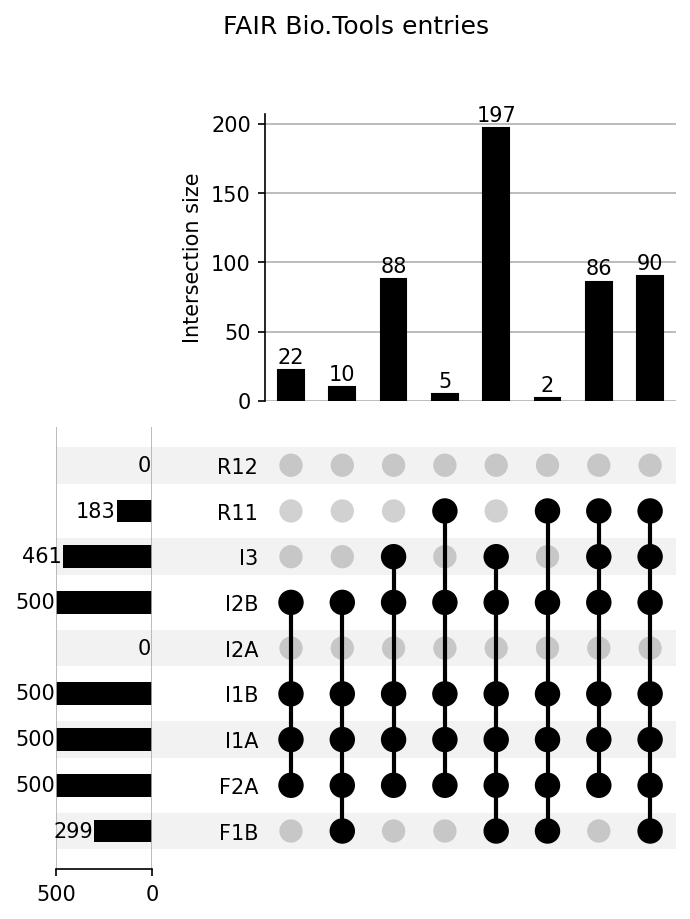

In [33]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

#upset.style_subsets(present=["with_exome", "with_images"],
#                    facecolor="red")

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("FAIR Bio.Tools entries")
plt.show()

In [30]:
import seaborn as sns

time_df.drop('ID', 1, inplace=True)

/var/folders/x1/d1nyvpvs0td0htxzsv9x6ggw0000gn/T/ipykernel_22449/601989362.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  time_df.drop('ID', 1, inplace=True)


<AxesSubplot:>

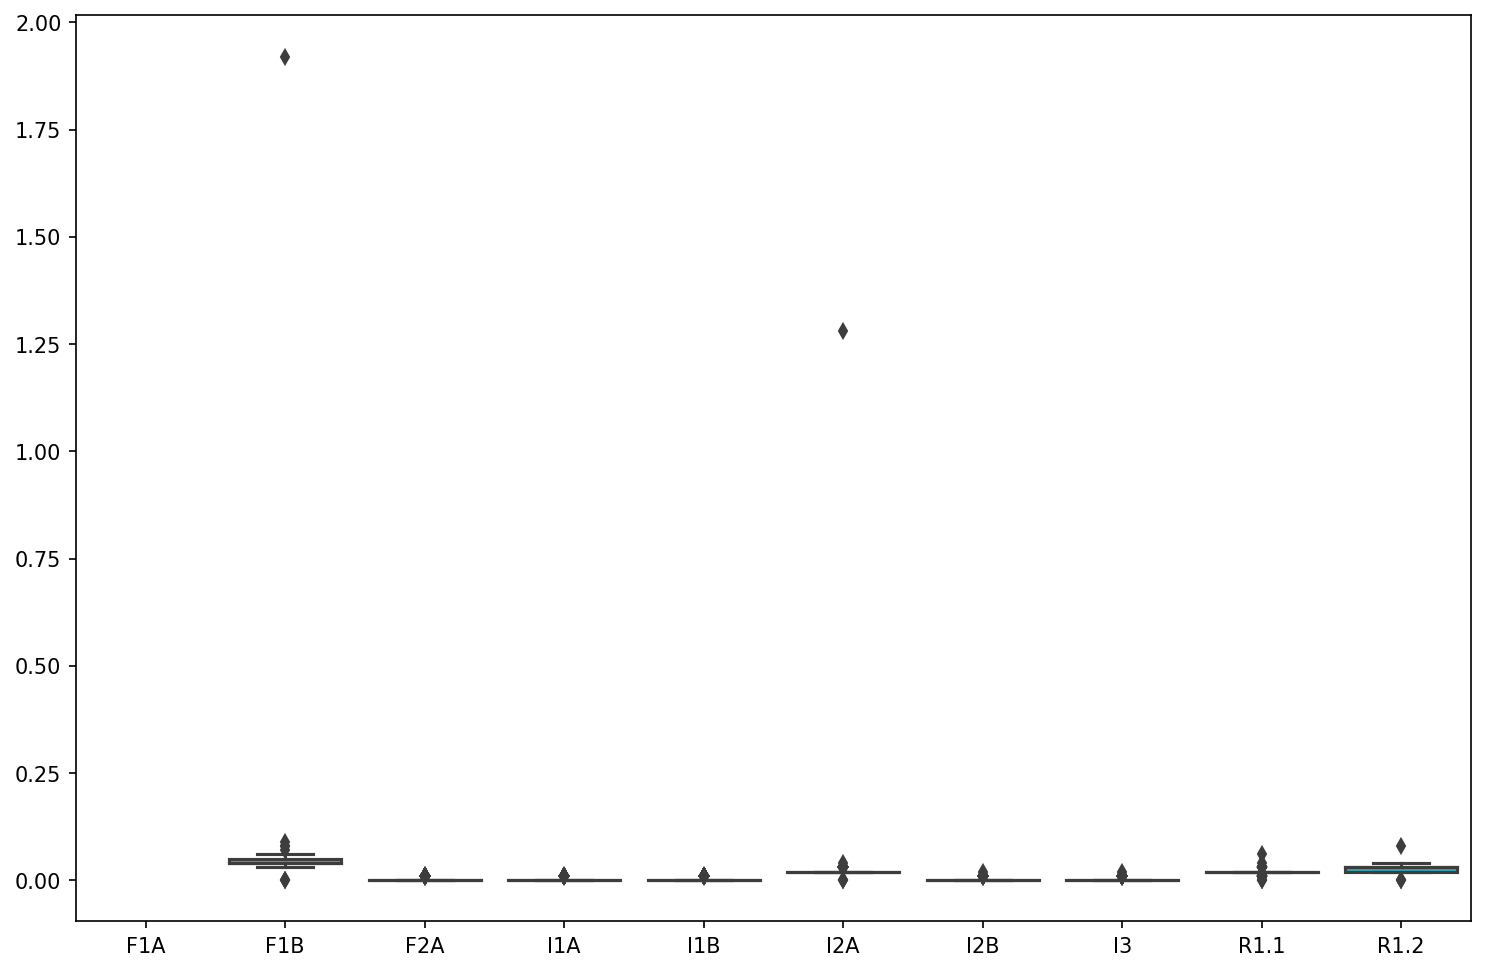

In [31]:
sns.boxplot(data=time_df)